# **Learning to Control SPOT using Camera Inputs**



SPOT, the robot dog,   navigate autonomously in indoor environments by following crude instructions from a human user: FORWARD, LEFT, and RIGHT. Its main sensor  is a forward-looking camera mounted at its head. SPOT uses the real-time camera images to understand the environment and decide the exact motion required to follow the user's instructions as closely as possible. 

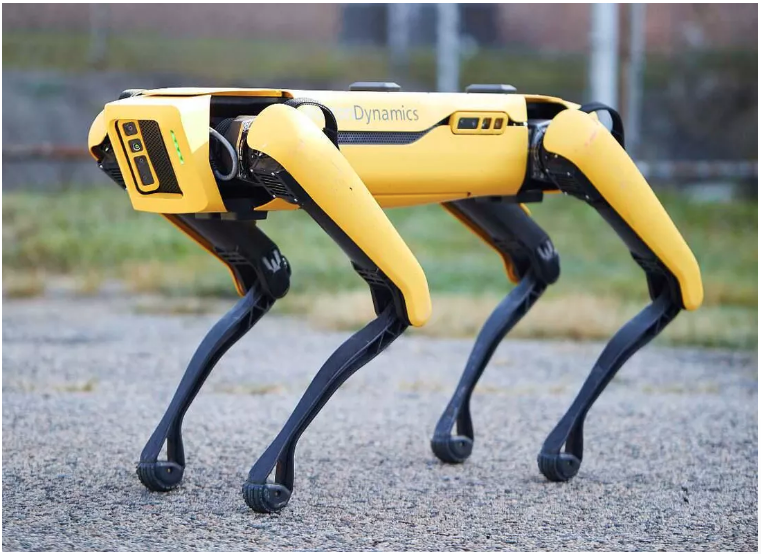


### **Overview**

This Colab notebook guides you through the task of learning to control SPOT for navigating in the SoC COM1 building. Here is the setup. A user signals high-level *intentions*,  FORWARD, LEFT, and RIGHT, to command SPOT to follow a route. Spot needs to determine its own real-time control, i.e., angular velocities, conditioned on the  user intention as well as real-time observations of the environment obtained from its front camera. You will train a neural network for the robot to complete this task.

You will use supervised learning, or also called "behaviour cloning". You will have access to a human demonstration dataset, constructed by a human expert directly controlling SPOT using a joystick, to navigate according to the high-level intention signaled by a user. The dataset contains 110,000   camera image frames and user intentions.  Each frame is labelled with the angular velocity that SPOT undertakes at the cooresponding situation. Labels of angular velocities are discretized into five bins, cooresponding to five different control classes: "hard left turn", "slight left turn", "forward", "slight right turn", and "hard right turn". Given the discretized labels, the control task becomes the problem of learning a mapping from the camera observation and the user intention to a suitable class of robot control. It is thus treated as a standard image classification task from the machine learning standpoint. 

After training, the robot would exhibit roughly the following behaviors:
* make hard turns at junctions or to avoid immediate collisions with  obstacles,
* make slight turns to conform to the shape of the corridor or prepare for hard turns,
* go straight when its heading is well-aligned with a clear corridor.

Consistent failures to  choose proper control would cause the robot to crash into the wall, obstacles, or people, while occasional failures may be recoverable.


This notebook consists of five main steps, to be executed in order.

1. *Preparation*. Check and set up the running environment: mount the google drive, create a project folder, install package dependency, ...

2. *Basic CNN Model*. Define a simple 
convolutional neural network (CNN) model that maps input images to descretized control decisions.

3. *Data Loading*. Provide a helper class to load the data for training the agent.

4. *Basic CNN Model Training*.  Run the script provided to train a basic CNN model. 

5. *Improving Prediction Performance*. Improve basic CNN model to achieve better performance for behaviour cloning in terms of the prediction accuracy.


**Remarks**
* If Colab is new to you, it may be worthwhile to go over the quick [introduction](https://colab.research.google.com/notebooks/intro.ipynb).

* The five steps should be executed **in order**, unless you are familiar with Colab and know what you are doing.

* Training with GPUs is much faster than that with CPUs only:  under the Colab notebook dropdown menu,  choose `Runtime/Change runtime type/GPU`.

* Maintain good Internet connection throughout to avoid disconnecting from the Colab.

* Do not idle your computer, as Colab automatically disconnects GPUs if the idle time is too long.

* If you have a good GPU on your personal computer, it is recommended to download the colab sheet as a python file and test your code on your local machine. The computational performance is usually better.



### **1. Preparation**



**Check Python version.**

In [1]:
!python3 -V

Python 3.10.9


**Check Cuda version.**

In [2]:
!nvcc -V

**Mount the Google drive.**

Mount your Google drive to store the dataset and the trained models.
Execute the cell below. Grant access to Google Drive when asked to do so.

In [3]:
from google.colab import drive
drive.mount("/content/drive")

**Create a project directory**

In [4]:
from os import path, chdir, getcwd, mkdir

# Choose a project name
projectName = "BehaviourCloning"

# Project directory is in My Drive
# projectDirectory = "/content/drive/My Drive/" + projectName
projectDirectory = projectName

# Checks if cwd is in content folder
# if getcwd() == "/content":
# Makes project directory if it does not exist
if not path.isdir(projectDirectory):
    mkdir(projectDirectory)
    print(f"Project {projectName} has been created!")
else:
    print(f"Project {projectName} already exist!")
    # Changes to project directory
    chdir(projectDirectory)

print(f"The current working directory is {getcwd()}")

Project BehaviourCloning already exist!
The current working directory is /Users/niharika/Documents/Study Material/Sem 2/Intelligent Robots/Assignments/Lab 2/BehaviourCloning


**Install dependencies.**

Note that we will conduct the evaluation using PyTorch version 1.13.1. It is important to ensure that the version of PyTorch used for development is consistent with the one used for evaluation. Using functions from other versions of PyTorch may result in errors during evaluation.

In [5]:
!pip3 install torch torchvision


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [6]:
!pip3 install opencv-python


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


**Check GPU usage.**

In [7]:
# Check if runtime uses GPU
import torch

device = "mps" if torch.backends.mps.is_available() else "cpu"
gpu_name = torch.device(device)
# gpu_name = torch.cuda.get_device_name(0)
print("Using GPU", gpu_name)

Using GPU mps


**Download the data set to your Google drive.**

The dataset requires about 400MB space. Please prepares sufficient space for downloading. Using the 'wget' command, you can also download the data onto your own machine. This allows you to have a local copy of the data for offline access and analysis.

In [10]:
from os import path, chdir, getcwd, mkdir
# projectDirectory = "/content/drive/My Drive/BehaviourCloning"
# chdir(projectDirectory)

!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=16DOwYORpKiXffxgzOIsfq6eA1qd6FW5i' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=16DOwYORpKiXffxgzOIsfq6eA1qd6FW5i" -O data.zip 

--2023-03-11 20:33:55--  https://docs.google.com/uc?export=download&confirm=t&id=16DOwYORpKiXffxgzOIsfq6eA1qd6FW5i
Resolving docs.google.com (docs.google.com)... 142.251.10.102, 142.251.10.139, 142.251.10.101, ...
Connecting to docs.google.com (docs.google.com)|142.251.10.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-3c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/op9qn2cv7bmav4lso6cll401cd7kgtsj/1678538025000/16928826242900815371/*/16DOwYORpKiXffxgzOIsfq6eA1qd6FW5i?e=download&uuid=d7ccc653-47a4-4b2c-ac3a-d9cf76758ac8 [following]
--2023-03-11 20:33:56--  https://doc-0k-3c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/op9qn2cv7bmav4lso6cll401cd7kgtsj/1678538025000/16928826242900815371/*/16DOwYORpKiXffxgzOIsfq6eA1qd6FW5i?e=download&uuid=d7ccc653-47a4-4b2c-ac3a-d9cf76758ac8
Resolving doc-0k-3c-docs.googleusercontent.com (doc-0k-3c-docs.googleusercontent.com)... 142.251.12.132
C

**Unzip the dataset**

It may take few minutes to finish.

In [11]:
!unzip data.zip

Archive:  data.zip
   creating: images/
  inflating: images/416738.jpg       
  inflating: images/454423.jpg       
  inflating: images/323202.jpg       
  inflating: images/363794.jpg       
  inflating: images/407413.jpg       
  inflating: images/906395.jpg       
  inflating: images/401506.jpg       
  inflating: images/221391.jpg       
  inflating: images/43953.jpg        
  inflating: images/148362.jpg       
  inflating: images/510378.jpg       
  inflating: images/611865.jpg       
  inflating: images/720627.jpg       
  inflating: images/431075.jpg       
  inflating: images/621757.jpg       
  inflating: images/42353.jpg        
  inflating: images/303175.jpg       
  inflating: images/225066.jpg       
  inflating: images/304348.jpg       
  inflating: images/189314.jpg       
  inflating: images/416654.jpg       
  inflating: images/338732.jpg       
  inflating: images/462228.jpg       
  inflating: images/158506.jpg       
  inflating: images/48450.jpg        
  inflatin

  inflating: images/449511.jpg       
  inflating: images/530009.jpg       
  inflating: images/300613.jpg       
  inflating: images/125408.jpg       
  inflating: images/936135.jpg       
  inflating: images/263043.jpg       
  inflating: images/458622.jpg       
  inflating: images/961855.jpg       
  inflating: images/401791.jpg       
  inflating: images/1013676.jpg      
  inflating: images/1013669.jpg      
  inflating: images/79855.jpg        
  inflating: images/922320.jpg       
  inflating: images/708335.jpg       
  inflating: images/747717.jpg       
  inflating: images/932807.jpg       
  inflating: images/618498.jpg       
  inflating: images/14509.jpg        
  inflating: images/101709.jpg       
  inflating: images/181703.jpg       
  inflating: images/1100789.jpg      
  inflating: images/522435.jpg       
  inflating: images/607054.jpg       
  inflating: images/915845.jpg       
  inflating: images/244630.jpg       
  inflating: images/217977.jpg       
  inflating:

  inflating: images/530772.jpg       
  inflating: images/191474.jpg       
  inflating: images/622099.jpg       
  inflating: images/85168.jpg        
  inflating: images/1072584.jpg      
  inflating: images/355346.jpg       
  inflating: images/179868.jpg       
  inflating: images/65717.jpg        
  inflating: images/341355.jpg       
  inflating: images/66992.jpg        
  inflating: images/441684.jpg       
  inflating: images/139717.jpg       
  inflating: images/420984.jpg       
  inflating: images/961749.jpg       
  inflating: images/182752.jpg       
  inflating: images/50179.jpg        
  inflating: images/515304.jpg       
  inflating: images/716288.jpg       
  inflating: images/46427.jpg        
  inflating: images/443650.jpg       
  inflating: images/321102.jpg       
  inflating: images/117385.jpg       
  inflating: images/441354.jpg       
  inflating: images/122001.jpg       
  inflating: images/402384.jpg       
  inflating: images/808626.jpg       
  inflating:

  inflating: images/530372.jpg       
  inflating: images/183524.jpg       
  inflating: images/954967.jpg       
  inflating: images/3748.jpg         
  inflating: images/199392.jpg       
  inflating: images/739188.jpg       
  inflating: images/419305.jpg       
  inflating: images/21966.jpg        
  inflating: images/335276.jpg       
  inflating: images/930305.jpg       
  inflating: images/130026.jpg       
  inflating: images/520345.jpg       
  inflating: images/504448.jpg       
  inflating: images/506440.jpg       
  inflating: images/62013.jpg        
  inflating: images/737219.jpg       
  inflating: images/5549.jpg         
  inflating: images/735909.jpg       
  inflating: images/32030.jpg        
  inflating: images/453969.jpg       
  inflating: images/503961.jpg       
  inflating: images/502102.jpg       
  inflating: images/193910.jpg       
  inflating: images/937660.jpg       
  inflating: images/126183.jpg       
  inflating: images/702955.jpg       
  inflating:

  inflating: images/1052256.jpg      
  inflating: images/410330.jpg       
  inflating: images/521402.jpg       
  inflating: images/501939.jpg       
  inflating: images/340070.jpg       
  inflating: images/617193.jpg       
  inflating: images/17695.jpg        
  inflating: images/54855.jpg        
  inflating: images/1051726.jpg      
  inflating: images/4887.jpg         
  inflating: images/1091155.jpg      
  inflating: images/905428.jpg       
  inflating: images/402731.jpg       
  inflating: images/30670.jpg        
  inflating: images/1091859.jpg      
  inflating: images/427803.jpg       
  inflating: images/117344.jpg       
  inflating: images/961848.jpg       
  inflating: images/961782.jpg       
  inflating: images/1103065.jpg      
  inflating: images/607771.jpg       
  inflating: images/736404.jpg       
  inflating: images/1011140.jpg      
  inflating: images/407719.jpg       
  inflating: images/422873.jpg       
  inflating: images/228546.jpg       
  inflating:

  inflating: images/456662.jpg       
  inflating: images/432928.jpg       
  inflating: images/944530.jpg       
  inflating: images/717261.jpg       
  inflating: images/505982.jpg       
  inflating: images/111117.jpg       
  inflating: images/954451.jpg       
  inflating: images/994119.jpg       
  inflating: images/181212.jpg       
  inflating: images/800606.jpg       
  inflating: images/194618.jpg       
  inflating: images/610593.jpg       
  inflating: images/615145.jpg       
  inflating: images/614524.jpg       
  inflating: images/803352.jpg       
  inflating: images/4770.jpg         
  inflating: images/803411.jpg       
  inflating: images/704658.jpg       
  inflating: images/324778.jpg       
  inflating: images/150896.jpg       
  inflating: images/117347.jpg       
  inflating: images/192200.jpg       
  inflating: images/417222.jpg       
  inflating: images/145826.jpg       
  inflating: images/405498.jpg       
  inflating: images/176295.jpg       
  inflating:

  inflating: images/501623.jpg       
  inflating: images/190588.jpg       
  inflating: images/907171.jpg       
  inflating: images/422145.jpg       
  inflating: images/994349.jpg       
  inflating: images/313797.jpg       
  inflating: images/607521.jpg       
  inflating: images/1081129.jpg      
  inflating: images/338343.jpg       
  inflating: images/972063.jpg       
  inflating: images/450441.jpg       
  inflating: images/619182.jpg       
  inflating: images/752837.jpg       
  inflating: images/970016.jpg       
  inflating: images/512892.jpg       
  inflating: images/100472.jpg       
  inflating: images/1007070.jpg      
  inflating: images/1091867.jpg      
  inflating: images/420210.jpg       
  inflating: images/302856.jpg       
  inflating: images/457873.jpg       
  inflating: images/177228.jpg       
  inflating: images/622061.jpg       
  inflating: images/244383.jpg       
  inflating: images/1080886.jpg      
  inflating: images/414900.jpg       
  inflating:

  inflating: images/80823.jpg        
  inflating: images/196151.jpg       
  inflating: images/701131.jpg       
  inflating: images/966676.jpg       
  inflating: images/180612.jpg       
  inflating: images/180425.jpg       
  inflating: images/106573.jpg       
  inflating: images/440276.jpg       
  inflating: images/76881.jpg        
  inflating: images/119837.jpg       
  inflating: images/168664.jpg       
  inflating: images/94084.jpg        
  inflating: images/1007082.jpg      
  inflating: images/717494.jpg       
  inflating: images/450720.jpg       
  inflating: images/201585.jpg       
  inflating: images/749865.jpg       
  inflating: images/702242.jpg       
  inflating: images/1028544.jpg      
  inflating: images/1062205.jpg      
  inflating: images/622621.jpg       
  inflating: images/325149.jpg       
  inflating: images/527787.jpg       
  inflating: images/192479.jpg       
  inflating: images/339063.jpg       
  inflating: images/21830.jpg        
  inflating:

  inflating: images/61996.jpg        
  inflating: images/728285.jpg       
  inflating: images/928432.jpg       
  inflating: images/454197.jpg       
  inflating: images/4774.jpg         
  inflating: images/973677.jpg       
  inflating: images/419333.jpg       
  inflating: images/225394.jpg       
  inflating: images/1060870.jpg      
  inflating: images/600843.jpg       
  inflating: images/740903.jpg       
  inflating: images/1091330.jpg      
  inflating: images/738844.jpg       
  inflating: images/131816.jpg       
  inflating: images/943850.jpg       
  inflating: images/622796.jpg       
  inflating: images/444583.jpg       
  inflating: images/1101780.jpg      
  inflating: images/740849.jpg       
  inflating: images/79760.jpg        
  inflating: images/520315.jpg       
  inflating: images/621878.jpg       
  inflating: images/909338.jpg       
  inflating: images/731137.jpg       
  inflating: images/17258.jpg        
  inflating: images/55568.jpg        
  inflating:

  inflating: images/36678.jpg        
  inflating: images/528138.jpg       
  inflating: images/9989.jpg         
  inflating: images/621972.jpg       
  inflating: images/910313.jpg       
  inflating: images/327055.jpg       
  inflating: images/311861.jpg       
  inflating: images/1018372.jpg      
  inflating: images/618518.jpg       
  inflating: images/710476.jpg       
  inflating: images/1081128.jpg      
  inflating: images/428921.jpg       
  inflating: images/446976.jpg       
  inflating: images/450978.jpg       
  inflating: images/901593.jpg       
  inflating: images/750011.jpg       
  inflating: images/40240.jpg        
  inflating: images/955195.jpg       
  inflating: images/48298.jpg        
  inflating: images/242594.jpg       
  inflating: images/73752.jpg        
  inflating: images/408552.jpg       
  inflating: images/86050.jpg        
  inflating: images/222581.jpg       
  inflating: images/460149.jpg       
  inflating: images/338333.jpg       
  inflating:

  inflating: images/702937.jpg       
  inflating: images/9395.jpg         
  inflating: images/981094.jpg       
  inflating: images/329920.jpg       
  inflating: images/910589.jpg       
  inflating: images/184433.jpg       
  inflating: images/1063105.jpg      
  inflating: images/16915.jpg        
  inflating: images/409689.jpg       
  inflating: images/210340.jpg       
  inflating: images/739973.jpg       
  inflating: images/516347.jpg       
  inflating: images/371150.jpg       
  inflating: images/111829.jpg       
  inflating: images/50187.jpg        
  inflating: images/446114.jpg       
  inflating: images/208560.jpg       
  inflating: images/742491.jpg       
  inflating: images/430168.jpg       
  inflating: images/618520.jpg       
  inflating: images/452336.jpg       
  inflating: images/1078508.jpg      
  inflating: images/423596.jpg       
  inflating: images/510037.jpg       
  inflating: images/941491.jpg       
  inflating: images/960589.jpg       
  inflating:

  inflating: images/196131.jpg       
  inflating: images/800125.jpg       
  inflating: images/331280.jpg       
  inflating: images/1053032.jpg      
  inflating: images/446497.jpg       
  inflating: images/195001.jpg       
  inflating: images/458120.jpg       
  inflating: images/128339.jpg       
  inflating: images/734749.jpg       
  inflating: images/25398.jpg        
  inflating: images/36427.jpg        
  inflating: images/228545.jpg       
  inflating: images/911522.jpg       
  inflating: images/751337.jpg       
  inflating: images/440030.jpg       
  inflating: images/907111.jpg       
  inflating: images/1065631.jpg      
  inflating: images/422974.jpg       
  inflating: images/462298.jpg       
  inflating: images/173064.jpg       
  inflating: images/403980.jpg       
  inflating: images/114768.jpg       
  inflating: images/404381.jpg       
  inflating: images/342328.jpg       
  inflating: images/419442.jpg       
  inflating: images/83498.jpg        
  inflating:

  inflating: images/220024.jpg       
  inflating: images/139228.jpg       
  inflating: images/85937.jpg        
  inflating: images/182063.jpg       
  inflating: images/221925.jpg       
  inflating: images/324897.jpg       
  inflating: images/520849.jpg       
  inflating: images/911934.jpg       
  inflating: images/711661.jpg       
  inflating: images/316351.jpg       
  inflating: images/177610.jpg       
  inflating: images/400431.jpg       
  inflating: images/401881.jpg       
  inflating: images/46965.jpg        
  inflating: images/230336.jpg       
  inflating: images/135646.jpg       
  inflating: images/209608.jpg       
  inflating: images/215576.jpg       
  inflating: images/327899.jpg       
  inflating: images/359321.jpg       
  inflating: images/189395.jpg       
  inflating: images/193073.jpg       
  inflating: images/507673.jpg       
  inflating: images/417065.jpg       
  inflating: images/616660.jpg       
  inflating: images/133346.jpg       
  inflating:

  inflating: images/12644.jpg        
  inflating: images/728110.jpg       
  inflating: images/455267.jpg       
  inflating: images/166389.jpg       
  inflating: images/73083.jpg        
  inflating: images/512611.jpg       
  inflating: images/345542.jpg       
  inflating: images/945801.jpg       
  inflating: images/1081118.jpg      
  inflating: images/409812.jpg       
  inflating: images/158133.jpg       
  inflating: images/413860.jpg       
  inflating: images/403325.jpg       
  inflating: images/309073.jpg       
  inflating: images/106081.jpg       
  inflating: images/742023.jpg       
  inflating: images/928415.jpg       
  inflating: images/904922.jpg       
  inflating: images/218698.jpg       
  inflating: images/961765.jpg       
  inflating: images/1101869.jpg      
  inflating: images/152670.jpg       
  inflating: images/752446.jpg       
  inflating: images/337955.jpg       
  inflating: images/444414.jpg       
  inflating: images/1070293.jpg      
  inflating:

  inflating: images/736118.jpg       
  inflating: images/217407.jpg       
  inflating: images/617294.jpg       
  inflating: images/1087941.jpg      
  inflating: images/182516.jpg       
  inflating: images/921897.jpg       
  inflating: images/10671.jpg        
  inflating: images/740146.jpg       
  inflating: images/907592.jpg       
  inflating: images/213516.jpg       
  inflating: images/182731.jpg       
  inflating: images/954272.jpg       
  inflating: images/6004.jpg         
  inflating: images/85070.jpg        
  inflating: images/445707.jpg       
  inflating: images/101210.jpg       
  inflating: images/737218.jpg       
  inflating: images/413109.jpg       
  inflating: images/16885.jpg        
  inflating: images/1077398.jpg      
  inflating: images/221204.jpg       
  inflating: images/145557.jpg       
  inflating: images/1061919.jpg      
  inflating: images/905412.jpg       
  inflating: images/98613.jpg        
  inflating: images/1063977.jpg      
  inflating:

  inflating: images/617555.jpg       
  inflating: images/101683.jpg       
  inflating: images/449415.jpg       
  inflating: images/24020.jpg        
  inflating: images/738256.jpg       
  inflating: images/524897.jpg       
  inflating: images/524874.jpg       
  inflating: images/123148.jpg       
  inflating: images/433758.jpg       
  inflating: images/739184.jpg       
  inflating: images/1003533.jpg      
  inflating: images/329168.jpg       
  inflating: images/369242.jpg       
  inflating: images/1105378.jpg      
  inflating: images/1014833.jpg      
  inflating: images/55679.jpg        
  inflating: images/252717.jpg       
  inflating: images/1063973.jpg      
  inflating: images/927284.jpg       
  inflating: images/148566.jpg       
  inflating: images/1091238.jpg      
  inflating: images/900100.jpg       
  inflating: images/454660.jpg       
  inflating: images/60561.jpg        
  inflating: images/615223.jpg       
  inflating: images/441508.jpg       
  inflating:

  inflating: images/425536.jpg       
  inflating: images/415778.jpg       
  inflating: images/510831.jpg       
  inflating: images/402002.jpg       
  inflating: images/183565.jpg       
  inflating: images/62035.jpg        
  inflating: images/337620.jpg       
  inflating: images/994303.jpg       
  inflating: images/403193.jpg       
  inflating: images/136698.jpg       
  inflating: images/1102765.jpg      
  inflating: images/87007.jpg        
  inflating: images/941749.jpg       
  inflating: images/196326.jpg       
  inflating: images/168642.jpg       
  inflating: images/185300.jpg       
  inflating: images/429082.jpg       
  inflating: images/457450.jpg       
  inflating: images/720835.jpg       
  inflating: images/122873.jpg       
  inflating: images/9994.jpg         
  inflating: images/232446.jpg       
  inflating: images/462250.jpg       
  inflating: images/103496.jpg       
  inflating: images/956032.jpg       
  inflating: images/621209.jpg       
  inflating:

  inflating: images/367444.jpg       
  inflating: images/404861.jpg       
  inflating: images/409521.jpg       
  inflating: images/425336.jpg       
  inflating: images/716624.jpg       
  inflating: images/22042.jpg        
  inflating: images/934619.jpg       
  inflating: images/109198.jpg       
  inflating: images/180312.jpg       
  inflating: images/205786.jpg       
  inflating: images/433205.jpg       
  inflating: images/26089.jpg        
  inflating: images/609243.jpg       
  inflating: images/306324.jpg       
  inflating: images/16438.jpg        
  inflating: images/721135.jpg       
  inflating: images/245482.jpg       
  inflating: images/729497.jpg       
  inflating: images/401545.jpg       
  inflating: images/1070258.jpg      
  inflating: images/245407.jpg       
  inflating: images/74274.jpg        
  inflating: images/903646.jpg       
  inflating: images/18078.jpg        
  inflating: images/422383.jpg       
  inflating: images/412074.jpg       
  inflating:

  inflating: images/1026649.jpg      
  inflating: images/139666.jpg       
  inflating: images/232246.jpg       
  inflating: images/18338.jpg        
  inflating: images/171451.jpg       
  inflating: images/198314.jpg       
  inflating: images/701715.jpg       
  inflating: images/423548.jpg       
  inflating: images/721895.jpg       
  inflating: images/48287.jpg        
  inflating: images/749777.jpg       
  inflating: images/187136.jpg       
  inflating: images/936751.jpg       
  inflating: images/432272.jpg       
  inflating: images/42319.jpg        
  inflating: images/29258.jpg        
  inflating: images/744460.jpg       
  inflating: images/1087492.jpg      
  inflating: images/422687.jpg       
  inflating: images/993618.jpg       
  inflating: images/42363.jpg        
  inflating: images/426168.jpg       
  inflating: images/123778.jpg       
  inflating: images/208044.jpg       
  inflating: images/55924.jpg        
  inflating: images/70066.jpg        
  inflating:

  inflating: images/214792.jpg       
  inflating: images/459905.jpg       
  inflating: images/717356.jpg       
  inflating: images/443385.jpg       
  inflating: images/1077770.jpg      
  inflating: images/461986.jpg       
  inflating: images/309769.jpg       
  inflating: images/519010.jpg       
  inflating: images/518388.jpg       
  inflating: images/328694.jpg       
  inflating: images/703829.jpg       
  inflating: images/63631.jpg        
  inflating: images/738752.jpg       
  inflating: images/1077372.jpg      
  inflating: images/996407.jpg       
  inflating: images/103928.jpg       
  inflating: images/715800.jpg       
  inflating: images/928109.jpg       
  inflating: images/324705.jpg       
  inflating: images/303327.jpg       
  inflating: images/713436.jpg       
  inflating: images/943649.jpg       
  inflating: images/423591.jpg       
  inflating: images/1090663.jpg      
  inflating: images/744266.jpg       
  inflating: images/718067.jpg       
  inflating:

  inflating: images/133515.jpg       
  inflating: images/248703.jpg       
  inflating: images/160551.jpg       
  inflating: images/718402.jpg       
  inflating: images/1055127.jpg      
  inflating: images/443424.jpg       
  inflating: images/604457.jpg       
  inflating: images/14101.jpg        
  inflating: images/1079427.jpg      
  inflating: images/528946.jpg       
  inflating: images/361799.jpg       
  inflating: images/261753.jpg       
  inflating: images/616662.jpg       
  inflating: images/932848.jpg       
  inflating: images/336041.jpg       
  inflating: images/421596.jpg       
  inflating: images/614342.jpg       
  inflating: images/119774.jpg       
  inflating: images/106986.jpg       
  inflating: images/267123.jpg       
  inflating: images/506040.jpg       
  inflating: images/948444.jpg       
  inflating: images/912834.jpg       
  inflating: images/36635.jpg        
  inflating: images/370648.jpg       
  inflating: images/949993.jpg       
  inflating:

  inflating: images/97115.jpg        
  inflating: images/136273.jpg       
  inflating: images/341368.jpg       
  inflating: images/323061.jpg       
  inflating: images/530007.jpg       
  inflating: images/943922.jpg       
  inflating: images/251231.jpg       
  inflating: images/720519.jpg       
  inflating: images/752247.jpg       
  inflating: images/978496.jpg       
  inflating: images/164508.jpg       
  inflating: images/613990.jpg       
  inflating: images/129582.jpg       
  inflating: images/330567.jpg       
  inflating: images/345139.jpg       
  inflating: images/751221.jpg       
  inflating: images/431304.jpg       
  inflating: images/234238.jpg       
  inflating: images/961179.jpg       
  inflating: images/15607.jpg        
  inflating: images/403757.jpg       
  inflating: images/101403.jpg       
  inflating: images/455719.jpg       
  inflating: images/722979.jpg       
  inflating: images/518654.jpg       
  inflating: images/86684.jpg        
  inflating:

  inflating: images/943253.jpg       
  inflating: images/77087.jpg        
  inflating: images/964881.jpg       
  inflating: images/512765.jpg       
  inflating: images/521189.jpg       
  inflating: images/906761.jpg       
  inflating: images/323408.jpg       
  inflating: images/316708.jpg       
  inflating: images/303746.jpg       
  inflating: images/263549.jpg       
  inflating: images/405190.jpg       
  inflating: images/706284.jpg       
  inflating: images/461540.jpg       
  inflating: images/1103066.jpg      
  inflating: images/742822.jpg       
  inflating: images/613146.jpg       
  inflating: images/1070284.jpg      
  inflating: images/602982.jpg       
  inflating: images/724514.jpg       
  inflating: images/365894.jpg       
  inflating: images/935040.jpg       
  inflating: images/18699.jpg        
  inflating: images/301648.jpg       
  inflating: images/48443.jpg        
  inflating: images/449933.jpg       
  inflating: images/614373.jpg       
  inflating:

  inflating: images/452372.jpg       
  inflating: images/135504.jpg       
  inflating: images/723416.jpg       
  inflating: images/616839.jpg       
  inflating: images/927228.jpg       
  inflating: images/137900.jpg       
  inflating: images/443029.jpg       
  inflating: images/237446.jpg       
  inflating: images/614338.jpg       
  inflating: images/419428.jpg       
  inflating: images/421388.jpg       
  inflating: images/521253.jpg       
  inflating: images/232936.jpg       
  inflating: images/15959.jpg        
  inflating: images/528873.jpg       
  inflating: images/123055.jpg       
  inflating: images/944943.jpg       
  inflating: images/106153.jpg       
  inflating: images/410556.jpg       
  inflating: images/976592.jpg       
  inflating: images/63835.jpg        
  inflating: images/705216.jpg       
  inflating: images/47871.jpg        
  inflating: images/76613.jpg        
  inflating: images/1109314.jpg      
  inflating: images/519553.jpg       
  inflating:

  inflating: images/54504.jpg        
  inflating: images/615445.jpg       
  inflating: images/232241.jpg       
  inflating: images/1101067.jpg      
  inflating: images/311545.jpg       
  inflating: images/406204.jpg       
  inflating: images/1086618.jpg      
  inflating: images/517253.jpg       
  inflating: images/704258.jpg       
  inflating: images/139552.jpg       
  inflating: images/416640.jpg       
  inflating: images/1103263.jpg      
  inflating: images/423086.jpg       
  inflating: images/1106015.jpg      
  inflating: images/969725.jpg       
  inflating: images/316572.jpg       
  inflating: images/961945.jpg       
  inflating: images/926379.jpg       
  inflating: images/140457.jpg       
  inflating: images/455148.jpg       
  inflating: images/434000.jpg       
  inflating: images/423271.jpg       
  inflating: images/716149.jpg       
  inflating: images/605141.jpg       
  inflating: images/328403.jpg       
  inflating: images/58644.jpg        
  inflating:

  inflating: images/22050.jpg        
  inflating: images/910335.jpg       
  inflating: images/449701.jpg       
  inflating: images/729520.jpg       
  inflating: images/73162.jpg        
  inflating: images/441489.jpg       
  inflating: images/10602.jpg        
  inflating: images/609919.jpg       
  inflating: images/733954.jpg       
  inflating: images/1073185.jpg      
  inflating: images/217071.jpg       
  inflating: images/456668.jpg       
  inflating: images/342850.jpg       
  inflating: images/752883.jpg       
  inflating: images/512620.jpg       
  inflating: images/432241.jpg       
  inflating: images/46384.jpg        
  inflating: images/253356.jpg       
  inflating: images/109896.jpg       
  inflating: images/523333.jpg       
  inflating: images/705594.jpg       
  inflating: images/303096.jpg       
  inflating: images/450968.jpg       
  inflating: images/354940.jpg       
  inflating: images/935517.jpg       
  inflating: images/966149.jpg       
  inflating:

  inflating: images/440236.jpg       
  inflating: images/28048.jpg        
  inflating: images/1102341.jpg      
  inflating: images/447468.jpg       
  inflating: images/732446.jpg       
  inflating: images/431845.jpg       
  inflating: images/946980.jpg       
  inflating: images/432201.jpg       
  inflating: images/415554.jpg       
  inflating: images/447374.jpg       
  inflating: images/107241.jpg       
  inflating: images/167035.jpg       
  inflating: images/15287.jpg        
  inflating: images/341022.jpg       
  inflating: images/122360.jpg       
  inflating: images/613525.jpg       
  inflating: images/170288.jpg       
  inflating: images/156802.jpg       
  inflating: images/225472.jpg       
  inflating: images/938265.jpg       
  inflating: images/803287.jpg       
  inflating: images/909657.jpg       
  inflating: images/371190.jpg       
  inflating: images/142214.jpg       
  inflating: images/409161.jpg       
  inflating: images/170198.jpg       
  inflating:

  inflating: images/148422.jpg       
  inflating: images/14492.jpg        
  inflating: images/245457.jpg       
  inflating: images/1081166.jpg      
  inflating: images/118760.jpg       
  inflating: images/459168.jpg       
  inflating: images/25804.jpg        
  inflating: images/411165.jpg       
  inflating: images/426295.jpg       
  inflating: images/205192.jpg       
  inflating: images/326709.jpg       
  inflating: images/77539.jpg        
  inflating: images/748548.jpg       
  inflating: images/91213.jpg        
  inflating: images/37231.jpg        
  inflating: images/462291.jpg       
  inflating: images/430442.jpg       
  inflating: images/929493.jpg       
  inflating: images/978371.jpg       
  inflating: images/79888.jpg        
  inflating: images/905149.jpg       
  inflating: images/307716.jpg       
  inflating: images/518568.jpg       
  inflating: images/459249.jpg       
  inflating: images/1074135.jpg      
  inflating: images/175824.jpg       
  inflating:

  inflating: images/20637.jpg        
  inflating: images/403324.jpg       
  inflating: images/920471.jpg       
  inflating: images/514032.jpg       
  inflating: images/965687.jpg       
  inflating: images/405368.jpg       
  inflating: images/449546.jpg       
  inflating: images/146124.jpg       
  inflating: images/752927.jpg       
  inflating: images/401184.jpg       
  inflating: images/915740.jpg       
  inflating: images/44748.jpg        
  inflating: images/152118.jpg       
  inflating: images/230739.jpg       
  inflating: images/903302.jpg       
  inflating: images/460655.jpg       
  inflating: images/529847.jpg       
  inflating: images/166292.jpg       
  inflating: images/805583.jpg       
  inflating: images/255346.jpg       
  inflating: images/602526.jpg       
  inflating: images/1089515.jpg      
  inflating: images/1061484.jpg      
  inflating: images/609269.jpg       
  inflating: images/440451.jpg       
  inflating: images/51443.jpg        
  inflating:

  inflating: images/1003524.jpg      
  inflating: images/919610.jpg       
  inflating: images/923519.jpg       
  inflating: images/749211.jpg       
  inflating: images/35054.jpg        
  inflating: images/95434.jpg        
  inflating: images/415051.jpg       
  inflating: images/34062.jpg        
  inflating: images/14103.jpg        
  inflating: images/961467.jpg       
  inflating: images/214116.jpg       
  inflating: images/616129.jpg       
  inflating: images/736111.jpg       
  inflating: images/500268.jpg       
  inflating: images/362475.jpg       
  inflating: images/900942.jpg       
  inflating: images/904211.jpg       
  inflating: images/909824.jpg       
  inflating: images/750229.jpg       
  inflating: images/924109.jpg       
  inflating: images/50484.jpg        
  inflating: images/38305.jpg        
  inflating: images/130817.jpg       
  inflating: images/910016.jpg       
  inflating: images/529126.jpg       
  inflating: images/514469.jpg       
  inflating:

  inflating: images/370570.jpg       
  inflating: images/209823.jpg       
  inflating: images/429020.jpg       
  inflating: images/728761.jpg       
  inflating: images/323063.jpg       
  inflating: images/48401.jpg        
  inflating: images/918307.jpg       
  inflating: images/929658.jpg       
  inflating: images/713409.jpg       
  inflating: images/46585.jpg        
  inflating: images/433005.jpg       
  inflating: images/199313.jpg       
  inflating: images/172227.jpg       
  inflating: images/1003525.jpg      
  inflating: images/1011152.jpg      
  inflating: images/700.jpg          
  inflating: images/303716.jpg       
  inflating: images/4787.jpg         
  inflating: images/459318.jpg       
  inflating: images/338883.jpg       
  inflating: images/519546.jpg       
  inflating: images/405429.jpg       
  inflating: images/453668.jpg       
  inflating: images/52617.jpg        
  inflating: images/523583.jpg       
  inflating: images/1072579.jpg      
  inflating:

  inflating: images/244695.jpg       
  inflating: images/447833.jpg       
  inflating: images/180108.jpg       
  inflating: images/441187.jpg       
  inflating: images/56958.jpg        
  inflating: images/422895.jpg       
  inflating: images/524990.jpg       
  inflating: images/124419.jpg       
  inflating: images/962130.jpg       
  inflating: images/738641.jpg       
  inflating: images/506526.jpg       
  inflating: images/743617.jpg       
  inflating: images/907141.jpg       
  inflating: images/73564.jpg        
  inflating: images/752899.jpg       
  inflating: images/527810.jpg       
  inflating: images/301665.jpg       
  inflating: images/715471.jpg       
  inflating: images/711921.jpg       
  inflating: images/231061.jpg       
  inflating: images/328413.jpg       
  inflating: images/194321.jpg       
  inflating: images/213523.jpg       
  inflating: images/951986.jpg       
  inflating: images/1064318.jpg      
  inflating: images/420594.jpg       
  inflating:

  inflating: images/405588.jpg       
  inflating: images/350008.jpg       
  inflating: images/122920.jpg       
  inflating: images/718087.jpg       
  inflating: images/433707.jpg       
  inflating: images/960588.jpg       
  inflating: images/198047.jpg       
  inflating: images/214166.jpg       
  inflating: images/176777.jpg       
  inflating: images/425597.jpg       
  inflating: images/116470.jpg       
  inflating: images/340830.jpg       
  inflating: images/921471.jpg       
  inflating: images/716911.jpg       
  inflating: images/710321.jpg       
  inflating: images/735463.jpg       
  inflating: images/440752.jpg       
  inflating: images/516388.jpg       
  inflating: images/506360.jpg       
  inflating: images/64501.jpg        
  inflating: images/922316.jpg       
  inflating: images/9235.jpg         
  inflating: images/105386.jpg       
  inflating: images/733245.jpg       
  inflating: images/403529.jpg       
  inflating: images/207808.jpg       
  inflating:

  inflating: images/1062203.jpg      
  inflating: images/910024.jpg       
  inflating: images/236324.jpg       
  inflating: images/59192.jpg        
  inflating: images/729021.jpg       
  inflating: images/994747.jpg       
  inflating: images/245273.jpg       
  inflating: images/747387.jpg       
  inflating: images/960789.jpg       
  inflating: images/976647.jpg       
  inflating: images/449758.jpg       
  inflating: images/347698.jpg       
  inflating: images/459644.jpg       
  inflating: images/615227.jpg       
  inflating: images/602665.jpg       
  inflating: images/744580.jpg       
  inflating: images/103455.jpg       
  inflating: images/994995.jpg       
  inflating: images/747831.jpg       
  inflating: images/903057.jpg       
  inflating: images/919955.jpg       
  inflating: images/429479.jpg       
  inflating: images/448825.jpg       
  inflating: images/906303.jpg       
  inflating: images/17252.jpg        
  inflating: images/980201.jpg       
  inflating:

  inflating: images/1100772.jpg      
  inflating: images/452371.jpg       
  inflating: images/81457.jpg        
  inflating: images/145047.jpg       
  inflating: images/19018.jpg        
  inflating: images/972405.jpg       
  inflating: images/454874.jpg       
  inflating: images/969384.jpg       
  inflating: images/922829.jpg       
  inflating: images/513783.jpg       
  inflating: images/173083.jpg       
  inflating: images/191163.jpg       
  inflating: images/443649.jpg       
  inflating: images/1070249.jpg      
  inflating: images/4111.jpg         
  inflating: images/526305.jpg       
  inflating: images/954329.jpg       
  inflating: images/40565.jpg        
  inflating: images/184086.jpg       
  inflating: images/521107.jpg       
  inflating: images/451701.jpg       
  inflating: images/431639.jpg       
  inflating: images/733491.jpg       
  inflating: images/955935.jpg       
  inflating: images/68029.jpg        
  inflating: images/900139.jpg       
  inflating:

  inflating: images/310516.jpg       
  inflating: images/344379.jpg       
  inflating: images/212208.jpg       
  inflating: images/450858.jpg       
  inflating: images/324072.jpg       
  inflating: images/600411.jpg       
  inflating: images/171197.jpg       
  inflating: images/516728.jpg       
  inflating: images/446083.jpg       
  inflating: images/981265.jpg       
  inflating: images/330370.jpg       
  inflating: images/441471.jpg       
  inflating: images/919175.jpg       
  inflating: images/452299.jpg       
  inflating: images/617291.jpg       
  inflating: images/735481.jpg       
  inflating: images/37053.jpg        
  inflating: images/916274.jpg       
  inflating: images/44561.jpg        
  inflating: images/416728.jpg       
  inflating: images/403942.jpg       
  inflating: images/75355.jpg        
  inflating: images/123860.jpg       
  inflating: images/983308.jpg       
  inflating: images/994321.jpg       
  inflating: images/447294.jpg       
  inflating:

  inflating: images/345353.jpg       
  inflating: images/927458.jpg       
  inflating: images/527979.jpg       
  inflating: images/227876.jpg       
  inflating: images/960021.jpg       
  inflating: images/712503.jpg       
  inflating: images/1109042.jpg      
  inflating: images/431117.jpg       
  inflating: images/367527.jpg       
  inflating: images/603560.jpg       
  inflating: images/423306.jpg       
  inflating: images/108557.jpg       
  inflating: images/261427.jpg       
  inflating: images/38604.jpg        
  inflating: images/116490.jpg       
  inflating: images/417896.jpg       
  inflating: images/721403.jpg       
  inflating: images/733324.jpg       
  inflating: images/404736.jpg       
  inflating: images/615981.jpg       
  inflating: images/419373.jpg       
  inflating: images/807541.jpg       
  inflating: images/937471.jpg       
  inflating: images/85060.jpg        
  inflating: images/24036.jpg        
  inflating: images/747879.jpg       
  inflating:

  inflating: images/956110.jpg       
  inflating: images/11196.jpg        
  inflating: images/908257.jpg       
  inflating: images/1054417.jpg      
  inflating: images/904236.jpg       
  inflating: images/432159.jpg       
  inflating: images/718051.jpg       
  inflating: images/254735.jpg       
  inflating: images/510088.jpg       
  inflating: images/344861.jpg       
  inflating: images/611878.jpg       
  inflating: images/994170.jpg       
  inflating: images/600414.jpg       
  inflating: images/908802.jpg       
  inflating: images/1072876.jpg      
  inflating: images/975774.jpg       
  inflating: images/516757.jpg       
  inflating: images/150253.jpg       
  inflating: images/960515.jpg       
  inflating: images/41106.jpg        
  inflating: images/739971.jpg       
  inflating: images/969234.jpg       
  inflating: images/71973.jpg        
  inflating: images/444762.jpg       
  inflating: images/227894.jpg       
  inflating: images/716590.jpg       
  inflating:

  inflating: images/454886.jpg       
  inflating: images/745210.jpg       
  inflating: images/704984.jpg       
  inflating: images/40104.jpg        
  inflating: images/901871.jpg       
  inflating: images/713683.jpg       
  inflating: images/46387.jpg        
  inflating: images/65363.jpg        
  inflating: images/979866.jpg       
  inflating: images/53246.jpg        
  inflating: images/322722.jpg       
  inflating: images/440475.jpg       
  inflating: images/371080.jpg       
  inflating: images/606778.jpg       
  inflating: images/461981.jpg       
  inflating: images/622150.jpg       
  inflating: images/926386.jpg       
  inflating: images/138441.jpg       
  inflating: images/405624.jpg       
  inflating: images/316541.jpg       
  inflating: images/337773.jpg       
  inflating: images/414182.jpg       
  inflating: images/303068.jpg       
  inflating: images/960613.jpg       
  inflating: images/433751.jpg       
  inflating: images/613735.jpg       
  inflating:

  inflating: images/441377.jpg       
  inflating: images/124391.jpg       
  inflating: images/512706.jpg       
  inflating: images/1053376.jpg      
  inflating: images/520583.jpg       
  inflating: images/146120.jpg       
  inflating: images/515728.jpg       
  inflating: images/345500.jpg       
  inflating: images/455378.jpg       
  inflating: images/737282.jpg       
  inflating: images/189418.jpg       
  inflating: images/171458.jpg       
  inflating: images/202749.jpg       
  inflating: images/908772.jpg       
  inflating: images/16704.jpg        
  inflating: images/744461.jpg       
  inflating: images/944454.jpg       
  inflating: images/440033.jpg       
  inflating: images/419066.jpg       
  inflating: images/354921.jpg       
  inflating: images/322859.jpg       
  inflating: images/173596.jpg       
  inflating: images/451686.jpg       
  inflating: images/1102696.jpg      
  inflating: images/52176.jpg        
  inflating: images/745732.jpg       
  inflating:

  inflating: images/342776.jpg       
  inflating: images/142186.jpg       
  inflating: images/458410.jpg       
  inflating: images/432539.jpg       
  inflating: images/925498.jpg       
  inflating: images/421140.jpg       
  inflating: images/170413.jpg       
  inflating: images/80372.jpg        
  inflating: images/425913.jpg       
  inflating: images/936434.jpg       
  inflating: images/459301.jpg       
  inflating: images/455870.jpg       
  inflating: images/4737.jpg         
  inflating: images/808939.jpg       
  inflating: images/506475.jpg       
  inflating: images/421181.jpg       
  inflating: images/104526.jpg       
  inflating: images/146365.jpg       
  inflating: images/530922.jpg       
  inflating: images/1060075.jpg      
  inflating: images/180247.jpg       
  inflating: images/120441.jpg       
  inflating: images/513099.jpg       
  inflating: images/450532.jpg       
  inflating: images/516154.jpg       
  inflating: images/996424.jpg       
  inflating:

  inflating: images/407394.jpg       
  inflating: images/143405.jpg       
  inflating: images/457967.jpg       
  inflating: images/73650.jpg        
  inflating: images/60101.jpg        
  inflating: images/800597.jpg       
  inflating: images/111584.jpg       
  inflating: images/425680.jpg       
  inflating: images/941660.jpg       
  inflating: images/530621.jpg       
  inflating: images/400158.jpg       
  inflating: images/1080835.jpg      
  inflating: images/324906.jpg       
  inflating: images/192241.jpg       
  inflating: images/253463.jpg       
  inflating: images/1078193.jpg      
  inflating: images/124044.jpg       
  inflating: images/912361.jpg       
  inflating: images/224982.jpg       
  inflating: images/1089499.jpg      
  inflating: images/164324.jpg       
  inflating: images/751526.jpg       
  inflating: images/434192.jpg       
  inflating: images/57712.jpg        
  inflating: images/362495.jpg       
  inflating: images/450369.jpg       
  inflating:

  inflating: images/345654.jpg       
  inflating: images/34668.jpg        
  inflating: images/1070446.jpg      
  inflating: images/923516.jpg       
  inflating: images/502608.jpg       
  inflating: images/1050354.jpg      
  inflating: images/741578.jpg       
  inflating: images/739359.jpg       
  inflating: images/80682.jpg        
  inflating: images/63843.jpg        
  inflating: images/752792.jpg       
  inflating: images/265524.jpg       
  inflating: images/507856.jpg       
  inflating: images/503502.jpg       
  inflating: images/514653.jpg       
  inflating: images/62268.jpg        
  inflating: images/622824.jpg       
  inflating: images/424225.jpg       
  inflating: images/936501.jpg       
  inflating: images/359923.jpg       
  inflating: images/80341.jpg        
  inflating: images/915381.jpg       
  inflating: images/198067.jpg       
  inflating: images/996139.jpg       
  inflating: images/118464.jpg       
  inflating: images/523182.jpg       
  inflating:

  inflating: images/995497.jpg       
  inflating: images/937477.jpg       
  inflating: images/516103.jpg       
  inflating: images/179846.jpg       
  inflating: images/722793.jpg       
  inflating: images/923871.jpg       
  inflating: images/914418.jpg       
  inflating: images/937353.jpg       
  inflating: images/622441.jpg       
  inflating: images/113239.jpg       
  inflating: images/76431.jpg        
  inflating: images/616087.jpg       
  inflating: images/949538.jpg       
  inflating: images/450979.jpg       
  inflating: images/409281.jpg       
  inflating: images/960503.jpg       
  inflating: images/906155.jpg       
  inflating: images/700094.jpg       
  inflating: images/527382.jpg       
  inflating: images/232710.jpg       
  inflating: images/420731.jpg       
  inflating: images/742891.jpg       
  inflating: images/969761.jpg       
  inflating: images/122855.jpg       
  inflating: images/461612.jpg       
  inflating: images/713339.jpg       
  inflating:

  inflating: images/461316.jpg       
  inflating: images/216848.jpg       
  inflating: images/344350.jpg       
  inflating: images/96257.jpg        
  inflating: images/500619.jpg       
  inflating: images/600522.jpg       
  inflating: images/138357.jpg       
  inflating: images/15327.jpg        
  inflating: images/706731.jpg       
  inflating: images/605131.jpg       
  inflating: images/339219.jpg       
  inflating: images/942002.jpg       
  inflating: images/966337.jpg       
  inflating: images/156653.jpg       
  inflating: images/513717.jpg       
  inflating: images/942953.jpg       
  inflating: images/41030.jpg        
  inflating: images/324976.jpg       
  inflating: images/945838.jpg       
  inflating: images/184975.jpg       
  inflating: images/443340.jpg       
  inflating: images/936907.jpg       
  inflating: images/425112.jpg       
  inflating: images/326636.jpg       
  inflating: images/188425.jpg       
  inflating: images/218924.jpg       
  inflating:

  inflating: images/76715.jpg        
  inflating: images/67035.jpg        
  inflating: images/448180.jpg       
  inflating: images/451111.jpg       
  inflating: images/502103.jpg       
  inflating: images/421504.jpg       
  inflating: images/1014838.jpg      
  inflating: images/9098.jpg         
  inflating: images/946984.jpg       
  inflating: images/142310.jpg       
  inflating: images/448246.jpg       
  inflating: images/141946.jpg       
  inflating: images/444530.jpg       
  inflating: images/159994.jpg       
  inflating: images/939399.jpg       
  inflating: images/193448.jpg       
  inflating: images/40858.jpg        
  inflating: images/753358.jpg       
  inflating: images/449447.jpg       
  inflating: images/406295.jpg       
  inflating: images/936341.jpg       
  inflating: images/504974.jpg       
  inflating: images/3822.jpg         
  inflating: images/967825.jpg       
  inflating: images/620663.jpg       
  inflating: images/228521.jpg       
  inflating:

  inflating: images/749499.jpg       
  inflating: images/910920.jpg       
  inflating: images/1054775.jpg      
  inflating: images/15317.jpg        
  inflating: images/223011.jpg       
  inflating: images/909987.jpg       
  inflating: images/142272.jpg       
  inflating: images/62143.jpg        
  inflating: images/948055.jpg       
  inflating: images/1091339.jpg      
  inflating: images/39511.jpg        
  inflating: images/246544.jpg       
  inflating: images/919982.jpg       
  inflating: images/130891.jpg       
  inflating: images/914492.jpg       
  inflating: images/503530.jpg       
  inflating: images/617975.jpg       
  inflating: images/930302.jpg       
  inflating: images/24544.jpg        
  inflating: images/44172.jpg        
  inflating: images/969577.jpg       
  inflating: images/916152.jpg       
  inflating: images/1052217.jpg      
  inflating: images/422015.jpg       
  inflating: images/432542.jpg       
  inflating: images/330842.jpg       
  inflating:

  inflating: images/324092.jpg       
  inflating: images/722896.jpg       
  inflating: images/955659.jpg       
  inflating: images/177146.jpg       
  inflating: images/947015.jpg       
  inflating: images/908289.jpg       
  inflating: images/18660.jpg        
  inflating: images/408010.jpg       
  inflating: images/516032.jpg       
  inflating: images/918184.jpg       
  inflating: images/82045.jpg        
  inflating: images/621811.jpg       
  inflating: images/22480.jpg        
  inflating: images/978432.jpg       
  inflating: images/15899.jpg        
  inflating: images/339773.jpg       
  inflating: images/402926.jpg       
  inflating: images/515892.jpg       
  inflating: images/519801.jpg       
  inflating: images/340837.jpg       
  inflating: images/407037.jpg       
  inflating: images/35032.jpg        
  inflating: images/603633.jpg       
  inflating: images/227070.jpg       
  inflating: images/421629.jpg       
  inflating: images/40593.jpg        
  inflating:

  inflating: images/317952.jpg       
  inflating: images/617675.jpg       
  inflating: images/371131.jpg       
  inflating: images/623047.jpg       
  inflating: images/803855.jpg       
  inflating: images/79734.jpg        
  inflating: images/612492.jpg       
  inflating: images/806598.jpg       
  inflating: images/937815.jpg       
  inflating: images/806395.jpg       
  inflating: images/996131.jpg       
  inflating: images/500042.jpg       
  inflating: images/961106.jpg       
  inflating: images/49075.jpg        
  inflating: images/240021.jpg       
  inflating: images/181155.jpg       
  inflating: images/42311.jpg        
  inflating: images/934879.jpg       
  inflating: images/455552.jpg       
  inflating: images/443263.jpg       
  inflating: images/615294.jpg       
  inflating: images/602071.jpg       
  inflating: images/123391.jpg       
  inflating: images/615985.jpg       
  inflating: images/447804.jpg       
  inflating: images/180418.jpg       
  inflating:

  inflating: images/345068.jpg       
  inflating: images/445397.jpg       
  inflating: images/21851.jpg        
  inflating: images/413083.jpg       
  inflating: images/455536.jpg       
  inflating: images/79887.jpg        
  inflating: images/500723.jpg       
  inflating: images/222452.jpg       
  inflating: images/400858.jpg       
  inflating: images/912750.jpg       
  inflating: images/132265.jpg       
  inflating: images/345059.jpg       
  inflating: images/900193.jpg       
  inflating: images/504068.jpg       
  inflating: images/931925.jpg       
  inflating: images/443634.jpg       
  inflating: images/419692.jpg       
  inflating: images/1078007.jpg      
  inflating: images/133322.jpg       
  inflating: images/1077368.jpg      
  inflating: images/619982.jpg       
  inflating: images/416012.jpg       
  inflating: images/978373.jpg       
  inflating: images/520859.jpg       
  inflating: images/226769.jpg       
  inflating: images/945289.jpg       
  inflating:

  inflating: images/916138.jpg       
  inflating: images/111255.jpg       
  inflating: images/961112.jpg       
  inflating: images/22473.jpg        
  inflating: images/441382.jpg       
  inflating: images/1107734.jpg      
  inflating: images/458338.jpg       
  inflating: images/808331.jpg       
  inflating: images/443478.jpg       
  inflating: images/942140.jpg       
  inflating: images/80365.jpg        
  inflating: images/509050.jpg       
  inflating: images/36723.jpg        
  inflating: images/452173.jpg       
  inflating: images/600859.jpg       
  inflating: images/103404.jpg       
  inflating: images/503986.jpg       
  inflating: images/752537.jpg       
  inflating: images/409519.jpg       
  inflating: images/370819.jpg       
  inflating: images/69568.jpg        
  inflating: images/117332.jpg       
  inflating: images/106653.jpg       
  inflating: images/15256.jpg        
  inflating: images/713997.jpg       
  inflating: images/908619.jpg       
  inflating:

  inflating: images/736338.jpg       
  inflating: images/454236.jpg       
  inflating: images/901854.jpg       
  inflating: images/15236.jpg        
  inflating: images/445243.jpg       
  inflating: images/530823.jpg       
  inflating: images/918141.jpg       
  inflating: images/456915.jpg       
  inflating: images/751556.jpg       
  inflating: images/502911.jpg       
  inflating: images/415411.jpg       
  inflating: images/328644.jpg       
  inflating: images/937470.jpg       
  inflating: images/329958.jpg       
  inflating: images/459346.jpg       
  inflating: images/62078.jpg        
  inflating: images/729689.jpg       
  inflating: images/736099.jpg       
  inflating: images/63797.jpg        
  inflating: images/735630.jpg       
  inflating: images/509751.jpg       
  inflating: images/258740.jpg       
  inflating: images/449236.jpg       
  inflating: images/517592.jpg       
  inflating: images/719417.jpg       
  inflating: images/917412.jpg       
  inflating:

  inflating: images/919442.jpg       
  inflating: images/722898.jpg       
  inflating: images/448405.jpg       
  inflating: images/261528.jpg       
  inflating: images/459862.jpg       
  inflating: images/925631.jpg       
  inflating: images/748113.jpg       
  inflating: images/332489.jpg       
  inflating: images/448417.jpg       
  inflating: images/320434.jpg       
  inflating: images/301355.jpg       
  inflating: images/910112.jpg       
  inflating: images/910082.jpg       
  inflating: images/39979.jpg        
  inflating: images/938074.jpg       
  inflating: images/939891.jpg       
  inflating: images/728573.jpg       
  inflating: images/956109.jpg       
  inflating: images/83167.jpg        
  inflating: images/920463.jpg       
  inflating: images/5542.jpg         
  inflating: images/221562.jpg       
  inflating: images/458886.jpg       
  inflating: images/126876.jpg       
  inflating: images/935269.jpg       
  inflating: images/926307.jpg       
  inflating:

  inflating: images/338754.jpg       
  inflating: images/972101.jpg       
  inflating: images/50359.jpg        
  inflating: images/969452.jpg       
  inflating: images/205353.jpg       
  inflating: images/405862.jpg       
  inflating: images/741021.jpg       
  inflating: images/1104397.jpg      
  inflating: images/21391.jpg        
  inflating: images/606513.jpg       
  inflating: images/17966.jpg        
  inflating: images/23685.jpg        
  inflating: images/204454.jpg       
  inflating: images/26040.jpg        
  inflating: images/920279.jpg       
  inflating: images/907395.jpg       
  inflating: images/147794.jpg       
  inflating: images/301257.jpg       
  inflating: images/803399.jpg       
  inflating: images/1007091.jpg      
  inflating: images/505597.jpg       
  inflating: images/410327.jpg       
  inflating: images/106571.jpg       
  inflating: images/702049.jpg       
  inflating: images/738919.jpg       
  inflating: images/1052888.jpg      
  inflating:

  inflating: images/98915.jpg        
  inflating: images/63854.jpg        
  inflating: images/164690.jpg       
  inflating: images/63347.jpg        
  inflating: images/710746.jpg       
  inflating: images/449424.jpg       
  inflating: images/983243.jpg       
  inflating: images/323687.jpg       
  inflating: images/1052898.jpg      
  inflating: images/509733.jpg       
  inflating: images/600960.jpg       
  inflating: images/322299.jpg       
  inflating: images/955087.jpg       
  inflating: images/108133.jpg       
  inflating: images/260431.jpg       
  inflating: images/708369.jpg       
  inflating: images/41046.jpg        
  inflating: images/145693.jpg       
  inflating: images/619986.jpg       
  inflating: images/506457.jpg       
  inflating: images/83038.jpg        
  inflating: images/617254.jpg       
  inflating: images/131014.jpg       
  inflating: images/22506.jpg        
  inflating: images/237194.jpg       
  inflating: images/615446.jpg       
  inflating:

  inflating: images/983057.jpg       
  inflating: images/99891.jpg        
  inflating: images/917438.jpg       
  inflating: images/54429.jpg        
  inflating: images/952567.jpg       
  inflating: images/63796.jpg        
  inflating: images/217230.jpg       
  inflating: images/430253.jpg       
  inflating: images/724358.jpg       
  inflating: images/1071508.jpg      
  inflating: images/994874.jpg       
  inflating: images/726626.jpg       
  inflating: images/700451.jpg       
  inflating: images/807133.jpg       
  inflating: images/444323.jpg       
  inflating: images/1081117.jpg      
  inflating: images/751295.jpg       
  inflating: images/525186.jpg       
  inflating: images/455567.jpg       
  inflating: images/451705.jpg       
  inflating: images/35425.jpg        
  inflating: images/523555.jpg       
  inflating: images/124377.jpg       
  inflating: images/369307.jpg       
  inflating: images/441927.jpg       
  inflating: images/216658.jpg       
  inflating:

  inflating: images/456661.jpg       
  inflating: images/48480.jpg        
  inflating: images/1105957.jpg      
  inflating: images/214535.jpg       
  inflating: images/515790.jpg       
  inflating: images/260644.jpg       
  inflating: images/445816.jpg       
  inflating: images/1103056.jpg      
  inflating: images/208114.jpg       
  inflating: images/600856.jpg       
  inflating: images/445404.jpg       
  inflating: images/949474.jpg       
  inflating: images/501533.jpg       
  inflating: images/934547.jpg       
  inflating: images/400874.jpg       
  inflating: images/426724.jpg       
  inflating: images/921793.jpg       
  inflating: images/1103991.jpg      
  inflating: images/421177.jpg       
  inflating: images/525612.jpg       
  inflating: images/422849.jpg       
  inflating: images/1086634.jpg      
  inflating: images/511529.jpg       
  inflating: images/113293.jpg       
  inflating: images/969383.jpg       
  inflating: images/712978.jpg       
  inflating:

  inflating: images/964546.jpg       
  inflating: images/955821.jpg       
  inflating: images/326693.jpg       
  inflating: images/225969.jpg       
  inflating: images/408761.jpg       
  inflating: images/175118.jpg       
  inflating: images/312506.jpg       
  inflating: images/735770.jpg       
  inflating: images/44275.jpg        
  inflating: images/530457.jpg       
  inflating: images/915805.jpg       
  inflating: images/454224.jpg       
  inflating: images/977255.jpg       
  inflating: images/512676.jpg       
  inflating: images/62548.jpg        
  inflating: images/413842.jpg       
  inflating: images/454302.jpg       
  inflating: images/430134.jpg       
  inflating: images/706741.jpg       
  inflating: images/141649.jpg       
  inflating: images/940225.jpg       
  inflating: images/717047.jpg       
  inflating: images/445680.jpg       
  inflating: images/369293.jpg       
  inflating: images/509725.jpg       
  inflating: images/57493.jpg        
  inflating:

  inflating: images/801553.jpg       
  inflating: images/739858.jpg       
  inflating: images/212083.jpg       
  inflating: images/322033.jpg       
  inflating: images/803125.jpg       
  inflating: images/237188.jpg       
  inflating: images/47892.jpg        
  inflating: images/50252.jpg        
  inflating: images/26748.jpg        
  inflating: images/339023.jpg       
  inflating: images/502134.jpg       
  inflating: images/221793.jpg       
  inflating: images/620440.jpg       
  inflating: images/309103.jpg       
  inflating: images/1050805.jpg      
  inflating: images/81162.jpg        
  inflating: images/417631.jpg       
  inflating: images/214883.jpg       
  inflating: images/453915.jpg       
  inflating: images/806788.jpg       
  inflating: images/205395.jpg       
  inflating: images/965553.jpg       
  inflating: images/170169.jpg       
  inflating: images/59962.jpg        
  inflating: images/246559.jpg       
  inflating: images/1101153.jpg      
  inflating:

  inflating: images/450315.jpg       
  inflating: images/915861.jpg       
  inflating: images/417928.jpg       
  inflating: images/508188.jpg       
  inflating: images/316602.jpg       
  inflating: images/261246.jpg       
  inflating: images/461571.jpg       
  inflating: images/322867.jpg       
  inflating: images/58288.jpg        
  inflating: images/609249.jpg       
  inflating: images/328500.jpg       
  inflating: images/910893.jpg       
  inflating: images/303097.jpg       
  inflating: images/44751.jpg        
  inflating: images/401410.jpg       
  inflating: images/40594.jpg        
  inflating: images/77570.jpg        
  inflating: images/360247.jpg       
  inflating: images/1080830.jpg      
  inflating: images/203182.jpg       
  inflating: images/106071.jpg       
  inflating: images/962961.jpg       
  inflating: images/15323.jpg        
  inflating: images/951459.jpg       
  inflating: images/338841.jpg       
  inflating: images/40449.jpg        
  inflating:

  inflating: images/505993.jpg       
  inflating: images/36746.jpg        
  inflating: images/947437.jpg       
  inflating: images/918781.jpg       
  inflating: images/1082475.jpg      
  inflating: images/71971.jpg        
  inflating: images/942156.jpg       
  inflating: images/946969.jpg       
  inflating: images/425159.jpg       
  inflating: images/445084.jpg       
  inflating: images/212601.jpg       
  inflating: images/738012.jpg       
  inflating: images/602021.jpg       
  inflating: images/721262.jpg       
  inflating: images/710824.jpg       
  inflating: images/195973.jpg       
  inflating: images/6831.jpg         
  inflating: images/400935.jpg       
  inflating: images/406369.jpg       
  inflating: images/225975.jpg       
  inflating: images/925441.jpg       
  inflating: images/928427.jpg       
  inflating: images/726687.jpg       
  inflating: images/40046.jpg        
  inflating: images/705898.jpg       
  inflating: images/419316.jpg       
  inflating:

  inflating: images/921476.jpg       
  inflating: images/99327.jpg        
  inflating: images/950718.jpg       
  inflating: images/451873.jpg       
  inflating: images/460972.jpg       
  inflating: images/981191.jpg       
  inflating: images/1078612.jpg      
  inflating: images/170599.jpg       
  inflating: images/1079833.jpg      
  inflating: images/131116.jpg       
  inflating: images/234015.jpg       
  inflating: images/34297.jpg        
  inflating: images/43619.jpg        
  inflating: images/257101.jpg       
  inflating: images/34661.jpg        
  inflating: images/30064.jpg        
  inflating: images/1109079.jpg      
  inflating: images/805479.jpg       
  inflating: images/941494.jpg       
  inflating: images/404959.jpg       
  inflating: images/354969.jpg       
  inflating: images/518575.jpg       
  inflating: images/432986.jpg       
  inflating: images/981796.jpg       
  inflating: images/193282.jpg       
  inflating: images/727133.jpg       
  inflating:

  inflating: images/56531.jpg        
  inflating: images/55401.jpg        
  inflating: images/600424.jpg       
  inflating: images/107204.jpg       
  inflating: images/236397.jpg       
  inflating: images/702013.jpg       
  inflating: images/750382.jpg       
  inflating: images/519619.jpg       
  inflating: images/410545.jpg       
  inflating: images/38603.jpg        
  inflating: images/706765.jpg       
  inflating: images/718055.jpg       
  inflating: images/614566.jpg       
  inflating: images/1078642.jpg      
  inflating: images/24927.jpg        
  inflating: images/915386.jpg       
  inflating: images/1081087.jpg      
  inflating: images/966678.jpg       
  inflating: images/218997.jpg       
  inflating: images/155839.jpg       
  inflating: images/323095.jpg       
  inflating: images/704237.jpg       
  inflating: images/300772.jpg       
  inflating: images/965195.jpg       
  inflating: images/259956.jpg       
  inflating: images/939070.jpg       
  inflating:

  inflating: images/1064113.jpg      
  inflating: images/932360.jpg       
  inflating: images/942173.jpg       
  inflating: images/408217.jpg       
  inflating: images/316566.jpg       
  inflating: images/316180.jpg       
  inflating: images/79727.jpg        
  inflating: images/512740.jpg       
  inflating: images/326543.jpg       
  inflating: images/949995.jpg       
  inflating: images/406185.jpg       
  inflating: images/923638.jpg       
  inflating: images/801775.jpg       
  inflating: images/700316.jpg       
  inflating: images/920083.jpg       
  inflating: images/944926.jpg       
  inflating: images/946407.jpg       
  inflating: images/432524.jpg       
  inflating: images/910671.jpg       
  inflating: images/1056388.jpg      
  inflating: images/406227.jpg       
  inflating: images/18074.jpg        
  inflating: images/402944.jpg       
  inflating: images/735951.jpg       
  inflating: images/743487.jpg       
  inflating: images/456903.jpg       
  inflating:

  inflating: images/79829.jpg        
  inflating: images/197697.jpg       
  inflating: images/502633.jpg       
  inflating: images/125121.jpg       
  inflating: images/905087.jpg       
  inflating: images/332519.jpg       
  inflating: images/806967.jpg       
  inflating: images/425952.jpg       
  inflating: images/184208.jpg       
  inflating: images/939395.jpg       
  inflating: images/316165.jpg       
  inflating: images/451183.jpg       
  inflating: images/110904.jpg       
  inflating: images/155381.jpg       
  inflating: images/520846.jpg       
  inflating: images/8570.jpg         
  inflating: images/122919.jpg       
  inflating: images/236565.jpg       
  inflating: images/516821.jpg       
  inflating: images/802876.jpg       
  inflating: images/186286.jpg       
  inflating: images/736553.jpg       
  inflating: images/122883.jpg       
  inflating: images/428260.jpg       
  inflating: images/727870.jpg       
  inflating: images/247720.jpg       
  inflating:

  inflating: images/752157.jpg       
  inflating: images/74719.jpg        
  inflating: images/73634.jpg        
  inflating: images/939965.jpg       
  inflating: images/944603.jpg       
  inflating: images/717253.jpg       
  inflating: images/20627.jpg        
  inflating: images/942964.jpg       
  inflating: images/18686.jpg        
  inflating: images/917705.jpg       
  inflating: images/445820.jpg       
  inflating: images/606760.jpg       
  inflating: images/731027.jpg       
  inflating: images/1084742.jpg      
  inflating: images/1102713.jpg      
  inflating: images/460708.jpg       
  inflating: images/502359.jpg       
  inflating: images/65377.jpg        
  inflating: images/529983.jpg       
  inflating: images/301650.jpg       
  inflating: images/16492.jpg        
  inflating: images/1064327.jpg      
  inflating: images/366268.jpg       
  inflating: images/422250.jpg       
  inflating: images/150875.jpg       
  inflating: images/311727.jpg       
  inflating:

  inflating: images/364468.jpg       
  inflating: images/51973.jpg        
  inflating: images/59333.jpg        
  inflating: images/419739.jpg       
  inflating: images/77991.jpg        
  inflating: images/422985.jpg       
  inflating: images/4048.jpg         
  inflating: images/1107637.jpg      
  inflating: images/447983.jpg       
  inflating: images/184972.jpg       
  inflating: images/19891.jpg        
  inflating: images/451802.jpg       
  inflating: images/449462.jpg       
  inflating: images/60363.jpg        
  inflating: images/921187.jpg       
  inflating: images/141158.jpg       
  inflating: images/441980.jpg       
  inflating: images/949594.jpg       
  inflating: images/721510.jpg       
  inflating: images/426508.jpg       
  inflating: images/265587.jpg       
  inflating: images/902248.jpg       
  inflating: images/453200.jpg       
  inflating: images/529988.jpg       
  inflating: images/1092151.jpg      
  inflating: images/700315.jpg       
  inflating:

  inflating: images/617638.jpg       
  inflating: images/1052065.jpg      
  inflating: images/265419.jpg       
  inflating: images/948051.jpg       
  inflating: images/716945.jpg       
  inflating: images/429709.jpg       
  inflating: images/1107349.jpg      
  inflating: images/197998.jpg       
  inflating: images/178383.jpg       
  inflating: images/1106735.jpg      
  inflating: images/425298.jpg       
  inflating: images/502224.jpg       
  inflating: images/740704.jpg       
  inflating: images/713755.jpg       
  inflating: images/192236.jpg       
  inflating: images/1072563.jpg      
  inflating: images/614605.jpg       
  inflating: images/355947.jpg       
  inflating: images/449197.jpg       
  inflating: images/949167.jpg       
  inflating: images/1100916.jpg      
  inflating: images/187201.jpg       
  inflating: images/505003.jpg       
  inflating: images/330112.jpg       
  inflating: images/95521.jpg        
  inflating: images/323241.jpg       
  inflating:

  inflating: images/405908.jpg       
  inflating: images/921835.jpg       
  inflating: images/247327.jpg       
  inflating: images/324787.jpg       
  inflating: images/417167.jpg       
  inflating: images/259969.jpg       
  inflating: images/1107455.jpg      
  inflating: images/48737.jpg        
  inflating: images/319693.jpg       
  inflating: images/217397.jpg       
  inflating: images/403034.jpg       
  inflating: images/442177.jpg       
  inflating: images/404627.jpg       
  inflating: images/806820.jpg       
  inflating: images/451361.jpg       
  inflating: images/229234.jpg       
  inflating: images/337069.jpg       
  inflating: images/415369.jpg       
  inflating: images/3191.jpg         
  inflating: images/304513.jpg       
  inflating: images/214886.jpg       
  inflating: images/440757.jpg       
  inflating: images/42348.jpg        
  inflating: images/124339.jpg       
  inflating: images/332867.jpg       
  inflating: images/94141.jpg        
  inflating:

  inflating: images/110626.jpg       
  inflating: images/615934.jpg       
  inflating: images/157491.jpg       
  inflating: images/401548.jpg       
  inflating: images/18081.jpg        
  inflating: images/516662.jpg       
  inflating: images/809031.jpg       
  inflating: images/701579.jpg       
  inflating: images/8584.jpg         
  inflating: images/217914.jpg       
  inflating: images/338382.jpg       
  inflating: images/323447.jpg       
  inflating: images/341362.jpg       
  inflating: images/950769.jpg       
  inflating: images/326700.jpg       
  inflating: images/403389.jpg       
  inflating: images/708724.jpg       
  inflating: images/996399.jpg       
  inflating: images/969763.jpg       
  inflating: images/304385.jpg       
  inflating: images/807509.jpg       
  inflating: images/17931.jpg        
  inflating: images/202748.jpg       
  inflating: images/449427.jpg       
  inflating: images/265615.jpg       
  inflating: images/261783.jpg       
  inflating:

  inflating: images/41295.jpg        
  inflating: images/446239.jpg       
  inflating: images/28232.jpg        
  inflating: images/968212.jpg       
  inflating: images/803940.jpg       
  inflating: images/316409.jpg       
  inflating: images/409225.jpg       
  inflating: images/29690.jpg        
  inflating: images/129598.jpg       
  inflating: images/935045.jpg       
  inflating: images/510383.jpg       
  inflating: images/612450.jpg       
  inflating: images/132009.jpg       
  inflating: images/511979.jpg       
  inflating: images/67811.jpg        
  inflating: images/170166.jpg       
  inflating: images/160241.jpg       
  inflating: images/48531.jpg        
  inflating: images/728878.jpg       
  inflating: images/443610.jpg       
  inflating: images/1074299.jpg      
  inflating: images/445323.jpg       
  inflating: images/205394.jpg       
  inflating: images/91202.jpg        
  inflating: images/524899.jpg       
  inflating: images/45938.jpg        
  inflating:

  inflating: images/227823.jpg       
  inflating: images/509790.jpg       
  inflating: images/445134.jpg       
  inflating: images/449243.jpg       
  inflating: images/401120.jpg       
  inflating: images/423308.jpg       
  inflating: images/613456.jpg       
  inflating: images/355769.jpg       
  inflating: images/746656.jpg       
  inflating: images/1087462.jpg      
  inflating: images/114802.jpg       
  inflating: images/415146.jpg       
  inflating: images/612108.jpg       
  inflating: images/323121.jpg       
  inflating: images/503931.jpg       
  inflating: images/321601.jpg       
  inflating: images/316166.jpg       
  inflating: images/311962.jpg       
  inflating: images/88978.jpg        
  inflating: images/523629.jpg       
  inflating: images/119739.jpg       
  inflating: images/320427.jpg       
  inflating: images/1065650.jpg      
  inflating: images/525095.jpg       
  inflating: images/904343.jpg       
  inflating: images/108636.jpg       
  inflating:

  inflating: images/9230.jpg         
  inflating: images/952298.jpg       
  inflating: images/114162.jpg       
  inflating: images/180760.jpg       
  inflating: images/402880.jpg       
  inflating: images/202976.jpg       
  inflating: images/753309.jpg       
  inflating: images/803910.jpg       
  inflating: images/345050.jpg       
  inflating: images/440400.jpg       
  inflating: images/518579.jpg       
  inflating: images/530684.jpg       
  inflating: images/29444.jpg        
  inflating: images/514227.jpg       
  inflating: images/20641.jpg        
  inflating: images/223292.jpg       
  inflating: images/806582.jpg       
  inflating: images/193661.jpg       
  inflating: images/448039.jpg       
  inflating: images/509228.jpg       
  inflating: images/454856.jpg       
  inflating: images/242474.jpg       
  inflating: images/508453.jpg       
  inflating: images/975029.jpg       
  inflating: images/506798.jpg       
  inflating: images/134543.jpg       
  inflating:

  inflating: images/433660.jpg       
  inflating: images/921469.jpg       
  inflating: images/446036.jpg       
  inflating: images/366102.jpg       
  inflating: images/450681.jpg       
  inflating: images/134158.jpg       
  inflating: images/732456.jpg       
  inflating: images/413375.jpg       
  inflating: images/1087009.jpg      
  inflating: images/18698.jpg        
  inflating: images/507134.jpg       
  inflating: images/5035.jpg         
  inflating: images/503147.jpg       
  inflating: images/459858.jpg       
  inflating: images/94075.jpg        
  inflating: images/432624.jpg       
  inflating: images/600837.jpg       
  inflating: images/509247.jpg       
  inflating: images/619404.jpg       
  inflating: images/1051453.jpg      
  inflating: images/259430.jpg       
  inflating: images/751129.jpg       
  inflating: images/918347.jpg       
  inflating: images/1089822.jpg      
  inflating: images/902276.jpg       
  inflating: images/609304.jpg       
  inflating:

  inflating: images/415368.jpg       
  inflating: images/12637.jpg        
  inflating: images/337414.jpg       
  inflating: images/226002.jpg       
  inflating: images/531614.jpg       
  inflating: images/901467.jpg       
  inflating: images/978421.jpg       
  inflating: images/961795.jpg       
  inflating: images/453964.jpg       
  inflating: images/140839.jpg       
  inflating: images/222052.jpg       
  inflating: images/424202.jpg       
  inflating: images/526165.jpg       
  inflating: images/419313.jpg       
  inflating: images/505548.jpg       
  inflating: images/1078494.jpg      
  inflating: images/622863.jpg       
  inflating: images/143348.jpg       
  inflating: images/721131.jpg       
  inflating: images/727248.jpg       
  inflating: images/502979.jpg       
  inflating: images/453649.jpg       
  inflating: images/373299.jpg       
  inflating: images/600417.jpg       
  inflating: images/424280.jpg       
  inflating: images/622626.jpg       
  inflating:

  inflating: images/979875.jpg       
  inflating: images/309354.jpg       
  inflating: images/337433.jpg       
  inflating: images/15268.jpg        
  inflating: images/195950.jpg       
  inflating: images/326065.jpg       
  inflating: images/371662.jpg       
  inflating: images/354095.jpg       
  inflating: images/750590.jpg       
  inflating: images/426714.jpg       
  inflating: images/71796.jpg        
  inflating: images/603211.jpg       
  inflating: images/423127.jpg       
  inflating: images/27381.jpg        
  inflating: images/344844.jpg       
  inflating: images/15970.jpg        
  inflating: images/178056.jpg       
  inflating: images/424626.jpg       
  inflating: images/402638.jpg       
  inflating: images/517941.jpg       
  inflating: images/367723.jpg       
  inflating: images/803914.jpg       
  inflating: images/1007078.jpg      
  inflating: images/502360.jpg       
  inflating: images/932796.jpg       
  inflating: images/416837.jpg       
  inflating:

  inflating: images/221720.jpg       
  inflating: images/603203.jpg       
  inflating: images/327658.jpg       
  inflating: images/1070281.jpg      
  inflating: images/406753.jpg       
  inflating: images/334297.jpg       
  inflating: images/411110.jpg       
  inflating: images/500644.jpg       
  inflating: images/735949.jpg       
  inflating: images/369300.jpg       
  inflating: images/21965.jpg        
  inflating: images/1061921.jpg      
  inflating: images/455008.jpg       
  inflating: images/43607.jpg        
  inflating: images/121644.jpg       
  inflating: images/511916.jpg       
  inflating: images/400128.jpg       
  inflating: images/934617.jpg       
  inflating: images/222991.jpg       
  inflating: images/929696.jpg       
  inflating: images/937594.jpg       
  inflating: images/427977.jpg       
  inflating: images/729924.jpg       
  inflating: images/450678.jpg       
  inflating: images/1054310.jpg      
  inflating: images/263029.jpg       
  inflating:

  inflating: images/401191.jpg       
  inflating: images/111545.jpg       
  inflating: images/221512.jpg       
  inflating: images/354111.jpg       
  inflating: images/721116.jpg       
  inflating: images/934579.jpg       
  inflating: images/222501.jpg       
  inflating: images/518549.jpg       
  inflating: images/1106217.jpg      
  inflating: images/370887.jpg       
  inflating: images/212155.jpg       
  inflating: images/515794.jpg       
  inflating: images/130728.jpg       
  inflating: images/31362.jpg        
  inflating: images/140593.jpg       
  inflating: images/310786.jpg       
  inflating: images/460781.jpg       
  inflating: images/621723.jpg       
  inflating: images/362821.jpg       
  inflating: images/170613.jpg       
  inflating: images/504961.jpg       
  inflating: images/310589.jpg       
  inflating: images/83168.jpg        
  inflating: images/906417.jpg       
  inflating: images/50177.jpg        
  inflating: images/201253.jpg       
  inflating:

  inflating: images/530377.jpg       
  inflating: images/44211.jpg        
  inflating: images/905589.jpg       
  inflating: images/923082.jpg       
  inflating: images/722515.jpg       
  inflating: images/405813.jpg       
  inflating: images/30061.jpg        
  inflating: images/744393.jpg       
  inflating: images/744247.jpg       
  inflating: images/31897.jpg        
  inflating: images/401777.jpg       
  inflating: images/185950.jpg       
  inflating: images/904246.jpg       
  inflating: images/407470.jpg       
  inflating: images/458110.jpg       
  inflating: images/1101313.jpg      
  inflating: images/440450.jpg       
  inflating: images/453881.jpg       
  inflating: images/613747.jpg       
  inflating: images/807144.jpg       
  inflating: images/371373.jpg       
  inflating: images/312595.jpg       
  inflating: images/142313.jpg       
  inflating: images/311732.jpg       
  inflating: images/428258.jpg       
  inflating: images/118313.jpg       
  inflating:

  inflating: images/344410.jpg       
  inflating: images/429921.jpg       
  inflating: images/226012.jpg       
  inflating: images/932891.jpg       
  inflating: images/936440.jpg       
  inflating: images/740885.jpg       
  inflating: images/324904.jpg       
  inflating: images/123350.jpg       
  inflating: images/941512.jpg       
  inflating: images/67702.jpg        
  inflating: images/77558.jpg        
  inflating: images/227052.jpg       
  inflating: images/1104332.jpg      
  inflating: images/259845.jpg       
  inflating: images/702584.jpg       
  inflating: images/39691.jpg        
  inflating: images/1078190.jpg      
  inflating: images/1109103.jpg      
  inflating: images/8164.jpg         
  inflating: images/166966.jpg       
  inflating: images/514265.jpg       
  inflating: images/728970.jpg       
  inflating: images/521136.jpg       
  inflating: images/234217.jpg       
  inflating: images/36459.jpg        
  inflating: images/918365.jpg       
  inflating:

  inflating: images/214113.jpg       
  inflating: images/65764.jpg        
  inflating: images/1082913.jpg      
  inflating: images/156706.jpg       
  inflating: images/929830.jpg       
  inflating: images/77537.jpg        
  inflating: images/531622.jpg       
  inflating: images/1087034.jpg      
  inflating: images/700456.jpg       
  inflating: images/617634.jpg       
  inflating: images/171255.jpg       
  inflating: images/521215.jpg       
  inflating: images/355786.jpg       
  inflating: images/1054773.jpg      
  inflating: images/365614.jpg       
  inflating: images/152429.jpg       
  inflating: images/946893.jpg       
  inflating: images/24645.jpg        
  inflating: images/47502.jpg        
  inflating: images/619190.jpg       
  inflating: images/705243.jpg       
  inflating: images/340993.jpg       
  inflating: images/129929.jpg       
  inflating: images/517453.jpg       
  inflating: images/85531.jpg        
  inflating: images/28374.jpg        
  inflating:

  inflating: images/979863.jpg       
  inflating: images/1062735.jpg      
  inflating: images/5515.jpg         
  inflating: images/342772.jpg       
  inflating: images/316126.jpg       
  inflating: images/163566.jpg       
  inflating: images/614636.jpg       
  inflating: images/614016.jpg       
  inflating: images/145501.jpg       
  inflating: images/521204.jpg       
  inflating: images/23600.jpg        
  inflating: images/430254.jpg       
  inflating: images/748234.jpg       
  inflating: images/311074.jpg       
  inflating: images/405541.jpg       
  inflating: images/432567.jpg       
  inflating: images/369207.jpg       
  inflating: images/948067.jpg       
  inflating: images/703793.jpg       
  inflating: images/961180.jpg       
  inflating: images/736426.jpg       
  inflating: images/722532.jpg       
  inflating: images/57423.jpg        
  inflating: images/1080015.jpg      
  inflating: images/453208.jpg       
  inflating: images/45646.jpg        
  inflating:

  inflating: images/526895.jpg       
  inflating: images/259953.jpg       
  inflating: images/737616.jpg       
  inflating: images/333139.jpg       
  inflating: images/455469.jpg       
  inflating: images/529990.jpg       
  inflating: images/507484.jpg       
  inflating: images/458599.jpg       
  inflating: images/940169.jpg       
  inflating: images/461499.jpg       
  inflating: images/939798.jpg       
  inflating: images/516644.jpg       
  inflating: images/504007.jpg       
  inflating: images/922730.jpg       
  inflating: images/111600.jpg       
  inflating: images/920827.jpg       
  inflating: images/52410.jpg        
  inflating: images/961800.jpg       
  inflating: images/927285.jpg       
  inflating: images/405030.jpg       
  inflating: images/30058.jpg        
  inflating: images/419421.jpg       
  inflating: images/728682.jpg       
  inflating: images/613582.jpg       
  inflating: images/18104.jpg        
  inflating: images/974920.jpg       
  inflating:

  inflating: images/615019.jpg       
  inflating: images/504910.jpg       
  inflating: images/214149.jpg       
  inflating: images/158669.jpg       
  inflating: images/425762.jpg       
  inflating: images/120517.jpg       
  inflating: images/943545.jpg       
  inflating: images/403836.jpg       
  inflating: images/32000.jpg        
  inflating: images/701277.jpg       
  inflating: images/222574.jpg       
  inflating: images/261617.jpg       
  inflating: images/734715.jpg       
  inflating: images/177754.jpg       
  inflating: images/187298.jpg       
  inflating: images/363480.jpg       
  inflating: images/116754.jpg       
  inflating: images/336536.jpg       
  inflating: images/1013697.jpg      
  inflating: images/456643.jpg       
  inflating: images/1078596.jpg      
  inflating: images/750280.jpg       
  inflating: images/36079.jpg        
  inflating: images/74817.jpg        
  inflating: images/433244.jpg       
  inflating: images/519624.jpg       
  inflating:

  inflating: images/338320.jpg       
  inflating: images/223744.jpg       
  inflating: images/530454.jpg       
  inflating: images/949929.jpg       
  inflating: images/1030366.jpg      
  inflating: images/419413.jpg       
  inflating: images/403071.jpg       
  inflating: images/91201.jpg        
  inflating: images/614301.jpg       
  inflating: images/401096.jpg       
  inflating: images/726431.jpg       
  inflating: images/947016.jpg       
  inflating: images/401982.jpg       
  inflating: images/704398.jpg       
  inflating: images/1101321.jpg      
  inflating: images/115652.jpg       
  inflating: images/446969.jpg       
  inflating: images/261607.jpg       
  inflating: images/906833.jpg       
  inflating: images/712962.jpg       
  inflating: images/217396.jpg       
  inflating: images/26828.jpg        
  inflating: images/518930.jpg       
  inflating: images/76391.jpg        
  inflating: images/911695.jpg       
  inflating: images/410323.jpg       
  inflating:

  inflating: images/726864.jpg       
  inflating: images/111626.jpg       
  inflating: images/22034.jpg        
  inflating: images/903111.jpg       
  inflating: images/406081.jpg       
  inflating: images/1073742.jpg      
  inflating: images/953955.jpg       
  inflating: images/458044.jpg       
  inflating: images/134105.jpg       
  inflating: images/935041.jpg       
  inflating: images/222151.jpg       
  inflating: images/602979.jpg       
  inflating: images/994185.jpg       
  inflating: images/907092.jpg       
  inflating: images/13960.jpg        
  inflating: images/422435.jpg       
  inflating: images/502688.jpg       
  inflating: images/366842.jpg       
  inflating: images/10112.jpg        
  inflating: images/963230.jpg       
  inflating: images/338703.jpg       
  inflating: images/614413.jpg       
  inflating: images/33994.jpg        
  inflating: images/345282.jpg       
  inflating: images/211587.jpg       
  inflating: images/733553.jpg       
  inflating:

  inflating: images/65354.jpg        
  inflating: images/731767.jpg       
  inflating: images/49031.jpg        
  inflating: images/981089.jpg       
  inflating: images/232134.jpg       
  inflating: images/120287.jpg       
  inflating: images/441957.jpg       
  inflating: images/732709.jpg       
  inflating: images/23362.jpg        
  inflating: images/172328.jpg       
  inflating: images/417759.jpg       
  inflating: images/340904.jpg       
  inflating: images/418676.jpg       
  inflating: images/969557.jpg       
  inflating: images/749942.jpg       
  inflating: images/910469.jpg       
  inflating: images/1102404.jpg      
  inflating: images/181927.jpg       
  inflating: images/739155.jpg       
  inflating: images/192028.jpg       
  inflating: images/731515.jpg       
  inflating: images/508890.jpg       
  inflating: images/969105.jpg       
  inflating: images/744628.jpg       
  inflating: images/443498.jpg       
  inflating: images/307862.jpg       
  inflating:

  inflating: images/58932.jpg        
  inflating: images/130821.jpg       
  inflating: images/111807.jpg       
  inflating: images/217198.jpg       
  inflating: images/104773.jpg       
  inflating: images/416731.jpg       
  inflating: images/5150.jpg         
  inflating: images/59365.jpg        
  inflating: images/13010.jpg        
  inflating: images/345122.jpg       
  inflating: images/117597.jpg       
  inflating: images/620997.jpg       
  inflating: images/443471.jpg       
  inflating: images/505174.jpg       
  inflating: images/740180.jpg       
  inflating: images/52420.jpg        
  inflating: images/147773.jpg       
  inflating: images/704594.jpg       
  inflating: images/14516.jpg        
  inflating: images/720967.jpg       
  inflating: images/106572.jpg       
  inflating: images/457868.jpg       
  inflating: images/111608.jpg       
  inflating: images/117832.jpg       
  inflating: images/422869.jpg       
  inflating: images/47832.jpg        
  inflating:

  inflating: images/319893.jpg       
  inflating: images/402964.jpg       
  inflating: images/407309.jpg       
  inflating: images/720645.jpg       
  inflating: images/122442.jpg       
  inflating: images/925503.jpg       
  inflating: images/311340.jpg       
  inflating: images/440489.jpg       
  inflating: images/180423.jpg       
  inflating: images/220201.jpg       
  inflating: images/917428.jpg       
  inflating: images/622716.jpg       
  inflating: images/955847.jpg       
  inflating: images/152398.jpg       
  inflating: images/903104.jpg       
  inflating: images/934587.jpg       
  inflating: images/322462.jpg       
  inflating: images/418182.jpg       
  inflating: images/408017.jpg       
  inflating: images/141268.jpg       
  inflating: images/21039.jpg        
  inflating: images/902309.jpg       
  inflating: images/508099.jpg       
  inflating: images/251912.jpg       
  inflating: images/727008.jpg       
  inflating: images/945789.jpg       
  inflating:

  inflating: images/428723.jpg       
  inflating: images/207824.jpg       
  inflating: images/909666.jpg       
  inflating: images/939420.jpg       
  inflating: images/16509.jpg        
  inflating: images/311015.jpg       
  inflating: images/942046.jpg       
  inflating: images/1052053.jpg      
  inflating: images/1052894.jpg      
  inflating: images/166533.jpg       
  inflating: images/96969.jpg        
  inflating: images/193498.jpg       
  inflating: images/622163.jpg       
  inflating: images/931926.jpg       
  inflating: images/748380.jpg       
  inflating: images/618034.jpg       
  inflating: images/94088.jpg        
  inflating: images/15369.jpg        
  inflating: images/237943.jpg       
  inflating: images/440518.jpg       
  inflating: images/405313.jpg       
  inflating: images/459673.jpg       
  inflating: images/119938.jpg       
  inflating: images/322797.jpg       
  inflating: images/980099.jpg       
  inflating: images/718475.jpg       
  inflating:

  inflating: images/15487.jpg        
  inflating: images/707649.jpg       
  inflating: images/459307.jpg       
  inflating: images/911781.jpg       
  inflating: images/56683.jpg        
  inflating: images/340481.jpg       
  inflating: images/615970.jpg       
  inflating: images/426053.jpg       
  inflating: images/406200.jpg       
  inflating: images/16608.jpg        
  inflating: images/806452.jpg       
  inflating: images/74216.jpg        
  inflating: images/743024.jpg       
  inflating: images/211201.jpg       
  inflating: images/237439.jpg       
  inflating: images/622132.jpg       
  inflating: images/944638.jpg       
  inflating: images/522767.jpg       
  inflating: images/960583.jpg       
  inflating: images/137818.jpg       
  inflating: images/613985.jpg       
  inflating: images/146866.jpg       
  inflating: images/513736.jpg       
  inflating: images/920090.jpg       
  inflating: images/706252.jpg       
  inflating: images/422794.jpg       
  inflating:

  inflating: images/226768.jpg       
  inflating: images/462258.jpg       
  inflating: images/235146.jpg       
  inflating: images/618829.jpg       
  inflating: images/601994.jpg       
  inflating: images/310293.jpg       
  inflating: images/929644.jpg       
  inflating: images/930299.jpg       
  inflating: images/727292.jpg       
  inflating: images/54317.jpg        
  inflating: images/446030.jpg       
  inflating: images/90911.jpg        
  inflating: images/332279.jpg       
  inflating: images/505578.jpg       
  inflating: images/745031.jpg       
  inflating: images/513679.jpg       
  inflating: images/430777.jpg       
  inflating: images/703047.jpg       
  inflating: images/183933.jpg       
  inflating: images/442695.jpg       
  inflating: images/409330.jpg       
  inflating: images/938066.jpg       
  inflating: images/422434.jpg       
  inflating: images/508332.jpg       
  inflating: images/1081077.jpg      
  inflating: images/77674.jpg        
  inflating:

  inflating: images/801444.jpg       
  inflating: images/604437.jpg       
  inflating: images/505096.jpg       
  inflating: images/312259.jpg       
  inflating: images/457184.jpg       
  inflating: images/420593.jpg       
  inflating: images/932825.jpg       
  inflating: images/197068.jpg       
  inflating: images/244403.jpg       
  inflating: images/728403.jpg       
  inflating: images/214168.jpg       
  inflating: images/87991.jpg        
  inflating: images/200043.jpg       
  inflating: images/44177.jpg        
  inflating: images/78294.jpg        
  inflating: images/416624.jpg       
  inflating: images/322716.jpg       
  inflating: images/1104002.jpg      
  inflating: images/947710.jpg       
  inflating: images/223564.jpg       
  inflating: images/420647.jpg       
  inflating: images/523114.jpg       
  inflating: images/156224.jpg       
  inflating: images/412977.jpg       
  inflating: images/716219.jpg       
  inflating: images/165136.jpg       
  inflating:

  inflating: images/265400.jpg       
  inflating: images/171163.jpg       
  inflating: images/703055.jpg       
  inflating: images/417755.jpg       
  inflating: images/373263.jpg       
  inflating: images/446233.jpg       
  inflating: images/721490.jpg       
  inflating: images/16459.jpg        
  inflating: images/102981.jpg       
  inflating: images/193183.jpg       
  inflating: images/451150.jpg       
  inflating: images/72690.jpg        
  inflating: images/710279.jpg       
  inflating: images/216697.jpg       
  inflating: images/39383.jpg        
  inflating: images/750004.jpg       
  inflating: images/123782.jpg       
  inflating: images/41018.jpg        
  inflating: images/413136.jpg       
  inflating: images/304375.jpg       
  inflating: images/603152.jpg       
  inflating: images/605166.jpg       
  inflating: images/405716.jpg       
  inflating: images/333165.jpg       
  inflating: images/263787.jpg       
  inflating: images/30657.jpg        
  inflating:

  inflating: images/59289.jpg        
  inflating: images/525856.jpg       
  inflating: images/63840.jpg        
  inflating: images/310049.jpg       
  inflating: images/526391.jpg       
  inflating: images/242403.jpg       
  inflating: images/726048.jpg       
  inflating: images/120468.jpg       
  inflating: images/325600.jpg       
  inflating: images/936343.jpg       
  inflating: images/32591.jpg        
  inflating: images/222402.jpg       
  inflating: images/196144.jpg       
  inflating: images/716744.jpg       
  inflating: images/84986.jpg        
  inflating: images/27430.jpg        
  inflating: images/917432.jpg       
  inflating: images/1077364.jpg      
  inflating: images/256131.jpg       
  inflating: images/407903.jpg       
  inflating: images/179379.jpg       
  inflating: images/716944.jpg       
  inflating: images/86487.jpg        
  inflating: images/93898.jpg        
  inflating: images/178922.jpg       
  inflating: images/729243.jpg       
  inflating:

  inflating: images/176428.jpg       
  inflating: images/454466.jpg       
  inflating: images/609463.jpg       
  inflating: images/330599.jpg       
  inflating: images/401083.jpg       
  inflating: images/404979.jpg       
  inflating: images/263550.jpg       
  inflating: images/177776.jpg       
  inflating: images/172093.jpg       
  inflating: images/801728.jpg       
  inflating: images/196437.jpg       
  inflating: images/117578.jpg       
  inflating: images/338319.jpg       
  inflating: images/740842.jpg       
  inflating: images/63816.jpg        
  inflating: images/229718.jpg       
  inflating: images/333225.jpg       
  inflating: images/11042.jpg        
  inflating: images/432130.jpg       
  inflating: images/113229.jpg       
  inflating: images/616512.jpg       
  inflating: images/67762.jpg        
  inflating: images/61530.jpg        
  inflating: images/46799.jpg        
  inflating: images/903304.jpg       
  inflating: images/1071414.jpg      
  inflating:

  inflating: images/178832.jpg       
  inflating: images/1087933.jpg      
  inflating: images/454887.jpg       
  inflating: images/426873.jpg       
  inflating: images/127942.jpg       
  inflating: images/39865.jpg        
  inflating: images/1077998.jpg      
  inflating: images/258672.jpg       
  inflating: images/909983.jpg       
  inflating: images/303356.jpg       
  inflating: images/18868.jpg        
  inflating: images/745004.jpg       
  inflating: images/519126.jpg       
  inflating: images/969446.jpg       
  inflating: images/422108.jpg       
  inflating: images/4816.jpg         
  inflating: images/321592.jpg       
  inflating: images/37325.jpg        
  inflating: images/425583.jpg       
  inflating: images/932001.jpg       
  inflating: images/68138.jpg        
  inflating: images/458569.jpg       
  inflating: images/76451.jpg        
  inflating: images/504953.jpg       
  inflating: images/428035.jpg       
  inflating: images/808858.jpg       
  inflating:

  inflating: images/56142.jpg        
  inflating: images/1002065.jpg      
  inflating: images/432931.jpg       
  inflating: images/111612.jpg       
  inflating: images/202414.jpg       
  inflating: images/247329.jpg       
  inflating: images/77158.jpg        
  inflating: images/407381.jpg       
  inflating: images/749519.jpg       
  inflating: images/746028.jpg       
  inflating: images/224518.jpg       
  inflating: images/915775.jpg       
  inflating: images/41298.jpg        
  inflating: images/969966.jpg       
  inflating: images/311956.jpg       
  inflating: images/942338.jpg       
  inflating: images/354910.jpg       
  inflating: images/925419.jpg       
  inflating: images/431792.jpg       
  inflating: images/743358.jpg       
  inflating: images/802853.jpg       
  inflating: images/446524.jpg       
  inflating: images/851.jpg          
  inflating: images/1025319.jpg      
  inflating: images/71696.jpg        
  inflating: images/403130.jpg       
  inflating:

  inflating: images/26810.jpg        
  inflating: images/371871.jpg       
  inflating: images/807139.jpg       
  inflating: images/606940.jpg       
  inflating: images/502513.jpg       
  inflating: images/727490.jpg       
  inflating: images/962343.jpg       
  inflating: images/345608.jpg       
  inflating: images/459646.jpg       
  inflating: images/908866.jpg       
  inflating: images/177849.jpg       
  inflating: images/1007132.jpg      
  inflating: images/254874.jpg       
  inflating: images/457214.jpg       
  inflating: images/526910.jpg       
  inflating: images/430155.jpg       
  inflating: images/20032.jpg        
  inflating: images/454473.jpg       
  inflating: images/434113.jpg       
  inflating: images/428724.jpg       
  inflating: images/601992.jpg       
  inflating: images/52489.jpg        
  inflating: images/328203.jpg       
  inflating: images/8223.jpg         
  inflating: images/14202.jpg        
  inflating: images/58630.jpg        
  inflating:

  inflating: images/506521.jpg       
  inflating: images/211586.jpg       
  inflating: images/456895.jpg       
  inflating: images/706511.jpg       
  inflating: images/108968.jpg       
  inflating: images/1102692.jpg      
  inflating: images/1089826.jpg      
  inflating: images/418751.jpg       
  inflating: images/137526.jpg       
  inflating: images/453217.jpg       
  inflating: images/520362.jpg       
  inflating: images/935030.jpg       
  inflating: images/505181.jpg       
  inflating: images/1088512.jpg      
  inflating: images/729451.jpg       
  inflating: images/192095.jpg       
  inflating: images/342609.jpg       
  inflating: images/79836.jpg        
  inflating: images/621390.jpg       
  inflating: images/333097.jpg       
  inflating: images/806548.jpg       
  inflating: images/967421.jpg       
  inflating: images/318025.jpg       
  inflating: images/942040.jpg       
  inflating: images/60278.jpg        
  inflating: images/946664.jpg       
  inflating:

  inflating: images/967931.jpg       
  inflating: images/86596.jpg        
  inflating: images/83242.jpg        
  inflating: images/234257.jpg       
  inflating: images/503109.jpg       
  inflating: images/222577.jpg       
  inflating: images/1078544.jpg      
  inflating: images/338749.jpg       
  inflating: images/602032.jpg       
  inflating: images/87933.jpg        
  inflating: images/449830.jpg       
  inflating: images/328475.jpg       
  inflating: images/523504.jpg       
  inflating: images/718843.jpg       
  inflating: images/723294.jpg       
  inflating: images/955873.jpg       
  inflating: images/919893.jpg       
  inflating: images/410550.jpg       
  inflating: images/131232.jpg       
  inflating: images/412618.jpg       
  inflating: images/434184.jpg       
  inflating: images/528141.jpg       
  inflating: images/72677.jpg        
  inflating: images/514634.jpg       
  inflating: images/450579.jpg       
  inflating: images/230400.jpg       
  inflating:

  inflating: images/1054319.jpg      
  inflating: images/408874.jpg       
  inflating: images/503087.jpg       
  inflating: images/432823.jpg       
  inflating: images/448823.jpg       
  inflating: images/951230.jpg       
  inflating: images/1076920.jpg      
  inflating: images/28062.jpg        
  inflating: images/900206.jpg       
  inflating: images/1102069.jpg      
  inflating: images/429289.jpg       
  inflating: images/315891.jpg       
  inflating: images/400763.jpg       
  inflating: images/57232.jpg        
  inflating: images/729926.jpg       
  inflating: images/127828.jpg       
  inflating: images/113022.jpg       
  inflating: images/152504.jpg       
  inflating: images/611692.jpg       
  inflating: images/705883.jpg       
  inflating: images/442458.jpg       
  inflating: images/446077.jpg       
  inflating: images/194805.jpg       
  inflating: images/929660.jpg       
  inflating: images/150229.jpg       
  inflating: images/202417.jpg       
  inflating:

  inflating: images/453641.jpg       
  inflating: images/17602.jpg        
  inflating: images/922727.jpg       
  inflating: images/925448.jpg       
  inflating: images/1082935.jpg      
  inflating: images/304346.jpg       
  inflating: images/85063.jpg        
  inflating: images/1087575.jpg      
  inflating: images/809725.jpg       
  inflating: images/955601.jpg       
  inflating: images/371905.jpg       
  inflating: images/330732.jpg       
  inflating: images/112944.jpg       
  inflating: images/502509.jpg       
  inflating: images/409945.jpg       
  inflating: images/76558.jpg        
  inflating: images/18673.jpg        
  inflating: images/707650.jpg       
  inflating: images/735393.jpg       
  inflating: images/514595.jpg       
  inflating: images/706879.jpg       
  inflating: images/430128.jpg       
  inflating: images/994015.jpg       
  inflating: images/259942.jpg       
  inflating: images/607038.jpg       
  inflating: images/929967.jpg       
  inflating:

  inflating: images/618832.jpg       
  inflating: images/740707.jpg       
  inflating: images/12924.jpg        
  inflating: images/430433.jpg       
  inflating: images/434185.jpg       
  inflating: images/120472.jpg       
  inflating: images/419456.jpg       
  inflating: images/86571.jpg        
  inflating: images/75373.jpg        
  inflating: images/1078331.jpg      
  inflating: images/909262.jpg       
  inflating: images/980274.jpg       
  inflating: images/237263.jpg       
  inflating: images/513387.jpg       
  inflating: images/184983.jpg       
  inflating: images/622487.jpg       
  inflating: images/932362.jpg       
  inflating: images/805461.jpg       
  inflating: images/738827.jpg       
  inflating: images/344890.jpg       
  inflating: images/237562.jpg       
  inflating: images/409700.jpg       
  inflating: images/1050028.jpg      
  inflating: images/610066.jpg       
  inflating: images/458040.jpg       
  inflating: images/925397.jpg       
  inflating:

  inflating: images/446049.jpg       
  inflating: images/911886.jpg       
  inflating: images/1109310.jpg      
  inflating: images/311524.jpg       
  inflating: images/260039.jpg       
  inflating: images/942068.jpg       
  inflating: images/1077290.jpg      
  inflating: images/921505.jpg       
  inflating: images/730517.jpg       
  inflating: images/427001.jpg       
  inflating: images/947011.jpg       
  inflating: images/254777.jpg       
  inflating: images/1030395.jpg      
  inflating: images/64878.jpg        
  inflating: images/918934.jpg       
  inflating: images/90576.jpg        
  inflating: images/51954.jpg        
  inflating: images/715227.jpg       
  inflating: images/132679.jpg       
  inflating: images/951250.jpg       
  inflating: images/502137.jpg       
  inflating: images/530096.jpg       
  inflating: images/622802.jpg       
  inflating: images/955283.jpg       
  inflating: images/500221.jpg       
  inflating: images/185039.jpg       
  inflating:

  inflating: images/141133.jpg       
  inflating: images/965207.jpg       
  inflating: images/963708.jpg       
  inflating: images/502548.jpg       
  inflating: images/171459.jpg       
  inflating: images/445827.jpg       
  inflating: images/75357.jpg        
  inflating: images/503103.jpg       
  inflating: images/967841.jpg       
  inflating: images/55460.jpg        
  inflating: images/408685.jpg       
  inflating: images/123161.jpg       
  inflating: images/507635.jpg       
  inflating: images/449463.jpg       
  inflating: images/1062745.jpg      
  inflating: images/923490.jpg       
  inflating: images/446685.jpg       
  inflating: images/505554.jpg       
  inflating: images/451148.jpg       
  inflating: images/403252.jpg       
  inflating: images/440952.jpg       
  inflating: images/619992.jpg       
  inflating: images/226014.jpg       
  inflating: images/806385.jpg       
  inflating: images/919623.jpg       
  inflating: images/452781.jpg       
  inflating:

  inflating: images/426815.jpg       
  inflating: images/220352.jpg       
  inflating: images/734981.jpg       
  inflating: images/304388.jpg       
  inflating: images/70268.jpg        
  inflating: images/221783.jpg       
  inflating: images/906810.jpg       
  inflating: images/83751.jpg        
  inflating: images/167863.jpg       
  inflating: images/331080.jpg       
  inflating: images/440453.jpg       
  inflating: images/908532.jpg       
  inflating: images/530915.jpg       
  inflating: images/1109313.jpg      
  inflating: images/1077034.jpg      
  inflating: images/41101.jpg        
  inflating: images/104407.jpg       
  inflating: images/1050403.jpg      
  inflating: images/401601.jpg       
  inflating: images/996434.jpg       
  inflating: images/449401.jpg       
  inflating: images/705589.jpg       
  inflating: images/408615.jpg       
  inflating: images/507893.jpg       
  inflating: images/440458.jpg       
  inflating: images/228951.jpg       
  inflating:

  inflating: images/442007.jpg       
  inflating: images/150874.jpg       
  inflating: images/712385.jpg       
  inflating: images/955980.jpg       
  inflating: images/225226.jpg       
  inflating: images/443456.jpg       
  inflating: images/1090634.jpg      
  inflating: images/419784.jpg       
  inflating: images/37890.jpg        
  inflating: images/1082478.jpg      
  inflating: images/401996.jpg       
  inflating: images/516368.jpg       
  inflating: images/78849.jpg        
  inflating: images/74269.jpg        
  inflating: images/185283.jpg       
  inflating: images/444739.jpg       
  inflating: images/356027.jpg       
  inflating: images/952623.jpg       
  inflating: images/408449.jpg       
  inflating: images/185012.jpg       
  inflating: images/452014.jpg       
  inflating: images/1083707.jpg      
  inflating: images/1054760.jpg      
  inflating: images/522736.jpg       
  inflating: images/983062.jpg       
  inflating: images/507146.jpg       
  inflating:

  inflating: images/104867.jpg       
  inflating: images/367456.jpg       
  inflating: images/954058.jpg       
  inflating: images/119694.jpg       
  inflating: images/403119.jpg       
  inflating: images/18830.jpg        
  inflating: images/525154.jpg       
  inflating: images/718400.jpg       
  inflating: images/9353.jpg         
  inflating: images/906763.jpg       
  inflating: images/611667.jpg       
  inflating: images/141166.jpg       
  inflating: images/227036.jpg       
  inflating: images/185072.jpg       
  inflating: images/520651.jpg       
  inflating: images/343951.jpg       
  inflating: images/983311.jpg       
  inflating: images/401987.jpg       
  inflating: images/1082470.jpg      
  inflating: images/14136.jpg        
  inflating: images/1074141.jpg      
  inflating: images/920482.jpg       
  inflating: images/264274.jpg       
  inflating: images/972106.jpg       
  inflating: images/803301.jpg       
  inflating: images/417078.jpg       
  inflating:

  inflating: images/338370.jpg       
  inflating: images/48366.jpg        
  inflating: images/507630.jpg       
  inflating: images/530913.jpg       
  inflating: images/712960.jpg       
  inflating: images/40011.jpg        
  inflating: images/79735.jpg        
  inflating: images/918384.jpg       
  inflating: images/160136.jpg       
  inflating: images/151123.jpg       
  inflating: images/925023.jpg       
  inflating: images/309382.jpg       
  inflating: images/524893.jpg       
  inflating: images/44581.jpg        
  inflating: images/53702.jpg        
  inflating: images/1087488.jpg      
  inflating: images/1078577.jpg      
  inflating: images/461408.jpg       
  inflating: images/716593.jpg       
  inflating: images/116692.jpg       
  inflating: images/459339.jpg       
  inflating: images/740239.jpg       
  inflating: images/752292.jpg       
  inflating: images/1060026.jpg      
  inflating: images/50188.jpg        
  inflating: images/609924.jpg       
  inflating:

  inflating: images/188559.jpg       
  inflating: images/512897.jpg       
  inflating: images/919436.jpg       
  inflating: images/978903.jpg       
  inflating: images/35081.jpg        
  inflating: images/460330.jpg       
  inflating: images/118401.jpg       
  inflating: images/184401.jpg       
  inflating: images/261700.jpg       
  inflating: images/1050029.jpg      
  inflating: images/910063.jpg       
  inflating: images/521187.jpg       
  inflating: images/460662.jpg       
  inflating: images/178330.jpg       
  inflating: images/93868.jpg        
  inflating: images/513158.jpg       
  inflating: images/34006.jpg        
  inflating: images/209801.jpg       
  inflating: images/421309.jpg       
  inflating: images/948218.jpg       
  inflating: images/303357.jpg       
  inflating: images/748553.jpg       
  inflating: images/1062017.jpg      
  inflating: images/527180.jpg       
  inflating: images/961746.jpg       
  inflating: images/710128.jpg       
  inflating:

  inflating: images/930301.jpg       
  inflating: images/981817.jpg       
  inflating: images/146270.jpg       
  inflating: images/457837.jpg       
  inflating: images/804055.jpg       
  inflating: images/1080027.jpg      
  inflating: images/135651.jpg       
  inflating: images/93961.jpg        
  inflating: images/935856.jpg       
  inflating: images/244125.jpg       
  inflating: images/262980.jpg       
  inflating: images/223246.jpg       
  inflating: images/512245.jpg       
  inflating: images/735370.jpg       
  inflating: images/345559.jpg       
  inflating: images/225033.jpg       
  inflating: images/170614.jpg       
  inflating: images/403385.jpg       
  inflating: images/729708.jpg       
  inflating: images/724253.jpg       
  inflating: images/934021.jpg       
  inflating: images/942165.jpg       
  inflating: images/752615.jpg       
  inflating: images/501650.jpg       
  inflating: images/902345.jpg       
  inflating: images/185543.jpg       
  inflating:

  inflating: images/255969.jpg       
  inflating: images/88925.jpg        
  inflating: images/233991.jpg       
  inflating: images/921497.jpg       
  inflating: images/113208.jpg       
  inflating: images/923308.jpg       
  inflating: images/619171.jpg       
  inflating: images/432541.jpg       
  inflating: images/950722.jpg       
  inflating: images/714899.jpg       
  inflating: images/367185.jpg       
  inflating: images/441381.jpg       
  inflating: images/942045.jpg       
  inflating: images/207814.jpg       
  inflating: images/703795.jpg       
  inflating: images/531483.jpg       
  inflating: images/363478.jpg       
  inflating: images/17707.jpg        
  inflating: images/1076960.jpg      
  inflating: images/98075.jpg        
  inflating: images/412223.jpg       
  inflating: images/450584.jpg       
  inflating: images/461483.jpg       
  inflating: images/1087609.jpg      
  inflating: images/458936.jpg       
  inflating: images/117830.jpg       
  inflating:

  inflating: images/255440.jpg       
  inflating: images/24017.jpg        
  inflating: images/65356.jpg        
  inflating: images/408463.jpg       
  inflating: images/116593.jpg       
  inflating: images/213999.jpg       
  inflating: images/402883.jpg       
  inflating: images/193307.jpg       
  inflating: images/423223.jpg       
  inflating: images/735583.jpg       
  inflating: images/456185.jpg       
  inflating: images/600851.jpg       
  inflating: images/909888.jpg       
  inflating: images/402196.jpg       
  inflating: images/923637.jpg       
  inflating: images/368002.jpg       
  inflating: images/143644.jpg       
  inflating: images/306581.jpg       
  inflating: images/444459.jpg       
  inflating: images/617247.jpg       
  inflating: images/514447.jpg       
  inflating: images/111294.jpg       
  inflating: images/420898.jpg       
  inflating: images/728426.jpg       
  inflating: images/9962.jpg         
  inflating: images/942071.jpg       
  inflating:

  inflating: images/226201.jpg       
  inflating: images/118833.jpg       
  inflating: images/974334.jpg       
  inflating: images/423593.jpg       
  inflating: images/48493.jpg        
  inflating: images/516376.jpg       
  inflating: images/60757.jpg        
  inflating: images/803893.jpg       
  inflating: images/300912.jpg       
  inflating: images/732018.jpg       
  inflating: images/527792.jpg       
  inflating: images/311707.jpg       
  inflating: images/738756.jpg       
  inflating: images/218562.jpg       
  inflating: images/735349.jpg       
  inflating: images/180275.jpg       
  inflating: images/425910.jpg       
  inflating: images/416842.jpg       
  inflating: images/600467.jpg       
  inflating: images/152476.jpg       
  inflating: images/606979.jpg       
  inflating: images/418129.jpg       
  inflating: images/79956.jpg        
  inflating: images/720486.jpg       
  inflating: images/514624.jpg       
  inflating: images/322216.jpg       
  inflating:

  inflating: images/225074.jpg       
  inflating: images/313034.jpg       
  inflating: images/513188.jpg       
  inflating: images/513189.jpg       
  inflating: images/188499.jpg       
  inflating: images/148074.jpg       
  inflating: images/78183.jpg        
  inflating: images/400830.jpg       
  inflating: images/172025.jpg       
  inflating: images/445921.jpg       
  inflating: images/1089349.jpg      
  inflating: images/429224.jpg       
  inflating: images/728672.jpg       
  inflating: images/7600.jpg         
  inflating: images/170197.jpg       
  inflating: images/743818.jpg       
  inflating: images/707086.jpg       
  inflating: images/706756.jpg       
  inflating: images/747336.jpg       
  inflating: images/750009.jpg       
  inflating: images/1108106.jpg      
  inflating: images/457867.jpg       
  inflating: images/156805.jpg       
  inflating: images/181859.jpg       
  inflating: images/452302.jpg       
  inflating: images/516042.jpg       
  inflating:

  inflating: images/728921.jpg       
  inflating: images/421135.jpg       
  inflating: images/455992.jpg       
  inflating: images/238596.jpg       
  inflating: images/617579.jpg       
  inflating: images/55557.jpg        
  inflating: images/935977.jpg       
  inflating: images/434101.jpg       
  inflating: images/450973.jpg       
  inflating: images/149170.jpg       
  inflating: images/1076958.jpg      
  inflating: images/716304.jpg       
  inflating: images/1055694.jpg      
  inflating: images/408229.jpg       
  inflating: images/915829.jpg       
  inflating: images/440510.jpg       
  inflating: images/59998.jpg        
  inflating: images/500629.jpg       
  inflating: images/28607.jpg        
  inflating: images/946535.jpg       
  inflating: images/972985.jpg       
  inflating: images/515364.jpg       
  inflating: images/732490.jpg       
  inflating: images/528157.jpg       
  inflating: images/967828.jpg       
  inflating: images/1088536.jpg      
  inflating:

  inflating: images/425370.jpg       
  inflating: images/338326.jpg       
  inflating: images/187040.jpg       
  inflating: images/30051.jpg        
  inflating: images/138721.jpg       
  inflating: images/40801.jpg        
  inflating: images/14891.jpg        
  inflating: images/994089.jpg       
  inflating: images/450976.jpg       
  inflating: images/953810.jpg       
  inflating: images/109749.jpg       
  inflating: images/1061929.jpg      
  inflating: images/904195.jpg       
  inflating: images/325148.jpg       
  inflating: images/1087619.jpg      
  inflating: images/500645.jpg       
  inflating: images/76879.jpg        
  inflating: images/414887.jpg       
  inflating: images/458331.jpg       
  inflating: images/74218.jpg        
  inflating: images/1055155.jpg      
  inflating: images/906777.jpg       
  inflating: images/51949.jpg        
  inflating: images/516067.jpg       
  inflating: images/723490.jpg       
  inflating: images/1064120.jpg      
  inflating:

  inflating: images/716285.jpg       
  inflating: images/934532.jpg       
  inflating: images/402818.jpg       
  inflating: images/418680.jpg       
  inflating: images/914417.jpg       
  inflating: images/1011119.jpg      
  inflating: images/801523.jpg       
  inflating: images/402971.jpg       
  inflating: images/365172.jpg       
  inflating: images/621095.jpg       
  inflating: images/458121.jpg       
  inflating: images/746548.jpg       
  inflating: images/110712.jpg       
  inflating: images/422604.jpg       
  inflating: images/174440.jpg       
  inflating: images/332887.jpg       
  inflating: images/514471.jpg       
  inflating: images/1102409.jpg      
  inflating: images/404972.jpg       
  inflating: images/400802.jpg       
  inflating: images/47399.jpg        
  inflating: images/600651.jpg       
  inflating: images/1077410.jpg      
  inflating: images/328423.jpg       
  inflating: images/35416.jpg        
  inflating: images/453928.jpg       
  inflating:

  inflating: images/175915.jpg       
  inflating: images/604424.jpg       
  inflating: images/232977.jpg       
  inflating: images/18882.jpg        
  inflating: images/1101632.jpg      
  inflating: images/449903.jpg       
  inflating: images/407998.jpg       
  inflating: images/978543.jpg       
  inflating: images/910635.jpg       
  inflating: images/151385.jpg       
  inflating: images/195899.jpg       
  inflating: images/404853.jpg       
  inflating: images/934872.jpg       
  inflating: images/110906.jpg       
  inflating: images/138360.jpg       
  inflating: images/126033.jpg       
  inflating: images/445822.jpg       
  inflating: images/101335.jpg       
  inflating: images/993135.jpg       
  inflating: images/78878.jpg        
  inflating: images/324306.jpg       
  inflating: images/343892.jpg       
  inflating: images/313106.jpg       
  inflating: images/99880.jpg        
  inflating: images/734020.jpg       
  inflating: images/749283.jpg       
  inflating:

  inflating: images/123788.jpg       
  inflating: images/934167.jpg       
  inflating: images/702676.jpg       
  inflating: images/748843.jpg       
  inflating: images/338926.jpg       
  inflating: images/235131.jpg       
  inflating: images/729836.jpg       
  inflating: images/410749.jpg       
  inflating: images/617626.jpg       
  inflating: images/324293.jpg       
  inflating: images/460766.jpg       
  inflating: images/970834.jpg       
  inflating: images/517976.jpg       
  inflating: images/203368.jpg       
  inflating: images/221738.jpg       
  inflating: images/48964.jpg        
  inflating: images/924307.jpg       
  inflating: images/445751.jpg       
  inflating: images/45971.jpg        
  inflating: images/935050.jpg       
  inflating: images/405271.jpg       
  inflating: images/910562.jpg       
  inflating: images/353913.jpg       
  inflating: images/504492.jpg       
  inflating: images/531600.jpg       
  inflating: images/1101871.jpg      
  inflating:

  inflating: images/13139.jpg        
  inflating: images/700894.jpg       
  inflating: images/910488.jpg       
  inflating: images/732493.jpg       
  inflating: images/600007.jpg       
  inflating: images/60474.jpg        
  inflating: images/455683.jpg       
  inflating: images/451362.jpg       
  inflating: images/901472.jpg       
  inflating: images/517957.jpg       
  inflating: images/132163.jpg       
  inflating: images/226852.jpg       
  inflating: images/203181.jpg       
  inflating: images/508581.jpg       
  inflating: images/912390.jpg       
  inflating: images/521266.jpg       
  inflating: images/34009.jpg        
  inflating: images/919199.jpg       
  inflating: images/81407.jpg        
  inflating: images/68631.jpg        
  inflating: images/428058.jpg       
  inflating: images/452936.jpg       
  inflating: images/752602.jpg       
  inflating: images/1101768.jpg      
  inflating: images/969555.jpg       
  inflating: images/1100219.jpg      
  inflating:

  inflating: images/716707.jpg       
  inflating: images/509244.jpg       
  inflating: images/118462.jpg       
  inflating: images/616123.jpg       
  inflating: images/440733.jpg       
  inflating: images/114687.jpg       
  inflating: images/148332.jpg       
  inflating: images/917383.jpg       
  inflating: images/942036.jpg       
  inflating: images/10547.jpg        
  inflating: images/432562.jpg       
  inflating: images/63800.jpg        
  inflating: images/1088926.jpg      
  inflating: images/979891.jpg       
  inflating: images/84776.jpg        
  inflating: images/1089384.jpg      
  inflating: images/955866.jpg       
  inflating: images/745304.jpg       
  inflating: images/929649.jpg       
  inflating: images/202637.jpg       
  inflating: images/344038.jpg       
  inflating: images/25592.jpg        
  inflating: images/720828.jpg       
  inflating: images/722775.jpg       
  inflating: images/47736.jpg        
  inflating: images/726787.jpg       
  inflating:

  inflating: images/450430.jpg       
  inflating: images/720832.jpg       
  inflating: images/133395.jpg       
  inflating: images/720976.jpg       
  inflating: images/961827.jpg       
  inflating: images/523128.jpg       
  inflating: images/604637.jpg       
  inflating: images/201949.jpg       
  inflating: images/224962.jpg       
  inflating: images/917479.jpg       
  inflating: images/620940.jpg       
  inflating: images/171416.jpg       
  inflating: images/252112.jpg       
  inflating: images/244765.jpg       
  inflating: images/1008439.jpg      
  inflating: images/305648.jpg       
  inflating: images/963764.jpg       
  inflating: images/246153.jpg       
  inflating: images/925460.jpg       
  inflating: images/937648.jpg       
  inflating: images/504941.jpg       
  inflating: images/721837.jpg       
  inflating: images/616675.jpg       
  inflating: images/731324.jpg       
  inflating: images/519719.jpg       
  inflating: images/322852.jpg       
  inflating:

  inflating: images/965209.jpg       
  inflating: images/529967.jpg       
  inflating: images/441347.jpg       
  inflating: images/117897.jpg       
  inflating: images/254788.jpg       
  inflating: images/920760.jpg       
  inflating: images/412509.jpg       
  inflating: images/331213.jpg       
  inflating: images/619444.jpg       
  inflating: images/431852.jpg       
  inflating: images/747584.jpg       
  inflating: images/18010.jpg        
  inflating: images/739737.jpg       
  inflating: images/1109100.jpg      
  inflating: images/509313.jpg       
  inflating: images/918383.jpg       
  inflating: images/904261.jpg       
  inflating: images/368038.jpg       
  inflating: images/401457.jpg       
  inflating: images/615650.jpg       
  inflating: images/343952.jpg       
  inflating: images/1028546.jpg      
  inflating: images/522728.jpg       
  inflating: images/705595.jpg       
  inflating: images/974197.jpg       
  inflating: images/210772.jpg       
  inflating:

  inflating: images/734518.jpg       
  inflating: images/802129.jpg       
  inflating: images/519558.jpg       
  inflating: images/602539.jpg       
  inflating: images/126830.jpg       
  inflating: images/746188.jpg       
  inflating: images/141673.jpg       
  inflating: images/508849.jpg       
  inflating: images/1106014.jpg      
  inflating: images/731695.jpg       
  inflating: images/263533.jpg       
  inflating: images/227835.jpg       
  inflating: images/911520.jpg       
  inflating: images/151941.jpg       
  inflating: images/229310.jpg       
  inflating: images/60080.jpg        
  inflating: images/728638.jpg       
  inflating: images/8155.jpg         
  inflating: images/704310.jpg       
  inflating: images/440984.jpg       
  inflating: images/30306.jpg        
  inflating: images/414864.jpg       
  inflating: images/53533.jpg        
  inflating: images/521559.jpg       
  inflating: images/226197.jpg       
  inflating: images/932867.jpg       
  inflating:

  inflating: images/740430.jpg       
  inflating: images/1100661.jpg      
  inflating: images/422534.jpg       
  inflating: images/172027.jpg       
  inflating: images/419537.jpg       
  inflating: images/440417.jpg       
  inflating: images/34032.jpg        
  inflating: images/404507.jpg       
  inflating: images/340505.jpg       
  inflating: images/452245.jpg       
  inflating: images/228558.jpg       
  inflating: images/96955.jpg        
  inflating: images/994525.jpg       
  inflating: images/402894.jpg       
  inflating: images/212149.jpg       
  inflating: images/338980.jpg       
  inflating: images/527105.jpg       
  inflating: images/1028596.jpg      
  inflating: images/918523.jpg       
  inflating: images/117374.jpg       
  inflating: images/74252.jpg        
  inflating: images/965580.jpg       
  inflating: images/516698.jpg       
  inflating: images/443269.jpg       
  inflating: images/53619.jpg        
  inflating: images/510043.jpg       
  inflating:

  inflating: images/514433.jpg       
  inflating: images/752430.jpg       
  inflating: images/919897.jpg       
  inflating: images/5239.jpg         
  inflating: images/309074.jpg       
  inflating: images/432566.jpg       
  inflating: images/70437.jpg        
  inflating: images/456908.jpg       
  inflating: images/901178.jpg       
  inflating: images/521465.jpg       
  inflating: images/422393.jpg       
  inflating: images/423100.jpg       
  inflating: images/512410.jpg       
  inflating: images/459279.jpg       
  inflating: images/367531.jpg       
  inflating: images/808346.jpg       
  inflating: images/216714.jpg       
  inflating: images/331885.jpg       
  inflating: images/970162.jpg       
  inflating: images/1078531.jpg      
  inflating: images/731141.jpg       
  inflating: images/505148.jpg       
  inflating: images/726266.jpg       
  inflating: images/523615.jpg       
  inflating: images/980183.jpg       
  inflating: images/613536.jpg       
  inflating:

  inflating: images/366505.jpg       
  inflating: images/367191.jpg       
  inflating: images/920767.jpg       
  inflating: images/614288.jpg       
  inflating: images/433662.jpg       
  inflating: images/155511.jpg       
  inflating: images/800967.jpg       
  inflating: images/19922.jpg        
  inflating: images/21589.jpg        
  inflating: images/87911.jpg        
  inflating: images/445753.jpg       
  inflating: images/1088556.jpg      
  inflating: images/937231.jpg       
  inflating: images/86029.jpg        
  inflating: images/1072861.jpg      
  inflating: images/508577.jpg       
  inflating: images/79631.jpg        
  inflating: images/40549.jpg        
  inflating: images/1089776.jpg      
  inflating: images/806539.jpg       
  inflating: images/1050055.jpg      
  inflating: images/621713.jpg       
  inflating: images/440178.jpg       
  inflating: images/253731.jpg       
  inflating: images/421701.jpg       
  inflating: images/461043.jpg       
  inflating:

  inflating: images/1089492.jpg      
  inflating: images/727104.jpg       
  inflating: images/342818.jpg       
  inflating: images/207819.jpg       
  inflating: images/956026.jpg       
  inflating: images/80327.jpg        
  inflating: images/515289.jpg       
  inflating: images/962322.jpg       
  inflating: images/600724.jpg       
  inflating: images/739878.jpg       
  inflating: images/320205.jpg       
  inflating: images/183712.jpg       
  inflating: images/433258.jpg       
  inflating: images/15289.jpg        
  inflating: images/61104.jpg        
  inflating: images/332730.jpg       
  inflating: images/601135.jpg       
  inflating: images/614895.jpg       
  inflating: images/422428.jpg       
  inflating: images/606362.jpg       
  inflating: images/457984.jpg       
  inflating: images/416618.jpg       
  inflating: images/258198.jpg       
  inflating: images/917356.jpg       
  inflating: images/509382.jpg       
  inflating: images/339268.jpg       
  inflating:

  inflating: images/969388.jpg       
  inflating: images/65140.jpg        
  inflating: images/1079465.jpg      
  inflating: images/310997.jpg       
  inflating: images/623028.jpg       
  inflating: images/185094.jpg       
  inflating: images/332243.jpg       
  inflating: images/25699.jpg        
  inflating: images/341371.jpg       
  inflating: images/55664.jpg        
  inflating: images/453787.jpg       
  inflating: images/16887.jpg        
  inflating: images/910899.jpg       
  inflating: images/937532.jpg       
  inflating: images/344249.jpg       
  inflating: images/444675.jpg       
  inflating: images/123789.jpg       
  inflating: images/623003.jpg       
  inflating: images/605271.jpg       
  inflating: images/157198.jpg       
  inflating: images/48393.jpg        
  inflating: images/461683.jpg       
  inflating: images/170303.jpg       
  inflating: images/506867.jpg       
  inflating: images/614619.jpg       
  inflating: images/197471.jpg       
  inflating:

  inflating: images/952977.jpg       
  inflating: images/740594.jpg       
  inflating: images/165405.jpg       
  inflating: images/80400.jpg        
  inflating: images/705785.jpg       
  inflating: images/1103267.jpg      
  inflating: images/120714.jpg       
  inflating: images/904574.jpg       
  inflating: images/411688.jpg       
  inflating: images/400854.jpg       
  inflating: images/980105.jpg       
  inflating: images/20889.jpg        
  inflating: images/1003543.jpg      
  inflating: images/515322.jpg       
  inflating: images/38578.jpg        
  inflating: images/219795.jpg       
  inflating: images/58791.jpg        
  inflating: images/42400.jpg        
  inflating: images/423080.jpg       
  inflating: images/946341.jpg       
  inflating: images/74213.jpg        
  inflating: images/40236.jpg        
  inflating: images/520335.jpg       
  inflating: images/342192.jpg       
  inflating: images/12907.jpg        
  inflating: images/508158.jpg       
  inflating:

  inflating: images/129612.jpg       
  inflating: images/203113.jpg       
  inflating: images/968202.jpg       
  inflating: images/94105.jpg        
  inflating: images/248373.jpg       
  inflating: images/967444.jpg       
  inflating: images/721519.jpg       
  inflating: images/9234.jpg         
  inflating: images/308755.jpg       
  inflating: images/440208.jpg       
  inflating: images/219614.jpg       
  inflating: images/519900.jpg       
  inflating: images/225990.jpg       
  inflating: images/716191.jpg       
  inflating: images/15980.jpg        
  inflating: images/124370.jpg       
  inflating: images/410748.jpg       
  inflating: images/527063.jpg       
  inflating: images/307670.jpg       
  inflating: images/1107744.jpg      
  inflating: images/99208.jpg        
  inflating: images/248372.jpg       
  inflating: images/622782.jpg       
  inflating: images/419505.jpg       
  inflating: images/903885.jpg       
  inflating: images/450319.jpg       
  inflating:

  inflating: images/421119.jpg       
  inflating: images/366852.jpg       
  inflating: images/341891.jpg       
  inflating: images/406041.jpg       
  inflating: images/366107.jpg       
  inflating: images/408958.jpg       
  inflating: images/1055696.jpg      
  inflating: images/424249.jpg       
  inflating: images/211226.jpg       
  inflating: images/1065291.jpg      
  inflating: images/193415.jpg       
  inflating: images/170160.jpg       
  inflating: images/978376.jpg       
  inflating: images/60559.jpg        
  inflating: images/937374.jpg       
  inflating: images/612283.jpg       
  inflating: images/926630.jpg       
  inflating: images/733343.jpg       
  inflating: images/34639.jpg        
  inflating: images/948225.jpg       
  inflating: images/191936.jpg       
  inflating: images/234091.jpg       
  inflating: images/726737.jpg       
  inflating: images/422904.jpg       
  inflating: images/1103204.jpg      
  inflating: images/428136.jpg       
  inflating:

  inflating: images/940781.jpg       
  inflating: images/170611.jpg       
  inflating: images/992984.jpg       
  inflating: images/622378.jpg       
  inflating: images/451191.jpg       
  inflating: images/970791.jpg       
  inflating: images/528394.jpg       
  inflating: images/907218.jpg       
  inflating: images/85996.jpg        
  inflating: images/131996.jpg       
  inflating: images/109224.jpg       
  inflating: images/124373.jpg       
  inflating: images/741576.jpg       
  inflating: images/74078.jpg        
  inflating: images/734898.jpg       
  inflating: images/616854.jpg       
  inflating: images/940744.jpg       
  inflating: images/415779.jpg       
  inflating: images/453933.jpg       
  inflating: images/70665.jpg        
  inflating: images/122842.jpg       
  inflating: images/805082.jpg       
  inflating: images/323067.jpg       
  inflating: images/919396.jpg       
  inflating: images/401468.jpg       
  inflating: images/445032.jpg       
  inflating:

  inflating: images/370840.jpg       
  inflating: images/83564.jpg        
  inflating: images/259961.jpg       
  inflating: images/707982.jpg       
  inflating: images/107400.jpg       
  inflating: images/508145.jpg       
  inflating: images/723296.jpg       
  inflating: images/367583.jpg       
  inflating: images/140557.jpg       
  inflating: images/265339.jpg       
  inflating: images/1101460.jpg      
  inflating: images/190786.jpg       
  inflating: images/749498.jpg       
  inflating: images/26800.jpg        
  inflating: images/441487.jpg       
  inflating: images/366629.jpg       
  inflating: images/918145.jpg       
  inflating: images/1052181.jpg      
  inflating: images/260521.jpg       
  inflating: images/1053707.jpg      
  inflating: images/183957.jpg       
  inflating: images/461147.jpg       
  inflating: images/117908.jpg       
  inflating: images/908277.jpg       
  inflating: images/507350.jpg       
  inflating: images/915307.jpg       
  inflating:

  inflating: images/422148.jpg       
  inflating: images/99479.jpg        
  inflating: images/362330.jpg       
  inflating: images/155482.jpg       
  inflating: images/82147.jpg        
  inflating: images/722703.jpg       
  inflating: images/715002.jpg       
  inflating: images/704662.jpg       
  inflating: images/734778.jpg       
  inflating: images/445719.jpg       
  inflating: images/125374.jpg       
  inflating: images/370825.jpg       
  inflating: images/233487.jpg       
  inflating: images/935073.jpg       
  inflating: images/328325.jpg       
  inflating: images/138338.jpg       
  inflating: images/221450.jpg       
  inflating: images/139579.jpg       
  inflating: images/515804.jpg       
  inflating: images/107809.jpg       
  inflating: images/900055.jpg       
  inflating: images/448261.jpg       
  inflating: images/344378.jpg       
  inflating: images/753310.jpg       
  inflating: images/600462.jpg       
  inflating: images/918333.jpg       
  inflating:

  inflating: images/911589.jpg       
  inflating: images/726217.jpg       
  inflating: images/461609.jpg       
  inflating: images/530355.jpg       
  inflating: images/434123.jpg       
  inflating: images/14105.jpg        
  inflating: images/42697.jpg        
  inflating: images/607443.jpg       
  inflating: images/260002.jpg       
  inflating: images/245667.jpg       
  inflating: images/23343.jpg        
  inflating: images/702344.jpg       
  inflating: images/1063748.jpg      
  inflating: images/703722.jpg       
  inflating: images/954012.jpg       
  inflating: images/748804.jpg       
  inflating: images/947022.jpg       
  inflating: images/622930.jpg       
  inflating: images/934017.jpg       
  inflating: images/994760.jpg       
  inflating: images/345538.jpg       
  inflating: images/912234.jpg       
  inflating: images/402721.jpg       
  inflating: images/942967.jpg       
  inflating: images/336193.jpg       
  inflating: images/31712.jpg        
  inflating:

  inflating: images/319631.jpg       
  inflating: images/42814.jpg        
  inflating: images/804516.jpg       
  inflating: images/457875.jpg       
  inflating: images/1052831.jpg      
  inflating: images/113403.jpg       
  inflating: images/13439.jpg        
  inflating: images/934988.jpg       
  inflating: images/318099.jpg       
  inflating: images/410707.jpg       
  inflating: images/739898.jpg       
  inflating: images/919440.jpg       
  inflating: images/138002.jpg       
  inflating: images/518551.jpg       
  inflating: images/949268.jpg       
  inflating: images/400868.jpg       
  inflating: images/1102742.jpg      
  inflating: images/428040.jpg       
  inflating: images/147020.jpg       
  inflating: images/752996.jpg       
  inflating: images/460764.jpg       
  inflating: images/457288.jpg       
  inflating: images/931503.jpg       
  inflating: images/25939.jpg        
  inflating: images/519668.jpg       
  inflating: images/521150.jpg       
  inflating:

  inflating: images/1050995.jpg      
  inflating: images/177670.jpg       
  inflating: images/911901.jpg       
  inflating: images/423854.jpg       
  inflating: images/951820.jpg       
  inflating: images/1087597.jpg      
  inflating: images/404933.jpg       
  inflating: images/623093.jpg       
  inflating: images/945283.jpg       
  inflating: images/962148.jpg       
  inflating: images/963727.jpg       
  inflating: images/402884.jpg       
  inflating: images/622638.jpg       
  inflating: images/455005.jpg       
  inflating: images/96653.jpg        
  inflating: images/140002.jpg       
  inflating: images/173721.jpg       
  inflating: images/509212.jpg       
  inflating: images/933845.jpg       
  inflating: images/918353.jpg       
  inflating: images/444319.jpg       
  inflating: images/521791.jpg       
  inflating: images/618638.jpg       
  inflating: images/1090690.jpg      
  inflating: images/920475.jpg       
  inflating: images/63364.jpg        
  inflating:

  inflating: images/252768.jpg       
  inflating: images/451702.jpg       
  inflating: images/134806.jpg       
  inflating: images/300834.jpg       
  inflating: images/744335.jpg       
  inflating: images/406435.jpg       
  inflating: images/752476.jpg       
  inflating: images/981769.jpg       
  inflating: images/803978.jpg       
  inflating: images/440590.jpg       
  inflating: images/433006.jpg       
  inflating: images/1104400.jpg      
  inflating: images/411169.jpg       
  inflating: images/750596.jpg       
  inflating: images/311085.jpg       
  inflating: images/140799.jpg       
  inflating: images/961539.jpg       
  inflating: images/1086007.jpg      
  inflating: images/338789.jpg       
  inflating: images/220921.jpg       
  inflating: images/111550.jpg       
  inflating: images/132010.jpg       
  inflating: images/943261.jpg       
  inflating: images/12359.jpg        
  inflating: images/416786.jpg       
  inflating: images/70358.jpg        
  inflating:

  inflating: images/164355.jpg       
  inflating: images/720253.jpg       
  inflating: images/65162.jpg        
  inflating: images/1089785.jpg      
  inflating: images/440078.jpg       
  inflating: images/146894.jpg       
  inflating: images/722683.jpg       
  inflating: images/747373.jpg       
  inflating: images/449422.jpg       
  inflating: images/223016.jpg       
  inflating: images/180086.jpg       
  inflating: images/924117.jpg       
  inflating: images/423276.jpg       
  inflating: images/419742.jpg       
  inflating: images/334300.jpg       
  inflating: images/960020.jpg       
  inflating: images/964761.jpg       
  inflating: images/735947.jpg       
  inflating: images/214671.jpg       
  inflating: images/996007.jpg       
  inflating: images/1087878.jpg      
  inflating: images/92393.jpg        
  inflating: images/901389.jpg       
  inflating: images/600139.jpg       
  inflating: images/161679.jpg       
  inflating: images/324978.jpg       
  inflating:

  inflating: images/621736.jpg       
  inflating: images/67826.jpg        
  inflating: images/180096.jpg       
  inflating: images/807499.jpg       
  inflating: images/455045.jpg       
  inflating: images/412219.jpg       
  inflating: images/58704.jpg        
  inflating: images/708645.jpg       
  inflating: images/614300.jpg       
  inflating: images/420614.jpg       
  inflating: images/737847.jpg       
  inflating: images/618757.jpg       
  inflating: images/908843.jpg       
  inflating: images/708305.jpg       
  inflating: images/132652.jpg       
  inflating: images/229736.jpg       
  inflating: images/234273.jpg       
  inflating: images/212528.jpg       
  inflating: images/186317.jpg       
  inflating: images/422155.jpg       
  inflating: images/528132.jpg       
  inflating: images/983324.jpg       
  inflating: images/942166.jpg       
  inflating: images/440244.jpg       
  inflating: images/304379.jpg       
  inflating: images/312220.jpg       
  inflating:

  inflating: images/750432.jpg       
  inflating: images/206265.jpg       
  inflating: images/238052.jpg       
  inflating: images/99070.jpg        
  inflating: images/1026650.jpg      
  inflating: images/979469.jpg       
  inflating: images/151309.jpg       
  inflating: images/235977.jpg       
  inflating: images/209851.jpg       
  inflating: images/1091575.jpg      
  inflating: images/195213.jpg       
  inflating: images/120428.jpg       
  inflating: images/41477.jpg        
  inflating: images/600445.jpg       
  inflating: images/622157.jpg       
  inflating: images/117357.jpg       
  inflating: images/715794.jpg       
  inflating: images/31585.jpg        
  inflating: images/803987.jpg       
  inflating: images/250732.jpg       
  inflating: images/459162.jpg       
  inflating: images/159937.jpg       
  inflating: images/600523.jpg       
  inflating: images/8901.jpg         
  inflating: images/729995.jpg       
  inflating: images/1082462.jpg      
  inflating:

  inflating: images/9342.jpg         
  inflating: images/951184.jpg       
  inflating: images/324725.jpg       
  inflating: images/740848.jpg       
  inflating: images/107407.jpg       
  inflating: images/703971.jpg       
  inflating: images/955142.jpg       
  inflating: images/520316.jpg       
  inflating: images/509044.jpg       
  inflating: images/231799.jpg       
  inflating: images/152810.jpg       
  inflating: images/406494.jpg       
  inflating: images/745541.jpg       
  inflating: images/103199.jpg       
  inflating: images/618698.jpg       
  inflating: images/110907.jpg       
  inflating: images/130192.jpg       
  inflating: images/454686.jpg       
  inflating: images/128083.jpg       
  inflating: images/946045.jpg       
  inflating: images/449600.jpg       
  inflating: images/107281.jpg       
  inflating: images/85536.jpg        
  inflating: images/704032.jpg       
  inflating: images/196887.jpg       
  inflating: images/171042.jpg       
  inflating:

  inflating: images/614382.jpg       
  inflating: images/61113.jpg        
  inflating: images/619946.jpg       
  inflating: images/949083.jpg       
  inflating: images/916916.jpg       
  inflating: images/928357.jpg       
  inflating: images/259958.jpg       
  inflating: images/718066.jpg       
  inflating: images/58662.jpg        
  inflating: images/419640.jpg       
  inflating: images/809032.jpg       
  inflating: images/36561.jpg        
  inflating: images/408251.jpg       
  inflating: images/903898.jpg       
  inflating: images/900265.jpg       
  inflating: images/14106.jpg        
  inflating: images/622480.jpg       
  inflating: images/443984.jpg       
  inflating: images/738890.jpg       
  inflating: images/805897.jpg       
  inflating: images/443390.jpg       
  inflating: images/445430.jpg       
  inflating: images/77538.jpg        
  inflating: images/344860.jpg       
  inflating: images/309047.jpg       
  inflating: images/904204.jpg       
  inflating:

  inflating: images/247695.jpg       
  inflating: images/443169.jpg       
  inflating: images/620462.jpg       
  inflating: images/1052054.jpg      
  inflating: images/528171.jpg       
  inflating: images/367529.jpg       
  inflating: images/441500.jpg       
  inflating: images/94190.jpg        
  inflating: images/423538.jpg       
  inflating: images/422355.jpg       
  inflating: images/718839.jpg       
  inflating: images/233997.jpg       
  inflating: images/939389.jpg       
  inflating: images/613970.jpg       
  inflating: images/620187.jpg       
  inflating: images/1091233.jpg      
  inflating: images/752986.jpg       
  inflating: images/432631.jpg       
  inflating: images/615857.jpg       
  inflating: images/802684.jpg       
  inflating: images/916086.jpg       
  inflating: images/63793.jpg        
  inflating: images/944545.jpg       
  inflating: images/133226.jpg       
  inflating: images/522951.jpg       
  inflating: images/236082.jpg       
  inflating:

  inflating: images/962898.jpg       
  inflating: images/412510.jpg       
  inflating: images/17922.jpg        
  inflating: images/77584.jpg        
  inflating: images/983052.jpg       
  inflating: images/707651.jpg       
  inflating: images/617672.jpg       
  inflating: images/527590.jpg       
  inflating: images/25825.jpg        
  inflating: images/965551.jpg       
  inflating: images/419327.jpg       
  inflating: images/970732.jpg       
  inflating: images/912229.jpg       
  inflating: images/964910.jpg       
  inflating: images/447153.jpg       
  inflating: images/901244.jpg       
  inflating: images/112882.jpg       
  inflating: images/413344.jpg       
  inflating: images/622374.jpg       
  inflating: images/419256.jpg       
  inflating: images/401177.jpg       
  inflating: images/713411.jpg       
  inflating: images/47843.jpg        
  inflating: images/451753.jpg       
  inflating: images/622060.jpg       
  inflating: images/415130.jpg       
  inflating:

  inflating: images/806379.jpg       
  inflating: images/452737.jpg       
  inflating: images/47467.jpg        
  inflating: images/410546.jpg       
  inflating: images/3664.jpg         
  inflating: images/135540.jpg       
  inflating: images/117478.jpg       
  inflating: images/195901.jpg       
  inflating: images/745842.jpg       
  inflating: images/1104065.jpg      
  inflating: images/152113.jpg       
  inflating: images/192103.jpg       
  inflating: images/909650.jpg       
  inflating: images/607473.jpg       
  inflating: images/440676.jpg       
  inflating: images/338401.jpg       
  inflating: images/409385.jpg       
  inflating: images/527124.jpg       
  inflating: images/169114.jpg       
  inflating: images/35567.jpg        
  inflating: images/506441.jpg       
  inflating: images/510342.jpg       
  inflating: images/344390.jpg       
  inflating: images/516016.jpg       
  inflating: images/462252.jpg       
  inflating: images/39547.jpg        
  inflating:

  inflating: images/128929.jpg       
  inflating: images/917416.jpg       
  inflating: images/950620.jpg       
  inflating: images/4703.jpg         
  inflating: images/511007.jpg       
  inflating: images/452513.jpg       
  inflating: images/1100784.jpg      
  inflating: images/727469.jpg       
  inflating: images/448679.jpg       
  inflating: images/510052.jpg       
  inflating: images/230615.jpg       
  inflating: images/991509.jpg       
  inflating: images/375718.jpg       
  inflating: images/1088974.jpg      
  inflating: images/34320.jpg        
  inflating: images/131026.jpg       
  inflating: images/455559.jpg       
  inflating: images/169236.jpg       
  inflating: images/621910.jpg       
  inflating: images/616448.jpg       
  inflating: images/531081.jpg       
  inflating: images/1107738.jpg      
  inflating: images/921144.jpg       
  inflating: images/407664.jpg       
  inflating: images/342758.jpg       
  inflating: images/22065.jpg        
  inflating:

  inflating: images/209248.jpg       
  inflating: images/188432.jpg       
  inflating: images/450277.jpg       
  inflating: images/976641.jpg       
  inflating: images/227842.jpg       
  inflating: images/716482.jpg       
  inflating: images/983041.jpg       
  inflating: images/312253.jpg       
  inflating: images/338411.jpg       
  inflating: images/513153.jpg       
  inflating: images/177376.jpg       
  inflating: images/1101140.jpg      
  inflating: images/518918.jpg       
  inflating: images/12308.jpg        
  inflating: images/428948.jpg       
  inflating: images/426812.jpg       
  inflating: images/980200.jpg       
  inflating: images/60240.jpg        
  inflating: images/969423.jpg       
  inflating: images/500075.jpg       
  inflating: images/1062845.jpg      
  inflating: images/440071.jpg       
  inflating: images/55993.jpg        
  inflating: images/808428.jpg       
  inflating: images/451936.jpg       
  inflating: images/223639.jpg       
  inflating:

  inflating: images/187204.jpg       
  inflating: images/441492.jpg       
  inflating: images/460748.jpg       
  inflating: images/260429.jpg       
  inflating: images/806308.jpg       
  inflating: images/904311.jpg       
  inflating: images/158128.jpg       
  inflating: images/722507.jpg       
  inflating: images/414846.jpg       
  inflating: images/340843.jpg       
  inflating: images/609273.jpg       
  inflating: images/367895.jpg       
  inflating: images/231096.jpg       
  inflating: images/152628.jpg       
  inflating: images/227852.jpg       
  inflating: images/729241.jpg       
  inflating: images/370651.jpg       
  inflating: images/42368.jpg        
  inflating: images/309760.jpg       
  inflating: images/40044.jpg        
  inflating: images/24124.jpg        
  inflating: images/148053.jpg       
  inflating: images/744290.jpg       
  inflating: images/401622.jpg       
  inflating: images/918326.jpg       
  inflating: images/994156.jpg       
  inflating:

  inflating: images/254746.jpg       
  inflating: images/1102437.jpg      
  inflating: images/501151.jpg       
  inflating: images/112885.jpg       
  inflating: images/509740.jpg       
  inflating: images/50186.jpg        
  inflating: images/133513.jpg       
  inflating: images/750924.jpg       
  inflating: images/62649.jpg        
  inflating: images/32609.jpg        
  inflating: images/363836.jpg       
  inflating: images/902791.jpg       
  inflating: images/951812.jpg       
  inflating: images/337836.jpg       
  inflating: images/311257.jpg       
  inflating: images/753250.jpg       
  inflating: images/199627.jpg       
  inflating: images/1091572.jpg      
  inflating: images/361290.jpg       
  inflating: images/191427.jpg       
  inflating: images/933497.jpg       
  inflating: images/734596.jpg       
  inflating: images/745845.jpg       
  inflating: images/319513.jpg       
  inflating: images/80199.jpg        
  inflating: images/44537.jpg        
  inflating:

  inflating: images/64022.jpg        
  inflating: images/111606.jpg       
  inflating: images/444285.jpg       
  inflating: images/707648.jpg       
  inflating: images/744706.jpg       
  inflating: images/1074296.jpg      
  inflating: images/613989.jpg       
  inflating: images/918314.jpg       
  inflating: images/955415.jpg       
  inflating: images/1105969.jpg      
  inflating: images/119767.jpg       
  inflating: images/330715.jpg       
  inflating: images/523936.jpg       
  inflating: images/259962.jpg       
  inflating: images/705551.jpg       
  inflating: images/749776.jpg       
  inflating: images/69909.jpg        
  inflating: images/235033.jpg       
  inflating: images/136966.jpg       
  inflating: images/80334.jpg        
  inflating: images/1065646.jpg      
  inflating: images/311108.jpg       
  inflating: images/159767.jpg       
  inflating: images/729825.jpg       
  inflating: images/246496.jpg       
  inflating: images/992958.jpg       
  inflating:

  inflating: images/710491.jpg       
  inflating: images/744996.jpg       
  inflating: images/308908.jpg       
  inflating: images/954182.jpg       
  inflating: images/212684.jpg       
  inflating: images/97819.jpg        
  inflating: images/738244.jpg       
  inflating: images/506853.jpg       
  inflating: images/713973.jpg       
  inflating: images/366828.jpg       
  inflating: images/453745.jpg       
  inflating: images/738528.jpg       
  inflating: images/618525.jpg       
  inflating: images/900726.jpg       
  inflating: images/1082927.jpg      
  inflating: images/2161.jpg         
  inflating: images/46395.jpg        
  inflating: images/85036.jpg        
  inflating: images/181275.jpg       
  inflating: images/180246.jpg       
  inflating: images/730220.jpg       
  inflating: images/531911.jpg       
  inflating: images/518601.jpg       
  inflating: images/742833.jpg       
  inflating: images/146964.jpg       
  inflating: images/509284.jpg       
  inflating:

  inflating: images/955640.jpg       
  inflating: images/738826.jpg       
  inflating: images/412787.jpg       
  inflating: images/747957.jpg       
  inflating: images/136621.jpg       
  inflating: images/449568.jpg       
  inflating: images/258015.jpg       
  inflating: images/1013665.jpg      
  inflating: images/234247.jpg       
  inflating: images/729349.jpg       
  inflating: images/922300.jpg       
  inflating: images/188530.jpg       
  inflating: images/153155.jpg       
  inflating: images/618364.jpg       
  inflating: images/428141.jpg       
  inflating: images/167972.jpg       
  inflating: images/429096.jpg       
  inflating: images/321065.jpg       
  inflating: images/1079767.jpg      
  inflating: images/461544.jpg       
  inflating: images/461817.jpg       
  inflating: images/29166.jpg        
  inflating: images/933154.jpg       
  inflating: images/613539.jpg       
  inflating: images/933014.jpg       
  inflating: images/728137.jpg       
  inflating:

  inflating: images/446860.jpg       
  inflating: images/967722.jpg       
  inflating: images/617547.jpg       
  inflating: images/112705.jpg       
  inflating: images/500054.jpg       
  inflating: images/900214.jpg       
  inflating: images/806277.jpg       
  inflating: images/134195.jpg       
  inflating: images/502241.jpg       
  inflating: images/226664.jpg       
  inflating: images/443109.jpg       
  inflating: images/1079464.jpg      
  inflating: images/210692.jpg       
  inflating: images/969566.jpg       
  inflating: images/943138.jpg       
  inflating: images/459256.jpg       
  inflating: images/920771.jpg       
  inflating: images/903089.jpg       
  inflating: images/726469.jpg       
  inflating: images/901630.jpg       
  inflating: images/516053.jpg       
  inflating: images/15892.jpg        
  inflating: images/748376.jpg       
  inflating: images/46595.jpg        
  inflating: images/939382.jpg       
  inflating: images/521753.jpg       
  inflating:

  inflating: images/364492.jpg       
  inflating: images/929643.jpg       
  inflating: images/518022.jpg       
  inflating: images/130905.jpg       
  inflating: images/528904.jpg       
  inflating: images/611399.jpg       
  inflating: images/305991.jpg       
  inflating: images/431101.jpg       
  inflating: images/943608.jpg       
  inflating: images/229779.jpg       
  inflating: images/373099.jpg       
  inflating: images/409062.jpg       
  inflating: images/328212.jpg       
  inflating: images/107122.jpg       
  inflating: images/327657.jpg       
  inflating: images/420787.jpg       
  inflating: images/731923.jpg       
  inflating: images/107866.jpg       
  inflating: images/9117.jpg         
  inflating: images/617650.jpg       
  inflating: images/42808.jpg        
  inflating: images/114436.jpg       
  inflating: images/600422.jpg       
  inflating: images/1078545.jpg      
  inflating: images/193328.jpg       
  inflating: images/100484.jpg       
  inflating:

  inflating: images/918209.jpg       
  inflating: images/65174.jpg        
  inflating: images/370629.jpg       
  inflating: images/48507.jpg        
  inflating: images/136635.jpg       
  inflating: images/433821.jpg       
  inflating: images/263038.jpg       
  inflating: images/716842.jpg       
  inflating: images/320599.jpg       
  inflating: images/1070462.jpg      
  inflating: images/803190.jpg       
  inflating: images/144656.jpg       
  inflating: images/531082.jpg       
  inflating: images/1078601.jpg      
  inflating: images/28589.jpg        
  inflating: images/409946.jpg       
  inflating: images/108040.jpg       
  inflating: images/1052081.jpg      
  inflating: images/952551.jpg       
  inflating: images/344321.jpg       
  inflating: images/63366.jpg        
  inflating: images/724481.jpg       
  inflating: images/971192.jpg       
  inflating: images/1102414.jpg      
  inflating: images/705773.jpg       
  inflating: images/259462.jpg       
  inflating:

  inflating: images/904222.jpg       
  inflating: images/904179.jpg       
  inflating: images/937228.jpg       
  inflating: images/181325.jpg       
  inflating: images/516093.jpg       
  inflating: images/401400.jpg       
  inflating: images/185150.jpg       
  inflating: images/94542.jpg        
  inflating: images/931919.jpg       
  inflating: images/15471.jpg        
  inflating: images/446844.jpg       
  inflating: images/412775.jpg       
  inflating: images/916284.jpg       
  inflating: images/16685.jpg        
  inflating: images/173717.jpg       
  inflating: images/979871.jpg       
  inflating: images/3460.jpg         
  inflating: images/28619.jpg        
  inflating: images/150835.jpg       
  inflating: images/202996.jpg       
  inflating: images/259410.jpg       
  inflating: images/58651.jpg        
  inflating: images/516380.jpg       
  inflating: images/12878.jpg        
  inflating: images/1091161.jpg      
  inflating: images/400875.jpg       
  inflating:

  inflating: images/604850.jpg       
  inflating: images/130015.jpg       
  inflating: images/925196.jpg       
  inflating: images/503286.jpg       
  inflating: images/1054778.jpg      
  inflating: images/185928.jpg       
  inflating: images/1101472.jpg      
  inflating: images/178131.jpg       
  inflating: images/5147.jpg         
  inflating: images/445909.jpg       
  inflating: images/331763.jpg       
  inflating: images/1072567.jpg      
  inflating: images/85520.jpg        
  inflating: images/947701.jpg       
  inflating: images/602852.jpg       
  inflating: images/403425.jpg       
  inflating: images/16866.jpg        
  inflating: images/1103670.jpg      
  inflating: images/189895.jpg       
  inflating: images/231065.jpg       
  inflating: images/706720.jpg       
  inflating: images/415802.jpg       
  inflating: images/1078650.jpg      
  inflating: images/322540.jpg       
  inflating: images/403097.jpg       
  inflating: images/966719.jpg       
  inflating:

  inflating: images/996115.jpg       
  inflating: images/312689.jpg       
  inflating: images/1054037.jpg      
  inflating: images/212694.jpg       
  inflating: images/510116.jpg       
  inflating: images/367555.jpg       
  inflating: images/403310.jpg       
  inflating: images/144171.jpg       
  inflating: images/332875.jpg       
  inflating: images/117328.jpg       
  inflating: images/1085784.jpg      
  inflating: images/185075.jpg       
  inflating: images/404725.jpg       
  inflating: images/511918.jpg       
  inflating: images/996146.jpg       
  inflating: images/441956.jpg       
  inflating: images/456595.jpg       
  inflating: images/365991.jpg       
  inflating: images/32595.jpg        
  inflating: images/907184.jpg       
  inflating: images/197828.jpg       
  inflating: images/194361.jpg       
  inflating: images/430490.jpg       
  inflating: images/749285.jpg       
  inflating: images/442180.jpg       
  inflating: images/616084.jpg       
  inflating:

  inflating: images/125357.jpg       
  inflating: images/733239.jpg       
  inflating: images/457852.jpg       
  inflating: images/430065.jpg       
  inflating: images/161324.jpg       
  inflating: images/1072923.jpg      
  inflating: images/1076897.jpg      
  inflating: images/1092420.jpg      
  inflating: images/57714.jpg        
  inflating: images/951999.jpg       
  inflating: images/809019.jpg       
  inflating: images/191398.jpg       
  inflating: images/342773.jpg       
  inflating: images/237727.jpg       
  inflating: images/928494.jpg       
  inflating: images/923495.jpg       
  inflating: images/91391.jpg        
  inflating: images/423313.jpg       
  inflating: images/120240.jpg       
  inflating: images/455039.jpg       
  inflating: images/459275.jpg       
  inflating: images/187164.jpg       
  inflating: images/125071.jpg       
  inflating: images/308530.jpg       
  inflating: images/444417.jpg       
  inflating: images/139808.jpg       
  inflating:

  inflating: images/935508.jpg       
  inflating: images/965649.jpg       
  inflating: images/902703.jpg       
  inflating: images/609503.jpg       
  inflating: images/365989.jpg       
  inflating: images/330210.jpg       
  inflating: images/917434.jpg       
  inflating: images/619966.jpg       
  inflating: images/162002.jpg       
  inflating: images/1078492.jpg      
  inflating: images/48079.jpg        
  inflating: images/1053333.jpg      
  inflating: images/451109.jpg       
  inflating: images/993134.jpg       
  inflating: images/730967.jpg       
  inflating: images/516923.jpg       
  inflating: images/231846.jpg       
  inflating: images/411417.jpg       
  inflating: images/981529.jpg       
  inflating: images/63343.jpg        
  inflating: images/1084771.jpg      
  inflating: images/730558.jpg       
  inflating: images/127532.jpg       
  inflating: images/364938.jpg       
  inflating: images/704651.jpg       
  inflating: images/449958.jpg       
  inflating:

  inflating: images/441523.jpg       
  inflating: images/717472.jpg       
  inflating: images/325166.jpg       
  inflating: images/1106011.jpg      
  inflating: images/617185.jpg       
  inflating: images/917169.jpg       
  inflating: images/701217.jpg       
  inflating: images/313078.jpg       
  inflating: images/515369.jpg       
  inflating: images/442442.jpg       
  inflating: images/401555.jpg       
  inflating: images/194740.jpg       
  inflating: images/1107822.jpg      
  inflating: images/1087880.jpg      
  inflating: images/183844.jpg       
  inflating: images/8162.jpg         
  inflating: images/970139.jpg       
  inflating: images/235651.jpg       
  inflating: images/402718.jpg       
  inflating: images/937391.jpg       
  inflating: images/19812.jpg        
  inflating: images/16607.jpg        
  inflating: images/440971.jpg       
  inflating: images/967432.jpg       
  inflating: images/444873.jpg       
  inflating: images/1101319.jpg      
  inflating:

  inflating: images/727239.jpg       
  inflating: images/724339.jpg       
  inflating: images/65167.jpg        
  inflating: images/93792.jpg        
  inflating: images/445939.jpg       
  inflating: images/728881.jpg       
  inflating: images/257166.jpg       
  inflating: images/42936.jpg        
  inflating: images/95593.jpg        
  inflating: images/208547.jpg       
  inflating: images/448278.jpg       
  inflating: images/318436.jpg       
  inflating: images/15906.jpg        
  inflating: images/211209.jpg       
  inflating: images/412457.jpg       
  inflating: images/969462.jpg       
  inflating: images/967714.jpg       
  inflating: images/937485.jpg       
  inflating: images/413346.jpg       
  inflating: images/425146.jpg       
  inflating: images/442982.jpg       
  inflating: images/34743.jpg        
  inflating: images/703803.jpg       
  inflating: images/751305.jpg       
  inflating: images/932910.jpg       
  inflating: images/915786.jpg       
  inflating:

  inflating: images/93143.jpg        
  inflating: images/191467.jpg       
  inflating: images/369299.jpg       
  inflating: images/371445.jpg       
  inflating: images/724962.jpg       
  inflating: images/702765.jpg       
  inflating: images/265382.jpg       
  inflating: images/223627.jpg       
  inflating: images/712821.jpg       
  inflating: images/140571.jpg       
  inflating: images/516177.jpg       
  inflating: images/729880.jpg       
  inflating: images/421496.jpg       
  inflating: images/969381.jpg       
  inflating: images/223541.jpg       
  inflating: images/408548.jpg       
  inflating: images/750987.jpg       
  inflating: images/528850.jpg       
  inflating: images/615609.jpg       
  inflating: images/1080379.jpg      
  inflating: images/801991.jpg       
  inflating: images/1102712.jpg      
  inflating: images/330611.jpg       
  inflating: images/195231.jpg       
  inflating: images/512028.jpg       
  inflating: images/230403.jpg       
  inflating:

  inflating: images/601125.jpg       
  inflating: images/455287.jpg       
  inflating: images/1072881.jpg      
  inflating: images/459269.jpg       
  inflating: images/745147.jpg       
  inflating: images/136664.jpg       
  inflating: images/752439.jpg       
  inflating: images/264181.jpg       
  inflating: images/928062.jpg       
  inflating: images/440402.jpg       
  inflating: images/506175.jpg       
  inflating: images/122848.jpg       
  inflating: images/751727.jpg       
  inflating: images/168459.jpg       
  inflating: images/920800.jpg       
  inflating: images/457961.jpg       
  inflating: images/244801.jpg       
  inflating: images/1102227.jpg      
  inflating: images/454059.jpg       
  inflating: images/448075.jpg       
  inflating: images/23029.jpg        
  inflating: images/944528.jpg       
  inflating: images/22530.jpg        
  inflating: images/449464.jpg       
  inflating: images/903072.jpg       
  inflating: images/733930.jpg       
  inflating:

  inflating: images/340939.jpg       
  inflating: images/514278.jpg       
  inflating: images/419177.jpg       
  inflating: images/140140.jpg       
  inflating: images/157780.jpg       
  inflating: images/1080514.jpg      
  inflating: images/32726.jpg        
  inflating: images/919290.jpg       
  inflating: images/20055.jpg        
  inflating: images/46569.jpg        
  inflating: images/706397.jpg       
  inflating: images/900013.jpg       
  inflating: images/246455.jpg       
  inflating: images/358466.jpg       
  inflating: images/616621.jpg       
  inflating: images/443662.jpg       
  inflating: images/174092.jpg       
  inflating: images/415360.jpg       
  inflating: images/366846.jpg       
  inflating: images/1081471.jpg      
  inflating: images/410763.jpg       
  inflating: images/916904.jpg       
  inflating: images/744581.jpg       
  inflating: images/434104.jpg       
  inflating: images/40084.jpg        
  inflating: images/405580.jpg       
  inflating:

  inflating: images/705924.jpg       
  inflating: images/415321.jpg       
  inflating: images/452328.jpg       
  inflating: images/226761.jpg       
  inflating: images/719263.jpg       
  inflating: images/621728.jpg       
  inflating: images/505179.jpg       
  inflating: images/914511.jpg       
  inflating: images/14104.jpg        
  inflating: images/63381.jpg        
  inflating: images/723655.jpg       
  inflating: images/621915.jpg       
  inflating: images/417481.jpg       
  inflating: images/352220.jpg       
  inflating: images/1103584.jpg      
  inflating: images/907607.jpg       
  inflating: images/916334.jpg       
  inflating: images/428045.jpg       
  inflating: images/28574.jpg        
  inflating: images/443409.jpg       
  inflating: images/520378.jpg       
  inflating: images/745341.jpg       
  inflating: images/616698.jpg       
  inflating: images/443426.jpg       
  inflating: images/409934.jpg       
  inflating: images/505864.jpg       
  inflating:

  inflating: images/701203.jpg       
  inflating: images/752177.jpg       
  inflating: images/618749.jpg       
  inflating: images/429947.jpg       
  inflating: images/508896.jpg       
  inflating: images/334348.jpg       
  inflating: images/312959.jpg       
  inflating: images/30662.jpg        
  inflating: images/1051556.jpg      
  inflating: images/174225.jpg       
  inflating: images/806601.jpg       
  inflating: images/1090672.jpg      
  inflating: images/184268.jpg       
  inflating: images/365200.jpg       
  inflating: images/205416.jpg       
  inflating: images/1102407.jpg      
  inflating: images/992942.jpg       
  inflating: images/904306.jpg       
  inflating: images/89510.jpg        
  inflating: images/79861.jpg        
  inflating: images/806479.jpg       
  inflating: images/615566.jpg       
  inflating: images/428734.jpg       
  inflating: images/400101.jpg       
  inflating: images/907579.jpg       
  inflating: images/900852.jpg       
  inflating:

  inflating: images/1078571.jpg      
  inflating: images/36455.jpg        
  inflating: images/44571.jpg        
  inflating: images/225051.jpg       
  inflating: images/34015.jpg        
  inflating: images/368040.jpg       
  inflating: images/231544.jpg       
  inflating: images/246299.jpg       
  inflating: images/947934.jpg       
  inflating: images/910551.jpg       
  inflating: images/179692.jpg       
  inflating: images/431885.jpg       
  inflating: images/701205.jpg       
  inflating: images/1109089.jpg      
  inflating: images/183615.jpg       
  inflating: images/918189.jpg       
  inflating: images/10036.jpg        
  inflating: images/135510.jpg       
  inflating: images/919951.jpg       
  inflating: images/915852.jpg       
  inflating: images/713407.jpg       
  inflating: images/370645.jpg       
  inflating: images/748479.jpg       
  inflating: images/719742.jpg       
  inflating: images/12524.jpg        
  inflating: images/946937.jpg       
  inflating:

  inflating: images/233113.jpg       
  inflating: images/739343.jpg       
  inflating: images/747397.jpg       
  inflating: images/77078.jpg        
  inflating: images/428731.jpg       
  inflating: images/606488.jpg       
  inflating: images/246297.jpg       
  inflating: images/209953.jpg       
  inflating: images/405544.jpg       
  inflating: images/1055724.jpg      
  inflating: images/364087.jpg       
  inflating: images/507652.jpg       
  inflating: images/950615.jpg       
  inflating: images/78334.jpg        
  inflating: images/722881.jpg       
  inflating: images/428665.jpg       
  inflating: images/44543.jpg        
  inflating: images/752288.jpg       
  inflating: images/615610.jpg       
  inflating: images/370703.jpg       
  inflating: images/109905.jpg       
  inflating: images/514446.jpg       
  inflating: images/186449.jpg       
  inflating: images/456920.jpg       
  inflating: images/807737.jpg       
  inflating: images/402925.jpg       
  inflating:

  inflating: images/739909.jpg       
  inflating: images/59019.jpg        
  inflating: images/334610.jpg       
  inflating: images/235153.jpg       
  inflating: images/966698.jpg       
  inflating: images/910295.jpg       
  inflating: images/74118.jpg        
  inflating: images/226200.jpg       
  inflating: images/903865.jpg       
  inflating: images/618258.jpg       
  inflating: images/174292.jpg       
  inflating: images/311240.jpg       
  inflating: images/418177.jpg       
  inflating: images/12215.jpg        
  inflating: images/194324.jpg       
  inflating: images/727913.jpg       
  inflating: images/401055.jpg       
  inflating: images/49402.jpg        
  inflating: images/717056.jpg       
  inflating: images/908745.jpg       
  inflating: images/4616.jpg         
  inflating: images/54521.jpg        
  inflating: images/301176.jpg       
  inflating: images/199500.jpg       
  inflating: images/429532.jpg       
  inflating: images/407712.jpg       
  inflating:

  inflating: images/445036.jpg       
  inflating: images/445673.jpg       
  inflating: images/346994.jpg       
  inflating: images/978716.jpg       
  inflating: images/972407.jpg       
  inflating: images/171265.jpg       
  inflating: images/56722.jpg        
  inflating: images/983314.jpg       
  inflating: images/750672.jpg       
  inflating: images/974199.jpg       
  inflating: images/700219.jpg       
  inflating: images/1101868.jpg      
  inflating: images/901391.jpg       
  inflating: images/709355.jpg       
  inflating: images/448861.jpg       
  inflating: images/345149.jpg       
  inflating: images/806804.jpg       
  inflating: images/1052936.jpg      
  inflating: images/746836.jpg       
  inflating: images/752999.jpg       
  inflating: images/425427.jpg       
  inflating: images/922872.jpg       
  inflating: images/193779.jpg       
  inflating: images/407986.jpg       
  inflating: images/430396.jpg       
  inflating: images/952778.jpg       
  inflating:

  inflating: images/949270.jpg       
  inflating: images/30259.jpg        
  inflating: images/55253.jpg        
  inflating: images/428428.jpg       
  inflating: images/433654.jpg       
  inflating: images/934010.jpg       
  inflating: images/715975.jpg       
  inflating: images/65210.jpg        
  inflating: images/190576.jpg       
  inflating: images/81417.jpg        
  inflating: images/941766.jpg       
  inflating: images/614188.jpg       
  inflating: images/1088560.jpg      
  inflating: images/338402.jpg       
  inflating: images/337524.jpg       
  inflating: images/972984.jpg       
  inflating: images/236606.jpg       
  inflating: images/992989.jpg       
  inflating: images/528848.jpg       
  inflating: images/151376.jpg       
  inflating: images/319909.jpg       
  inflating: images/419697.jpg       
  inflating: images/726436.jpg       
  inflating: images/522714.jpg       
  inflating: images/366345.jpg       
  inflating: images/428427.jpg       
  inflating:

  inflating: images/366339.jpg       
  inflating: images/302687.jpg       
  inflating: images/407047.jpg       
  inflating: images/342766.jpg       
  inflating: images/247754.jpg       
  inflating: images/316401.jpg       
  inflating: images/908806.jpg       
  inflating: images/10583.jpg        
  inflating: images/455773.jpg       
  inflating: images/719305.jpg       
  inflating: images/457454.jpg       
  inflating: images/324812.jpg       
  inflating: images/417731.jpg       
  inflating: images/7680.jpg         
  inflating: images/446588.jpg       
  inflating: images/412031.jpg       
  inflating: images/600157.jpg       
  inflating: images/607950.jpg       
  inflating: images/402838.jpg       
  inflating: images/994765.jpg       
  inflating: images/406118.jpg       
  inflating: images/739192.jpg       
  inflating: images/307222.jpg       
  inflating: images/434131.jpg       
  inflating: images/325072.jpg       
  inflating: images/167038.jpg       
  inflating:

  inflating: images/441574.jpg       
  inflating: images/909896.jpg       
  inflating: images/921318.jpg       
  inflating: images/622769.jpg       
  inflating: images/803704.jpg       
  inflating: images/225230.jpg       
  inflating: images/965932.jpg       
  inflating: images/265660.jpg       
  inflating: images/408573.jpg       
  inflating: images/925688.jpg       
  inflating: images/900067.jpg       
  inflating: images/442426.jpg       
  inflating: images/1050999.jpg      
  inflating: images/147093.jpg       
  inflating: images/964877.jpg       
  inflating: images/912828.jpg       
  inflating: images/412798.jpg       
  inflating: images/69237.jpg        
  inflating: images/965521.jpg       
  inflating: images/231641.jpg       
  inflating: images/409758.jpg       
  inflating: images/460810.jpg       
  inflating: images/702693.jpg       
  inflating: images/1063526.jpg      
  inflating: images/413401.jpg       
  inflating: images/205352.jpg       
  inflating:

  inflating: images/445467.jpg       
  inflating: images/407751.jpg       
  inflating: images/400768.jpg       
  inflating: images/449212.jpg       
  inflating: images/915819.jpg       
  inflating: images/965638.jpg       
  inflating: images/35449.jpg        
  inflating: images/324159.jpg       
  inflating: images/407313.jpg       
  inflating: images/181022.jpg       
  inflating: images/967868.jpg       
  inflating: images/460151.jpg       
  inflating: images/135605.jpg       
  inflating: images/203155.jpg       
  inflating: images/513164.jpg       
  inflating: images/305839.jpg       
  inflating: images/325098.jpg       
  inflating: images/459169.jpg       
  inflating: images/3372.jpg         
  inflating: images/742912.jpg       
  inflating: images/261548.jpg       
  inflating: images/903923.jpg       
  inflating: images/969402.jpg       
  inflating: images/117596.jpg       
  inflating: images/415801.jpg       
  inflating: images/925427.jpg       
  inflating:

  inflating: images/428629.jpg       
  inflating: images/432190.jpg       
  inflating: images/113184.jpg       
  inflating: images/340611.jpg       
  inflating: images/1100787.jpg      
  inflating: images/429625.jpg       
  inflating: images/500038.jpg       
  inflating: images/112876.jpg       
  inflating: images/171971.jpg       
  inflating: images/1073201.jpg      
  inflating: images/1109069.jpg      
  inflating: images/110619.jpg       
  inflating: images/954308.jpg       
  inflating: images/994749.jpg       
  inflating: images/507614.jpg       
  inflating: images/213935.jpg       
  inflating: images/428231.jpg       
  inflating: images/37151.jpg        
  inflating: images/715501.jpg       
  inflating: images/963743.jpg       
  inflating: images/415153.jpg       
  inflating: images/303078.jpg       
  inflating: images/611664.jpg       
  inflating: images/9984.jpg         
  inflating: images/81215.jpg        
  inflating: images/359781.jpg       
  inflating:

  inflating: images/116455.jpg       
  inflating: images/510087.jpg       
  inflating: images/600839.jpg       
  inflating: images/732719.jpg       
  inflating: images/235538.jpg       
  inflating: images/116647.jpg       
  inflating: images/1088255.jpg      
  inflating: images/753304.jpg       
  inflating: images/462251.jpg       
  inflating: images/189578.jpg       
  inflating: images/519142.jpg       
  inflating: images/1084405.jpg      
  inflating: images/419257.jpg       
  inflating: images/337197.jpg       
  inflating: images/213934.jpg       
  inflating: images/360828.jpg       
  inflating: images/1070465.jpg      
  inflating: images/705319.jpg       
  inflating: images/726640.jpg       
  inflating: images/67483.jpg        
  inflating: images/263049.jpg       
  inflating: images/604629.jpg       
  inflating: images/4051.jpg         
  inflating: images/620141.jpg       
  inflating: images/461598.jpg       
  inflating: images/12181.jpg        
  inflating:

  inflating: images/207975.jpg       
  inflating: images/345479.jpg       
  inflating: images/803672.jpg       
  inflating: images/729239.jpg       
  inflating: images/956297.jpg       
  inflating: images/941989.jpg       
  inflating: images/246535.jpg       
  inflating: images/746132.jpg       
  inflating: images/1008377.jpg      
  inflating: images/140595.jpg       
  inflating: images/401459.jpg       
  inflating: images/306559.jpg       
  inflating: images/78132.jpg        
  inflating: images/333515.jpg       
  inflating: images/706893.jpg       
  inflating: images/915793.jpg       
  inflating: images/963422.jpg       
  inflating: images/521983.jpg       
  inflating: images/445740.jpg       
  inflating: images/1063519.jpg      
  inflating: images/68493.jpg        
  inflating: images/209568.jpg       
  inflating: images/322136.jpg       
  inflating: images/322700.jpg       
  inflating: images/190559.jpg       
  inflating: images/902423.jpg       
  inflating:

  inflating: images/735972.jpg       
  inflating: images/1061478.jpg      
  inflating: images/64434.jpg        
  inflating: images/300059.jpg       
  inflating: images/516993.jpg       
  inflating: images/176781.jpg       
  inflating: images/457481.jpg       
  inflating: images/47696.jpg        
  inflating: images/191849.jpg       
  inflating: images/621923.jpg       
  inflating: images/81408.jpg        
  inflating: images/93102.jpg        
  inflating: images/734897.jpg       
  inflating: images/15251.jpg        
  inflating: images/217607.jpg       
  inflating: images/723925.jpg       
  inflating: images/447478.jpg       
  inflating: images/740486.jpg       
  inflating: images/422069.jpg       
  inflating: images/44181.jpg        
  inflating: images/106004.jpg       
  inflating: images/29454.jpg        
  inflating: images/64979.jpg        
  inflating: images/36620.jpg        
  inflating: images/330719.jpg       
  inflating: images/163723.jpg       
  inflating:

  inflating: images/1013779.jpg      
  inflating: images/918360.jpg       
  inflating: images/325016.jpg       
  inflating: images/195453.jpg       
  inflating: images/328697.jpg       
  inflating: images/712956.jpg       
  inflating: images/70428.jpg        
  inflating: images/730075.jpg       
  inflating: images/71889.jpg        
  inflating: images/615974.jpg       
  inflating: images/95604.jpg        
  inflating: images/937768.jpg       
  inflating: images/803844.jpg       
  inflating: images/211060.jpg       
  inflating: images/748173.jpg       
  inflating: images/405631.jpg       
  inflating: images/425036.jpg       
  inflating: images/221411.jpg       
  inflating: images/932786.jpg       
  inflating: images/103129.jpg       
  inflating: images/302540.jpg       
  inflating: images/432977.jpg       
  inflating: images/136488.jpg       
  inflating: images/21797.jpg        
  inflating: images/3849.jpg         
  inflating: images/1078599.jpg      
  inflating:

  inflating: images/1064317.jpg      
  inflating: images/18774.jpg        
  inflating: images/906772.jpg       
  inflating: images/1091423.jpg      
  inflating: images/324366.jpg       
  inflating: images/722758.jpg       
  inflating: images/406406.jpg       
  inflating: images/970024.jpg       
  inflating: images/446846.jpg       
  inflating: images/503424.jpg       
  inflating: images/739157.jpg       
  inflating: images/803884.jpg       
  inflating: images/946030.jpg       
  inflating: images/1075970.jpg      
  inflating: images/941510.jpg       
  inflating: images/700088.jpg       
  inflating: images/904234.jpg       
  inflating: images/334386.jpg       
  inflating: images/703533.jpg       
  inflating: images/447240.jpg       
  inflating: images/433990.jpg       
  inflating: images/945839.jpg       
  inflating: images/963447.jpg       
  inflating: images/193422.jpg       
  inflating: images/975765.jpg       
  inflating: images/322714.jpg       
  inflating:

  inflating: images/45918.jpg        
  inflating: images/334346.jpg       
  inflating: images/329911.jpg       
  inflating: images/227812.jpg       
  inflating: images/923086.jpg       
  inflating: images/407513.jpg       
  inflating: images/723667.jpg       
  inflating: images/36925.jpg        
  inflating: images/955468.jpg       
  inflating: images/211106.jpg       
  inflating: images/217188.jpg       
  inflating: images/164401.jpg       
  inflating: images/232442.jpg       
  inflating: images/175835.jpg       
  inflating: images/124344.jpg       
  inflating: images/422057.jpg       
  inflating: images/370818.jpg       
  inflating: images/120839.jpg       
  inflating: images/940922.jpg       
  inflating: images/441221.jpg       
  inflating: images/615099.jpg       
  inflating: images/434189.jpg       
  inflating: images/431916.jpg       
  inflating: images/84565.jpg        
  inflating: images/14489.jpg        
  inflating: images/809443.jpg       
  inflating:

  inflating: images/220905.jpg       
  inflating: images/809406.jpg       
  inflating: images/193782.jpg       
  inflating: images/16360.jpg        
  inflating: images/442890.jpg       
  inflating: images/414152.jpg       
  inflating: images/948912.jpg       
  inflating: images/737462.jpg       
  inflating: images/263025.jpg       
  inflating: images/143519.jpg       
  inflating: images/716912.jpg       
  inflating: images/618053.jpg       
  inflating: images/53742.jpg        
  inflating: images/748556.jpg       
  inflating: images/1025335.jpg      
  inflating: images/104779.jpg       
  inflating: images/150502.jpg       
  inflating: images/325131.jpg       
  inflating: images/441493.jpg       
  inflating: images/25530.jpg        
  inflating: images/518599.jpg       
  inflating: images/211594.jpg       
  inflating: images/12295.jpg        
  inflating: images/1101327.jpg      
  inflating: images/48551.jpg        
  inflating: images/174375.jpg       
  inflating:

  inflating: images/705284.jpg       
  inflating: images/133555.jpg       
  inflating: images/324574.jpg       
  inflating: images/707668.jpg       
  inflating: images/440974.jpg       
  inflating: images/254497.jpg       
  inflating: images/135047.jpg       
  inflating: images/202139.jpg       
  inflating: images/60729.jpg        
  inflating: images/177824.jpg       
  inflating: images/300819.jpg       
  inflating: images/328438.jpg       
  inflating: images/181315.jpg       
  inflating: images/415782.jpg       
  inflating: images/522522.jpg       
  inflating: images/408023.jpg       
  inflating: images/942948.jpg       
  inflating: images/459434.jpg       
  inflating: images/446165.jpg       
  inflating: images/929760.jpg       
  inflating: images/322818.jpg       
  inflating: images/910118.jpg       
  inflating: images/1101469.jpg      
  inflating: images/729896.jpg       
  inflating: images/503228.jpg       
  inflating: images/158124.jpg       
  inflating:

  inflating: images/14145.jpg        
  inflating: images/962049.jpg       
  inflating: images/801789.jpg       
  inflating: images/968488.jpg       
  inflating: images/229719.jpg       
  inflating: images/431703.jpg       
  inflating: images/1054770.jpg      
  inflating: images/11838.jpg        
  inflating: images/170178.jpg       
  inflating: images/74215.jpg        
  inflating: images/604436.jpg       
  inflating: images/516152.jpg       
  inflating: images/39538.jpg        
  inflating: images/738750.jpg       
  inflating: images/981085.jpg       
  inflating: images/141646.jpg       
  inflating: images/618314.jpg       
  inflating: images/500069.jpg       
  inflating: images/746759.jpg       
  inflating: images/614608.jpg       
  inflating: images/419654.jpg       
  inflating: images/723903.jpg       
  inflating: images/517680.jpg       
  inflating: images/941757.jpg       
  inflating: images/963762.jpg       
  inflating: images/338799.jpg       
  inflating:

  inflating: images/311542.jpg       
  inflating: images/405600.jpg       
  inflating: images/220190.jpg       
  inflating: images/94117.jpg        
  inflating: images/728895.jpg       
  inflating: images/359632.jpg       
  inflating: images/728456.jpg       
  inflating: images/993138.jpg       
  inflating: images/974341.jpg       
  inflating: images/351728.jpg       
  inflating: images/965689.jpg       
  inflating: images/322718.jpg       
  inflating: images/47849.jpg        
  inflating: images/707107.jpg       
  inflating: images/74272.jpg        
  inflating: images/613622.jpg       
  inflating: images/1102070.jpg      
  inflating: images/747411.jpg       
  inflating: images/429533.jpg       
  inflating: images/743026.jpg       
  inflating: images/231366.jpg       
  inflating: images/982017.jpg       
  inflating: images/803321.jpg       
  inflating: images/1051469.jpg      
  inflating: images/406018.jpg       
  inflating: images/711526.jpg       
  inflating:

  inflating: images/917659.jpg       
  inflating: images/728642.jpg       
  inflating: images/422901.jpg       
  inflating: images/14084.jpg        
  inflating: images/619865.jpg       
  inflating: images/135049.jpg       
  inflating: images/501154.jpg       
  inflating: images/504000.jpg       
  inflating: images/510372.jpg       
  inflating: images/3371.jpg         
  inflating: images/927255.jpg       
  inflating: images/53698.jpg        
  inflating: images/415137.jpg       
  inflating: images/600850.jpg       
  inflating: images/924103.jpg       
  inflating: images/721103.jpg       
  inflating: images/90905.jpg        
  inflating: images/339786.jpg       
  inflating: images/415784.jpg       
  inflating: images/708872.jpg       
  inflating: images/414879.jpg       
  inflating: images/428618.jpg       
  inflating: images/205092.jpg       
  inflating: images/809014.jpg       
  inflating: images/222253.jpg       
  inflating: images/301561.jpg       
  inflating:

  inflating: images/620175.jpg       
  inflating: images/712091.jpg       
  inflating: images/303365.jpg       
  inflating: images/324617.jpg       
  inflating: images/341030.jpg       
  inflating: images/193824.jpg       
  inflating: images/356037.jpg       
  inflating: images/431299.jpg       
  inflating: images/48568.jpg        
  inflating: images/101867.jpg       
  inflating: images/334415.jpg       
  inflating: images/331026.jpg       
  inflating: images/190532.jpg       
  inflating: images/79912.jpg        
  inflating: images/113841.jpg       
  inflating: images/600886.jpg       
  inflating: images/355966.jpg       
  inflating: images/457422.jpg       
  inflating: images/995955.jpg       
  inflating: images/196785.jpg       
  inflating: images/1105719.jpg      
  inflating: images/50630.jpg        
  inflating: images/1030389.jpg      
  inflating: images/713057.jpg       
  inflating: images/403138.jpg       
  inflating: images/1051461.jpg      
  inflating:

  inflating: images/446426.jpg       
  inflating: images/247333.jpg       
  inflating: images/425570.jpg       
  inflating: images/258278.jpg       
  inflating: images/151249.jpg       
  inflating: images/226763.jpg       
  inflating: images/325095.jpg       
  inflating: images/68836.jpg        
  inflating: images/453455.jpg       
  inflating: images/18689.jpg        
  inflating: images/900718.jpg       
  inflating: images/616727.jpg       
  inflating: images/265643.jpg       
  inflating: images/233732.jpg       
  inflating: images/417095.jpg       
  inflating: images/506461.jpg       
  inflating: images/418441.jpg       
  inflating: images/927262.jpg       
  inflating: images/431114.jpg       
  inflating: images/65225.jpg        
  inflating: images/1052118.jpg      
  inflating: images/18881.jpg        
  inflating: images/1084775.jpg      
  inflating: images/59229.jpg        
  inflating: images/945335.jpg       
  inflating: images/58741.jpg        
  inflating:

  inflating: images/157925.jpg       
  inflating: images/311184.jpg       
  inflating: images/54866.jpg        
  inflating: images/1091346.jpg      
  inflating: images/1051553.jpg      
  inflating: images/930934.jpg       
  inflating: images/728291.jpg       
  inflating: images/179764.jpg       
  inflating: images/442487.jpg       
  inflating: images/47353.jpg        
  inflating: images/225050.jpg       
  inflating: images/916876.jpg       
  inflating: images/122863.jpg       
  inflating: images/327106.jpg       
  inflating: images/978546.jpg       
  inflating: images/917175.jpg       
  inflating: images/1055726.jpg      
  inflating: images/113272.jpg       
  inflating: images/921188.jpg       
  inflating: images/712950.jpg       
  inflating: images/1102342.jpg      
  inflating: images/1101766.jpg      
  inflating: images/352247.jpg       
  inflating: images/943453.jpg       
  inflating: images/737304.jpg       
  inflating: images/722965.jpg       
  inflating:

  inflating: images/911911.jpg       
  inflating: images/807662.jpg       
  inflating: images/422102.jpg       
  inflating: images/752759.jpg       
  inflating: images/524903.jpg       
  inflating: images/28215.jpg        
  inflating: images/261159.jpg       
  inflating: images/461146.jpg       
  inflating: images/113606.jpg       
  inflating: images/16397.jpg        
  inflating: images/928431.jpg       
  inflating: images/515715.jpg       
  inflating: images/804451.jpg       
  inflating: images/156054.jpg       
  inflating: images/451820.jpg       
  inflating: images/415187.jpg       
  inflating: images/400121.jpg       
  inflating: images/179718.jpg       
  inflating: images/617996.jpg       
  inflating: images/601431.jpg       
  inflating: images/1102200.jpg      
  inflating: images/512769.jpg       
  inflating: images/19499.jpg        
  inflating: images/415413.jpg       
  inflating: images/530343.jpg       
  inflating: images/406754.jpg       
  inflating:

  inflating: images/944917.jpg       
  inflating: images/328873.jpg       
  inflating: images/47891.jpg        
  inflating: images/748111.jpg       
  inflating: images/746550.jpg       
  inflating: images/55400.jpg        
  inflating: images/947938.jpg       
  inflating: images/444745.jpg       
  inflating: images/145259.jpg       
  inflating: images/1080322.jpg      
  inflating: images/726746.jpg       
  inflating: images/148658.jpg       
  inflating: images/915989.jpg       
  inflating: images/42857.jpg        
  inflating: images/442962.jpg       
  inflating: images/371196.jpg       
  inflating: images/323114.jpg       
  inflating: images/530361.jpg       
  inflating: images/149155.jpg       
  inflating: images/139954.jpg       
  inflating: images/221881.jpg       
  inflating: images/443620.jpg       
  inflating: images/453749.jpg       
  inflating: images/375770.jpg       
  inflating: images/104913.jpg       
  inflating: images/519964.jpg       
  inflating:

  inflating: images/143565.jpg       
  inflating: images/145974.jpg       
  inflating: images/404679.jpg       
  inflating: images/409214.jpg       
  inflating: images/1077313.jpg      
  inflating: images/156013.jpg       
  inflating: images/1080025.jpg      
  inflating: images/47907.jpg        
  inflating: images/151995.jpg       
  inflating: images/180417.jpg       
  inflating: images/170131.jpg       
  inflating: images/216789.jpg       
  inflating: images/915384.jpg       
  inflating: images/191430.jpg       
  inflating: images/308725.jpg       
  inflating: images/52561.jpg        
  inflating: images/516048.jpg       
  inflating: images/248650.jpg       
  inflating: images/401405.jpg       
  inflating: images/187261.jpg       
  inflating: images/58668.jpg        
  inflating: images/177195.jpg       
  inflating: images/606128.jpg       
  inflating: images/66447.jpg        
  inflating: images/187529.jpg       
  inflating: images/190581.jpg       
  inflating:

  inflating: images/123429.jpg       
  inflating: images/125141.jpg       
  inflating: images/371159.jpg       
  inflating: images/981795.jpg       
  inflating: images/8818.jpg         
  inflating: images/362172.jpg       
  inflating: images/900157.jpg       
  inflating: images/344377.jpg       
  inflating: images/909376.jpg       
  inflating: images/508459.jpg       
  inflating: images/400850.jpg       
  inflating: images/23120.jpg        
  inflating: images/928063.jpg       
  inflating: images/614361.jpg       
  inflating: images/59961.jpg        
  inflating: images/516560.jpg       
  inflating: images/410727.jpg       
  inflating: images/721233.jpg       
  inflating: images/954591.jpg       
  inflating: images/404815.jpg       
  inflating: images/706024.jpg       
  inflating: images/719809.jpg       
  inflating: images/94111.jpg        
  inflating: images/226802.jpg       
  inflating: images/410539.jpg       
  inflating: images/918938.jpg       
  inflating:

  inflating: images/1107740.jpg      
  inflating: images/151698.jpg       
  inflating: images/964879.jpg       
  inflating: images/311102.jpg       
  inflating: images/461508.jpg       
  inflating: images/509351.jpg       
  inflating: images/220770.jpg       
  inflating: images/1053671.jpg      
  inflating: images/443076.jpg       
  inflating: images/417135.jpg       
  inflating: images/964718.jpg       
  inflating: images/39602.jpg        
  inflating: images/157789.jpg       
  inflating: images/741477.jpg       
  inflating: images/325109.jpg       
  inflating: images/189434.jpg       
  inflating: images/457662.jpg       
  inflating: images/330826.jpg       
  inflating: images/910687.jpg       
  inflating: images/65743.jpg        
  inflating: images/172272.jpg       
  inflating: images/728154.jpg       
  inflating: images/42424.jpg        
  inflating: images/929759.jpg       
  inflating: images/47890.jpg        
  inflating: images/50154.jpg        
  inflating:

  inflating: images/125385.jpg       
  inflating: images/324874.jpg       
  inflating: images/444355.jpg       
  inflating: images/733728.jpg       
  inflating: images/18507.jpg        
  inflating: images/62041.jpg        
  inflating: images/3081.jpg         
  inflating: images/137784.jpg       
  inflating: images/408456.jpg       
  inflating: images/454917.jpg       
  inflating: images/955102.jpg       
  inflating: images/456646.jpg       
  inflating: images/459669.jpg       
  inflating: images/71897.jpg        
  inflating: images/407420.jpg       
  inflating: images/712985.jpg       
  inflating: images/622866.jpg       
  inflating: images/739139.jpg       
  inflating: images/616622.jpg       
  inflating: images/254781.jpg       
  inflating: images/458051.jpg       
  inflating: images/515503.jpg       
  inflating: images/1060747.jpg      
  inflating: images/414895.jpg       
  inflating: images/736549.jpg       
  inflating: images/801986.jpg       
  inflating:

  inflating: images/105039.jpg       
  inflating: images/340556.jpg       
  inflating: images/965078.jpg       
  inflating: images/419779.jpg       
  inflating: images/189609.jpg       
  inflating: images/411635.jpg       
  inflating: images/443645.jpg       
  inflating: images/60386.jpg        
  inflating: images/444748.jpg       
  inflating: images/407178.jpg       
  inflating: images/931996.jpg       
  inflating: images/409036.jpg       
  inflating: images/190492.jpg       
  inflating: images/172059.jpg       
  inflating: images/923926.jpg       
  inflating: images/228906.jpg       
  inflating: images/403741.jpg       
  inflating: images/337388.jpg       
  inflating: images/612780.jpg       
  inflating: images/943471.jpg       
  inflating: images/94251.jpg        
  inflating: images/600844.jpg       
  inflating: images/81437.jpg        
  inflating: images/519125.jpg       
  inflating: images/440205.jpg       
  inflating: images/403840.jpg       
  inflating:

  inflating: images/152718.jpg       
  inflating: images/606957.jpg       
  inflating: images/13122.jpg        
  inflating: images/722776.jpg       
  inflating: images/752934.jpg       
  inflating: images/344884.jpg       
  inflating: images/319643.jpg       
  inflating: images/521166.jpg       
  inflating: images/442767.jpg       
  inflating: images/411771.jpg       
  inflating: images/231362.jpg       
  inflating: images/309170.jpg       
  inflating: images/304299.jpg       
  inflating: images/450830.jpg       
  inflating: images/133592.jpg       
  inflating: images/457425.jpg       
  inflating: images/601990.jpg       
  inflating: images/447260.jpg       
  inflating: images/419791.jpg       
  inflating: images/98788.jpg        
  inflating: images/512639.jpg       
  inflating: images/60539.jpg        
  inflating: images/906059.jpg       
  inflating: images/617640.jpg       
  inflating: images/948048.jpg       
  inflating: images/416704.jpg       
  inflating:

  inflating: images/966656.jpg       
  inflating: images/116459.jpg       
  inflating: images/1080064.jpg      
  inflating: images/530887.jpg       
  inflating: images/446422.jpg       
  inflating: images/47434.jpg        
  inflating: images/453747.jpg       
  inflating: images/931495.jpg       
  inflating: images/1073208.jpg      
  inflating: images/40941.jpg        
  inflating: images/454831.jpg       
  inflating: images/1102336.jpg      
  inflating: images/405493.jpg       
  inflating: images/950614.jpg       
  inflating: images/400038.jpg       
  inflating: images/265405.jpg       
  inflating: images/441220.jpg       
  inflating: images/171432.jpg       
  inflating: images/314614.jpg       
  inflating: images/1100169.jpg      
  inflating: images/329458.jpg       
  inflating: images/615932.jpg       
  inflating: images/806624.jpg       
  inflating: images/920791.jpg       
  inflating: images/39428.jpg        
  inflating: images/1103048.jpg      
  inflating:

  inflating: images/727783.jpg       
  inflating: images/75935.jpg        
  inflating: images/166800.jpg       
  inflating: images/237257.jpg       
  inflating: images/90957.jpg        
  inflating: images/370781.jpg       
  inflating: images/805696.jpg       
  inflating: images/179845.jpg       
  inflating: images/78154.jpg        
  inflating: images/516369.jpg       
  inflating: images/807547.jpg       
  inflating: images/942162.jpg       
  inflating: images/328584.jpg       
  inflating: images/221909.jpg       
  inflating: images/946399.jpg       
  inflating: images/456721.jpg       
  inflating: images/407950.jpg       
  inflating: images/109852.jpg       
  inflating: images/416414.jpg       
  inflating: images/138138.jpg       
  inflating: images/947283.jpg       
  inflating: images/455930.jpg       
  inflating: images/236023.jpg       
  inflating: images/705675.jpg       
  inflating: images/414939.jpg       
  inflating: images/954791.jpg       
  inflating:

  inflating: images/458420.jpg       
  inflating: images/340411.jpg       
  inflating: images/51957.jpg        
  inflating: images/509239.jpg       
  inflating: images/416834.jpg       
  inflating: images/901866.jpg       
  inflating: images/907703.jpg       
  inflating: images/939388.jpg       
  inflating: images/119677.jpg       
  inflating: images/916108.jpg       
  inflating: images/258387.jpg       
  inflating: images/528865.jpg       
  inflating: images/724836.jpg       
  inflating: images/748842.jpg       
  inflating: images/512617.jpg       
  inflating: images/415134.jpg       
  inflating: images/964904.jpg       
  inflating: images/433561.jpg       
  inflating: images/192030.jpg       
  inflating: images/507167.jpg       
  inflating: images/947062.jpg       
  inflating: images/410739.jpg       
  inflating: images/712797.jpg       
  inflating: images/446041.jpg       
  inflating: images/903852.jpg       
  inflating: images/138356.jpg       
  inflating:

  inflating: images/142312.jpg       
  inflating: images/319582.jpg       
  inflating: images/1084483.jpg      
  inflating: images/257217.jpg       
  inflating: images/511924.jpg       
  inflating: images/969380.jpg       
  inflating: images/201675.jpg       
  inflating: images/1028598.jpg      
  inflating: images/951310.jpg       
  inflating: images/183740.jpg       
  inflating: images/318217.jpg       
  inflating: images/910924.jpg       
  inflating: images/302964.jpg       
  inflating: images/47906.jpg        
  inflating: images/705789.jpg       
  inflating: images/221624.jpg       
  inflating: images/928080.jpg       
  inflating: images/72773.jpg        
  inflating: images/942787.jpg       
  inflating: images/622034.jpg       
  inflating: images/44690.jpg        
  inflating: images/950715.jpg       
  inflating: images/509762.jpg       
  inflating: images/752254.jpg       
  inflating: images/1106022.jpg      
  inflating: images/955197.jpg       
  inflating:

  inflating: images/722739.jpg       
  inflating: images/188518.jpg       
  inflating: images/405277.jpg       
  inflating: images/1013655.jpg      
  inflating: images/227886.jpg       
  inflating: images/59731.jpg        
  inflating: images/803821.jpg       
  inflating: images/444623.jpg       
  inflating: images/513789.jpg       
  inflating: images/9956.jpg         
  inflating: images/418468.jpg       
  inflating: images/52418.jpg        
  inflating: images/181234.jpg       
  inflating: images/909939.jpg       
  inflating: images/909951.jpg       
  inflating: images/1101301.jpg      
  inflating: images/4928.jpg         
  inflating: images/131985.jpg       
  inflating: images/992993.jpg       
  inflating: images/414132.jpg       
  inflating: images/1104629.jpg      
  inflating: images/74117.jpg        
  inflating: images/803841.jpg       
  inflating: images/618744.jpg       
  inflating: images/13923.jpg        
  inflating: images/34048.jpg        
  inflating:

  inflating: images/1086601.jpg      
  inflating: images/951256.jpg       
  inflating: images/362912.jpg       
  inflating: images/192029.jpg       
  inflating: images/509743.jpg       
  inflating: images/176221.jpg       
  inflating: images/68913.jpg        
  inflating: images/184785.jpg       
  inflating: images/420633.jpg       
  inflating: images/133321.jpg       
  inflating: images/991587.jpg       
  inflating: images/960817.jpg       
  inflating: images/406397.jpg       
  inflating: images/719654.jpg       
  inflating: images/996137.jpg       
  inflating: images/737583.jpg       
  inflating: images/409.jpg          
  inflating: images/16678.jpg        
  inflating: images/711764.jpg       
  inflating: images/1091167.jpg      
  inflating: images/43858.jpg        
  inflating: images/222930.jpg       
  inflating: images/1082581.jpg      
  inflating: images/114595.jpg       
  inflating: images/15894.jpg        
  inflating: images/962897.jpg       
  inflating:

  inflating: images/162387.jpg       
  inflating: images/345668.jpg       
  inflating: images/702222.jpg       
  inflating: images/71970.jpg        
  inflating: images/126519.jpg       
  inflating: images/945834.jpg       
  inflating: images/408486.jpg       
  inflating: images/44700.jpg        
  inflating: images/8222.jpg         
  inflating: images/919855.jpg       
  inflating: images/184516.jpg       
  inflating: images/104284.jpg       
  inflating: images/943853.jpg       
  inflating: images/966716.jpg       
  inflating: images/610079.jpg       
  inflating: images/1107889.jpg      
  inflating: images/1060025.jpg      
  inflating: images/46586.jpg        
  inflating: images/414221.jpg       
  inflating: images/710334.jpg       
  inflating: images/527335.jpg       
  inflating: images/509238.jpg       
  inflating: images/531769.jpg       
  inflating: images/408702.jpg       
  inflating: images/112964.jpg       
  inflating: images/60389.jpg        
  inflating:

  inflating: images/319826.jpg       
  inflating: images/330631.jpg       
  inflating: images/918178.jpg       
  inflating: images/30653.jpg        
  inflating: images/47815.jpg        
  inflating: images/1071479.jpg      
  inflating: images/239835.jpg       
  inflating: images/1077363.jpg      
  inflating: images/524820.jpg       
  inflating: images/932008.jpg       
  inflating: images/201945.jpg       
  inflating: images/62830.jpg        
  inflating: images/995926.jpg       
  inflating: images/230402.jpg       
  inflating: images/752236.jpg       
  inflating: images/923300.jpg       
  inflating: images/112887.jpg       
  inflating: images/28071.jpg        
  inflating: images/57805.jpg        
  inflating: images/39709.jpg        
  inflating: images/901148.jpg       
  inflating: images/960308.jpg       
  inflating: images/63954.jpg        
  inflating: images/227840.jpg       
  inflating: images/263035.jpg       
  inflating: images/502384.jpg       
  inflating:

  inflating: images/1062816.jpg      
  inflating: images/994324.jpg       
  inflating: images/935329.jpg       
  inflating: images/530442.jpg       
  inflating: images/514847.jpg       
  inflating: images/729010.jpg       
  inflating: images/418998.jpg       
  inflating: images/934003.jpg       
  inflating: images/139852.jpg       
  inflating: images/946655.jpg       
  inflating: images/19143.jpg        
  inflating: images/458354.jpg       
  inflating: images/183435.jpg       
  inflating: images/4637.jpg         
  inflating: images/1055124.jpg      
  inflating: images/339112.jpg       
  inflating: images/28059.jpg        
  inflating: images/171365.jpg       
  inflating: images/744440.jpg       
  inflating: images/366271.jpg       
  inflating: images/443457.jpg       
  inflating: images/421127.jpg       
  inflating: images/970029.jpg       
  inflating: images/916806.jpg       
  inflating: images/461560.jpg       
  inflating: images/21412.jpg        
  inflating:

  inflating: images/409929.jpg       
  inflating: images/903841.jpg       
  inflating: images/961470.jpg       
  inflating: images/618578.jpg       
  inflating: images/454287.jpg       
  inflating: images/711827.jpg       
  inflating: images/614032.jpg       
  inflating: images/907566.jpg       
  inflating: images/14458.jpg        
  inflating: images/910273.jpg       
  inflating: images/192478.jpg       
  inflating: images/190528.jpg       
  inflating: images/165232.jpg       
  inflating: images/77989.jpg        
  inflating: images/452527.jpg       
  inflating: images/451792.jpg       
  inflating: images/442922.jpg       
  inflating: images/503952.jpg       
  inflating: images/93748.jpg        
  inflating: images/194941.jpg       
  inflating: images/1081498.jpg      
  inflating: images/28554.jpg        
  inflating: images/609252.jpg       
  inflating: images/1054315.jpg      
  inflating: images/746935.jpg       
  inflating: images/509308.jpg       
  inflating:

  inflating: images/618462.jpg       
  inflating: images/47373.jpg        
  inflating: images/620110.jpg       
  inflating: images/526268.jpg       
  inflating: images/600663.jpg       
  inflating: images/800598.jpg       
  inflating: images/52063.jpg        
  inflating: images/460780.jpg       
  inflating: images/423113.jpg       
  inflating: images/612804.jpg       
  inflating: images/508007.jpg       
  inflating: images/244163.jpg       
  inflating: images/506863.jpg       
  inflating: images/1060919.jpg      
  inflating: images/341299.jpg       
  inflating: images/926319.jpg       
  inflating: images/619782.jpg       
  inflating: images/507644.jpg       
  inflating: images/341744.jpg       
  inflating: images/1062841.jpg      
  inflating: images/705871.jpg       
  inflating: images/205714.jpg       
  inflating: images/107855.jpg       
  inflating: images/234260.jpg       
  inflating: images/457182.jpg       
  inflating: images/306177.jpg       
  inflating:

  inflating: images/441224.jpg       
  inflating: images/442309.jpg       
  inflating: images/318365.jpg       
  inflating: images/500267.jpg       
  inflating: images/35035.jpg        
  inflating: images/954528.jpg       
  inflating: images/321381.jpg       
  inflating: images/429938.jpg       
  inflating: images/992893.jpg       
  inflating: images/531629.jpg       
  inflating: images/432558.jpg       
  inflating: images/66636.jpg        
  inflating: images/413341.jpg       
  inflating: images/728128.jpg       
  inflating: images/462145.jpg       
  inflating: images/329970.jpg       
  inflating: images/1060076.jpg      
  inflating: images/202132.jpg       
  inflating: images/418118.jpg       
  inflating: images/233356.jpg       
  inflating: images/980363.jpg       
  inflating: images/181118.jpg       
  inflating: images/369236.jpg       
  inflating: images/738329.jpg       
  inflating: images/1077276.jpg      
  inflating: images/164886.jpg       
  inflating:

  inflating: images/1080823.jpg      
  inflating: images/728621.jpg       
  inflating: images/77159.jpg        
  inflating: images/119668.jpg       
  inflating: images/326498.jpg       
  inflating: images/141688.jpg       
  inflating: images/39380.jpg        
  inflating: images/19485.jpg        
  inflating: images/172001.jpg       
  inflating: images/1072565.jpg      
  inflating: images/16410.jpg        
  inflating: images/140173.jpg       
  inflating: images/30469.jpg        
  inflating: images/928093.jpg       
  inflating: images/748477.jpg       
  inflating: images/174808.jpg       
  inflating: images/604548.jpg       
  inflating: images/66991.jpg        
  inflating: images/433252.jpg       
  inflating: images/519136.jpg       
  inflating: images/440554.jpg       
  inflating: images/955800.jpg       
  inflating: images/188482.jpg       
  inflating: images/969206.jpg       
  inflating: images/942062.jpg       
  inflating: images/800534.jpg       
  inflating:

  inflating: images/237512.jpg       
  inflating: images/431690.jpg       
  inflating: images/1072874.jpg      
  inflating: images/903810.jpg       
  inflating: images/177050.jpg       
  inflating: images/956102.jpg       
  inflating: images/526250.jpg       
  inflating: images/28584.jpg        
  inflating: images/45982.jpg        
  inflating: images/969563.jpg       
  inflating: images/55995.jpg        
  inflating: images/743822.jpg       
  inflating: images/902249.jpg       
  inflating: images/431293.jpg       
  inflating: images/152216.jpg       
  inflating: images/514638.jpg       
  inflating: images/904229.jpg       
  inflating: images/614292.jpg       
  inflating: images/79837.jpg        
  inflating: images/801424.jpg       
  inflating: images/47412.jpg        
  inflating: images/181154.jpg       
  inflating: images/401395.jpg       
  inflating: images/427634.jpg       
  inflating: images/526962.jpg       
  inflating: images/58983.jpg        
  inflating:

  inflating: images/961849.jpg       
  inflating: images/742979.jpg       
  inflating: images/954434.jpg       
  inflating: images/459419.jpg       
  inflating: images/320941.jpg       
  inflating: images/44674.jpg        
  inflating: images/934644.jpg       
  inflating: images/170619.jpg       
  inflating: images/613542.jpg       
  inflating: images/602851.jpg       
  inflating: images/743791.jpg       
  inflating: images/58664.jpg        
  inflating: images/450167.jpg       
  inflating: images/440448.jpg       
  inflating: images/147691.jpg       
  inflating: images/214468.jpg       
  inflating: images/131947.jpg       
  inflating: images/426506.jpg       
  inflating: images/600865.jpg       
  inflating: images/224203.jpg       
  inflating: images/600867.jpg       
  inflating: images/928130.jpg       
  inflating: images/444727.jpg       
  inflating: images/432138.jpg       
  inflating: images/414123.jpg       
  inflating: images/236167.jpg       
  inflating:

  inflating: images/170520.jpg       
  inflating: images/409082.jpg       
  inflating: images/708869.jpg       
  inflating: images/183526.jpg       
  inflating: images/707223.jpg       
  inflating: images/1052288.jpg      
  inflating: images/506829.jpg       
  inflating: images/723944.jpg       
  inflating: images/952044.jpg       
  inflating: images/45975.jpg        
  inflating: images/455046.jpg       
  inflating: images/432132.jpg       
  inflating: images/431212.jpg       
  inflating: images/118565.jpg       
  inflating: images/419414.jpg       
  inflating: images/307243.jpg       
  inflating: images/910588.jpg       
  inflating: images/907562.jpg       
  inflating: images/48477.jpg        
  inflating: images/320531.jpg       
  inflating: images/59638.jpg        
  inflating: images/909670.jpg       
  inflating: images/521267.jpg       
  inflating: images/616594.jpg       
  inflating: images/131951.jpg       
  inflating: images/449925.jpg       
  inflating:

  inflating: images/1011129.jpg      
  inflating: images/44834.jpg        
  inflating: images/188138.jpg       
  inflating: images/433666.jpg       
  inflating: images/970588.jpg       
  inflating: images/401458.jpg       
  inflating: images/519551.jpg       
  inflating: images/738933.jpg       
  inflating: images/130852.jpg       
  inflating: images/615161.jpg       
  inflating: images/1078204.jpg      
  inflating: images/53689.jpg        
  inflating: images/731705.jpg       
  inflating: images/422486.jpg       
  inflating: images/428070.jpg       
  inflating: images/77544.jpg        
  inflating: images/950947.jpg       
  inflating: images/63378.jpg        
  inflating: images/136661.jpg       
  inflating: images/210792.jpg       
  inflating: images/713236.jpg       
  inflating: images/752975.jpg       
  inflating: images/420599.jpg       
  inflating: images/461765.jpg       
  inflating: images/801180.jpg       
  inflating: images/126518.jpg       
  inflating:

  inflating: images/56058.jpg        
  inflating: images/126520.jpg       
  inflating: images/222952.jpg       
  inflating: images/461772.jpg       
  inflating: images/805895.jpg       
  inflating: images/702017.jpg       
  inflating: images/15879.jpg        
  inflating: images/184939.jpg       
  inflating: images/65250.jpg        
  inflating: images/1102067.jpg      
  inflating: images/1050032.jpg      
  inflating: images/328480.jpg       
  inflating: images/416650.jpg       
  inflating: images/55764.jpg        
  inflating: images/937635.jpg       
  inflating: images/700274.jpg       
  inflating: images/426063.jpg       
  inflating: images/181542.jpg       
  inflating: images/615950.jpg       
  inflating: images/740969.jpg       
  inflating: images/327637.jpg       
  inflating: images/704649.jpg       
  inflating: images/422311.jpg       
  inflating: images/750476.jpg       
  inflating: images/426514.jpg       
  inflating: images/218916.jpg       
  inflating:

  inflating: images/971278.jpg       
  inflating: images/9283.jpg         
  inflating: images/700093.jpg       
  inflating: images/960595.jpg       
  inflating: images/983255.jpg       
  inflating: images/36120.jpg        
  inflating: images/78629.jpg        
  inflating: images/445408.jpg       
  inflating: images/458911.jpg       
  inflating: images/404591.jpg       
  inflating: images/106989.jpg       
  inflating: images/1104352.jpg      
  inflating: images/186759.jpg       
  inflating: images/1103701.jpg      
  inflating: images/402007.jpg       
  inflating: images/340404.jpg       
  inflating: images/615379.jpg       
  inflating: images/404674.jpg       
  inflating: images/3787.jpg         
  inflating: images/25891.jpg        
  inflating: images/509350.jpg       
  inflating: images/337793.jpg       
  inflating: images/186390.jpg       
  inflating: images/946036.jpg       
  inflating: images/441593.jpg       
  inflating: images/106051.jpg       
  inflating:

  inflating: images/445808.jpg       
  inflating: images/136061.jpg       
  inflating: images/906991.jpg       
  inflating: images/974206.jpg       
  inflating: images/246546.jpg       
  inflating: images/44746.jpg        
  inflating: images/443648.jpg       
  inflating: images/963992.jpg       
  inflating: images/433672.jpg       
  inflating: images/919994.jpg       
  inflating: images/946936.jpg       
  inflating: images/408464.jpg       
  inflating: images/417130.jpg       
  inflating: images/607008.jpg       
  inflating: images/173471.jpg       
  inflating: images/414922.jpg       
  inflating: images/1008441.jpg      
  inflating: images/409315.jpg       
  inflating: images/412791.jpg       
  inflating: images/405545.jpg       
  inflating: images/143392.jpg       
  inflating: images/949464.jpg       
  inflating: images/418443.jpg       
  inflating: images/425905.jpg       
  inflating: images/1091849.jpg      
  inflating: images/600508.jpg       
  inflating:

  inflating: images/111551.jpg       
  inflating: images/409210.jpg       
  inflating: images/206637.jpg       
  inflating: images/908123.jpg       
  inflating: images/117319.jpg       
  inflating: images/335058.jpg       
  inflating: images/170225.jpg       
  inflating: images/732059.jpg       
  inflating: images/442766.jpg       
  inflating: images/207859.jpg       
  inflating: images/47787.jpg        
  inflating: images/110018.jpg       
  inflating: images/415586.jpg       
  inflating: images/324637.jpg       
  inflating: images/400927.jpg       
  inflating: images/242786.jpg       
  inflating: images/900173.jpg       
  inflating: images/920487.jpg       
  inflating: images/263490.jpg       
  inflating: images/458391.jpg       
  inflating: images/443421.jpg       
  inflating: images/62016.jpg        
  inflating: images/65722.jpg        
  inflating: images/461086.jpg       
  inflating: images/309209.jpg       
  inflating: images/449429.jpg       
  inflating:

  inflating: images/126552.jpg       
  inflating: images/341328.jpg       
  inflating: images/1052899.jpg      
  inflating: images/334524.jpg       
  inflating: images/520577.jpg       
  inflating: images/1078603.jpg      
  inflating: images/1091340.jpg      
  inflating: images/949905.jpg       
  inflating: images/530001.jpg       
  inflating: images/40189.jpg        
  inflating: images/908881.jpg       
  inflating: images/338347.jpg       
  inflating: images/244639.jpg       
  inflating: images/259840.jpg       
  inflating: images/94713.jpg        
  inflating: images/743692.jpg       
  inflating: images/518391.jpg       
  inflating: images/129690.jpg       
  inflating: images/915745.jpg       
  inflating: images/943463.jpg       
  inflating: images/936923.jpg       
  inflating: images/181311.jpg       
  inflating: images/726593.jpg       
  inflating: images/449591.jpg       
  inflating: images/502130.jpg       
  inflating: images/327900.jpg       
  inflating:

  inflating: images/512705.jpg       
  inflating: images/1087604.jpg      
  inflating: images/613600.jpg       
  inflating: images/429476.jpg       
  inflating: images/525054.jpg       
  inflating: images/921503.jpg       
  inflating: images/88955.jpg        
  inflating: images/441578.jpg       
  inflating: images/418585.jpg       
  inflating: images/722971.jpg       
  inflating: images/422872.jpg       
  inflating: images/738754.jpg       
  inflating: images/333156.jpg       
  inflating: images/117346.jpg       
  inflating: images/441222.jpg       
  inflating: images/433307.jpg       
  inflating: images/400957.jpg       
  inflating: images/954912.jpg       
  inflating: images/106981.jpg       
  inflating: images/432827.jpg       
  inflating: images/443974.jpg       
  inflating: images/1109250.jpg      
  inflating: images/618704.jpg       
  inflating: images/74159.jpg        
  inflating: images/335300.jpg       
  inflating: images/177846.jpg       
  inflating:

  inflating: images/618755.jpg       
  inflating: images/113371.jpg       
  inflating: images/44781.jpg        
  inflating: images/741026.jpg       
  inflating: images/254784.jpg       
  inflating: images/185752.jpg       
  inflating: images/444467.jpg       
  inflating: images/611044.jpg       
  inflating: images/300910.jpg       
  inflating: images/109748.jpg       
  inflating: images/185546.jpg       
  inflating: images/1080781.jpg      
  inflating: images/314619.jpg       
  inflating: images/459167.jpg       
  inflating: images/503966.jpg       
  inflating: images/341663.jpg       
  inflating: images/179627.jpg       
  inflating: images/62229.jpg        
  inflating: images/323223.jpg       
  inflating: images/328877.jpg       
  inflating: images/510036.jpg       
  inflating: images/177844.jpg       
  inflating: images/46467.jpg        
  inflating: images/1079698.jpg      
  inflating: images/237715.jpg       
  inflating: images/188767.jpg       
  inflating:

  inflating: images/373258.jpg       
  inflating: images/503971.jpg       
  inflating: images/971179.jpg       
  inflating: images/112836.jpg       
  inflating: images/117122.jpg       
  inflating: images/1102791.jpg      
  inflating: images/955936.jpg       
  inflating: images/406233.jpg       
  inflating: images/175730.jpg       
  inflating: images/354154.jpg       
  inflating: images/983256.jpg       
  inflating: images/65078.jpg        
  inflating: images/457849.jpg       
  inflating: images/620003.jpg       
  inflating: images/1105713.jpg      
  inflating: images/234335.jpg       
  inflating: images/917371.jpg       
  inflating: images/181153.jpg       
  inflating: images/344780.jpg       
  inflating: images/210803.jpg       
  inflating: images/222209.jpg       
  inflating: images/454050.jpg       
  inflating: images/14127.jpg        
  inflating: images/44273.jpg        
  inflating: images/152027.jpg       
  inflating: images/86757.jpg        
  inflating:

  inflating: images/5076.jpg         
  inflating: images/333077.jpg       
  inflating: images/1106874.jpg      
  inflating: images/442168.jpg       
  inflating: images/743629.jpg       
  inflating: images/803341.jpg       
  inflating: images/455271.jpg       
  inflating: images/1007096.jpg      
  inflating: images/222940.jpg       
  inflating: images/918327.jpg       
  inflating: images/459637.jpg       
  inflating: images/344441.jpg       
  inflating: images/511263.jpg       
  inflating: images/433697.jpg       
  inflating: images/920770.jpg       
  inflating: images/726412.jpg       
  inflating: images/54865.jpg        
  inflating: images/800123.jpg       
  inflating: images/70689.jpg        
  inflating: images/196085.jpg       
  inflating: images/213457.jpg       
  inflating: images/180657.jpg       
  inflating: images/522540.jpg       
  inflating: images/24902.jpg        
  inflating: images/513988.jpg       
  inflating: images/717555.jpg       
  inflating:

  inflating: images/953060.jpg       
  inflating: images/937539.jpg       
  inflating: images/518074.jpg       
  inflating: images/981816.jpg       
  inflating: images/113182.jpg       
  inflating: images/715986.jpg       
  inflating: images/417958.jpg       
  inflating: images/621008.jpg       
  inflating: images/503277.jpg       
  inflating: images/166904.jpg       
  inflating: images/444796.jpg       
  inflating: images/314615.jpg       
  inflating: images/722767.jpg       
  inflating: images/263793.jpg       
  inflating: images/413786.jpg       
  inflating: images/1013663.jpg      
  inflating: images/405464.jpg       
  inflating: images/446428.jpg       
  inflating: images/507160.jpg       
  inflating: images/503210.jpg       
  inflating: images/615229.jpg       
  inflating: images/322260.jpg       
  inflating: images/369301.jpg       
  inflating: images/451966.jpg       
  inflating: images/136945.jpg       
  inflating: images/186721.jpg       
  inflating:

  inflating: images/452776.jpg       
  inflating: images/440559.jpg       
  inflating: images/430234.jpg       
  inflating: images/345125.jpg       
  inflating: images/107196.jpg       
  inflating: images/460334.jpg       
  inflating: images/417246.jpg       
  inflating: images/401409.jpg       
  inflating: images/426033.jpg       
  inflating: images/175918.jpg       
  inflating: images/178314.jpg       
  inflating: images/744947.jpg       
  inflating: images/950762.jpg       
  inflating: images/409089.jpg       
  inflating: images/97089.jpg        
  inflating: images/366100.jpg       
  inflating: images/421378.jpg       
  inflating: images/23689.jpg        
  inflating: images/415234.jpg       
  inflating: images/919395.jpg       
  inflating: images/446849.jpg       
  inflating: images/743226.jpg       
  inflating: images/802690.jpg       
  inflating: images/992889.jpg       
  inflating: images/910927.jpg       
  inflating: images/909254.jpg       
  inflating:

  inflating: images/922524.jpg       
  inflating: images/706738.jpg       
  inflating: images/44675.jpg        
  inflating: images/932521.jpg       
  inflating: images/400491.jpg       
  inflating: images/213278.jpg       
  inflating: images/962910.jpg       
  inflating: images/25200.jpg        
  inflating: images/806562.jpg       
  inflating: images/621039.jpg       
  inflating: images/607787.jpg       
  inflating: images/527079.jpg       
  inflating: images/938068.jpg       
  inflating: images/741450.jpg       
  inflating: images/963063.jpg       
  inflating: images/204507.jpg       
  inflating: images/74214.jpg        
  inflating: images/963709.jpg       
  inflating: images/181104.jpg       
  inflating: images/194914.jpg       
  inflating: images/47889.jpg        
  inflating: images/86777.jpg        
  inflating: images/229395.jpg       
  inflating: images/615621.jpg       
  inflating: images/42856.jpg        
  inflating: images/453761.jpg       
  inflating:

  inflating: images/186758.jpg       
  inflating: images/235556.jpg       
  inflating: images/503150.jpg       
  inflating: images/512306.jpg       
  inflating: images/445465.jpg       
  inflating: images/136647.jpg       
  inflating: images/730856.jpg       
  inflating: images/1091818.jpg      
  inflating: images/443353.jpg       
  inflating: images/122480.jpg       
  inflating: images/449507.jpg       
  inflating: images/73939.jpg        
  inflating: images/600489.jpg       
  inflating: images/433716.jpg       
  inflating: images/193573.jpg       
  inflating: images/702744.jpg       
  inflating: images/738596.jpg       
  inflating: images/401188.jpg       
  inflating: images/369241.jpg       
  inflating: images/443275.jpg       
  inflating: images/236383.jpg       
  inflating: images/523434.jpg       
  inflating: images/701092.jpg       
  inflating: images/935584.jpg       
  inflating: images/264961.jpg       
  inflating: images/106585.jpg       
  inflating:

  inflating: images/307015.jpg       
  inflating: images/969222.jpg       
  inflating: images/44192.jpg        
  inflating: images/965264.jpg       
  inflating: images/253401.jpg       
  inflating: images/504853.jpg       
  inflating: images/441266.jpg       
  inflating: images/419017.jpg       
  inflating: images/328467.jpg       
  inflating: images/965928.jpg       
  inflating: images/500689.jpg       
  inflating: images/623044.jpg       
  inflating: images/163189.jpg       
  inflating: images/939383.jpg       
  inflating: images/212673.jpg       
  inflating: images/916903.jpg       
  inflating: images/801454.jpg       
  inflating: images/47811.jpg        
  inflating: images/428013.jpg       
  inflating: images/60727.jpg        
  inflating: images/722536.jpg       
  inflating: images/300584.jpg       
  inflating: images/419331.jpg       
  inflating: images/417779.jpg       
  inflating: images/501370.jpg       
  inflating: images/901243.jpg       
  inflating:

  inflating: images/728966.jpg       
  inflating: images/743503.jpg       
  inflating: images/400902.jpg       
  inflating: images/746933.jpg       
  inflating: images/603667.jpg       
  inflating: images/1090750.jpg      
  inflating: images/915739.jpg       
  inflating: images/442781.jpg       
  inflating: images/622102.jpg       
  inflating: images/743628.jpg       
  inflating: images/614303.jpg       
  inflating: images/262968.jpg       
  inflating: images/421377.jpg       
  inflating: images/64050.jpg        
  inflating: images/724021.jpg       
  inflating: images/368024.jpg       
  inflating: images/461641.jpg       
  inflating: images/406500.jpg       
  inflating: images/443628.jpg       
  inflating: images/994088.jpg       
  inflating: images/413834.jpg       
  inflating: images/120372.jpg       
  inflating: images/933581.jpg       
  inflating: images/141079.jpg       
  inflating: images/530394.jpg       
  inflating: images/734687.jpg       
  inflating:

  inflating: images/440154.jpg       
  inflating: images/55728.jpg        
  inflating: images/88229.jpg        
  inflating: images/73596.jpg        
  inflating: images/420653.jpg       
  inflating: images/317039.jpg       
  inflating: images/185040.jpg       
  inflating: images/157164.jpg       
  inflating: images/16681.jpg        
  inflating: images/441480.jpg       
  inflating: images/325621.jpg       
  inflating: images/324789.jpg       
  inflating: images/903021.jpg       
  inflating: images/428282.jpg       
  inflating: images/460278.jpg       
  inflating: images/615639.jpg       
  inflating: images/325618.jpg       
  inflating: images/342394.jpg       
  inflating: images/176348.jpg       
  inflating: images/402204.jpg       
  inflating: images/450190.jpg       
  inflating: images/212075.jpg       
  inflating: images/418235.jpg       
  inflating: images/978372.jpg       
  inflating: images/107227.jpg       
  inflating: images/744723.jpg       
  inflating:

  inflating: images/721302.jpg       
  inflating: images/446575.jpg       
  inflating: images/307240.jpg       
  inflating: images/803551.jpg       
  inflating: images/742817.jpg       
  inflating: images/936234.jpg       
  inflating: images/361989.jpg       
  inflating: images/409029.jpg       
  inflating: images/515812.jpg       
  inflating: images/59999.jpg        
  inflating: images/745113.jpg       
  inflating: images/500699.jpg       
  inflating: images/405278.jpg       
  inflating: images/505560.jpg       
  inflating: images/709098.jpg       
  inflating: images/928355.jpg       
  inflating: images/333146.jpg       
  inflating: images/992495.jpg       
  inflating: images/223325.jpg       
  inflating: images/411881.jpg       
  inflating: images/730551.jpg       
  inflating: images/189226.jpg       
  inflating: images/126508.jpg       
  inflating: images/227084.jpg       
  inflating: images/916707.jpg       
  inflating: images/338928.jpg       
  inflating:

  inflating: images/910642.jpg       
  inflating: images/59279.jpg        
  inflating: images/103174.jpg       
  inflating: images/717053.jpg       
  inflating: images/523176.jpg       
  inflating: images/51963.jpg        
  inflating: images/214103.jpg       
  inflating: images/746414.jpg       
  inflating: images/448977.jpg       
  inflating: images/123433.jpg       
  inflating: images/41156.jpg        
  inflating: images/422911.jpg       
  inflating: images/64520.jpg        
  inflating: images/402889.jpg       
  inflating: images/919632.jpg       
  inflating: images/621919.jpg       
  inflating: images/131950.jpg       
  inflating: images/453663.jpg       
  inflating: images/721137.jpg       
  inflating: images/59592.jpg        
  inflating: images/44872.jpg        
  inflating: images/903813.jpg       
  inflating: images/510613.jpg       
  inflating: images/148626.jpg       
  inflating: images/332886.jpg       
  inflating: images/247289.jpg       
  inflating:

  inflating: images/35559.jpg        
  inflating: images/196123.jpg       
  inflating: images/712976.jpg       
  inflating: images/71972.jpg        
  inflating: images/1086013.jpg      
  inflating: images/524470.jpg       
  inflating: images/330893.jpg       
  inflating: images/1086419.jpg      
  inflating: images/146818.jpg       
  inflating: images/46805.jpg        
  inflating: images/613978.jpg       
  inflating: images/752219.jpg       
  inflating: images/530910.jpg       
  inflating: images/151379.jpg       
  inflating: images/953958.jpg       
  inflating: images/401439.jpg       
  inflating: images/1102231.jpg      
  inflating: images/954011.jpg       
  inflating: images/918952.jpg       
  inflating: images/406412.jpg       
  inflating: images/428664.jpg       
  inflating: images/622154.jpg       
  inflating: images/97736.jpg        
  inflating: images/181816.jpg       
  inflating: images/38178.jpg        
  inflating: images/940515.jpg       
  inflating:

  inflating: images/21961.jpg        
  inflating: images/28137.jpg        
  inflating: images/731447.jpg       
  inflating: images/401131.jpg       
  inflating: images/237611.jpg       
  inflating: images/1062951.jpg      
  inflating: images/910174.jpg       
  inflating: images/404862.jpg       
  inflating: images/613553.jpg       
  inflating: images/206554.jpg       
  inflating: images/708394.jpg       
  inflating: images/440542.jpg       
  inflating: images/325063.jpg       
  inflating: images/916156.jpg       
  inflating: images/188281.jpg       
  inflating: images/428420.jpg       
  inflating: images/705496.jpg       
  inflating: images/702493.jpg       
  inflating: images/118057.jpg       
  inflating: images/729343.jpg       
  inflating: images/246408.jpg       
  inflating: images/952581.jpg       
  inflating: images/922717.jpg       
  inflating: images/939947.jpg       
  inflating: images/311713.jpg       
  inflating: images/614008.jpg       
  inflating:

  inflating: images/70024.jpg        
  inflating: images/807135.jpg       
  inflating: images/903924.jpg       
  inflating: images/740320.jpg       
  inflating: images/185325.jpg       
  inflating: images/168817.jpg       
  inflating: images/171341.jpg       
  inflating: images/505071.jpg       
  inflating: images/966596.jpg       
  inflating: images/317861.jpg       
  inflating: images/429016.jpg       
  inflating: images/729322.jpg       
  inflating: images/910670.jpg       
  inflating: images/507923.jpg       
  inflating: images/76389.jpg        
  inflating: images/943409.jpg       
  inflating: images/920869.jpg       
  inflating: images/9995.jpg         
  inflating: images/722899.jpg       
  inflating: images/18531.jpg        
  inflating: images/415489.jpg       
  inflating: images/746643.jpg       
  inflating: images/405547.jpg       
  inflating: images/330629.jpg       
  inflating: images/421643.jpg       
  inflating: images/806524.jpg       
  inflating:

  inflating: images/312186.jpg       
  inflating: images/904732.jpg       
  inflating: images/85992.jpg        
  inflating: images/50199.jpg        
  inflating: images/1065644.jpg      
  inflating: images/226509.jpg       
  inflating: images/910673.jpg       
  inflating: images/442484.jpg       
  inflating: images/402990.jpg       
  inflating: images/1062734.jpg      
  inflating: images/440411.jpg       
  inflating: images/978419.jpg       
  inflating: images/142436.jpg       
  inflating: images/79145.jpg        
  inflating: images/432682.jpg       
  inflating: images/447230.jpg       
  inflating: images/204828.jpg       
  inflating: images/367784.jpg       
  inflating: images/263535.jpg       
  inflating: images/724436.jpg       
  inflating: images/258502.jpg       
  inflating: images/337124.jpg       
  inflating: images/514309.jpg       
  inflating: images/18833.jpg        
  inflating: images/122846.jpg       
  inflating: images/614323.jpg       
  inflating:

  inflating: images/339111.jpg       
  inflating: images/416432.jpg       
  inflating: images/96120.jpg        
  inflating: images/427346.jpg       
  inflating: images/362355.jpg       
  inflating: images/221098.jpg       
  inflating: images/146754.jpg       
  inflating: images/910466.jpg       
  inflating: images/600505.jpg       
  inflating: images/142324.jpg       
  inflating: images/938267.jpg       
  inflating: images/196881.jpg       
  inflating: images/950706.jpg       
  inflating: images/197489.jpg       
  inflating: images/66453.jpg        
  inflating: images/967614.jpg       
  inflating: images/455154.jpg       
  inflating: images/135154.jpg       
  inflating: images/111123.jpg       
  inflating: images/133511.jpg       
  inflating: images/345496.jpg       
  inflating: images/4226.jpg         
  inflating: images/455181.jpg       
  inflating: images/455709.jpg       
  inflating: images/943406.jpg       
  inflating: images/912291.jpg       
  inflating:

  inflating: images/704817.jpg       
  inflating: images/263561.jpg       
  inflating: images/150234.jpg       
  inflating: images/29420.jpg        
  inflating: images/740422.jpg       
  inflating: images/334629.jpg       
  inflating: images/150834.jpg       
  inflating: images/240013.jpg       
  inflating: images/521461.jpg       
  inflating: images/404960.jpg       
  inflating: images/54885.jpg        
  inflating: images/415387.jpg       
  inflating: images/338854.jpg       
  inflating: images/444741.jpg       
  inflating: images/325628.jpg       
  inflating: images/3837.jpg         
  inflating: images/452366.jpg       
  inflating: images/734193.jpg       
  inflating: images/449640.jpg       
  inflating: images/900266.jpg       
  inflating: images/599.jpg          
  inflating: images/65065.jpg        
  inflating: images/963905.jpg       
  inflating: images/55663.jpg        
  inflating: images/343294.jpg       
  inflating: images/750555.jpg       
  inflating:

  inflating: images/519756.jpg       
  inflating: images/231487.jpg       
  inflating: images/319839.jpg       
  inflating: images/330095.jpg       
  inflating: images/717864.jpg       
  inflating: images/904920.jpg       
  inflating: images/709428.jpg       
  inflating: images/965265.jpg       
  inflating: images/302369.jpg       
  inflating: images/802158.jpg       
  inflating: images/180150.jpg       
  inflating: images/996004.jpg       
  inflating: images/401130.jpg       
  inflating: images/903071.jpg       
  inflating: images/329952.jpg       
  inflating: images/316251.jpg       
  inflating: images/530412.jpg       
  inflating: images/525626.jpg       
  inflating: images/501610.jpg       
  inflating: images/1086237.jpg      
  inflating: images/619196.jpg       
  inflating: images/705320.jpg       
  inflating: images/111620.jpg       
  inflating: images/35551.jpg        
  inflating: images/424037.jpg       
  inflating: images/743482.jpg       
  inflating:

  inflating: images/362297.jpg       
  inflating: images/502105.jpg       
  inflating: images/422142.jpg       
  inflating: images/401392.jpg       
  inflating: images/316041.jpg       
  inflating: images/30672.jpg        
  inflating: images/434116.jpg       
  inflating: images/992968.jpg       
  inflating: images/1102640.jpg      
  inflating: images/217123.jpg       
  inflating: images/268161.jpg       
  inflating: images/353312.jpg       
  inflating: images/104111.jpg       
  inflating: images/455891.jpg       
  inflating: images/11778.jpg        
  inflating: images/192224.jpg       
  inflating: images/618766.jpg       
  inflating: images/805468.jpg       
  inflating: images/737025.jpg       
  inflating: images/100582.jpg       
  inflating: images/618955.jpg       
  inflating: images/612016.jpg       
  inflating: images/1075965.jpg      
  inflating: images/422465.jpg       
  inflating: images/246298.jpg       
  inflating: images/35101.jpg        
  inflating:

  inflating: images/1054112.jpg      
  inflating: images/945824.jpg       
  inflating: images/302302.jpg       
  inflating: images/503974.jpg       
  inflating: images/452095.jpg       
  inflating: images/1087039.jpg      
  inflating: images/442210.jpg       
  inflating: images/606942.jpg       
  inflating: images/737234.jpg       
  inflating: images/232269.jpg       
  inflating: images/254536.jpg       
  inflating: images/69818.jpg        
  inflating: images/85979.jpg        
  inflating: images/516117.jpg       
  inflating: images/421487.jpg       
  inflating: images/603431.jpg       
  inflating: images/403796.jpg       
  inflating: images/12901.jpg        
  inflating: images/100478.jpg       
  inflating: images/189566.jpg       
  inflating: images/429036.jpg       
  inflating: images/1007077.jpg      
  inflating: images/461522.jpg       
  inflating: images/1081079.jpg      
  inflating: images/975750.jpg       
  inflating: images/350297.jpg       
  inflating:

  inflating: images/728902.jpg       
  inflating: images/226792.jpg       
  inflating: images/147101.jpg       
  inflating: images/524733.jpg       
  inflating: images/234020.jpg       
  inflating: images/441384.jpg       
  inflating: images/7564.jpg         
  inflating: images/427271.jpg       
  inflating: images/322100.jpg       
  inflating: images/979504.jpg       
  inflating: images/935965.jpg       
  inflating: images/24524.jpg        
  inflating: images/324991.jpg       
  inflating: images/229800.jpg       
  inflating: images/223624.jpg       
  inflating: images/445320.jpg       
  inflating: images/406164.jpg       
  inflating: images/514472.jpg       
  inflating: images/505866.jpg       
  inflating: images/1051728.jpg      
  inflating: images/74766.jpg        
  inflating: images/977577.jpg       
  inflating: images/721065.jpg       
  inflating: images/400847.jpg       
  inflating: images/452682.jpg       
  inflating: images/951990.jpg       
  inflating:

  inflating: images/946699.jpg       
  inflating: images/1077379.jpg      
  inflating: images/443914.jpg       
  inflating: images/615439.jpg       
  inflating: images/445321.jpg       
  inflating: images/903056.jpg       
  inflating: images/981197.jpg       
  inflating: images/455299.jpg       
  inflating: images/609288.jpg       
  inflating: images/951220.jpg       
  inflating: images/74207.jpg        
  inflating: images/927234.jpg       
  inflating: images/29686.jpg        
  inflating: images/106062.jpg       
  inflating: images/1078196.jpg      
  inflating: images/966724.jpg       
  inflating: images/412786.jpg       
  inflating: images/618865.jpg       
  inflating: images/178389.jpg       
  inflating: images/748012.jpg       
  inflating: images/447379.jpg       
  inflating: images/403837.jpg       
  inflating: images/175043.jpg       
  inflating: images/232132.jpg       
  inflating: images/476.jpg          
  inflating: images/621712.jpg       
  inflating:

  inflating: images/22056.jpg        
  inflating: images/46477.jpg        
  inflating: images/948943.jpg       
  inflating: images/412028.jpg       
  inflating: images/960715.jpg       
  inflating: images/185057.jpg       
  inflating: images/34008.jpg        
  inflating: images/1070459.jpg      
  inflating: images/750785.jpg       
  inflating: images/94470.jpg        
  inflating: images/702278.jpg       
  inflating: images/9346.jpg         
  inflating: images/53634.jpg        
  inflating: images/906762.jpg       
  inflating: images/409277.jpg       
  inflating: images/1052219.jpg      
  inflating: images/527802.jpg       
  inflating: images/620132.jpg       
  inflating: images/3967.jpg         
  inflating: images/428050.jpg       
  inflating: images/402719.jpg       
  inflating: images/619181.jpg       
  inflating: images/530911.jpg       
  inflating: images/616875.jpg       
  inflating: images/748802.jpg       
  inflating: images/326563.jpg       
  inflating:

  inflating: images/960069.jpg       
  inflating: images/175290.jpg       
  inflating: images/125601.jpg       
  inflating: images/5480.jpg         
  inflating: images/325018.jpg       
  inflating: images/121449.jpg       
  inflating: images/254435.jpg       
  inflating: images/91465.jpg        
  inflating: images/101949.jpg       
  inflating: images/1100236.jpg      
  inflating: images/325003.jpg       
  inflating: images/613980.jpg       
  inflating: images/600570.jpg       
  inflating: images/928430.jpg       
  inflating: images/259830.jpg       
  inflating: images/600838.jpg       
  inflating: images/26752.jpg        
  inflating: images/345693.jpg       
  inflating: images/135501.jpg       
  inflating: images/150563.jpg       
  inflating: images/500605.jpg       
  inflating: images/173144.jpg       
  inflating: images/1008344.jpg      
  inflating: images/459863.jpg       
  inflating: images/920066.jpg       
  inflating: images/961867.jpg       
  inflating:

  inflating: images/330587.jpg       
  inflating: images/434324.jpg       
  inflating: images/983091.jpg       
  inflating: images/502347.jpg       
  inflating: images/504476.jpg       
  inflating: images/190723.jpg       
  inflating: images/506738.jpg       
  inflating: images/412778.jpg       
  inflating: images/608416.jpg       
  inflating: images/918775.jpg       
  inflating: images/735873.jpg       
  inflating: images/209137.jpg       
  inflating: images/1062980.jpg      
  inflating: images/433020.jpg       
  inflating: images/726418.jpg       
  inflating: images/39278.jpg        
  inflating: images/32439.jpg        
  inflating: images/226473.jpg       
  inflating: images/1088589.jpg      
  inflating: images/124374.jpg       
  inflating: images/722505.jpg       
  inflating: images/13240.jpg        
  inflating: images/512764.jpg       
  inflating: images/57031.jpg        
  inflating: images/27441.jpg        
  inflating: images/914395.jpg       
  inflating:

  inflating: images/518148.jpg       
  inflating: images/1065653.jpg      
  inflating: images/1028552.jpg      
  inflating: images/948430.jpg       
  inflating: images/1080511.jpg      
  inflating: images/247372.jpg       
  inflating: images/96141.jpg        
  inflating: images/1013658.jpg      
  inflating: images/1100199.jpg      
  inflating: images/196171.jpg       
  inflating: images/352162.jpg       
  inflating: images/61844.jpg        
  inflating: images/332865.jpg       
  inflating: images/210395.jpg       
  inflating: images/325012.jpg       
  inflating: images/18559.jpg        
  inflating: images/1109311.jpg      
  inflating: images/59966.jpg        
  inflating: images/509067.jpg       
  inflating: images/20019.jpg        
  inflating: images/917477.jpg       
  inflating: images/167298.jpg       
  inflating: images/98829.jpg        
  inflating: images/500773.jpg       
  inflating: images/56005.jpg        
  inflating: images/503203.jpg       
  inflating:

  inflating: images/104387.jpg       
  inflating: images/973447.jpg       
  inflating: images/750602.jpg       
  inflating: images/318421.jpg       
  inflating: images/111132.jpg       
  inflating: images/1101762.jpg      
  inflating: images/506793.jpg       
  inflating: images/524670.jpg       
  inflating: images/749188.jpg       
  inflating: images/325097.jpg       
  inflating: images/804862.jpg       
  inflating: images/614644.jpg       
  inflating: images/138028.jpg       
  inflating: images/939074.jpg       
  inflating: images/321018.jpg       
  inflating: images/617962.jpg       
  inflating: images/622383.jpg       
  inflating: images/63924.jpg        
  inflating: images/413897.jpg       
  inflating: images/710815.jpg       
  inflating: images/259603.jpg       
  inflating: images/961825.jpg       
  inflating: images/421391.jpg       
  inflating: images/425722.jpg       
  inflating: images/748341.jpg       
  inflating: images/700319.jpg       
  inflating:

  inflating: images/508287.jpg       
  inflating: images/705932.jpg       
  inflating: images/802661.jpg       
  inflating: images/307079.jpg       
  inflating: images/177825.jpg       
  inflating: images/166969.jpg       
  inflating: images/210802.jpg       
  inflating: images/734677.jpg       
  inflating: images/618742.jpg       
  inflating: images/920833.jpg       
  inflating: images/52003.jpg        
  inflating: images/606519.jpg       
  inflating: images/28353.jpg        
  inflating: images/26462.jpg        
  inflating: images/722318.jpg       
  inflating: images/1102741.jpg      
  inflating: images/955098.jpg       
  inflating: images/406877.jpg       
  inflating: images/322406.jpg       
  inflating: images/943206.jpg       
  inflating: images/971288.jpg       
  inflating: images/1091421.jpg      
  inflating: images/748832.jpg       
  inflating: images/408931.jpg       
  inflating: images/356032.jpg       
  inflating: images/404379.jpg       
  inflating:

  inflating: images/928091.jpg       
  inflating: images/32530.jpg        
  inflating: images/405697.jpg       
  inflating: images/525824.jpg       
  inflating: images/18530.jpg        
  inflating: images/424029.jpg       
  inflating: images/77081.jpg        
  inflating: images/122864.jpg       
  inflating: images/951259.jpg       
  inflating: images/445043.jpg       
  inflating: images/153613.jpg       
  inflating: images/743475.jpg       
  inflating: images/726314.jpg       
  inflating: images/218115.jpg       
  inflating: images/523873.jpg       
  inflating: images/187550.jpg       
  inflating: images/432878.jpg       
  inflating: images/963228.jpg       
  inflating: images/527095.jpg       
  inflating: images/936132.jpg       
  inflating: images/1072863.jpg      
  inflating: images/338726.jpg       
  inflating: images/48312.jpg        
  inflating: images/956076.jpg       
  inflating: images/110872.jpg       
  inflating: images/324590.jpg       
  inflating:

  inflating: images/917655.jpg       
  inflating: images/227064.jpg       
  inflating: images/602011.jpg       
  inflating: images/454697.jpg       
  inflating: images/1055108.jpg      
  inflating: images/715039.jpg       
  inflating: images/321587.jpg       
  inflating: images/983319.jpg       
  inflating: images/44830.jpg        
  inflating: images/67526.jpg        
  inflating: images/744997.jpg       
  inflating: images/61457.jpg        
  inflating: images/39295.jpg        
  inflating: images/217911.jpg       
  inflating: images/330604.jpg       
  inflating: images/504420.jpg       
  inflating: images/914468.jpg       
  inflating: images/740967.jpg       
  inflating: images/202073.jpg       
  inflating: images/600550.jpg       
  inflating: images/952716.jpg       
  inflating: images/600520.jpg       
  inflating: images/304882.jpg       
  inflating: images/418186.jpg       
  inflating: images/805371.jpg       
  inflating: images/806523.jpg       
  inflating:

  inflating: images/960576.jpg       
  inflating: images/527096.jpg       
  inflating: images/1089796.jpg      
  inflating: images/215922.jpg       
  inflating: images/27431.jpg        
  inflating: images/25894.jpg        
  inflating: images/246469.jpg       
  inflating: images/410329.jpg       
  inflating: images/1106604.jpg      
  inflating: images/156792.jpg       
  inflating: images/948105.jpg       
  inflating: images/166761.jpg       
  inflating: images/181162.jpg       
  inflating: images/201956.jpg       
  inflating: images/621877.jpg       
  inflating: images/75857.jpg        
  inflating: images/615055.jpg       
  inflating: images/949322.jpg       
  inflating: images/39386.jpg        
  inflating: images/918951.jpg       
  inflating: images/193060.jpg       
  inflating: images/526547.jpg       
  inflating: images/28206.jpg        
  inflating: images/322850.jpg       
  inflating: images/415558.jpg       
  inflating: images/103731.jpg       
  inflating:

  inflating: images/978717.jpg       
  inflating: images/50196.jpg        
  inflating: images/1102693.jpg      
  inflating: images/609267.jpg       
  inflating: images/45925.jpg        
  inflating: images/443652.jpg       
  inflating: images/366036.jpg       
  inflating: images/152071.jpg       
  inflating: images/218831.jpg       
  inflating: images/448055.jpg       
  inflating: images/322813.jpg       
  inflating: images/528950.jpg       
  inflating: images/126483.jpg       
  inflating: images/1090048.jpg      
  inflating: images/210319.jpg       
  inflating: images/916192.jpg       
  inflating: images/1107367.jpg      
  inflating: images/265375.jpg       
  inflating: images/427333.jpg       
  inflating: images/1108303.jpg      
  inflating: images/1053703.jpg      
  inflating: images/615577.jpg       
  inflating: images/38605.jpg        
  inflating: images/951186.jpg       
  inflating: images/88854.jpg        
  inflating: images/915756.jpg       
  inflating:

  inflating: images/81327.jpg        
  inflating: images/95497.jpg        
  inflating: images/107224.jpg       
  inflating: images/992561.jpg       
  inflating: images/444420.jpg       
  inflating: images/316284.jpg       
  inflating: images/66924.jpg        
  inflating: images/253489.jpg       
  inflating: images/193411.jpg       
  inflating: images/442822.jpg       
  inflating: images/104115.jpg       
  inflating: images/231062.jpg       
  inflating: images/750743.jpg       
  inflating: images/15237.jpg        
  inflating: images/431906.jpg       
  inflating: images/185301.jpg       
  inflating: images/524694.jpg       
  inflating: images/454758.jpg       
  inflating: images/963801.jpg       
  inflating: images/8139.jpg         
  inflating: images/452830.jpg       
  inflating: images/621993.jpg       
  inflating: images/1074286.jpg      
  inflating: images/343266.jpg       
  inflating: images/16728.jpg        
  inflating: images/45645.jpg        
  inflating:

  inflating: images/521261.jpg       
  inflating: images/1091372.jpg      
  inflating: images/4043.jpg         
  inflating: images/323600.jpg       
  inflating: images/303392.jpg       
  inflating: images/213948.jpg       
  inflating: images/1084747.jpg      
  inflating: images/946601.jpg       
  inflating: images/508588.jpg       
  inflating: images/502623.jpg       
  inflating: images/323939.jpg       
  inflating: images/105445.jpg       
  inflating: images/807544.jpg       
  inflating: images/9397.jpg         
  inflating: images/63788.jpg        
  inflating: images/428274.jpg       
  inflating: images/403938.jpg       
  inflating: images/303886.jpg       
  inflating: images/306161.jpg       
  inflating: images/506306.jpg       
  inflating: images/313790.jpg       
  inflating: images/309172.jpg       
  inflating: images/222464.jpg       
  inflating: images/338860.jpg       
  inflating: images/158670.jpg       
  inflating: images/233012.jpg       
  inflating:

  inflating: images/428014.jpg       
  inflating: images/152415.jpg       
  inflating: images/446768.jpg       
  inflating: images/514154.jpg       
  inflating: images/367554.jpg       
  inflating: images/506615.jpg       
  inflating: images/509260.jpg       
  inflating: images/146155.jpg       
  inflating: images/514247.jpg       
  inflating: images/605015.jpg       
  inflating: images/203165.jpg       
  inflating: images/309096.jpg       
  inflating: images/345510.jpg       
  inflating: images/460295.jpg       
  inflating: images/917940.jpg       
  inflating: images/445674.jpg       
  inflating: images/330609.jpg       
  inflating: images/450161.jpg       
  inflating: images/330731.jpg       
  inflating: images/752806.jpg       
  inflating: images/445214.jpg       
  inflating: images/404971.jpg       
  inflating: images/515878.jpg       
  inflating: images/615384.jpg       
  inflating: images/65712.jpg        
  inflating: images/70359.jpg        
  inflating:

  inflating: images/352596.jpg       
  inflating: images/1062040.jpg      
  inflating: images/81151.jpg        
  inflating: images/801510.jpg       
  inflating: images/411463.jpg       
  inflating: images/36694.jpg        
  inflating: images/1100975.jpg      
  inflating: images/343276.jpg       
  inflating: images/444303.jpg       
  inflating: images/443499.jpg       
  inflating: images/333152.jpg       
  inflating: images/704077.jpg       
  inflating: images/259990.jpg       
  inflating: images/613963.jpg       
  inflating: images/993597.jpg       
  inflating: images/1002116.jpg      
  inflating: images/101238.jpg       
  inflating: images/193055.jpg       
  inflating: images/618472.jpg       
  inflating: images/151086.jpg       
  inflating: images/344367.jpg       
  inflating: images/407815.jpg       
  inflating: images/260419.jpg       
  inflating: images/921528.jpg       
  inflating: images/194582.jpg       
  inflating: images/449592.jpg       
  inflating:

  inflating: images/983237.jpg       
  inflating: images/530918.jpg       
  inflating: images/371476.jpg       
  inflating: images/353856.jpg       
  inflating: images/369254.jpg       
  inflating: images/252179.jpg       
  inflating: images/46386.jpg        
  inflating: images/60360.jpg        
  inflating: images/18562.jpg        
  inflating: images/461731.jpg       
  inflating: images/729347.jpg       
  inflating: images/617146.jpg       
  inflating: images/114266.jpg       
  inflating: images/1089767.jpg      
  inflating: images/454762.jpg       
  inflating: images/145665.jpg       
  inflating: images/910114.jpg       
  inflating: images/153615.jpg       
  inflating: images/940761.jpg       
  inflating: images/220443.jpg       
  inflating: images/459263.jpg       
  inflating: images/967824.jpg       
  inflating: images/120479.jpg       
  inflating: images/710066.jpg       
  inflating: images/616609.jpg       
  inflating: images/95747.jpg        
  inflating:

  inflating: images/410145.jpg       
  inflating: images/179691.jpg       
  inflating: images/12931.jpg        
  inflating: images/711742.jpg       
  inflating: images/198962.jpg       
  inflating: images/152197.jpg       
  inflating: images/1051722.jpg      
  inflating: images/344149.jpg       
  inflating: images/370620.jpg       
  inflating: images/355367.jpg       
  inflating: images/155472.jpg       
  inflating: images/954806.jpg       
  inflating: images/915812.jpg       
  inflating: images/367849.jpg       
  inflating: images/34070.jpg        
  inflating: images/921386.jpg       
  inflating: images/970619.jpg       
  inflating: images/226011.jpg       
  inflating: images/426294.jpg       
  inflating: images/445778.jpg       
  inflating: images/404488.jpg       
  inflating: images/604897.jpg       
  inflating: images/330623.jpg       
  inflating: images/173472.jpg       
  inflating: images/1077711.jpg      
  inflating: images/126324.jpg       
  inflating:

  inflating: images/418261.jpg       
  inflating: images/44530.jpg        
  inflating: images/1102193.jpg      
  inflating: images/442179.jpg       
  inflating: images/60366.jpg        
  inflating: images/241585.jpg       
  inflating: images/120644.jpg       
  inflating: images/614523.jpg       
  inflating: images/747980.jpg       
  inflating: images/116436.jpg       
  inflating: images/259917.jpg       
  inflating: images/612104.jpg       
  inflating: images/117304.jpg       
  inflating: images/134037.jpg       
  inflating: images/200034.jpg       
  inflating: images/8193.jpg         
  inflating: images/422081.jpg       
  inflating: images/718414.jpg       
  inflating: images/735003.jpg       
  inflating: images/180414.jpg       
  inflating: images/939499.jpg       
  inflating: images/9354.jpg         
  inflating: images/94657.jpg        
  inflating: images/57685.jpg        
  inflating: images/742745.jpg       
  inflating: images/454747.jpg       
  inflating:

  inflating: images/234068.jpg       
  inflating: images/417295.jpg       
  inflating: images/113384.jpg       
  inflating: images/904781.jpg       
  inflating: images/245470.jpg       
  inflating: images/618916.jpg       
  inflating: images/939888.jpg       
  inflating: images/916869.jpg       
  inflating: images/931349.jpg       
  inflating: images/98943.jpg        
  inflating: images/981555.jpg       
  inflating: images/311640.jpg       
  inflating: images/408240.jpg       
  inflating: images/214102.jpg       
  inflating: images/935978.jpg       
  inflating: images/430744.jpg       
  inflating: images/944619.jpg       
  inflating: images/709237.jpg       
  inflating: images/731763.jpg       
  inflating: images/403388.jpg       
  inflating: images/951238.jpg       
  inflating: images/753019.jpg       
  inflating: images/338741.jpg       
  inflating: images/151938.jpg       
  inflating: images/341027.jpg       
  inflating: images/325691.jpg       
  inflating:

  inflating: images/106579.jpg       
  inflating: images/963991.jpg       
  inflating: images/801377.jpg       
  inflating: images/935288.jpg       
  inflating: images/452772.jpg       
  inflating: images/323207.jpg       
  inflating: images/160105.jpg       
  inflating: images/994310.jpg       
  inflating: images/748115.jpg       
  inflating: images/729941.jpg       
  inflating: images/47833.jpg        
  inflating: images/740852.jpg       
  inflating: images/48547.jpg        
  inflating: images/739405.jpg       
  inflating: images/365285.jpg       
  inflating: images/521777.jpg       
  inflating: images/90878.jpg        
  inflating: images/170598.jpg       
  inflating: images/152129.jpg       
  inflating: images/134855.jpg       
  inflating: images/458607.jpg       
  inflating: images/129277.jpg       
  inflating: images/265494.jpg       
  inflating: images/44346.jpg        
  inflating: images/1078371.jpg      
  inflating: images/22094.jpg        
  inflating:

  inflating: images/125765.jpg       
  inflating: images/170940.jpg       
  inflating: images/402398.jpg       
  inflating: images/148387.jpg       
  inflating: images/220903.jpg       
  inflating: images/441642.jpg       
  inflating: images/508934.jpg       
  inflating: images/614525.jpg       
  inflating: images/245650.jpg       
  inflating: images/740991.jpg       
  inflating: images/92351.jpg        
  inflating: images/749544.jpg       
  inflating: images/419610.jpg       
  inflating: images/515326.jpg       
  inflating: images/803904.jpg       
  inflating: images/1104812.jpg      
  inflating: images/61400.jpg        
  inflating: images/135639.jpg       
  inflating: images/36668.jpg        
  inflating: images/40614.jpg        
  inflating: images/940755.jpg       
  inflating: images/443205.jpg       
  inflating: images/44754.jpg        
  inflating: images/166301.jpg       
  inflating: images/400416.jpg       
  inflating: images/711862.jpg       
  inflating:

  inflating: images/1109068.jpg      
  inflating: images/522452.jpg       
  inflating: images/410116.jpg       
  inflating: images/40544.jpg        
  inflating: images/431124.jpg       
  inflating: images/720634.jpg       
  inflating: images/135077.jpg       
  inflating: images/20073.jpg        
  inflating: images/184768.jpg       
  inflating: images/1080063.jpg      
  inflating: images/410772.jpg       
  inflating: images/722077.jpg       
  inflating: images/530421.jpg       
  inflating: images/936168.jpg       
  inflating: images/1088278.jpg      
  inflating: images/520657.jpg       
  inflating: images/902356.jpg       
  inflating: images/1080834.jpg      
  inflating: images/615678.jpg       
  inflating: images/225055.jpg       
  inflating: images/715505.jpg       
  inflating: images/55492.jpg        
  inflating: images/614196.jpg       
  inflating: images/806966.jpg       
  inflating: images/18950.jpg        
  inflating: images/254421.jpg       
  inflating:

  inflating: images/721523.jpg       
  inflating: images/457479.jpg       
  inflating: images/1077267.jpg      
  inflating: images/950751.jpg       
  inflating: images/739320.jpg       
  inflating: images/507667.jpg       
  inflating: images/419053.jpg       
  inflating: images/35027.jpg        
  inflating: images/447325.jpg       
  inflating: images/917973.jpg       
  inflating: images/432193.jpg       
  inflating: images/515884.jpg       
  inflating: images/370809.jpg       
  inflating: images/803860.jpg       
  inflating: images/212446.jpg       
  inflating: images/81160.jpg        
  inflating: images/503085.jpg       
  inflating: images/65416.jpg        
  inflating: images/10570.jpg        
  inflating: images/916322.jpg       
  inflating: images/130390.jpg       
  inflating: images/84653.jpg        
  inflating: images/530920.jpg       
  inflating: images/40561.jpg        
  inflating: images/449838.jpg       
  inflating: images/200344.jpg       
  inflating:

  inflating: images/406300.jpg       
  inflating: images/125471.jpg       
  inflating: images/727250.jpg       
  inflating: images/442772.jpg       
  inflating: images/515808.jpg       
  inflating: images/445800.jpg       
  inflating: images/750780.jpg       
  inflating: images/932857.jpg       
  inflating: images/166629.jpg       
  inflating: images/701919.jpg       
  inflating: images/953697.jpg       
  inflating: images/78128.jpg        
  inflating: images/111299.jpg       
  inflating: images/400204.jpg       
  inflating: images/1102460.jpg      
  inflating: images/234660.jpg       
  inflating: images/416745.jpg       
  inflating: images/921189.jpg       
  inflating: images/409058.jpg       
  inflating: images/519070.jpg       
  inflating: images/20351.jpg        
  inflating: images/44189.jpg        
  inflating: images/453501.jpg       
  inflating: images/961845.jpg       
  inflating: images/521227.jpg       
  inflating: images/420596.jpg       
  inflating:

  inflating: images/1109080.jpg      
  inflating: images/1078350.jpg      
  inflating: images/446644.jpg       
  inflating: images/527356.jpg       
  inflating: images/115670.jpg       
  inflating: images/445095.jpg       
  inflating: images/506842.jpg       
  inflating: images/409533.jpg       
  inflating: images/955767.jpg       
  inflating: images/517129.jpg       
  inflating: images/934542.jpg       
  inflating: images/4996.jpg         
  inflating: images/355971.jpg       
  inflating: images/400330.jpg       
  inflating: images/521177.jpg       
  inflating: images/259954.jpg       
  inflating: images/702355.jpg       
  inflating: images/174559.jpg       
  inflating: images/117901.jpg       
  inflating: images/119696.jpg       
  inflating: images/67171.jpg        
  inflating: images/960591.jpg       
  inflating: images/5510.jpg         
  inflating: images/962307.jpg       
  inflating: images/183207.jpg       
  inflating: images/16531.jpg        
  inflating:

  inflating: images/413400.jpg       
  inflating: images/1063255.jpg      
  inflating: images/724020.jpg       
  inflating: images/457877.jpg       
  inflating: images/1091868.jpg      
  inflating: images/900306.jpg       
  inflating: images/407181.jpg       
  inflating: images/117240.jpg       
  inflating: images/737512.jpg       
  inflating: images/1078606.jpg      
  inflating: images/196081.jpg       
  inflating: images/9644.jpg         
  inflating: images/935851.jpg       
  inflating: images/918195.jpg       
  inflating: images/949272.jpg       
  inflating: images/968204.jpg       
  inflating: images/4059.jpg         
  inflating: images/508391.jpg       
  inflating: images/322827.jpg       
  inflating: images/502866.jpg       
  inflating: images/404104.jpg       
  inflating: images/362506.jpg       
  inflating: images/722348.jpg       
  inflating: images/88081.jpg        
  inflating: images/415131.jpg       
  inflating: images/525915.jpg       
  inflating:

  inflating: images/415985.jpg       
  inflating: images/92963.jpg        
  inflating: images/417599.jpg       
  inflating: images/92674.jpg        
  inflating: images/313026.jpg       
  inflating: images/216867.jpg       
  inflating: images/22498.jpg        
  inflating: images/94159.jpg        
  inflating: images/187405.jpg       
  inflating: images/406878.jpg       
  inflating: images/369204.jpg       
  inflating: images/324890.jpg       
  inflating: images/743169.jpg       
  inflating: images/753296.jpg       
  inflating: images/965632.jpg       
  inflating: images/420774.jpg       
  inflating: images/186536.jpg       
  inflating: images/406503.jpg       
  inflating: images/404974.jpg       
  inflating: images/151596.jpg       
  inflating: images/455553.jpg       
  inflating: images/522730.jpg       
  inflating: images/107994.jpg       
  inflating: images/367195.jpg       
  inflating: images/514531.jpg       
  inflating: images/140299.jpg       
  inflating:

  inflating: images/184921.jpg       
  inflating: images/612436.jpg       
  inflating: images/1108168.jpg      
  inflating: images/231253.jpg       
  inflating: images/521186.jpg       
  inflating: images/727037.jpg       
  inflating: images/459284.jpg       
  inflating: images/334482.jpg       
  inflating: images/338838.jpg       
  inflating: images/188419.jpg       
  inflating: images/934649.jpg       
  inflating: images/40870.jpg        
  inflating: images/748957.jpg       
  inflating: images/187527.jpg       
  inflating: images/7757.jpg         
  inflating: images/424425.jpg       
  inflating: images/34847.jpg        
  inflating: images/1089497.jpg      
  inflating: images/330799.jpg       
  inflating: images/505971.jpg       
  inflating: images/992891.jpg       
  inflating: images/32540.jpg        
  inflating: images/442062.jpg       
  inflating: images/449765.jpg       
  inflating: images/355282.jpg       
  inflating: images/963909.jpg       
  inflating:

  inflating: images/447839.jpg       
  inflating: images/447371.jpg       
  inflating: images/733769.jpg       
  inflating: images/739187.jpg       
  inflating: images/705669.jpg       
  inflating: images/722360.jpg       
  inflating: images/740234.jpg       
  inflating: images/457980.jpg       
  inflating: images/192297.jpg       
  inflating: images/413907.jpg       
  inflating: images/144675.jpg       
  inflating: images/724028.jpg       
  inflating: images/171317.jpg       
  inflating: images/336198.jpg       
  inflating: images/360193.jpg       
  inflating: images/801372.jpg       
  inflating: images/927237.jpg       
  inflating: images/607426.jpg       
  inflating: images/185759.jpg       
  inflating: images/37476.jpg        
  inflating: images/992864.jpg       
  inflating: images/148565.jpg       
  inflating: images/193258.jpg       
  inflating: images/229794.jpg       
  inflating: images/745386.jpg       
  inflating: images/905477.jpg       
  inflating:

  inflating: images/234631.jpg       
  inflating: images/167373.jpg       
  inflating: images/246066.jpg       
  inflating: images/323601.jpg       
  inflating: images/718285.jpg       
  inflating: images/531417.jpg       
  inflating: images/226008.jpg       
  inflating: images/919422.jpg       
  inflating: images/66983.jpg        
  inflating: images/522722.jpg       
  inflating: images/108970.jpg       
  inflating: images/929712.jpg       
  inflating: images/25800.jpg        
  inflating: images/413347.jpg       
  inflating: images/28910.jpg        
  inflating: images/224809.jpg       
  inflating: images/968537.jpg       
  inflating: images/919179.jpg       
  inflating: images/189305.jpg       
  inflating: images/508190.jpg       
  inflating: images/140293.jpg       
  inflating: images/980296.jpg       
  inflating: images/56016.jpg        
  inflating: images/907570.jpg       
  inflating: images/1026621.jpg      
  inflating: images/422549.jpg       
  inflating:

  inflating: images/135821.jpg       
  inflating: images/184400.jpg       
  inflating: images/28064.jpg        
  inflating: images/516377.jpg       
  inflating: images/993922.jpg       
  inflating: images/947551.jpg       
  inflating: images/525673.jpg       
  inflating: images/1077326.jpg      
  inflating: images/407896.jpg       
  inflating: images/170316.jpg       
  inflating: images/319637.jpg       
  inflating: images/926306.jpg       
  inflating: images/401474.jpg       
  inflating: images/189508.jpg       
  inflating: images/954480.jpg       
  inflating: images/705556.jpg       
  inflating: images/322141.jpg       
  inflating: images/609586.jpg       
  inflating: images/993983.jpg       
  inflating: images/511925.jpg       
  inflating: images/79780.jpg        
  inflating: images/605154.jpg       
  inflating: images/417640.jpg       
  inflating: images/3744.jpg         
  inflating: images/925017.jpg       
  inflating: images/329172.jpg       
  inflating:

  inflating: images/430690.jpg       
  inflating: images/456589.jpg       
  inflating: images/955264.jpg       
  inflating: images/1083706.jpg      
  inflating: images/431635.jpg       
  inflating: images/129594.jpg       
  inflating: images/948078.jpg       
  inflating: images/431989.jpg       
  inflating: images/1018374.jpg      
  inflating: images/39907.jpg        
  inflating: images/88677.jpg        
  inflating: images/62076.jpg        
  inflating: images/246396.jpg       
  inflating: images/119914.jpg       
  inflating: images/735978.jpg       
  inflating: images/733144.jpg       
  inflating: images/430240.jpg       
  inflating: images/723959.jpg       
  inflating: images/259833.jpg       
  inflating: images/23244.jpg        
  inflating: images/922753.jpg       
  inflating: images/501613.jpg       
  inflating: images/188484.jpg       
  inflating: images/964849.jpg       
  inflating: images/49367.jpg        
  inflating: images/1065630.jpg      
  inflating:

  inflating: images/50148.jpg        
  inflating: images/1072936.jpg      
  inflating: images/806533.jpg       
  inflating: images/721255.jpg       
  inflating: images/723239.jpg       
  inflating: images/803198.jpg       
  inflating: images/40857.jpg        
  inflating: images/1104868.jpg      
  inflating: images/256072.jpg       
  inflating: images/102501.jpg       
  inflating: images/902701.jpg       
  inflating: images/416935.jpg       
  inflating: images/98363.jpg        
  inflating: images/915869.jpg       
  inflating: images/731645.jpg       
  inflating: images/919177.jpg       
  inflating: images/419810.jpg       
  inflating: images/525456.jpg       
  inflating: images/101242.jpg       
  inflating: images/324839.jpg       
  inflating: images/212611.jpg       
  inflating: images/338842.jpg       
  inflating: images/258013.jpg       
  inflating: images/32762.jpg        
  inflating: images/919853.jpg       
  inflating: images/194340.jpg       
  inflating:

  inflating: images/412747.jpg       
  inflating: images/600835.jpg       
  inflating: images/48354.jpg        
  inflating: images/315928.jpg       
  inflating: images/412762.jpg       
  inflating: images/943407.jpg       
  inflating: images/33250.jpg        
  inflating: images/99643.jpg        
  inflating: images/1080795.jpg      
  inflating: images/513800.jpg       
  inflating: images/415319.jpg       
  inflating: images/616169.jpg       
  inflating: images/956021.jpg       
  inflating: images/248362.jpg       
  inflating: images/418553.jpg       
  inflating: images/748050.jpg       
  inflating: images/350007.jpg       
  inflating: images/303571.jpg       
  inflating: images/940752.jpg       
  inflating: images/422692.jpg       
  inflating: images/922834.jpg       
  inflating: images/976643.jpg       
  inflating: images/417665.jpg       
  inflating: images/461542.jpg       
  inflating: images/32430.jpg        
  inflating: images/211119.jpg       
  inflating:

  inflating: images/1079475.jpg      
  inflating: images/935893.jpg       
  inflating: images/405692.jpg       
  inflating: images/5509.jpg         
  inflating: images/401386.jpg       
  inflating: images/1103397.jpg      
  inflating: images/400124.jpg       
  inflating: images/514277.jpg       
  inflating: images/513753.jpg       
  inflating: images/34631.jpg        
  inflating: images/174054.jpg       
  inflating: images/74986.jpg        
  inflating: images/144676.jpg       
  inflating: images/178335.jpg       
  inflating: images/523459.jpg       
  inflating: images/417026.jpg       
  inflating: images/423848.jpg       
  inflating: images/915779.jpg       
  inflating: images/421657.jpg       
  inflating: images/919862.jpg       
  inflating: images/412527.jpg       
  inflating: images/416455.jpg       
  inflating: images/600483.jpg       
  inflating: images/722751.jpg       
  inflating: images/18045.jpg        
  inflating: images/329183.jpg       
  inflating:

  inflating: images/150776.jpg       
  inflating: images/920480.jpg       
  inflating: images/324710.jpg       
  inflating: images/193685.jpg       
  inflating: images/939897.jpg       
  inflating: images/4654.jpg         
  inflating: images/441468.jpg       
  inflating: images/730189.jpg       
  inflating: images/40136.jpg        
  inflating: images/117137.jpg       
  inflating: images/400125.jpg       
  inflating: images/311187.jpg       
  inflating: images/613730.jpg       
  inflating: images/444732.jpg       
  inflating: images/21028.jpg        
  inflating: images/21938.jpg        
  inflating: images/263024.jpg       
  inflating: images/89195.jpg        
  inflating: images/708245.jpg       
  inflating: images/421652.jpg       
  inflating: images/26787.jpg        
  inflating: images/445440.jpg       
  inflating: images/609308.jpg       
  inflating: images/125176.jpg       
  inflating: images/521696.jpg       
  inflating: images/921149.jpg       
  inflating:

  inflating: images/1088233.jpg      
  inflating: images/937644.jpg       
  inflating: images/919544.jpg       
  inflating: images/19060.jpg        
  inflating: images/731411.jpg       
  inflating: images/302841.jpg       
  inflating: images/529099.jpg       
  inflating: images/1025320.jpg      
  inflating: images/516396.jpg       
  inflating: images/35033.jpg        
  inflating: images/254477.jpg       
  inflating: images/612124.jpg       
  inflating: images/428426.jpg       
  inflating: images/750429.jpg       
  inflating: images/443373.jpg       
  inflating: images/707193.jpg       
  inflating: images/34046.jpg        
  inflating: images/227436.jpg       
  inflating: images/7729.jpg         
  inflating: images/451139.jpg       
  inflating: images/60193.jpg        
  inflating: images/172926.jpg       
  inflating: images/119700.jpg       
  inflating: images/189589.jpg       
  inflating: images/962317.jpg       
  inflating: images/715772.jpg       
  inflating:

  inflating: images/803454.jpg       
  inflating: images/223266.jpg       
  inflating: images/344373.jpg       
  inflating: images/916328.jpg       
  inflating: images/265688.jpg       
  inflating: images/50165.jpg        
  inflating: images/407592.jpg       
  inflating: images/181934.jpg       
  inflating: images/170589.jpg       
  inflating: images/254747.jpg       
  inflating: images/422123.jpg       
  inflating: images/109862.jpg       
  inflating: images/181354.jpg       
  inflating: images/350484.jpg       
  inflating: images/73645.jpg        
  inflating: images/622028.jpg       
  inflating: images/309062.jpg       
  inflating: images/1076953.jpg      
  inflating: images/187284.jpg       
  inflating: images/206469.jpg       
  inflating: images/727139.jpg       
  inflating: images/403480.jpg       
  inflating: images/614043.jpg       
  inflating: images/39530.jpg        
  inflating: images/405703.jpg       
  inflating: images/132022.jpg       
  inflating:

  inflating: images/1107356.jpg      
  inflating: images/196152.jpg       
  inflating: images/702255.jpg       
  inflating: images/70262.jpg        
  inflating: images/23342.jpg        
  inflating: images/16433.jpg        
  inflating: images/965517.jpg       
  inflating: images/454966.jpg       
  inflating: images/175680.jpg       
  inflating: images/726835.jpg       
  inflating: images/414194.jpg       
  inflating: images/996397.jpg       
  inflating: images/335006.jpg       
  inflating: images/18834.jpg        
  inflating: images/167025.jpg       
  inflating: images/705774.jpg       
  inflating: images/991625.jpg       
  inflating: images/63884.jpg        
  inflating: images/426736.jpg       
  inflating: images/967451.jpg       
  inflating: images/237664.jpg       
  inflating: images/109204.jpg       
  inflating: images/358262.jpg       
  inflating: images/922307.jpg       
  inflating: images/623088.jpg       
  inflating: images/708591.jpg       
  inflating:

  inflating: images/366658.jpg       
  inflating: images/454397.jpg       
  inflating: images/512604.jpg       
  inflating: images/708642.jpg       
  inflating: images/326690.jpg       
  inflating: images/447832.jpg       
  inflating: images/151585.jpg       
  inflating: images/247739.jpg       
  inflating: images/184500.jpg       
  inflating: images/614587.jpg       
  inflating: images/137637.jpg       
  inflating: images/324972.jpg       
  inflating: images/745806.jpg       
  inflating: images/143510.jpg       
  inflating: images/441550.jpg       
  inflating: images/143455.jpg       
  inflating: images/1084503.jpg      
  inflating: images/1104336.jpg      
  inflating: images/423112.jpg       
  inflating: images/722665.jpg       
  inflating: images/59347.jpg        
  inflating: images/404588.jpg       
  inflating: images/917382.jpg       
  inflating: images/1062853.jpg      
  inflating: images/234320.jpg       
  inflating: images/928071.jpg       
  inflating:

  inflating: images/924312.jpg       
  inflating: images/454690.jpg       
  inflating: images/181217.jpg       
  inflating: images/526167.jpg       
  inflating: images/723422.jpg       
  inflating: images/23951.jpg        
  inflating: images/25958.jpg        
  inflating: images/369211.jpg       
  inflating: images/508121.jpg       
  inflating: images/445805.jpg       
  inflating: images/107428.jpg       
  inflating: images/309095.jpg       
  inflating: images/946056.jpg       
  inflating: images/458927.jpg       
  inflating: images/131231.jpg       
  inflating: images/946062.jpg       
  inflating: images/220866.jpg       
  inflating: images/28144.jpg        
  inflating: images/528868.jpg       
  inflating: images/25826.jpg        
  inflating: images/107859.jpg       
  inflating: images/607865.jpg       
  inflating: images/954301.jpg       
  inflating: images/616963.jpg       
  inflating: images/454338.jpg       
  inflating: images/504494.jpg       
  inflating:

  inflating: images/413379.jpg       
  inflating: images/992582.jpg       
  inflating: images/175696.jpg       
  inflating: images/946662.jpg       
  inflating: images/453428.jpg       
  inflating: images/455020.jpg       
  inflating: images/226784.jpg       
  inflating: images/924150.jpg       
  inflating: images/418731.jpg       
  inflating: images/334377.jpg       
  inflating: images/368005.jpg       
  inflating: images/211220.jpg       
  inflating: images/800347.jpg       
  inflating: images/35543.jpg        
  inflating: images/916184.jpg       
  inflating: images/418440.jpg       
  inflating: images/41108.jpg        
  inflating: images/520327.jpg       
  inflating: images/81373.jpg        
  inflating: images/748866.jpg       
  inflating: images/446780.jpg       
  inflating: images/211222.jpg       
  inflating: images/135390.jpg       
  inflating: images/717678.jpg       
  inflating: images/12951.jpg        
  inflating: images/732554.jpg       
  inflating:

  inflating: images/174951.jpg       
  inflating: images/178294.jpg       
  inflating: images/338797.jpg       
  inflating: images/36479.jpg        
  inflating: images/602260.jpg       
  inflating: images/604883.jpg       
  inflating: images/80346.jpg        
  inflating: images/421642.jpg       
  inflating: images/349682.jpg       
  inflating: images/316416.jpg       
  inflating: images/951170.jpg       
  inflating: images/525652.jpg       
  inflating: images/1088510.jpg      
  inflating: images/701764.jpg       
  inflating: images/15277.jpg        
  inflating: images/743633.jpg       
  inflating: images/309058.jpg       
  inflating: images/951801.jpg       
  inflating: images/138359.jpg       
  inflating: images/201942.jpg       
  inflating: images/922833.jpg       
  inflating: images/185819.jpg       
  inflating: images/117354.jpg       
  inflating: images/803326.jpg       
  inflating: images/909336.jpg       
  inflating: images/34713.jpg        
  inflating:

  inflating: images/744485.jpg       
  inflating: images/912801.jpg       
  inflating: images/180849.jpg       
  inflating: images/422192.jpg       
  inflating: images/261625.jpg       
  inflating: images/228319.jpg       
  inflating: images/26751.jpg        
  inflating: images/460279.jpg       
  inflating: images/907752.jpg       
  inflating: images/237254.jpg       
  inflating: images/1052246.jpg      
  inflating: images/622658.jpg       
  inflating: images/65274.jpg        
  inflating: images/943549.jpg       
  inflating: images/750478.jpg       
  inflating: images/710210.jpg       
  inflating: images/921432.jpg       
  inflating: images/620116.jpg       
  inflating: images/125402.jpg       
  inflating: images/741997.jpg       
  inflating: images/406046.jpg       
  inflating: images/925399.jpg       
  inflating: images/432817.jpg       
  inflating: images/338373.jpg       
  inflating: images/1073738.jpg      
  inflating: images/921387.jpg       
  inflating:

  inflating: images/32763.jpg        
  inflating: images/951799.jpg       
  inflating: images/722378.jpg       
  inflating: images/406757.jpg       
  inflating: images/182896.jpg       
  inflating: images/916722.jpg       
  inflating: images/516111.jpg       
  inflating: images/53319.jpg        
  inflating: images/318220.jpg       
  inflating: images/450524.jpg       
  inflating: images/532093.jpg       
  inflating: images/425518.jpg       
  inflating: images/112861.jpg       
  inflating: images/94081.jpg        
  inflating: images/65351.jpg        
  inflating: images/128528.jpg       
  inflating: images/150461.jpg       
  inflating: images/94298.jpg        
  inflating: images/193081.jpg       
  inflating: images/124375.jpg       
  inflating: images/341335.jpg       
  inflating: images/504977.jpg       
  inflating: images/700150.jpg       
  inflating: images/1028788.jpg      
  inflating: images/106105.jpg       
  inflating: images/600459.jpg       
  inflating:

  inflating: images/411629.jpg       
  inflating: images/307903.jpg       
  inflating: images/418722.jpg       
  inflating: images/514082.jpg       
  inflating: images/153614.jpg       
  inflating: images/418223.jpg       
  inflating: images/969606.jpg       
  inflating: images/428073.jpg       
  inflating: images/351938.jpg       
  inflating: images/302860.jpg       
  inflating: images/308484.jpg       
  inflating: images/194124.jpg       
  inflating: images/110765.jpg       
  inflating: images/432874.jpg       
  inflating: images/503421.jpg       
  inflating: images/101913.jpg       
  inflating: images/969609.jpg       
  inflating: images/925016.jpg       
  inflating: images/422043.jpg       
  inflating: images/616931.jpg       
  inflating: images/752616.jpg       
  inflating: images/521263.jpg       
  inflating: images/616137.jpg       
  inflating: images/337296.jpg       
  inflating: images/70424.jpg        
  inflating: images/970177.jpg       
  inflating:

  inflating: images/461184.jpg       
  inflating: images/244167.jpg       
  inflating: images/506090.jpg       
  inflating: images/503202.jpg       
  inflating: images/527748.jpg       
  inflating: images/715963.jpg       
  inflating: images/459344.jpg       
  inflating: images/918143.jpg       
  inflating: images/77079.jpg        
  inflating: images/452367.jpg       
  inflating: images/458035.jpg       
  inflating: images/510095.jpg       
  inflating: images/920429.jpg       
  inflating: images/130898.jpg       
  inflating: images/611678.jpg       
  inflating: images/702610.jpg       
  inflating: images/1080796.jpg      
  inflating: images/174040.jpg       
  inflating: images/509276.jpg       
  inflating: images/223307.jpg       
  inflating: images/461024.jpg       
  inflating: images/3742.jpg         
  inflating: images/1081175.jpg      
  inflating: images/426156.jpg       
  inflating: images/201366.jpg       
  inflating: images/806374.jpg       
  inflating:

  inflating: images/955759.jpg       
  inflating: images/62030.jpg        
  inflating: images/171460.jpg       
  inflating: images/617673.jpg       
  inflating: images/344385.jpg       
  inflating: images/955229.jpg       
  inflating: images/123618.jpg       
  inflating: images/328485.jpg       
  inflating: images/1101747.jpg      
  inflating: images/450553.jpg       
  inflating: images/321586.jpg       
  inflating: images/621813.jpg       
  inflating: images/142144.jpg       
  inflating: images/1071506.jpg      
  inflating: images/805675.jpg       
  inflating: images/716251.jpg       
  inflating: images/422432.jpg       
  inflating: images/956078.jpg       
  inflating: images/405505.jpg       
  inflating: images/454952.jpg       
  inflating: images/618715.jpg       
  inflating: images/940349.jpg       
  inflating: images/718398.jpg       
  inflating: images/503527.jpg       
  inflating: images/322883.jpg       
  inflating: images/24683.jpg        
  inflating:

  inflating: images/369239.jpg       
  inflating: images/618765.jpg       
  inflating: images/24525.jpg        
  inflating: images/980110.jpg       
  inflating: images/509343.jpg       
  inflating: images/191442.jpg       
  inflating: images/418663.jpg       
  inflating: images/802885.jpg       
  inflating: images/326917.jpg       
  inflating: images/610676.jpg       
  inflating: images/426055.jpg       
  inflating: images/260361.jpg       
  inflating: images/245528.jpg       
  inflating: images/1074282.jpg      
  inflating: images/45930.jpg        
  inflating: images/912412.jpg       
  inflating: images/15543.jpg        
  inflating: images/25496.jpg        
  inflating: images/962963.jpg       
  inflating: images/11842.jpg        
  inflating: images/806595.jpg       
  inflating: images/443947.jpg       
  inflating: images/941083.jpg       
  inflating: images/969554.jpg       
  inflating: images/402833.jpg       
  inflating: images/306622.jpg       
  inflating:

  inflating: images/94253.jpg        
  inflating: images/132028.jpg       
  inflating: images/908794.jpg       
  inflating: images/611135.jpg       
  inflating: images/179353.jpg       
  inflating: images/420995.jpg       
  inflating: images/457883.jpg       
  inflating: images/943749.jpg       
  inflating: images/406271.jpg       
  inflating: images/1028811.jpg      
  inflating: images/750761.jpg       
  inflating: images/218650.jpg       
  inflating: images/454107.jpg       
  inflating: images/124367.jpg       
  inflating: images/158134.jpg       
  inflating: images/936149.jpg       
  inflating: images/415171.jpg       
  inflating: images/946028.jpg       
  inflating: images/617852.jpg       
  inflating: images/119687.jpg       
  inflating: images/441499.jpg       
  inflating: images/517286.jpg       
  inflating: images/1053639.jpg      
  inflating: images/42089.jpg        
  inflating: images/246485.jpg       
  inflating: images/433781.jpg       
  inflating:

  inflating: images/516586.jpg       
  inflating: images/107218.jpg       
  inflating: images/704073.jpg       
  inflating: images/185644.jpg       
  inflating: images/423162.jpg       
  inflating: images/619965.jpg       
  inflating: images/709136.jpg       
  inflating: images/338385.jpg       
  inflating: images/44158.jpg        
  inflating: images/401175.jpg       
  inflating: images/58206.jpg        
  inflating: images/1104210.jpg      
  inflating: images/419483.jpg       
  inflating: images/444872.jpg       
  inflating: images/237414.jpg       
  inflating: images/512710.jpg       
  inflating: images/309284.jpg       
  inflating: images/416744.jpg       
  inflating: images/449671.jpg       
  inflating: images/203112.jpg       
  inflating: images/507638.jpg       
  inflating: images/946132.jpg       
  inflating: images/442130.jpg       
  inflating: images/404860.jpg       
  inflating: images/808925.jpg       
  inflating: images/431894.jpg       
  inflating:

  inflating: images/362364.jpg       
  inflating: images/46111.jpg        
  inflating: images/52549.jpg        
  inflating: images/937589.jpg       
  inflating: images/166716.jpg       
  inflating: images/221151.jpg       
  inflating: images/447806.jpg       
  inflating: images/63433.jpg        
  inflating: images/186641.jpg       
  inflating: images/955845.jpg       
  inflating: images/1052135.jpg      
  inflating: images/1062748.jpg      
  inflating: images/939875.jpg       
  inflating: images/364845.jpg       
  inflating: images/24539.jpg        
  inflating: images/618859.jpg       
  inflating: images/401292.jpg       
  inflating: images/117910.jpg       
  inflating: images/190323.jpg       
  inflating: images/431004.jpg       
  inflating: images/193489.jpg       
  inflating: images/16482.jpg        
  inflating: images/733148.jpg       
  inflating: images/803074.jpg       
  inflating: images/18305.jpg        
  inflating: images/451780.jpg       
  inflating:

  inflating: images/946070.jpg       
  inflating: images/600377.jpg       
  inflating: images/64295.jpg        
  inflating: images/365662.jpg       
  inflating: images/430129.jpg       
  inflating: images/419602.jpg       
  inflating: images/260367.jpg       
  inflating: images/429863.jpg       
  inflating: images/1062652.jpg      
  inflating: images/3751.jpg         
  inflating: images/190531.jpg       
  inflating: images/522085.jpg       
  inflating: images/518073.jpg       
  inflating: images/262985.jpg       
  inflating: images/445765.jpg       
  inflating: images/961762.jpg       
  inflating: images/429878.jpg       
  inflating: images/449993.jpg       
  inflating: images/146764.jpg       
  inflating: images/44728.jpg        
  inflating: images/919419.jpg       
  inflating: images/368013.jpg       
  inflating: images/43505.jpg        
  inflating: images/180461.jpg       
  inflating: images/1054414.jpg      
  inflating: images/101503.jpg       
  inflating:

  inflating: images/131221.jpg       
  inflating: images/609508.jpg       
  inflating: images/337604.jpg       
  inflating: images/311107.jpg       
  inflating: images/804501.jpg       
  inflating: images/416785.jpg       
  inflating: images/177787.jpg       
  inflating: images/949700.jpg       
  inflating: images/324946.jpg       
  inflating: images/21306.jpg        
  inflating: images/1073209.jpg      
  inflating: images/963993.jpg       
  inflating: images/445689.jpg       
  inflating: images/432802.jpg       
  inflating: images/919665.jpg       
  inflating: images/447442.jpg       
  inflating: images/920332.jpg       
  inflating: images/528598.jpg       
  inflating: images/141524.jpg       
  inflating: images/35002.jpg        
  inflating: images/419472.jpg       
  inflating: images/226172.jpg       
  inflating: images/247759.jpg       
  inflating: images/52454.jpg        
  inflating: images/603906.jpg       
  inflating: images/916801.jpg       
  inflating:

  inflating: images/459273.jpg       
  inflating: images/738534.jpg       
  inflating: images/942897.jpg       
  inflating: images/965671.jpg       
  inflating: images/113576.jpg       
  inflating: images/62017.jpg        
  inflating: images/1085102.jpg      
  inflating: images/619012.jpg       
  inflating: images/211216.jpg       
  inflating: images/30360.jpg        
  inflating: images/615337.jpg       
  inflating: images/601357.jpg       
  inflating: images/530344.jpg       
  inflating: images/311437.jpg       
  inflating: images/530792.jpg       
  inflating: images/164364.jpg       
  inflating: images/426072.jpg       
  inflating: images/93004.jpg        
  inflating: images/453966.jpg       
  inflating: images/324928.jpg       
  inflating: images/192060.jpg       
  inflating: images/135748.jpg       
  inflating: images/509349.jpg       
  inflating: images/231676.jpg       
  inflating: images/508605.jpg       
  inflating: images/752861.jpg       
  inflating:

  inflating: images/338972.jpg       
  inflating: images/64325.jpg        
  inflating: images/16346.jpg        
  inflating: images/943499.jpg       
  inflating: images/313803.jpg       
  inflating: images/978431.jpg       
  inflating: images/528925.jpg       
  inflating: images/137275.jpg       
  inflating: images/700213.jpg       
  inflating: images/450889.jpg       
  inflating: images/310514.jpg       
  inflating: images/236604.jpg       
  inflating: images/944910.jpg       
  inflating: images/916176.jpg       
  inflating: images/416391.jpg       
  inflating: images/933133.jpg       
  inflating: images/622148.jpg       
  inflating: images/519799.jpg       
  inflating: images/231327.jpg       
  inflating: images/805297.jpg       
  inflating: images/416732.jpg       
  inflating: images/237894.jpg       
  inflating: images/52889.jpg        
  inflating: images/450437.jpg       
  inflating: images/178312.jpg       
  inflating: images/372865.jpg       
  inflating:

  inflating: images/173785.jpg       
  inflating: images/500863.jpg       
  inflating: images/365955.jpg       
  inflating: images/433661.jpg       
  inflating: images/62212.jpg        
  inflating: images/916062.jpg       
  inflating: images/718156.jpg       
  inflating: images/213468.jpg       
  inflating: images/409762.jpg       
  inflating: images/622667.jpg       
  inflating: images/48403.jpg        
  inflating: images/458352.jpg       
  inflating: images/908120.jpg       
  inflating: images/704643.jpg       
  inflating: images/805395.jpg       
  inflating: images/92106.jpg        
  inflating: images/413840.jpg       
  inflating: images/738559.jpg       
  inflating: images/615154.jpg       
  inflating: images/422113.jpg       
  inflating: images/970629.jpg       
  inflating: images/431036.jpg       
  inflating: images/188446.jpg       
  inflating: images/60769.jpg        
  inflating: images/712248.jpg       
  inflating: images/745736.jpg       
  inflating:

  inflating: images/722759.jpg       
  inflating: images/612789.jpg       
  inflating: images/803929.jpg       
  inflating: images/70355.jpg        
  inflating: images/408008.jpg       
  inflating: images/950621.jpg       
  inflating: images/944953.jpg       
  inflating: images/609264.jpg       
  inflating: images/461457.jpg       
  inflating: images/919861.jpg       
  inflating: images/247755.jpg       
  inflating: images/1054757.jpg      
  inflating: images/64987.jpg        
  inflating: images/521655.jpg       
  inflating: images/405360.jpg       
  inflating: images/443222.jpg       
  inflating: images/143193.jpg       
  inflating: images/979581.jpg       
  inflating: images/730459.jpg       
  inflating: images/216850.jpg       
  inflating: images/935067.jpg       
  inflating: images/55481.jpg        
  inflating: images/422377.jpg       
  inflating: images/806174.jpg       
  inflating: images/449785.jpg       
  inflating: images/409024.jpg       
  inflating:

  inflating: images/806570.jpg       
  inflating: images/727912.jpg       
  inflating: images/803130.jpg       
  inflating: images/903118.jpg       
  inflating: images/441586.jpg       
  inflating: images/303289.jpg       
  inflating: images/506868.jpg       
  inflating: images/123223.jpg       
  inflating: images/457426.jpg       
  inflating: images/731040.jpg       
  inflating: images/619162.jpg       
  inflating: images/415995.jpg       
  inflating: images/509776.jpg       
  inflating: images/910294.jpg       
  inflating: images/412807.jpg       
  inflating: images/908124.jpg       
  inflating: images/316545.jpg       
  inflating: images/971502.jpg       
  inflating: images/181322.jpg       
  inflating: images/80159.jpg        
  inflating: images/408405.jpg       
  inflating: images/914536.jpg       
  inflating: images/748008.jpg       
  inflating: images/409111.jpg       
  inflating: images/324718.jpg       
  inflating: images/504490.jpg       
  inflating:

  inflating: images/138396.jpg       
  inflating: images/922719.jpg       
  inflating: images/39595.jpg        
  inflating: images/966745.jpg       
  inflating: images/70427.jpg        
  inflating: images/513778.jpg       
  inflating: images/179323.jpg       
  inflating: images/18505.jpg        
  inflating: images/321656.jpg       
  inflating: images/183525.jpg       
  inflating: images/191475.jpg       
  inflating: images/60110.jpg        
  inflating: images/9951.jpg         
  inflating: images/108580.jpg       
  inflating: images/414070.jpg       
  inflating: images/129544.jpg       
  inflating: images/158343.jpg       
  inflating: images/1052115.jpg      
  inflating: images/1062968.jpg      
  inflating: images/257293.jpg       
  inflating: images/946130.jpg       
  inflating: images/190722.jpg       
  inflating: images/900372.jpg       
  inflating: images/904230.jpg       
  inflating: images/447361.jpg       
  inflating: images/1053664.jpg      
  inflating:

  inflating: images/809497.jpg       
  inflating: images/440502.jpg       
  inflating: images/1103580.jpg      
  inflating: images/44196.jpg        
  inflating: images/513439.jpg       
  inflating: images/520857.jpg       
  inflating: images/929647.jpg       
  inflating: images/1103394.jpg      
  inflating: images/370618.jpg       
  inflating: images/432856.jpg       
  inflating: images/705297.jpg       
  inflating: images/430070.jpg       
  inflating: images/444785.jpg       
  inflating: images/454229.jpg       
  inflating: images/1070265.jpg      
  inflating: images/979576.jpg       
  inflating: images/445038.jpg       
  inflating: images/221.jpg          
  inflating: images/208820.jpg       
  inflating: images/412750.jpg       
  inflating: images/443557.jpg       
  inflating: images/714484.jpg       
  inflating: images/32699.jpg        
  inflating: images/612417.jpg       
  inflating: images/417059.jpg       
  inflating: images/503967.jpg       
  inflating:

  inflating: images/58211.jpg        
  inflating: images/613057.jpg       
  inflating: images/412536.jpg       
  inflating: images/137919.jpg       
  inflating: images/901173.jpg       
  inflating: images/452572.jpg       
  inflating: images/156996.jpg       
  inflating: images/176793.jpg       
  inflating: images/138561.jpg       
  inflating: images/25668.jpg        
  inflating: images/324567.jpg       
  inflating: images/351997.jpg       
  inflating: images/99853.jpg        
  inflating: images/715481.jpg       
  inflating: images/444328.jpg       
  inflating: images/500690.jpg       
  inflating: images/505981.jpg       
  inflating: images/9858.jpg         
  inflating: images/515323.jpg       
  inflating: images/442742.jpg       
  inflating: images/34589.jpg        
  inflating: images/35750.jpg        
  inflating: images/406264.jpg       
  inflating: images/367544.jpg       
  inflating: images/741473.jpg       
  inflating: images/1008435.jpg      
  inflating:

  inflating: images/527860.jpg       
  inflating: images/416868.jpg       
  inflating: images/17030.jpg        
  inflating: images/430458.jpg       
  inflating: images/902699.jpg       
  inflating: images/145197.jpg       
  inflating: images/515377.jpg       
  inflating: images/602503.jpg       
  inflating: images/230409.jpg       
  inflating: images/952037.jpg       
  inflating: images/246305.jpg       
  inflating: images/516687.jpg       
  inflating: images/605960.jpg       
  inflating: images/258657.jpg       
  inflating: images/619933.jpg       
  inflating: images/705637.jpg       
  inflating: images/108468.jpg       
  inflating: images/40590.jpg        
  inflating: images/1081134.jpg      
  inflating: images/950946.jpg       
  inflating: images/239315.jpg       
  inflating: images/900015.jpg       
  inflating: images/325222.jpg       
  inflating: images/728708.jpg       
  inflating: images/440201.jpg       
  inflating: images/804174.jpg       
  inflating:

  inflating: images/216685.jpg       
  inflating: images/1103099.jpg      
  inflating: images/621047.jpg       
  inflating: images/3850.jpg         
  inflating: images/403527.jpg       
  inflating: images/1080003.jpg      
  inflating: images/700334.jpg       
  inflating: images/749903.jpg       
  inflating: images/197372.jpg       
  inflating: images/515301.jpg       
  inflating: images/227827.jpg       
  inflating: images/1109252.jpg      
  inflating: images/526254.jpg       
  inflating: images/414146.jpg       
  inflating: images/403882.jpg       
  inflating: images/443458.jpg       
  inflating: images/94158.jpg        
  inflating: images/419975.jpg       
  inflating: images/423156.jpg       
  inflating: images/952538.jpg       
  inflating: images/87517.jpg        
  inflating: images/723540.jpg       
  inflating: images/418421.jpg       
  inflating: images/929484.jpg       
  inflating: images/612647.jpg       
  inflating: images/448738.jpg       
  inflating:

  inflating: images/416394.jpg       
  inflating: images/442162.jpg       
  inflating: images/410354.jpg       
  inflating: images/807114.jpg       
  inflating: images/305398.jpg       
  inflating: images/222578.jpg       
  inflating: images/1092436.jpg      
  inflating: images/800121.jpg       
  inflating: images/78275.jpg        
  inflating: images/702522.jpg       
  inflating: images/622381.jpg       
  inflating: images/414727.jpg       
  inflating: images/742467.jpg       
  inflating: images/947559.jpg       
  inflating: images/326726.jpg       
  inflating: images/1054761.jpg      
  inflating: images/42658.jpg        
  inflating: images/455714.jpg       
  inflating: images/919729.jpg       
  inflating: images/514424.jpg       
  inflating: images/1028600.jpg      
  inflating: images/324714.jpg       
  inflating: images/748798.jpg       
  inflating: images/934328.jpg       
  inflating: images/445394.jpg       
  inflating: images/449480.jpg       
  inflating:

  inflating: images/218681.jpg       
  inflating: images/803912.jpg       
  inflating: images/622453.jpg       
  inflating: images/44555.jpg        
  inflating: images/1003534.jpg      
  inflating: images/457349.jpg       
  inflating: images/738058.jpg       
  inflating: images/929697.jpg       
  inflating: images/176022.jpg       
  inflating: images/600891.jpg       
  inflating: images/70548.jpg        
  inflating: images/456674.jpg       
  inflating: images/969722.jpg       
  inflating: images/722398.jpg       
  inflating: images/95617.jpg        
  inflating: images/932011.jpg       
  inflating: images/110606.jpg       
  inflating: images/912700.jpg       
  inflating: images/701841.jpg       
  inflating: images/734597.jpg       
  inflating: images/71713.jpg        
  inflating: images/78203.jpg        
  inflating: images/1071421.jpg      
  inflating: images/920060.jpg       
  inflating: images/268014.jpg       
  inflating: images/1102206.jpg      
  inflating:

  inflating: images/803970.jpg       
  inflating: images/512613.jpg       
  inflating: images/157610.jpg       
  inflating: images/726945.jpg       
  inflating: images/177643.jpg       
  inflating: images/85371.jpg        
  inflating: images/500248.jpg       
  inflating: images/1100937.jpg      
  inflating: images/33989.jpg        
  inflating: images/342769.jpg       
  inflating: images/951807.jpg       
  inflating: images/424532.jpg       
  inflating: images/36495.jpg        
  inflating: images/35557.jpg        
  inflating: images/407652.jpg       
  inflating: images/263791.jpg       
  inflating: images/1018361.jpg      
  inflating: images/1101620.jpg      
  inflating: images/81344.jpg        
  inflating: images/1090684.jpg      
  inflating: images/423259.jpg       
  inflating: images/953709.jpg       
  inflating: images/5538.jpg         
  inflating: images/351703.jpg       
  inflating: images/461551.jpg       
  inflating: images/1103742.jpg      
  inflating:

  inflating: images/710411.jpg       
  inflating: images/530463.jpg       
  inflating: images/1055159.jpg      
  inflating: images/109908.jpg       
  inflating: images/734365.jpg       
  inflating: images/459155.jpg       
  inflating: images/1063204.jpg      
  inflating: images/340983.jpg       
  inflating: images/922315.jpg       
  inflating: images/607423.jpg       
  inflating: images/257328.jpg       
  inflating: images/960501.jpg       
  inflating: images/513801.jpg       
  inflating: images/941504.jpg       
  inflating: images/440976.jpg       
  inflating: images/107154.jpg       
  inflating: images/623033.jpg       
  inflating: images/616668.jpg       
  inflating: images/934621.jpg       
  inflating: images/426816.jpg       
  inflating: images/103784.jpg       
  inflating: images/962261.jpg       
  inflating: images/618856.jpg       
  inflating: images/12299.jpg        
  inflating: images/196214.jpg       
  inflating: images/219742.jpg       
  inflating:

  inflating: images/943531.jpg       
  inflating: images/206612.jpg       
  inflating: images/14091.jpg        
  inflating: images/618013.jpg       
  inflating: images/403047.jpg       
  inflating: images/1106734.jpg      
  inflating: images/449223.jpg       
  inflating: images/962702.jpg       
  inflating: images/307420.jpg       
  inflating: images/39519.jpg        
  inflating: images/455878.jpg       
  inflating: images/92483.jpg        
  inflating: images/311970.jpg       
  inflating: images/22798.jpg        
  inflating: images/448363.jpg       
  inflating: images/425535.jpg       
  inflating: images/322156.jpg       
  inflating: images/8113.jpg         
  inflating: images/94167.jpg        
  inflating: images/214125.jpg       
  inflating: images/448373.jpg       
  inflating: images/202131.jpg       
  inflating: images/1100230.jpg      
  inflating: images/514656.jpg       
  inflating: images/110696.jpg       
  inflating: images/175662.jpg       
  inflating:

  inflating: images/414744.jpg       
  inflating: images/728887.jpg       
  inflating: images/36670.jpg        
  inflating: images/746872.jpg       
  inflating: images/717516.jpg       
  inflating: images/1062738.jpg      
  inflating: images/430296.jpg       
  inflating: images/508668.jpg       
  inflating: images/409751.jpg       
  inflating: images/1078010.jpg      
  inflating: images/936239.jpg       
  inflating: images/188766.jpg       
  inflating: images/71827.jpg        
  inflating: images/951175.jpg       
  inflating: images/728616.jpg       
  inflating: images/55206.jpg        
  inflating: images/321568.jpg       
  inflating: images/359811.jpg       
  inflating: images/405592.jpg       
  inflating: images/440503.jpg       
  inflating: images/1081088.jpg      
  inflating: images/311981.jpg       
  inflating: images/621093.jpg       
  inflating: images/337317.jpg       
  inflating: images/450791.jpg       
  inflating: images/735801.jpg       
  inflating:

  inflating: images/1060925.jpg      
  inflating: images/232793.jpg       
  inflating: images/97062.jpg        
  inflating: images/423122.jpg       
  inflating: images/1060909.jpg      
  inflating: images/734564.jpg       
  inflating: images/1087849.jpg      
  inflating: images/721508.jpg       
  inflating: images/185455.jpg       
  inflating: images/196836.jpg       
  inflating: images/736995.jpg       
  inflating: images/900275.jpg       
  inflating: images/11905.jpg        
  inflating: images/253042.jpg       
  inflating: images/441244.jpg       
  inflating: images/1062822.jpg      
  inflating: images/152805.jpg       
  inflating: images/911141.jpg       
  inflating: images/422538.jpg       
  inflating: images/727207.jpg       
  inflating: images/254836.jpg       
  inflating: images/338323.jpg       
  inflating: images/1070451.jpg      
  inflating: images/87734.jpg        
  inflating: images/501722.jpg       
  inflating: images/340861.jpg       
  inflating:

  inflating: images/18401.jpg        
  inflating: images/232129.jpg       
  inflating: images/81178.jpg        
  inflating: images/13506.jpg        
  inflating: images/455460.jpg       
  inflating: images/902917.jpg       
  inflating: images/458580.jpg       
  inflating: images/62033.jpg        
  inflating: images/442870.jpg       
  inflating: images/411655.jpg       
  inflating: images/197016.jpg       
  inflating: images/8229.jpg         
  inflating: images/108182.jpg       
  inflating: images/504447.jpg       
  inflating: images/1078502.jpg      
  inflating: images/449615.jpg       
  inflating: images/1102639.jpg      
  inflating: images/906925.jpg       
  inflating: images/433559.jpg       
  inflating: images/44734.jpg        
  inflating: images/409278.jpg       
  inflating: images/177840.jpg       
  inflating: images/510753.jpg       
  inflating: images/925249.jpg       
  inflating: images/445790.jpg       
  inflating: images/617194.jpg       
  inflating:

  inflating: images/193007.jpg       
  inflating: images/115508.jpg       
  inflating: images/453738.jpg       
  inflating: images/440756.jpg       
  inflating: images/944604.jpg       
  inflating: images/327046.jpg       
  inflating: images/432151.jpg       
  inflating: images/231683.jpg       
  inflating: images/36693.jpg        
  inflating: images/107229.jpg       
  inflating: images/370684.jpg       
  inflating: images/440544.jpg       
  inflating: images/1053308.jpg      
  inflating: images/403256.jpg       
  inflating: images/750595.jpg       
  inflating: images/192101.jpg       
  inflating: images/171113.jpg       
  inflating: images/351815.jpg       
  inflating: images/701933.jpg       
  inflating: images/442183.jpg       
  inflating: images/1073775.jpg      
  inflating: images/28620.jpg        
  inflating: images/407156.jpg       
  inflating: images/372593.jpg       
  inflating: images/256428.jpg       
  inflating: images/370835.jpg       
  inflating:

  inflating: images/345593.jpg       
  inflating: images/328482.jpg       
  inflating: images/511933.jpg       
  inflating: images/430727.jpg       
  inflating: images/313800.jpg       
  inflating: images/456745.jpg       
  inflating: images/516412.jpg       
  inflating: images/120442.jpg       
  inflating: images/149214.jpg       
  inflating: images/1103251.jpg      
  inflating: images/617599.jpg       
  inflating: images/946064.jpg       
  inflating: images/415054.jpg       
  inflating: images/514445.jpg       
  inflating: images/909819.jpg       
  inflating: images/973663.jpg       
  inflating: images/73578.jpg        
  inflating: images/61846.jpg        
  inflating: images/44188.jpg        
  inflating: images/925393.jpg       
  inflating: images/322831.jpg       
  inflating: images/722263.jpg       
  inflating: images/151312.jpg       
  inflating: images/521333.jpg       
  inflating: images/744441.jpg       
  inflating: images/516094.jpg       
  inflating:

  inflating: images/248334.jpg       
  inflating: images/981249.jpg       
  inflating: images/315998.jpg       
  inflating: images/419391.jpg       
  inflating: images/706523.jpg       
  inflating: images/365987.jpg       
  inflating: images/430453.jpg       
  inflating: images/168910.jpg       
  inflating: images/59965.jpg        
  inflating: images/905185.jpg       
  inflating: images/923806.jpg       
  inflating: images/1091391.jpg      
  inflating: images/336264.jpg       
  inflating: images/344363.jpg       
  inflating: images/610435.jpg       
  inflating: images/119670.jpg       
  inflating: images/1053665.jpg      
  inflating: images/63847.jpg        
  inflating: images/433339.jpg       
  inflating: images/135708.jpg       
  inflating: images/440186.jpg       
  inflating: images/185272.jpg       
  inflating: images/4817.jpg         
  inflating: images/904634.jpg       
  inflating: images/211200.jpg       
  inflating: images/449672.jpg       
  inflating:

  inflating: images/996500.jpg       
  inflating: images/519615.jpg       
  inflating: images/449248.jpg       
  inflating: images/319091.jpg       
  inflating: images/982732.jpg       
  inflating: images/364841.jpg       
  inflating: images/904874.jpg       
  inflating: images/1106718.jpg      
  inflating: images/185038.jpg       
  inflating: images/955809.jpg       
  inflating: images/235982.jpg       
  inflating: images/64013.jpg        
  inflating: images/28082.jpg        
  inflating: images/150737.jpg       
  inflating: images/414774.jpg       
  inflating: images/504980.jpg       
  inflating: images/373047.jpg       
  inflating: images/938085.jpg       
  inflating: images/738427.jpg       
  inflating: images/302228.jpg       
  inflating: images/189468.jpg       
  inflating: images/417667.jpg       
  inflating: images/1072928.jpg      
  inflating: images/118596.jpg       
  inflating: images/1101336.jpg      
  inflating: images/415233.jpg       
  inflating:

  inflating: images/92419.jpg        
  inflating: images/416747.jpg       
  inflating: images/517980.jpg       
  inflating: images/745385.jpg       
  inflating: images/942025.jpg       
  inflating: images/513393.jpg       
  inflating: images/504009.jpg       
  inflating: images/95513.jpg        
  inflating: images/408631.jpg       
  inflating: images/194488.jpg       
  inflating: images/191851.jpg       
  inflating: images/1072568.jpg      
  inflating: images/1071424.jpg      
  inflating: images/360590.jpg       
  inflating: images/27045.jpg        
  inflating: images/501713.jpg       
  inflating: images/916898.jpg       
  inflating: images/129689.jpg       
  inflating: images/120667.jpg       
  inflating: images/753006.jpg       
  inflating: images/903086.jpg       
  inflating: images/446615.jpg       
  inflating: images/233484.jpg       
  inflating: images/34057.jpg        
  inflating: images/524901.jpg       
  inflating: images/191258.jpg       
  inflating:

  inflating: images/233423.jpg       
  inflating: images/22973.jpg        
  inflating: images/145433.jpg       
  inflating: images/72604.jpg        
  inflating: images/330702.jpg       
  inflating: images/740265.jpg       
  inflating: images/727203.jpg       
  inflating: images/234174.jpg       
  inflating: images/60266.jpg        
  inflating: images/946909.jpg       
  inflating: images/107995.jpg       
  inflating: images/247760.jpg       
  inflating: images/916357.jpg       
  inflating: images/12194.jpg        
  inflating: images/74136.jpg        
  inflating: images/81420.jpg        
  inflating: images/205354.jpg       
  inflating: images/263445.jpg       
  inflating: images/24503.jpg        
  inflating: images/600719.jpg       
  inflating: images/170847.jpg       
  inflating: images/744606.jpg       
  inflating: images/403212.jpg       
  inflating: images/357434.jpg       
  inflating: images/225048.jpg       
  inflating: images/28032.jpg        
  inflating:

  inflating: images/1062963.jpg      
  inflating: images/612776.jpg       
  inflating: images/416324.jpg       
  inflating: images/309775.jpg       
  inflating: images/203175.jpg       
  inflating: images/234400.jpg       
  inflating: images/105447.jpg       
  inflating: images/944622.jpg       
  inflating: images/55561.jpg        
  inflating: images/60529.jpg        
  inflating: images/609260.jpg       
  inflating: images/430424.jpg       
  inflating: images/189462.jpg       
  inflating: images/730981.jpg       
  inflating: images/156135.jpg       
  inflating: images/449532.jpg       
  inflating: images/359598.jpg       
  inflating: images/965691.jpg       
  inflating: images/1062353.jpg      
  inflating: images/414648.jpg       
  inflating: images/260269.jpg       
  inflating: images/706943.jpg       
  inflating: images/445767.jpg       
  inflating: images/193990.jpg       
  inflating: images/22990.jpg        
  inflating: images/196160.jpg       
  inflating:

  inflating: images/528736.jpg       
  inflating: images/237665.jpg       
  inflating: images/740640.jpg       
  inflating: images/325130.jpg       
  inflating: images/453533.jpg       
  inflating: images/6817.jpg         
  inflating: images/230514.jpg       
  inflating: images/115649.jpg       
  inflating: images/943655.jpg       
  inflating: images/16855.jpg        
  inflating: images/915868.jpg       
  inflating: images/1101303.jpg      
  inflating: images/527593.jpg       
  inflating: images/918197.jpg       
  inflating: images/109567.jpg       
  inflating: images/193737.jpg       
  inflating: images/715164.jpg       
  inflating: images/3514.jpg         
  inflating: images/89515.jpg        
  inflating: images/613800.jpg       
  inflating: images/910587.jpg       
  inflating: images/180566.jpg       
  inflating: images/195904.jpg       
  inflating: images/441517.jpg       
  inflating: images/922330.jpg       
  inflating: images/345293.jpg       
  inflating:

  inflating: images/81331.jpg        
  inflating: images/311733.jpg       
  inflating: images/40017.jpg        
  inflating: images/40557.jpg        
  inflating: images/106686.jpg       
  inflating: images/428634.jpg       
  inflating: images/122836.jpg       
  inflating: images/962974.jpg       
  inflating: images/945336.jpg       
  inflating: images/422672.jpg       
  inflating: images/351729.jpg       
  inflating: images/753312.jpg       
  inflating: images/119207.jpg       
  inflating: images/916696.jpg       
  inflating: images/144701.jpg       
  inflating: images/140222.jpg       
  inflating: images/951798.jpg       
  inflating: images/446213.jpg       
  inflating: images/442060.jpg       
  inflating: images/965077.jpg       
  inflating: images/1079999.jpg      
  inflating: images/442839.jpg       
  inflating: images/451205.jpg       
  inflating: images/609461.jpg       
  inflating: images/453422.jpg       
  inflating: images/445977.jpg       
  inflating:

  inflating: images/352307.jpg       
  inflating: images/946133.jpg       
  inflating: images/202129.jpg       
  inflating: images/48328.jpg        
  inflating: images/415416.jpg       
  inflating: images/1102196.jpg      
  inflating: images/35471.jpg        
  inflating: images/931918.jpg       
  inflating: images/117563.jpg       
  inflating: images/931948.jpg       
  inflating: images/74217.jpg        
  inflating: images/45380.jpg        
  inflating: images/237916.jpg       
  inflating: images/731041.jpg       
  inflating: images/443202.jpg       
  inflating: images/151939.jpg       
  inflating: images/516793.jpg       
  inflating: images/190551.jpg       
  inflating: images/421155.jpg       
  inflating: images/166443.jpg       
  inflating: images/512635.jpg       
  inflating: images/199680.jpg       
  inflating: images/415407.jpg       
  inflating: images/337605.jpg       
  inflating: images/227093.jpg       
  inflating: images/916150.jpg       
  inflating:

  inflating: images/454873.jpg       
  inflating: images/432819.jpg       
  inflating: images/902798.jpg       
  inflating: images/9309.jpg         
  inflating: images/235428.jpg       
  inflating: images/417733.jpg       
  inflating: images/18028.jpg        
  inflating: images/621829.jpg       
  inflating: images/417596.jpg       
  inflating: images/96889.jpg        
  inflating: images/903099.jpg       
  inflating: images/343325.jpg       
  inflating: images/220236.jpg       
  inflating: images/143457.jpg       
  inflating: images/500646.jpg       
  inflating: images/903080.jpg       
  inflating: images/39975.jpg        
  inflating: images/313080.jpg       
  inflating: images/405255.jpg       
  inflating: images/735675.jpg       
  inflating: images/973053.jpg       
  inflating: images/722510.jpg       
  inflating: images/504491.jpg       
  inflating: images/443665.jpg       
  inflating: images/58204.jpg        
  inflating: images/724755.jpg       
  inflating:

  inflating: images/524679.jpg       
  inflating: images/370823.jpg       
  inflating: images/47262.jpg        
  inflating: images/955925.jpg       
  inflating: images/7537.jpg         
  inflating: images/22495.jpg        
  inflating: images/37356.jpg        
  inflating: images/150403.jpg       
  inflating: images/522726.jpg       
  inflating: images/925686.jpg       
  inflating: images/446485.jpg       
  inflating: images/440161.jpg       
  inflating: images/210073.jpg       
  inflating: images/943552.jpg       
  inflating: images/805953.jpg       
  inflating: images/111264.jpg       
  inflating: images/52447.jpg        
  inflating: images/526306.jpg       
  inflating: images/304516.jpg       
  inflating: images/453779.jpg       
  inflating: images/35545.jpg        
  inflating: images/44170.jpg        
  inflating: images/137647.jpg       
  inflating: images/953067.jpg       
  inflating: images/130899.jpg       
  inflating: images/910592.jpg       
  inflating:

  inflating: images/196314.jpg       
  inflating: images/364990.jpg       
  inflating: images/220415.jpg       
  inflating: images/617264.jpg       
  inflating: images/195938.jpg       
  inflating: images/186766.jpg       
  inflating: images/1062746.jpg      
  inflating: images/505455.jpg       
  inflating: images/111511.jpg       
  inflating: images/137781.jpg       
  inflating: images/334641.jpg       
  inflating: images/426559.jpg       
  inflating: images/362099.jpg       
  inflating: images/976588.jpg       
  inflating: images/904190.jpg       
  inflating: images/334666.jpg       
  inflating: images/49275.jpg        
  inflating: images/419512.jpg       
  inflating: images/928434.jpg       
  inflating: images/26026.jpg        
  inflating: images/125375.jpg       
  inflating: images/18037.jpg        
  inflating: images/401441.jpg       
  inflating: images/76390.jpg        
  inflating: images/55558.jpg        
  inflating: images/243118.jpg       
  inflating:

  inflating: images/530015.jpg       
  inflating: images/417128.jpg       
  inflating: images/410215.jpg       
  inflating: images/99863.jpg        
  inflating: images/612810.jpg       
  inflating: images/1011139.jpg      
  inflating: images/911900.jpg       
  inflating: images/7571.jpg         
  inflating: images/157896.jpg       
  inflating: images/1102053.jpg      
  inflating: images/941595.jpg       
  inflating: images/732313.jpg       
  inflating: images/410231.jpg       
  inflating: images/955871.jpg       
  inflating: images/521210.jpg       
  inflating: images/44694.jpg        
  inflating: images/13532.jpg        
  inflating: images/508096.jpg       
  inflating: images/17223.jpg        
  inflating: images/32048.jpg        
  inflating: images/152112.jpg       
  inflating: images/300392.jpg       
  inflating: images/502292.jpg       
  inflating: images/16862.jpg        
  inflating: images/134032.jpg       
  inflating: images/452246.jpg       
  inflating:

  inflating: images/235560.jpg       
  inflating: images/457663.jpg       
  inflating: images/708398.jpg       
  inflating: images/750484.jpg       
  inflating: images/361481.jpg       
  inflating: images/503933.jpg       
  inflating: images/461044.jpg       
  inflating: images/408920.jpg       
  inflating: images/27392.jpg        
  inflating: images/42883.jpg        
  inflating: images/215938.jpg       
  inflating: images/188534.jpg       
  inflating: images/115750.jpg       
  inflating: images/460206.jpg       
  inflating: images/979876.jpg       
  inflating: images/328404.jpg       
  inflating: images/606806.jpg       
  inflating: images/119691.jpg       
  inflating: images/428284.jpg       
  inflating: images/431032.jpg       
  inflating: images/196220.jpg       
  inflating: images/322376.jpg       
  inflating: images/620931.jpg       
  inflating: images/202697.jpg       
  inflating: images/600450.jpg       
  inflating: images/500302.jpg       
  inflating:

  inflating: images/345113.jpg       
  inflating: images/181107.jpg       
  inflating: images/615675.jpg       
  inflating: images/731585.jpg       
  inflating: images/441243.jpg       
  inflating: images/9323.jpg         
  inflating: images/328387.jpg       
  inflating: images/452407.jpg       
  inflating: images/406383.jpg       
  inflating: images/29522.jpg        
  inflating: images/1051729.jpg      
  inflating: images/104316.jpg       
  inflating: images/1102312.jpg      
  inflating: images/407804.jpg       
  inflating: images/409687.jpg       
  inflating: images/943497.jpg       
  inflating: images/47830.jpg        
  inflating: images/7560.jpg         
  inflating: images/104406.jpg       
  inflating: images/118473.jpg       
  inflating: images/924297.jpg       
  inflating: images/603339.jpg       
  inflating: images/65491.jpg        
  inflating: images/752941.jpg       
  inflating: images/1062974.jpg      
  inflating: images/510427.jpg       
  inflating:

  inflating: images/504986.jpg       
  inflating: images/37997.jpg        
  inflating: images/94739.jpg        
  inflating: images/716507.jpg       
  inflating: images/506820.jpg       
  inflating: images/145963.jpg       
  inflating: images/943661.jpg       
  inflating: images/951063.jpg       
  inflating: images/729574.jpg       
  inflating: images/30674.jpg        
  inflating: images/531652.jpg       
  inflating: images/738741.jpg       
  inflating: images/433295.jpg       
  inflating: images/135264.jpg       
  inflating: images/450688.jpg       
  inflating: images/1106216.jpg      
  inflating: images/804408.jpg       
  inflating: images/238158.jpg       
  inflating: images/982710.jpg       
  inflating: images/920285.jpg       
  inflating: images/414853.jpg       
  inflating: images/9967.jpg         
  inflating: images/445950.jpg       
  inflating: images/1089766.jpg      
  inflating: images/365881.jpg       
  inflating: images/333081.jpg       
  inflating:

  inflating: images/460280.jpg       
  inflating: images/518012.jpg       
  inflating: images/450566.jpg       
  inflating: images/415395.jpg       
  inflating: images/927276.jpg       
  inflating: images/932056.jpg       
  inflating: images/129906.jpg       
  inflating: images/403478.jpg       
  inflating: images/108505.jpg       
  inflating: images/422232.jpg       
  inflating: images/955894.jpg       
  inflating: images/936448.jpg       
  inflating: images/605134.jpg       
  inflating: images/422257.jpg       
  inflating: images/506082.jpg       
  inflating: images/58715.jpg        
  inflating: images/440988.jpg       
  inflating: images/746274.jpg       
  inflating: images/1053607.jpg      
  inflating: images/325135.jpg       
  inflating: images/964623.jpg       
  inflating: images/237209.jpg       
  inflating: images/701198.jpg       
  inflating: images/704183.jpg       
  inflating: images/733200.jpg       
  inflating: images/433478.jpg       
  inflating:

  inflating: images/107391.jpg       
  inflating: images/964653.jpg       
  inflating: images/157997.jpg       
  inflating: images/406186.jpg       
  inflating: images/321685.jpg       
  inflating: images/228941.jpg       
  inflating: images/1052141.jpg      
  inflating: images/996417.jpg       
  inflating: images/236994.jpg       
  inflating: images/510499.jpg       
  inflating: images/129272.jpg       
  inflating: images/137517.jpg       
  inflating: images/736423.jpg       
  inflating: images/46790.jpg        
  inflating: images/101588.jpg       
  inflating: images/370808.jpg       
  inflating: images/152219.jpg       
  inflating: images/917646.jpg       
  inflating: images/202134.jpg       
  inflating: images/305482.jpg       
  inflating: images/522752.jpg       
  inflating: images/316402.jpg       
  inflating: images/741460.jpg       
  inflating: images/927272.jpg       
  inflating: images/401142.jpg       
  inflating: images/192089.jpg       
  inflating:

  inflating: images/258280.jpg       
  inflating: images/442424.jpg       
  inflating: images/404589.jpg       
  inflating: images/327599.jpg       
  inflating: images/602179.jpg       
  inflating: images/912776.jpg       
  inflating: images/402419.jpg       
  inflating: images/263111.jpg       
  inflating: images/618043.jpg       
  inflating: images/743890.jpg       
  inflating: images/921040.jpg       
  inflating: images/944951.jpg       
  inflating: images/620190.jpg       
  inflating: images/744612.jpg       
  inflating: images/65753.jpg        
  inflating: images/607030.jpg       
  inflating: images/1055563.jpg      
  inflating: images/222992.jpg       
  inflating: images/258751.jpg       
  inflating: images/62008.jpg        
  inflating: images/979438.jpg       
  inflating: images/728704.jpg       
  inflating: images/947041.jpg       
  inflating: images/404010.jpg       
  inflating: images/965630.jpg       
  inflating: images/60006.jpg        
  inflating:

  inflating: images/449821.jpg       
  inflating: images/974140.jpg       
  inflating: images/752804.jpg       
  inflating: images/809324.jpg       
  inflating: images/337267.jpg       
  inflating: images/330939.jpg       
  inflating: images/121439.jpg       
  inflating: images/222628.jpg       
  inflating: images/610393.jpg       
  inflating: images/619161.jpg       
  inflating: images/937609.jpg       
  inflating: images/404470.jpg       
  inflating: images/705668.jpg       
  inflating: images/908427.jpg       
  inflating: images/419488.jpg       
  inflating: images/181161.jpg       
  inflating: images/111153.jpg       
  inflating: images/201947.jpg       
  inflating: images/972412.jpg       
  inflating: images/38599.jpg        
  inflating: images/364147.jpg       
  inflating: images/404110.jpg       
  inflating: images/411427.jpg       
  inflating: images/951217.jpg       
  inflating: images/171059.jpg       
  inflating: images/334298.jpg       
  inflating:

  inflating: images/933516.jpg       
  inflating: images/63513.jpg        
  inflating: images/93141.jpg        
  inflating: images/702308.jpg       
  inflating: images/515294.jpg       
  inflating: images/213449.jpg       
  inflating: images/52932.jpg        
  inflating: images/226755.jpg       
  inflating: images/414886.jpg       
  inflating: images/333129.jpg       
  inflating: images/55333.jpg        
  inflating: images/164679.jpg       
  inflating: images/1084803.jpg      
  inflating: images/30715.jpg        
  inflating: images/617853.jpg       
  inflating: images/225288.jpg       
  inflating: images/449864.jpg       
  inflating: images/322710.jpg       
  inflating: images/234239.jpg       
  inflating: images/311969.jpg       
  inflating: images/805383.jpg       
  inflating: images/1104383.jpg      
  inflating: images/316237.jpg       
  inflating: images/512150.jpg       
  inflating: images/16473.jpg        
  inflating: images/263508.jpg       
  inflating:

  inflating: images/980856.jpg       
  inflating: images/613299.jpg       
  inflating: images/140709.jpg       
  inflating: images/753125.jpg       
  inflating: images/344581.jpg       
  inflating: images/930738.jpg       
  inflating: images/305040.jpg       
  inflating: images/412832.jpg       
  inflating: images/323043.jpg       
  inflating: images/4349.jpg         
  inflating: images/98266.jpg        
  inflating: images/619205.jpg       
  inflating: images/732072.jpg       
  inflating: images/129149.jpg       
  inflating: images/72976.jpg        
  inflating: images/319986.jpg       
  inflating: images/462053.jpg       
  inflating: images/1088741.jpg      
  inflating: images/457595.jpg       
  inflating: images/511837.jpg       
  inflating: images/712660.jpg       
  inflating: images/996828.jpg       
  inflating: images/462094.jpg       
  inflating: images/53109.jpg        
  inflating: images/920092.jpg       
  inflating: images/735126.jpg       
  inflating:

  inflating: images/49681.jpg        
  inflating: images/995299.jpg       
  inflating: images/511727.jpg       
  inflating: images/516216.jpg       
  inflating: images/29919.jpg        
  inflating: images/421866.jpg       
  inflating: images/432444.jpg       
  inflating: images/322947.jpg       
  inflating: images/344542.jpg       
  inflating: images/456020.jpg       
  inflating: images/134414.jpg       
  inflating: images/403624.jpg       
  inflating: images/995296.jpg       
  inflating: images/25292.jpg        
  inflating: images/22334.jpg        
  inflating: images/107736.jpg       
  inflating: images/429386.jpg       
  inflating: images/459037.jpg       
  inflating: images/94797.jpg        
  inflating: images/903561.jpg       
  inflating: images/995358.jpg       
  inflating: images/316957.jpg       
  inflating: images/459067.jpg       
  inflating: images/903542.jpg       
  inflating: images/58324.jpg        
  inflating: images/622237.jpg       
  inflating:

  inflating: images/1085180.jpg      
  inflating: images/525249.jpg       
  inflating: images/183133.jpg       
  inflating: images/602847.jpg       
  inflating: images/181590.jpg       
  inflating: images/920163.jpg       
  inflating: images/442536.jpg       
  inflating: images/346149.jpg       
  inflating: images/93270.jpg        
  inflating: images/611710.jpg       
  inflating: images/28536.jpg        
  inflating: images/306535.jpg       
  inflating: images/8042.jpg         
  inflating: images/915515.jpg       
  inflating: images/156355.jpg       
  inflating: images/956260.jpg       
  inflating: images/415837.jpg       
  inflating: images/454513.jpg       
  inflating: images/441075.jpg       
  inflating: images/414392.jpg       
  inflating: images/917070.jpg       
  inflating: images/748629.jpg       
  inflating: images/263303.jpg       
  inflating: images/426439.jpg       
  inflating: images/31532.jpg        
  inflating: images/947224.jpg       
  inflating:

  inflating: images/460606.jpg       
  inflating: images/724687.jpg       
  inflating: images/735186.jpg       
  inflating: images/319999.jpg       
  inflating: images/982359.jpg       
  inflating: images/423470.jpg       
  inflating: images/508831.jpg       
  inflating: images/508692.jpg       
  inflating: images/217822.jpg       
  inflating: images/72974.jpg        
  inflating: images/620733.jpg       
  inflating: images/36213.jpg        
  inflating: images/1080601.jpg      
  inflating: images/977749.jpg       
  inflating: images/418937.jpg       
  inflating: images/735124.jpg       
  inflating: images/433832.jpg       
  inflating: images/441041.jpg       
  inflating: images/1050905.jpg      
  inflating: images/83688.jpg        
  inflating: images/83587.jpg        
  inflating: images/403572.jpg       
  inflating: images/717125.jpg       
  inflating: images/329008.jpg       
  inflating: images/94851.jpg        
  inflating: images/48256.jpg        
  inflating:

  inflating: images/36216.jpg        
  inflating: images/344639.jpg       
  inflating: images/912544.jpg       
  inflating: images/956242.jpg       
  inflating: images/48241.jpg        
  inflating: images/947234.jpg       
  inflating: images/424838.jpg       
  inflating: images/330546.jpg       
  inflating: images/1053991.jpg      
  inflating: images/330505.jpg       
  inflating: images/89127.jpg        
  inflating: images/1077652.jpg      
  inflating: images/409567.jpg       
  inflating: images/733680.jpg       
  inflating: images/301944.jpg       
  inflating: images/5958.jpg         
  inflating: images/87308.jpg        
  inflating: images/950130.jpg       
  inflating: images/423391.jpg       
  inflating: images/403560.jpg       
  inflating: images/238304.jpg       
  inflating: images/947208.jpg       
  inflating: images/517710.jpg       
  inflating: images/316969.jpg       
  inflating: images/43701.jpg        
  inflating: images/711132.jpg       
  inflating:

  inflating: images/935092.jpg       
  inflating: images/316983.jpg       
  inflating: images/906578.jpg       
  inflating: images/69314.jpg        
  inflating: images/962744.jpg       
  inflating: images/420360.jpg       
  inflating: images/400627.jpg       
  inflating: images/912562.jpg       
  inflating: images/720190.jpg       
  inflating: images/215997.jpg       
  inflating: images/69313.jpg        
  inflating: images/83672.jpg        
  inflating: images/607313.jpg       
  inflating: images/910939.jpg       
  inflating: images/346057.jpg       
  inflating: images/720149.jpg       
  inflating: images/429378.jpg       
  inflating: images/427923.jpg       
  inflating: images/954655.jpg       
  inflating: images/977770.jpg       
  inflating: images/927597.jpg       
  inflating: images/7989.jpg         
  inflating: images/996844.jpg       
  inflating: images/602790.jpg       
  inflating: images/36158.jpg        
  inflating: images/221342.jpg       
  inflating:

  inflating: images/414436.jpg       
  inflating: images/948687.jpg       
  inflating: images/232414.jpg       
  inflating: images/17748.jpg        
  inflating: images/459109.jpg       
  inflating: images/433925.jpg       
  inflating: images/511705.jpg       
  inflating: images/96822.jpg        
  inflating: images/16083.jpg        
  inflating: images/433878.jpg       
  inflating: images/335086.jpg       
  inflating: images/225736.jpg       
  inflating: images/17721.jpg        
  inflating: images/415859.jpg       
  inflating: images/23824.jpg        
  inflating: images/77809.jpg        
  inflating: images/2714.jpg         
  inflating: images/948668.jpg       
  inflating: images/613258.jpg       
  inflating: images/238364.jpg       
  inflating: images/304978.jpg       
  inflating: images/409579.jpg       
  inflating: images/514761.jpg       
  inflating: images/405165.jpg       
  inflating: images/448602.jpg       
  inflating: images/736703.jpg       
  inflating:

  inflating: images/912512.jpg       
  inflating: images/1088739.jpg      
  inflating: images/303419.jpg       
  inflating: images/94838.jpg        
  inflating: images/253899.jpg       
  inflating: images/430889.jpg       
  inflating: images/304966.jpg       
  inflating: images/450118.jpg       
  inflating: images/322946.jpg       
  inflating: images/36218.jpg        
  inflating: images/259268.jpg       
  inflating: images/176947.jpg       
  inflating: images/365422.jpg       
  inflating: images/744159.jpg       
  inflating: images/363984.jpg       
  inflating: images/739591.jpg       
  inflating: images/456134.jpg       
  inflating: images/510219.jpg       
  inflating: images/927699.jpg       
  inflating: images/427858.jpg       
  inflating: images/302028.jpg       
  inflating: images/622236.jpg       
  inflating: images/209042.jpg       
  inflating: images/917079.jpg       
  inflating: images/700672.jpg       
  inflating: images/753189.jpg       
  inflating:

  inflating: images/201703.jpg       
  inflating: images/171759.jpg       
  inflating: images/619213.jpg       
  inflating: images/433856.jpg       
  inflating: images/927715.jpg       
  inflating: images/426421.jpg       
  inflating: images/614790.jpg       
  inflating: images/402136.jpg       
  inflating: images/178398.jpg       
  inflating: images/703689.jpg       
  inflating: images/1014864.jpg      
  inflating: images/447103.jpg       
  inflating: images/750077.jpg       
  inflating: images/953220.jpg       
  inflating: images/192786.jpg       
  inflating: images/74430.jpg        
  inflating: images/212387.jpg       
  inflating: images/714079.jpg       
  inflating: images/445498.jpg       
  inflating: images/711161.jpg       
  inflating: images/902019.jpg       
  inflating: images/230859.jpg       
  inflating: images/910938.jpg       
  inflating: images/995323.jpg       
  inflating: images/200307.jpg       
  inflating: images/417471.jpg       
  inflating:

  inflating: images/1055378.jpg      
  inflating: images/409682.jpg       
  inflating: images/67637.jpg        
  inflating: images/447077.jpg       
  inflating: images/723085.jpg       
  inflating: images/69269.jpg        
  inflating: images/944191.jpg       
  inflating: images/187579.jpg       
  inflating: images/917036.jpg       
  inflating: images/442534.jpg       
  inflating: images/502821.jpg       
  inflating: images/1014859.jpg      
  inflating: images/529726.jpg       
  inflating: images/447005.jpg       
  inflating: images/448592.jpg       
  inflating: images/151527.jpg       
  inflating: images/372984.jpg       
  inflating: images/55113.jpg        
  inflating: images/445515.jpg       
  inflating: images/944172.jpg       
  inflating: images/451602.jpg       
  inflating: images/25213.jpg        
  inflating: images/147904.jpg       
  inflating: images/217792.jpg       
  inflating: images/217788.jpg       
  inflating: images/622260.jpg       
  inflating:

  inflating: images/717123.jpg       
  inflating: images/176949.jpg       
  inflating: images/330534.jpg       
  inflating: images/61617.jpg        
  inflating: images/735097.jpg       
  inflating: images/74411.jpg        
  inflating: images/162602.jpg       
  inflating: images/417422.jpg       
  inflating: images/967340.jpg       
  inflating: images/167700.jpg       
  inflating: images/753071.jpg       
  inflating: images/104262.jpg       
  inflating: images/462067.jpg       
  inflating: images/327481.jpg       
  inflating: images/1080527.jpg      
  inflating: images/980806.jpg       
  inflating: images/923135.jpg       
  inflating: images/459063.jpg       
  inflating: images/717109.jpg       
  inflating: images/324543.jpg       
  inflating: images/214316.jpg       
  inflating: images/432362.jpg       
  inflating: images/514796.jpg       
  inflating: images/979237.jpg       
  inflating: images/932221.jpg       
  inflating: images/45202.jpg        
  inflating:

  inflating: images/721699.jpg       
  inflating: images/9586.jpg         
  inflating: images/445523.jpg       
  inflating: images/457635.jpg       
  inflating: images/967286.jpg       
  inflating: images/187609.jpg       
  inflating: images/973228.jpg       
  inflating: images/954754.jpg       
  inflating: images/263220.jpg       
  inflating: images/1074650.jpg      
  inflating: images/104130.jpg       
  inflating: images/700660.jpg       
  inflating: images/948681.jpg       
  inflating: images/66156.jpg        
  inflating: images/26977.jpg        
  inflating: images/421865.jpg       
  inflating: images/912570.jpg       
  inflating: images/748693.jpg       
  inflating: images/510334.jpg       
  inflating: images/151526.jpg       
  inflating: images/417446.jpg       
  inflating: images/149591.jpg       
  inflating: images/996829.jpg       
  inflating: images/912459.jpg       
  inflating: images/2705.jpg         
  inflating: images/304937.jpg       
  inflating:

  inflating: images/421902.jpg       
  inflating: images/426437.jpg       
  inflating: images/1087152.jpg      
  inflating: images/703704.jpg       
  inflating: images/46643.jpg        
  inflating: images/53113.jpg        
  inflating: images/69312.jpg        
  inflating: images/427839.jpg       
  inflating: images/712712.jpg       
  inflating: images/408060.jpg       
  inflating: images/426474.jpg       
  inflating: images/980831.jpg       
  inflating: images/935229.jpg       
  inflating: images/948642.jpg       
  inflating: images/622277.jpg       
  inflating: images/944103.jpg       
  inflating: images/733667.jpg       
  inflating: images/175428.jpg       
  inflating: images/56874.jpg        
  inflating: images/508823.jpg       
  inflating: images/622238.jpg       
  inflating: images/36187.jpg        
  inflating: images/947220.jpg       
  inflating: images/409613.jpg       
  inflating: images/744203.jpg       
  inflating: images/1080632.jpg      
  inflating:

  inflating: images/344562.jpg       
  inflating: images/457624.jpg       
  inflating: images/144998.jpg       
  inflating: images/301961.jpg       
  inflating: images/935224.jpg       
  inflating: images/1014846.jpg      
  inflating: images/319997.jpg       
  inflating: images/751676.jpg       
  inflating: images/12811.jpg        
  inflating: images/112455.jpg       
  inflating: images/531278.jpg       
  inflating: images/421854.jpg       
  inflating: images/748682.jpg       
  inflating: images/115832.jpg       
  inflating: images/453104.jpg       
  inflating: images/177017.jpg       
  inflating: images/140695.jpg       
  inflating: images/920120.jpg       
  inflating: images/406681.jpg       
  inflating: images/417459.jpg       
  inflating: images/948648.jpg       
  inflating: images/48138.jpg        
  inflating: images/717122.jpg       
  inflating: images/744069.jpg       
  inflating: images/453107.jpg       
  inflating: images/444085.jpg       
  inflating:

  inflating: images/140702.jpg       
  inflating: images/507216.jpg       
  inflating: images/263243.jpg       
  inflating: images/511723.jpg       
  inflating: images/59846.jpg        
  inflating: images/962747.jpg       
  inflating: images/932109.jpg       
  inflating: images/124220.jpg       
  inflating: images/964333.jpg       
  inflating: images/115970.jpg       
  inflating: images/132459.jpg       
  inflating: images/25264.jpg        
  inflating: images/744066.jpg       
  inflating: images/522297.jpg       
  inflating: images/210524.jpg       
  inflating: images/186084.jpg       
  inflating: images/129130.jpg       
  inflating: images/920161.jpg       
  inflating: images/417392.jpg       
  inflating: images/201701.jpg       
  inflating: images/522251.jpg       
  inflating: images/330513.jpg       
  inflating: images/1077651.jpg      
  inflating: images/729202.jpg       
  inflating: images/700645.jpg       
  inflating: images/993785.jpg       
  inflating:

  inflating: images/970271.jpg       
  inflating: images/727660.jpg       
  inflating: images/400682.jpg       
  inflating: images/944116.jpg       
  inflating: images/732180.jpg       
  inflating: images/457597.jpg       
  inflating: images/317023.jpg       
  inflating: images/36201.jpg        
  inflating: images/122722.jpg       
  inflating: images/441063.jpg       
  inflating: images/602819.jpg       
  inflating: images/441023.jpg       
  inflating: images/424857.jpg       
  inflating: images/956254.jpg       
  inflating: images/442564.jpg       
  inflating: images/980820.jpg       
  inflating: images/511714.jpg       
  inflating: images/520709.jpg       
  inflating: images/726194.jpg       
  inflating: images/457631.jpg       
  inflating: images/462058.jpg       
  inflating: images/954638.jpg       
  inflating: images/263203.jpg       
  inflating: images/120891.jpg       
  inflating: images/929167.jpg       
  inflating: images/802833.jpg       
  inflating:

  inflating: images/167737.jpg       
  inflating: images/201742.jpg       
  inflating: images/1071553.jpg      
  inflating: images/522284.jpg       
  inflating: images/741141.jpg       
  inflating: images/176985.jpg       
  inflating: images/162608.jpg       
  inflating: images/444042.jpg       
  inflating: images/951748.jpg       
  inflating: images/1050959.jpg      
  inflating: images/429414.jpg       
  inflating: images/417390.jpg       
  inflating: images/214307.jpg       
  inflating: images/225857.jpg       
  inflating: images/424830.jpg       
  inflating: images/300477.jpg       
  inflating: images/520782.jpg       
  inflating: images/162582.jpg       
  inflating: images/528199.jpg       
  inflating: images/733686.jpg       
  inflating: images/520788.jpg       
  inflating: images/187658.jpg       
  inflating: images/622224.jpg       
  inflating: images/421833.jpg       
  inflating: images/25291.jpg        
  inflating: images/120921.jpg       
  inflating:

  inflating: images/53105.jpg        
  inflating: images/170009.jpg       
  inflating: images/102328.jpg       
  inflating: images/17722.jpg        
  inflating: images/219458.jpg       
  inflating: images/132477.jpg       
  inflating: images/424919.jpg       
  inflating: images/423365.jpg       
  inflating: images/20850.jpg        
  inflating: images/607264.jpg       
  inflating: images/720099.jpg       
  inflating: images/107669.jpg       
  inflating: images/203321.jpg       
  inflating: images/9585.jpg         
  inflating: images/906577.jpg       
  inflating: images/721698.jpg       
  inflating: images/330504.jpg       
  inflating: images/176950.jpg       
  inflating: images/912555.jpg       
  inflating: images/457586.jpg       
  inflating: images/717183.jpg       
  inflating: images/457497.jpg       
  inflating: images/51642.jpg        
  inflating: images/1050967.jpg      
  inflating: images/417364.jpg       
  inflating: images/517737.jpg       
  inflating:

  inflating: images/912551.jpg       
  inflating: images/738133.jpg       
  inflating: images/444033.jpg       
  inflating: images/402138.jpg       
  inflating: images/961357.jpg       
  inflating: images/442578.jpg       
  inflating: images/423372.jpg       
  inflating: images/951630.jpg       
  inflating: images/947223.jpg       
  inflating: images/444000.jpg       
  inflating: images/717065.jpg       
  inflating: images/445511.jpg       
  inflating: images/442540.jpg       
  inflating: images/974831.jpg       
  inflating: images/230894.jpg       
  inflating: images/171776.jpg       
  inflating: images/442520.jpg       
  inflating: images/49715.jpg        
  inflating: images/444079.jpg       
  inflating: images/322950.jpg       
  inflating: images/40775.jpg        
  inflating: images/444070.jpg       
  inflating: images/424827.jpg       
  inflating: images/456111.jpg       
  inflating: images/8054.jpg         
  inflating: images/89108.jpg        
  inflating:

  inflating: images/178396.jpg       
  inflating: images/745575.jpg       
  inflating: images/319989.jpg       
  inflating: images/920095.jpg       
  inflating: images/744189.jpg       
  inflating: images/1085191.jpg      
  inflating: images/447101.jpg       
  inflating: images/516261.jpg       
  inflating: images/304991.jpg       
  inflating: images/22235.jpg        
  inflating: images/805706.jpg       
  inflating: images/516205.jpg       
  inflating: images/36193.jpg        
  inflating: images/950135.jpg       
  inflating: images/408059.jpg       
  inflating: images/739571.jpg       
  inflating: images/445512.jpg       
  inflating: images/920176.jpg       
  inflating: images/353821.jpg       
  inflating: images/321543.jpg       
  inflating: images/703693.jpg       
  inflating: images/216015.jpg       
  inflating: images/622220.jpg       
  inflating: images/502784.jpg       
  inflating: images/906571.jpg       
  inflating: images/1055376.jpg      
  inflating:

  inflating: images/251772.jpg       
  inflating: images/462138.jpg       
  inflating: images/457593.jpg       
  inflating: images/979238.jpg       
  inflating: images/1050993.jpg      
  inflating: images/962822.jpg       
  inflating: images/316906.jpg       
  inflating: images/322999.jpg       
  inflating: images/753087.jpg       
  inflating: images/727670.jpg       
  inflating: images/100345.jpg       
  inflating: images/462068.jpg       
  inflating: images/4347.jpg         
  inflating: images/303427.jpg       
  inflating: images/447000.jpg       
  inflating: images/324547.jpg       
  inflating: images/129119.jpg       
  inflating: images/507203.jpg       
  inflating: images/514791.jpg       
  inflating: images/433845.jpg       
  inflating: images/462066.jpg       
  inflating: images/944158.jpg       
  inflating: images/993797.jpg       
  inflating: images/1025363.jpg      
  inflating: images/178407.jpg       
  inflating: images/460536.jpg       
  inflating:

  inflating: images/920100.jpg       
  inflating: images/405127.jpg       
  inflating: images/923136.jpg       
  inflating: images/406678.jpg       
  inflating: images/181626.jpg       
  inflating: images/454588.jpg       
  inflating: images/508691.jpg       
  inflating: images/319954.jpg       
  inflating: images/195669.jpg       
  inflating: images/25257.jpg        
  inflating: images/1050961.jpg      
  inflating: images/178433.jpg       
  inflating: images/700664.jpg       
  inflating: images/183199.jpg       
  inflating: images/454580.jpg       
  inflating: images/522253.jpg       
  inflating: images/402089.jpg       
  inflating: images/46641.jpg        
  inflating: images/89073.jpg        
  inflating: images/1055344.jpg      
  inflating: images/180030.jpg       
  inflating: images/732169.jpg       
  inflating: images/967280.jpg       
  inflating: images/510326.jpg       
  inflating: images/408067.jpg       
  inflating: images/346089.jpg       
  inflating:

  inflating: images/620704.jpg       
  inflating: images/104163.jpg       
  inflating: images/706634.jpg       
  inflating: images/915433.jpg       
  inflating: images/203220.jpg       
  inflating: images/715621.jpg       
  inflating: images/748662.jpg       
  inflating: images/1074664.jpg      
  inflating: images/129159.jpg       
  inflating: images/447075.jpg       
  inflating: images/709674.jpg       
  inflating: images/34517.jpg        
  inflating: images/181593.jpg       
  inflating: images/447080.jpg       
  inflating: images/36184.jpg        
  inflating: images/37685.jpg        
  inflating: images/55191.jpg        
  inflating: images/187599.jpg       
  inflating: images/140694.jpg       
  inflating: images/200337.jpg       
  inflating: images/462141.jpg       
  inflating: images/208984.jpg       
  inflating: images/717090.jpg       
  inflating: images/736575.jpg       
  inflating: images/927708.jpg       
  inflating: images/935122.jpg       
  inflating:

  inflating: images/177005.jpg       
  inflating: images/350603.jpg       
  inflating: images/962772.jpg       
  inflating: images/971753.jpg       
  inflating: images/950146.jpg       
  inflating: images/732085.jpg       
  inflating: images/403600.jpg       
  inflating: images/59867.jpg        
  inflating: images/921693.jpg       
  inflating: images/980835.jpg       
  inflating: images/451595.jpg       
  inflating: images/510216.jpg       
  inflating: images/511709.jpg       
  inflating: images/423341.jpg       
  inflating: images/739658.jpg       
  inflating: images/528207.jpg       
  inflating: images/441123.jpg       
  inflating: images/619221.jpg       
  inflating: images/36191.jpg        
  inflating: images/319996.jpg       
  inflating: images/457634.jpg       
  inflating: images/303415.jpg       
  inflating: images/16066.jpg        
  inflating: images/802757.jpg       
  inflating: images/517748.jpg       
  inflating: images/221339.jpg       
  inflating:

  inflating: images/979233.jpg       
  inflating: images/735069.jpg       
  inflating: images/212331.jpg       
  inflating: images/217804.jpg       
  inflating: images/36156.jpg        
  inflating: images/17800.jpg        
  inflating: images/971762.jpg       
  inflating: images/104191.jpg       
  inflating: images/808782.jpg       
  inflating: images/804301.jpg       
  inflating: images/970264.jpg       
  inflating: images/8004.jpg         
  inflating: images/944180.jpg       
  inflating: images/19230.jpg        
  inflating: images/173834.jpg       
  inflating: images/730641.jpg       
  inflating: images/61548.jpg        
  inflating: images/901991.jpg       
  inflating: images/432379.jpg       
  inflating: images/426427.jpg       
  inflating: images/510295.jpg       
  inflating: images/406542.jpg       
  inflating: images/402133.jpg       
  inflating: images/915561.jpg       
  inflating: images/738148.jpg       
  inflating: images/12822.jpg        
  inflating:

  inflating: images/304980.jpg       
  inflating: images/433885.jpg       
  inflating: images/333608.jpg       
  inflating: images/412852.jpg       
  inflating: images/951749.jpg       
  inflating: images/947236.jpg       
  inflating: images/236798.jpg       
  inflating: images/995333.jpg       
  inflating: images/804314.jpg       
  inflating: images/441061.jpg       
  inflating: images/186146.jpg       
  inflating: images/995289.jpg       
  inflating: images/433837.jpg       
  inflating: images/915500.jpg       
  inflating: images/912444.jpg       
  inflating: images/610343.jpg       
  inflating: images/944160.jpg       
  inflating: images/1088763.jpg      
  inflating: images/948670.jpg       
  inflating: images/201693.jpg       
  inflating: images/49674.jpg        
  inflating: images/166114.jpg       
  inflating: images/614780.jpg       
  inflating: images/210481.jpg       
  inflating: images/604243.jpg       
  inflating: images/930698.jpg       
  inflating:

  inflating: images/201743.jpg       
  inflating: images/954727.jpg       
  inflating: images/935169.jpg       
  inflating: images/920121.jpg       
  inflating: images/460538.jpg       
  inflating: images/417413.jpg       
  inflating: images/802820.jpg       
  inflating: images/715653.jpg       
  inflating: images/1087246.jpg      
  inflating: images/414414.jpg       
  inflating: images/412936.jpg       
  inflating: images/429395.jpg       
  inflating: images/622233.jpg       
  inflating: images/996843.jpg       
  inflating: images/1077635.jpg      
  inflating: images/446994.jpg       
  inflating: images/259248.jpg       
  inflating: images/59902.jpg        
  inflating: images/459125.jpg       
  inflating: images/372992.jpg       
  inflating: images/312061.jpg       
  inflating: images/522303.jpg       
  inflating: images/1050906.jpg      
  inflating: images/462093.jpg       
  inflating: images/417444.jpg       
  inflating: images/421837.jpg       
  inflating:

  inflating: images/429380.jpg       
  inflating: images/920119.jpg       
  inflating: images/201700.jpg       
  inflating: images/930733.jpg       
  inflating: images/16067.jpg        
  inflating: images/17834.jpg        
  inflating: images/724676.jpg       
  inflating: images/1088700.jpg      
  inflating: images/708135.jpg       
  inflating: images/904961.jpg       
  inflating: images/79474.jpg        
  inflating: images/751675.jpg       
  inflating: images/100346.jpg       
  inflating: images/802838.jpg       
  inflating: images/602795.jpg       
  inflating: images/400608.jpg       
  inflating: images/703691.jpg       
  inflating: images/441044.jpg       
  inflating: images/80983.jpg        
  inflating: images/726088.jpg       
  inflating: images/326000.jpg       
  inflating: images/948651.jpg       
  inflating: images/504259.jpg       
  inflating: images/1050861.jpg      
  inflating: images/324549.jpg       
  inflating: images/403629.jpg       
  inflating:

  inflating: images/912572.jpg       
  inflating: images/67647.jpg        
  inflating: images/457618.jpg       
  inflating: images/620830.jpg       
  inflating: images/316959.jpg       
  inflating: images/920174.jpg       
  inflating: images/87347.jpg        
  inflating: images/951633.jpg       
  inflating: images/120887.jpg       
  inflating: images/912574.jpg       
  inflating: images/445552.jpg       
  inflating: images/400616.jpg       
  inflating: images/421936.jpg       
  inflating: images/432418.jpg       
  inflating: images/511743.jpg       
  inflating: images/736683.jpg       
  inflating: images/917078.jpg       
  inflating: images/187551.jpg       
  inflating: images/344594.jpg       
  inflating: images/259205.jpg       
  inflating: images/714082.jpg       
  inflating: images/256264.jpg       
  inflating: images/48226.jpg        
  inflating: images/368411.jpg       
  inflating: images/729211.jpg       
  inflating: images/916940.jpg       
  inflating:

  inflating: images/45185.jpg        
  inflating: images/932219.jpg       
  inflating: images/127605.jpg       
  inflating: images/967345.jpg       
  inflating: images/516194.jpg       
  inflating: images/510332.jpg       
  inflating: images/76235.jpg        
  inflating: images/724674.jpg       
  inflating: images/507210.jpg       
  inflating: images/27027.jpg        
  inflating: images/462119.jpg       
  inflating: images/214259.jpg       
  inflating: images/36146.jpg        
  inflating: images/212362.jpg       
  inflating: images/426431.jpg       
  inflating: images/703688.jpg       
  inflating: images/409619.jpg       
  inflating: images/129148.jpg       
  inflating: images/923093.jpg       
  inflating: images/442558.jpg       
  inflating: images/995307.jpg       
  inflating: images/420406.jpg       
  inflating: images/135931.jpg       
  inflating: images/1088733.jpg      
  inflating: images/730618.jpg       
  inflating: images/405037.jpg       
  inflating:

  inflating: images/197220.jpg       
  inflating: images/219506.jpg       
  inflating: images/433879.jpg       
  inflating: images/460532.jpg       
  inflating: images/736685.jpg       
  inflating: images/308154.jpg       
  inflating: images/1050970.jpg      
  inflating: images/462096.jpg       
  inflating: images/304933.jpg       
  inflating: images/363962.jpg       
  inflating: images/441069.jpg       
  inflating: images/162606.jpg       
  inflating: images/132397.jpg       
  inflating: images/408176.jpg       
  inflating: images/941154.jpg       
  inflating: images/962828.jpg       
  inflating: images/32956.jpg        
  inflating: images/417349.jpg       
  inflating: images/344561.jpg       
  inflating: images/67613.jpg        
  inflating: images/217799.jpg       
  inflating: images/76246.jpg        
  inflating: images/956255.jpg       
  inflating: images/993851.jpg       
  inflating: images/91321.jpg        
  inflating: images/738136.jpg       
  inflating:

  inflating: images/322977.jpg       
  inflating: images/501258.jpg       
  inflating: images/338176.jpg       
  inflating: images/312056.jpg       
  inflating: images/134363.jpg       
  inflating: images/158338.jpg       
  inflating: images/94803.jpg        
  inflating: images/705147.jpg       
  inflating: images/329004.jpg       
  inflating: images/457502.jpg       
  inflating: images/947139.jpg       
  inflating: images/191116.jpg       
  inflating: images/915530.jpg       
  inflating: images/32937.jpg        
  inflating: images/433928.jpg       
  inflating: images/433900.jpg       
  inflating: images/953213.jpg       
  inflating: images/903560.jpg       
  inflating: images/450007.jpg       
  inflating: images/324500.jpg       
  inflating: images/954756.jpg       
  inflating: images/912450.jpg       
  inflating: images/920102.jpg       
  inflating: images/805771.jpg       
  inflating: images/129.jpg          
  inflating: images/144960.jpg       
  inflating:

  inflating: images/9534.jpg         
  inflating: images/67666.jpg        
  inflating: images/46718.jpg        
  inflating: images/417408.jpg       
  inflating: images/714086.jpg       
  inflating: images/616251.jpg       
  inflating: images/324426.jpg       
  inflating: images/1055384.jpg      
  inflating: images/751622.jpg       
  inflating: images/1077643.jpg      
  inflating: images/456009.jpg       
  inflating: images/158321.jpg       
  inflating: images/403558.jpg       
  inflating: images/947125.jpg       
  inflating: images/733608.jpg       
  inflating: images/53077.jpg        
  inflating: images/151530.jpg       
  inflating: images/408036.jpg       
  inflating: images/511734.jpg       
  inflating: images/222731.jpg       
  inflating: images/912469.jpg       
  inflating: images/1055351.jpg      
  inflating: images/718612.jpg       
  inflating: images/982361.jpg       
  inflating: images/927599.jpg       
  inflating: images/22237.jpg        
  inflating:

  inflating: images/28523.jpg        
  inflating: images/107726.jpg       
  inflating: images/76362.jpg        
  inflating: images/100344.jpg       
  inflating: images/720170.jpg       
  inflating: images/508774.jpg       
  inflating: images/427962.jpg       
  inflating: images/454503.jpg       
  inflating: images/961362.jpg       
  inflating: images/406544.jpg       
  inflating: images/322991.jpg       
  inflating: images/745643.jpg       
  inflating: images/77816.jpg        
  inflating: images/58304.jpg        
  inflating: images/12731.jpg        
  inflating: images/993805.jpg       
  inflating: images/1080604.jpg      
  inflating: images/306549.jpg       
  inflating: images/317019.jpg       
  inflating: images/522283.jpg       
  inflating: images/229119.jpg       
  inflating: images/412846.jpg       
  inflating: images/429402.jpg       
  inflating: images/441120.jpg       
  inflating: images/441017.jpg       
  inflating: images/445629.jpg       
  inflating:

**Remove the data.zip file to save space**

In [13]:
!ls

data.zip  images    train.txt val.txt


In [14]:
!rm data.zip # to save space

### **2. Dataset**

Our dataset consists of ~110k time frames of data collected by human controlling the SPOT robot to navigate in COM1, SOC. Features of each data point consist of the front-camera image at the cooresponding time frame and the intention (LEFT, FORWARD, RIGHT) the user had specified. The label of each data point is the control that SPOT conducted at the time frame to achieve the user intention. Each label falls in five control classes: "hard left turn", "slight left turn", "forward", "slight right turn", and "hard right turn", which coorespond to five evenly divided intervals of angular velocities. Particularly, angular velocities of hard turns have absolute values <= 0.7 and > 0.42 of the turning limit of SPOT; slight turns have absolute values <= 0.42 and > 0.14; forward motion have values <= 0.14.

Given the user intenton as context, the relationship between the camera observation and the robot control is still complex. For instance, human may command a LEFT intention far before reaching a junction, but the robot should keeping moving forward and start to turn only when at the junction. In other cases when obstacles in the corridor block the robot's way, the robot will have to avoid collisions in a way possibly contradicting with the user intention. The robot thus has to understand the environment according camera observations and determine the most appropriate behaviours.

Here are a few examples from the dataset:

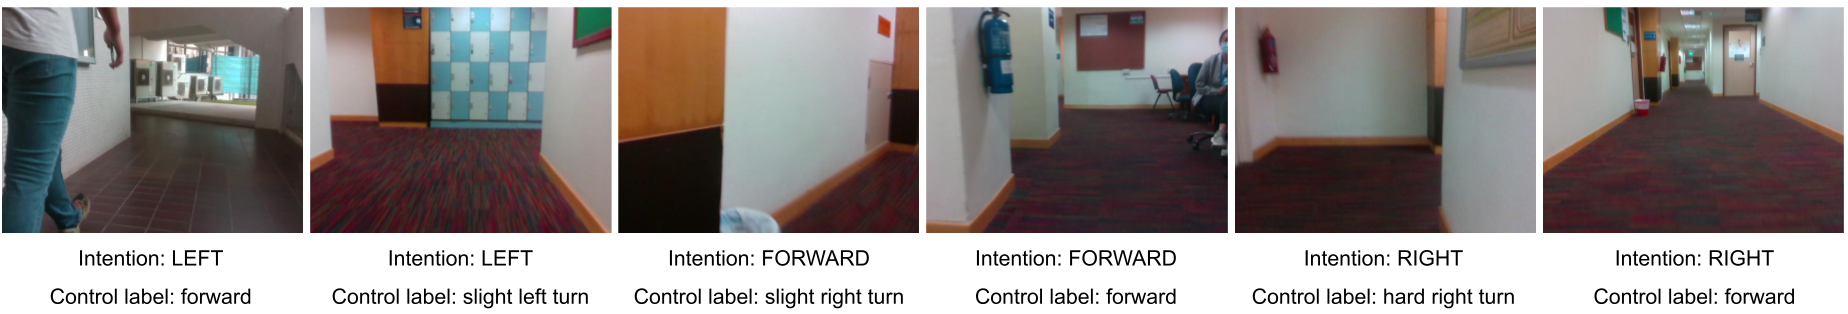

### **3. Basic CNN Model**

**Define the convolutional neural network (CNN) model for control prediction.**

<!-- In the earliner lecture, we talked about linear regression: fit input-output data pairs to a linear function.  -->
Here, we build a neural network that takes camera images and user intentions as input and outputs categorical distributions over the five control classes.
A linear function is not sufficient to capture the complex relationship between  input *images* and output control labels (angular velocities).   Instead, we use a neural network, which is capable of representing complex nonlinear functions. The neural network model consists of several convolution layers to extract featurs from  the images and full connnected layers to map image features to the final output. We also use one-hot encoding of the intentions as input to the FC layers.

Below defines a simple CNN model for demonstration.




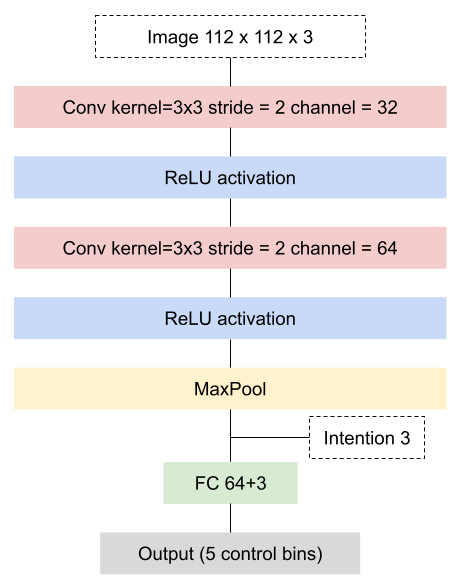

In [15]:
import torch.nn as nn
import torch.nn.functional as F

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class MyModel(nn.Module):

    def __init__(self, num_bins=5):
        super().__init__()
        self.num_bins = num_bins

        # Build the CNN feature extractor
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.AdaptiveMaxPool2d(output_size=(1, 1))
        )

        # Build a FC heads, taking both the image features and the intention as input
        self.fc = nn.Sequential(
                    nn.Linear(in_features=64+3, out_features=num_bins))

        print(f'A simple learner.')

    def forward(self, image, intention):
        # Map images to feature vectors
        feature = self.cnn(image).flatten(1)
        # Cast intention to one-hot encoding 
        intention = intention.unsqueeze(1)
        onehot_intention = torch.zeros(intention.shape[0], 3, device=intention.device).scatter_(1, intention, 1)
        # Predict control
        control = self.fc(torch.cat((feature, onehot_intention), dim=1)).view(-1, self.num_bins)
        # Return control as a categorical distribution
        return control

You can stack more convolutional layers (`nn.conv2d`) in the feature extractor `self.cnn` to make the model deeper. You may also change the number of output channels (`out_channels`) to make the CNN wider. Deeper and wider networks are generally more expressive and can represent more complex functions. 

You are permitted to utilize a pre-trained model, additional data, and more advanced architectures such as Transformer to enhance your approach in any way you see fit. There are no restrictions on the methods or tools that you can use to improve the performance of your model. It is essential that all the methods and tools used are thoroughly documented in your report as a good practice. This will help ensure transparency and allow others to reproduce your results.

Note that when modifying the architecture, you have to make sure that the `in_channels` of a layer equals to the `out_channels` of its preceding layer.



### **4. Data Loading**

In the following code, we create a data loader `MyDataset` to load our dataset from the hard disk to the memory. The Python class inherits the standard PyTorch `Dataset` class. It will return us a mini-batch of randomly sampled data at every `enumerate` operation. You will see the usage in our training code.   

In [16]:
import os
import cv2
import random
import math
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import Sampler
from torchvision import transforms
from torchvision.transforms import *
import sys

def read_image(path):
    return Image.open(path)


class MyDataset(Dataset):
    
    INTENTION_MAPPING = {'forward': 0, 'left': 1, 'right': 2}
    MAX_VELOCITY = 0.7
    MIN_VELOCITY = -0.7

    def __init__(self, is_train=True, num_bins=5):
        self.bin_size = (self.MAX_VELOCITY - self.MIN_VELOCITY) / num_bins

        self.data_dir = '.'
        if is_train:
            self.data = pd.read_csv(os.path.join(self.data_dir, 'train.txt'), sep='  ')
        else:
            self.data = pd.read_csv(os.path.join(self.data_dir, 'val.txt'), sep=' ')

        self.preprocess = Compose([
            Resize((112, 112)),
            ToTensor(),
            Normalize(mean=[0.5071, 0.4866, 0.4409], std=[0.2675, 0.2565, 0.2761])
        ])
        
        print(f'loaded data from {self.data_dir}. dataset size {len(self)}')

    def discretize_control(self, control):
        return int((control - self.MIN_VELOCITY) / self.bin_size)

    def __getitem__(self, idx):
        frame, _, _, angular_velocity, intention = self.data.iloc[idx]
        image = self.preprocess(read_image(os.path.join(self.data_dir, 'images', f'{frame}.jpg')))
        intention = torch.tensor(self.INTENTION_MAPPING[intention])
        label = torch.tensor(self.discretize_control(angular_velocity))

        return image, intention, label

    def __len__(self):
        return len(self.data)

### **5. Basic CNN Model Training**



**Set the working directory.**

In [17]:
from os import path, chdir, getcwd, mkdir
!ls

images    train.txt val.txt


**Start training.**

The first epoch is slow. With data caching, from the 2nd epoch it trains much faster.



In [20]:
import time
from datetime import datetime
import torch
import multiprocessing as mp
import dataloader
from torch.optim.lr_scheduler import ReduceLROnPlateau

class AverageMeter(object):
    """
    A utility class to compute statisitcs of losses and accuracies
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def get_lr(optimizer):
    '''
    Get the current learning rate
    '''
    for param_group in optimizer.param_groups:
        return param_group['lr']


def topk_accuracy(k, outputs, targets):
    """
    Compute top k accuracy
    """
    batch_size = targets.size(0)

    _, pred = outputs.topk(k, 1, True)
    pred = pred.t()
    correct = pred.eq(targets.view(1, -1))
    n_correct_elems = correct.type(torch.FloatTensor).sum().item()

    return n_correct_elems / batch_size


def train():
    batch_size = 64
    num_epochs = 10
    num_workers = 2
    num_bins = 5

    model = MyModel(num_bins)
#     model = nn.DataParallel(model.cuda().float())
    model = nn.DataParallel(model.to(gpu_name).float())

    train_set = dataloader.MyDataset(is_train=True, num_bins=num_bins)
    validation_set = dataloader.MyDataset(is_train=False, num_bins=num_bins)

    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=batch_size, num_workers=num_workers, pin_memory=True, shuffle=True)
    validation_loader = torch.utils.data.DataLoader(
        validation_set, batch_size=batch_size, num_workers=num_workers, pin_memory=True, shuffle=False)

    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=0.01, momentum=0.5)
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.3)

    # training loop
    for epoch in range(num_epochs):
        start_time = time.time()
        train_loss, val_loss = AverageMeter(), AverageMeter()
        train_acc, val_acc = AverageMeter(), AverageMeter()

        # train loop
        model.train()
        for i, (image, intention, label) in enumerate(train_loader):
#             image, intention, label = image.cuda(), intention.cuda(), \
#                 label.cuda().view(-1)
            image, intention, label = image.to(gpu_name), intention.to(gpu_name), \
                    label.to(gpu_name).view(-1)

            prediction = model(image, intention)

            loss = criterion(prediction, label)
            train_loss.update(loss.item())

            acc = topk_accuracy(2, prediction, label)
            train_acc.update(acc)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if i % 100 == 99:
                print(f'time:{datetime.now()} training: iteration {i} / {len(train_loader)}, avg train loss = {train_loss.avg:.4f}, '
                      f'train accuracy {train_acc.avg:.4f}')

        # validation
        model.eval()
        for i, (image, intention, label) in enumerate(validation_loader):
#             image, intention, label = image.cuda(), intention.cuda(), \
#                 label.cuda().view(-1)
            image, intention, label = image.to(gpu_name), intention.to(gpu_name), \
                label.to(gpu_name).view(-1)
            with torch.no_grad():
                prediction = model(image, intention)

                loss = criterion(prediction, label)
                val_loss.update(loss.item())

                acc = topk_accuracy(2, prediction, label)
                val_acc.update(acc)

            if i % 100 == 99:
                print(f'time:{datetime.now()} validation: iteration {i} / {len(validation_loader)}, avg val loss = {val_loss.avg:.4f}, '
                      f'val accuracy {val_acc.avg:.4f}')

        # epoch summary
        print(f'Epoch {epoch}, train error {train_loss.avg:.4f}, val error {val_loss.avg:.4f}. '
              f'Train acc = {train_acc.avg:.4f}, val acc = {val_acc.avg:.4f}. '
              f'Time cost {(time.time() - start_time) / 60:.2f} min.\n')

        # lr scheduler
        scheduler.step(val_loss.avg)

        # checkpoint
        if epoch % 2 == 1:
            torch.save(model.state_dict(), f'ckpt_e{epoch}.pth')


if __name__ == "__main__":
    train()


A simple learner.


/Users/niharika/Documents/Study Material/Sem 2/Intelligent Robots/Assignments/Lab 2/dataloader.py:28: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  self.data = pd.read_csv(os.path.join(self.data_dir, 'train.txt'), sep='  ')


loaded data from .. dataset size 97000
loaded data from .. dataset size 10000


/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <06D2C3BD-26E5-3AB9-A866-63839BE393A7> /opt/homebrew/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <56A90CE2-5D18-3700-90E8-5A997C0FE7D2> /opt/homebrew/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarType

time:2023-03-11 20:39:49.822363 training: iteration 99 / 1516, avg train loss = 1.6190, train accuracy 0.4242
time:2023-03-11 20:39:55.214999 training: iteration 199 / 1516, avg train loss = 1.6123, train accuracy 0.4284
time:2023-03-11 20:39:59.958160 training: iteration 299 / 1516, avg train loss = 1.6084, train accuracy 0.4396
time:2023-03-11 20:40:05.162406 training: iteration 399 / 1516, avg train loss = 1.6056, train accuracy 0.4484
time:2023-03-11 20:40:10.405037 training: iteration 499 / 1516, avg train loss = 1.6035, train accuracy 0.4550
time:2023-03-11 20:40:15.674807 training: iteration 599 / 1516, avg train loss = 1.6013, train accuracy 0.4623
time:2023-03-11 20:40:21.913877 training: iteration 699 / 1516, avg train loss = 1.5992, train accuracy 0.4683
time:2023-03-11 20:40:33.168340 training: iteration 799 / 1516, avg train loss = 1.5974, train accuracy 0.4736
time:2023-03-11 20:40:39.648692 training: iteration 899 / 1516, avg train loss = 1.5958, train accuracy 0.4796
ti

/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <06D2C3BD-26E5-3AB9-A866-63839BE393A7> /opt/homebrew/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <56A90CE2-5D18-3700-90E8-5A997C0FE7D2> /opt/homebrew/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarType

time:2023-03-11 20:41:28.657825 validation: iteration 99 / 157, avg val loss = 1.5691, val accuracy 0.5672
Epoch 0, train error 1.5864, val error 1.5669. Train acc = 0.5100, val acc = 0.5704. Time cost 2.07 min.



/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <06D2C3BD-26E5-3AB9-A866-63839BE393A7> /opt/homebrew/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <56A90CE2-5D18-3700-90E8-5A997C0FE7D2> /opt/homebrew/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarType

time:2023-03-11 20:41:47.571790 training: iteration 99 / 1516, avg train loss = 1.5610, train accuracy 0.5900
time:2023-03-11 20:41:52.506112 training: iteration 199 / 1516, avg train loss = 1.5608, train accuracy 0.5869
time:2023-03-11 20:41:57.709337 training: iteration 299 / 1516, avg train loss = 1.5601, train accuracy 0.5856
time:2023-03-11 20:42:02.490761 training: iteration 399 / 1516, avg train loss = 1.5598, train accuracy 0.5856
time:2023-03-11 20:42:08.047638 training: iteration 499 / 1516, avg train loss = 1.5593, train accuracy 0.5849
time:2023-03-11 20:42:13.910378 training: iteration 599 / 1516, avg train loss = 1.5585, train accuracy 0.5869
time:2023-03-11 20:42:19.415927 training: iteration 699 / 1516, avg train loss = 1.5573, train accuracy 0.5884
time:2023-03-11 20:42:24.647651 training: iteration 799 / 1516, avg train loss = 1.5567, train accuracy 0.5888
time:2023-03-11 20:42:29.772615 training: iteration 899 / 1516, avg train loss = 1.5554, train accuracy 0.5905
ti

/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <06D2C3BD-26E5-3AB9-A866-63839BE393A7> /opt/homebrew/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <56A90CE2-5D18-3700-90E8-5A997C0FE7D2> /opt/homebrew/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarType

time:2023-03-11 20:43:17.040759 validation: iteration 99 / 157, avg val loss = 1.5396, val accuracy 0.5978
Epoch 1, train error 1.5502, val error 1.5403. Train acc = 0.5963, val acc = 0.5887. Time cost 1.81 min.



/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <06D2C3BD-26E5-3AB9-A866-63839BE393A7> /opt/homebrew/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <56A90CE2-5D18-3700-90E8-5A997C0FE7D2> /opt/homebrew/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarType

time:2023-03-11 20:43:36.443460 training: iteration 99 / 1516, avg train loss = 1.5351, train accuracy 0.6112
time:2023-03-11 20:43:41.795362 training: iteration 199 / 1516, avg train loss = 1.5343, train accuracy 0.6114
time:2023-03-11 20:43:46.464796 training: iteration 299 / 1516, avg train loss = 1.5332, train accuracy 0.6128
time:2023-03-11 20:43:51.038281 training: iteration 399 / 1516, avg train loss = 1.5330, train accuracy 0.6107
time:2023-03-11 20:43:55.681536 training: iteration 499 / 1516, avg train loss = 1.5324, train accuracy 0.6113
time:2023-03-11 20:44:00.386715 training: iteration 599 / 1516, avg train loss = 1.5317, train accuracy 0.6112
time:2023-03-11 20:44:05.238637 training: iteration 699 / 1516, avg train loss = 1.5310, train accuracy 0.6112
time:2023-03-11 20:44:09.840945 training: iteration 799 / 1516, avg train loss = 1.5303, train accuracy 0.6106
time:2023-03-11 20:44:15.199446 training: iteration 899 / 1516, avg train loss = 1.5296, train accuracy 0.6110
ti

/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <06D2C3BD-26E5-3AB9-A866-63839BE393A7> /opt/homebrew/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <56A90CE2-5D18-3700-90E8-5A997C0FE7D2> /opt/homebrew/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarType

time:2023-03-11 20:45:02.535014 validation: iteration 99 / 157, avg val loss = 1.5211, val accuracy 0.6070
Epoch 2, train error 1.5255, val error 1.5201. Train acc = 0.6117, val acc = 0.5958. Time cost 1.76 min.



/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <06D2C3BD-26E5-3AB9-A866-63839BE393A7> /opt/homebrew/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <56A90CE2-5D18-3700-90E8-5A997C0FE7D2> /opt/homebrew/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarType

time:2023-03-11 20:45:23.185569 training: iteration 99 / 1516, avg train loss = 1.5181, train accuracy 0.6103
time:2023-03-11 20:45:28.526601 training: iteration 199 / 1516, avg train loss = 1.5155, train accuracy 0.6145
time:2023-03-11 20:45:33.922134 training: iteration 299 / 1516, avg train loss = 1.5150, train accuracy 0.6171
time:2023-03-11 20:45:39.682692 training: iteration 399 / 1516, avg train loss = 1.5142, train accuracy 0.6175
time:2023-03-11 20:45:46.194645 training: iteration 499 / 1516, avg train loss = 1.5128, train accuracy 0.6175
time:2023-03-11 20:45:52.659537 training: iteration 599 / 1516, avg train loss = 1.5112, train accuracy 0.6184
time:2023-03-11 20:45:59.204340 training: iteration 699 / 1516, avg train loss = 1.5101, train accuracy 0.6189
time:2023-03-11 20:46:05.011875 training: iteration 799 / 1516, avg train loss = 1.5099, train accuracy 0.6181
time:2023-03-11 20:46:10.356535 training: iteration 899 / 1516, avg train loss = 1.5096, train accuracy 0.6173
ti

/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <06D2C3BD-26E5-3AB9-A866-63839BE393A7> /opt/homebrew/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <56A90CE2-5D18-3700-90E8-5A997C0FE7D2> /opt/homebrew/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarType

time:2023-03-11 20:46:57.736967 validation: iteration 99 / 157, avg val loss = 1.5048, val accuracy 0.6189
Epoch 3, train error 1.5063, val error 1.5033. Train acc = 0.6175, val acc = 0.6015. Time cost 1.92 min.



/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <06D2C3BD-26E5-3AB9-A866-63839BE393A7> /opt/homebrew/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <56A90CE2-5D18-3700-90E8-5A997C0FE7D2> /opt/homebrew/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarType

time:2023-03-11 20:47:16.984274 training: iteration 99 / 1516, avg train loss = 1.4980, train accuracy 0.6219
time:2023-03-11 20:47:22.610828 training: iteration 199 / 1516, avg train loss = 1.4962, train accuracy 0.6225
time:2023-03-11 20:47:28.886453 training: iteration 299 / 1516, avg train loss = 1.4950, train accuracy 0.6246
time:2023-03-11 20:47:34.223824 training: iteration 399 / 1516, avg train loss = 1.4954, train accuracy 0.6219
time:2023-03-11 20:47:40.121696 training: iteration 499 / 1516, avg train loss = 1.4936, train accuracy 0.6236
time:2023-03-11 20:47:45.296016 training: iteration 599 / 1516, avg train loss = 1.4934, train accuracy 0.6233
time:2023-03-11 20:47:51.693297 training: iteration 699 / 1516, avg train loss = 1.4936, train accuracy 0.6212
time:2023-03-11 20:47:59.409087 training: iteration 799 / 1516, avg train loss = 1.4928, train accuracy 0.6230
time:2023-03-11 20:48:05.614480 training: iteration 899 / 1516, avg train loss = 1.4918, train accuracy 0.6235
ti

/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <06D2C3BD-26E5-3AB9-A866-63839BE393A7> /opt/homebrew/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <56A90CE2-5D18-3700-90E8-5A997C0FE7D2> /opt/homebrew/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarType

time:2023-03-11 20:48:53.791652 validation: iteration 99 / 157, avg val loss = 1.4901, val accuracy 0.6309
Epoch 4, train error 1.4903, val error 1.4888. Train acc = 0.6220, val acc = 0.6122. Time cost 1.94 min.



/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <06D2C3BD-26E5-3AB9-A866-63839BE393A7> /opt/homebrew/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <56A90CE2-5D18-3700-90E8-5A997C0FE7D2> /opt/homebrew/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarType

time:2023-03-11 20:49:13.553621 training: iteration 99 / 1516, avg train loss = 1.4844, train accuracy 0.6277
time:2023-03-11 20:49:18.115996 training: iteration 199 / 1516, avg train loss = 1.4833, train accuracy 0.6250
time:2023-03-11 20:49:22.823307 training: iteration 299 / 1516, avg train loss = 1.4833, train accuracy 0.6248
time:2023-03-11 20:49:27.934969 training: iteration 399 / 1516, avg train loss = 1.4816, train accuracy 0.6261
time:2023-03-11 20:49:32.742578 training: iteration 499 / 1516, avg train loss = 1.4822, train accuracy 0.6232
time:2023-03-11 20:49:37.353448 training: iteration 599 / 1516, avg train loss = 1.4820, train accuracy 0.6226
time:2023-03-11 20:49:41.960488 training: iteration 699 / 1516, avg train loss = 1.4806, train accuracy 0.6234
time:2023-03-11 20:49:46.748120 training: iteration 799 / 1516, avg train loss = 1.4797, train accuracy 0.6236
time:2023-03-11 20:49:51.506811 training: iteration 899 / 1516, avg train loss = 1.4792, train accuracy 0.6240
ti

/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <06D2C3BD-26E5-3AB9-A866-63839BE393A7> /opt/homebrew/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <56A90CE2-5D18-3700-90E8-5A997C0FE7D2> /opt/homebrew/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarType

time:2023-03-11 20:50:38.294864 validation: iteration 99 / 157, avg val loss = 1.4773, val accuracy 0.6367
Epoch 5, train error 1.4765, val error 1.4763. Train acc = 0.6251, val acc = 0.6190. Time cost 1.74 min.



/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <06D2C3BD-26E5-3AB9-A866-63839BE393A7> /opt/homebrew/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <56A90CE2-5D18-3700-90E8-5A997C0FE7D2> /opt/homebrew/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarType

time:2023-03-11 20:50:57.157545 training: iteration 99 / 1516, avg train loss = 1.4683, train accuracy 0.6270
time:2023-03-11 20:51:01.888573 training: iteration 199 / 1516, avg train loss = 1.4710, train accuracy 0.6284
time:2023-03-11 20:51:07.275227 training: iteration 299 / 1516, avg train loss = 1.4715, train accuracy 0.6276
time:2023-03-11 20:51:12.099958 training: iteration 399 / 1516, avg train loss = 1.4705, train accuracy 0.6288
time:2023-03-11 20:51:17.043670 training: iteration 499 / 1516, avg train loss = 1.4702, train accuracy 0.6271
time:2023-03-11 20:51:22.228609 training: iteration 599 / 1516, avg train loss = 1.4696, train accuracy 0.6277
time:2023-03-11 20:51:26.947395 training: iteration 699 / 1516, avg train loss = 1.4697, train accuracy 0.6273
time:2023-03-11 20:51:31.591274 training: iteration 799 / 1516, avg train loss = 1.4684, train accuracy 0.6278
time:2023-03-11 20:51:36.650766 training: iteration 899 / 1516, avg train loss = 1.4672, train accuracy 0.6279
ti

/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <06D2C3BD-26E5-3AB9-A866-63839BE393A7> /opt/homebrew/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <56A90CE2-5D18-3700-90E8-5A997C0FE7D2> /opt/homebrew/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarType

time:2023-03-11 20:52:21.868586 validation: iteration 99 / 157, avg val loss = 1.4638, val accuracy 0.6408
Epoch 6, train error 1.4647, val error 1.4658. Train acc = 0.6290, val acc = 0.6196. Time cost 1.73 min.



/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <06D2C3BD-26E5-3AB9-A866-63839BE393A7> /opt/homebrew/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <56A90CE2-5D18-3700-90E8-5A997C0FE7D2> /opt/homebrew/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarType

time:2023-03-11 20:52:41.187632 training: iteration 99 / 1516, avg train loss = 1.4613, train accuracy 0.6264
time:2023-03-11 20:52:46.219410 training: iteration 199 / 1516, avg train loss = 1.4628, train accuracy 0.6259
time:2023-03-11 20:52:51.400705 training: iteration 299 / 1516, avg train loss = 1.4593, train accuracy 0.6290
time:2023-03-11 20:52:56.013750 training: iteration 399 / 1516, avg train loss = 1.4605, train accuracy 0.6288
time:2023-03-11 20:53:00.620156 training: iteration 499 / 1516, avg train loss = 1.4612, train accuracy 0.6284
time:2023-03-11 20:53:05.493973 training: iteration 599 / 1516, avg train loss = 1.4600, train accuracy 0.6288
time:2023-03-11 20:53:10.392437 training: iteration 699 / 1516, avg train loss = 1.4585, train accuracy 0.6294
time:2023-03-11 20:53:16.021972 training: iteration 799 / 1516, avg train loss = 1.4583, train accuracy 0.6296
time:2023-03-11 20:53:20.763386 training: iteration 899 / 1516, avg train loss = 1.4579, train accuracy 0.6305
ti

/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <06D2C3BD-26E5-3AB9-A866-63839BE393A7> /opt/homebrew/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <56A90CE2-5D18-3700-90E8-5A997C0FE7D2> /opt/homebrew/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarType

time:2023-03-11 20:54:09.023682 validation: iteration 99 / 157, avg val loss = 1.4542, val accuracy 0.6369
Epoch 7, train error 1.4542, val error 1.4568. Train acc = 0.6330, val acc = 0.6238. Time cost 1.79 min.



/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <06D2C3BD-26E5-3AB9-A866-63839BE393A7> /opt/homebrew/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <56A90CE2-5D18-3700-90E8-5A997C0FE7D2> /opt/homebrew/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarType

time:2023-03-11 20:54:28.349237 training: iteration 99 / 1516, avg train loss = 1.4515, train accuracy 0.6403
time:2023-03-11 20:54:33.399127 training: iteration 199 / 1516, avg train loss = 1.4481, train accuracy 0.6415
time:2023-03-11 20:54:38.157241 training: iteration 299 / 1516, avg train loss = 1.4467, train accuracy 0.6419
time:2023-03-11 20:54:42.803981 training: iteration 399 / 1516, avg train loss = 1.4477, train accuracy 0.6413
time:2023-03-11 20:54:47.320482 training: iteration 499 / 1516, avg train loss = 1.4473, train accuracy 0.6402
time:2023-03-11 20:54:52.349321 training: iteration 599 / 1516, avg train loss = 1.4472, train accuracy 0.6384
time:2023-03-11 20:54:57.038556 training: iteration 699 / 1516, avg train loss = 1.4466, train accuracy 0.6394
time:2023-03-11 20:55:01.623152 training: iteration 799 / 1516, avg train loss = 1.4464, train accuracy 0.6395
time:2023-03-11 20:55:06.615602 training: iteration 899 / 1516, avg train loss = 1.4471, train accuracy 0.6379
ti

/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <06D2C3BD-26E5-3AB9-A866-63839BE393A7> /opt/homebrew/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <56A90CE2-5D18-3700-90E8-5A997C0FE7D2> /opt/homebrew/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarType

time:2023-03-11 20:55:51.039140 validation: iteration 99 / 157, avg val loss = 1.4450, val accuracy 0.6262
Epoch 8, train error 1.4453, val error 1.4506. Train acc = 0.6376, val acc = 0.6180. Time cost 1.70 min.



/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <06D2C3BD-26E5-3AB9-A866-63839BE393A7> /opt/homebrew/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <56A90CE2-5D18-3700-90E8-5A997C0FE7D2> /opt/homebrew/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarType

time:2023-03-11 20:56:09.944911 training: iteration 99 / 1516, avg train loss = 1.4398, train accuracy 0.6306
time:2023-03-11 20:56:14.913831 training: iteration 199 / 1516, avg train loss = 1.4380, train accuracy 0.6355
time:2023-03-11 20:56:19.915808 training: iteration 299 / 1516, avg train loss = 1.4381, train accuracy 0.6385
time:2023-03-11 20:56:24.565356 training: iteration 399 / 1516, avg train loss = 1.4397, train accuracy 0.6395
time:2023-03-11 20:56:29.180672 training: iteration 499 / 1516, avg train loss = 1.4398, train accuracy 0.6381
time:2023-03-11 20:56:34.183544 training: iteration 599 / 1516, avg train loss = 1.4383, train accuracy 0.6410
time:2023-03-11 20:56:38.730770 training: iteration 699 / 1516, avg train loss = 1.4390, train accuracy 0.6401
time:2023-03-11 20:56:44.393649 training: iteration 799 / 1516, avg train loss = 1.4391, train accuracy 0.6399
time:2023-03-11 20:56:49.110410 training: iteration 899 / 1516, avg train loss = 1.4389, train accuracy 0.6398
ti

/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <06D2C3BD-26E5-3AB9-A866-63839BE393A7> /opt/homebrew/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <56A90CE2-5D18-3700-90E8-5A997C0FE7D2> /opt/homebrew/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarType

time:2023-03-11 20:57:36.254576 validation: iteration 99 / 157, avg val loss = 1.4381, val accuracy 0.6452
Epoch 9, train error 1.4375, val error 1.4425. Train acc = 0.6407, val acc = 0.6314. Time cost 1.75 min.



This is our main training code. It performs training in the term of "epochs", where each epoch represents enumerating the full training dataset. In each epoch, we first train our model using mini batch gradient descent, then evaluate our model using the test data. For every two epochs, we save a checkpoint of our model to the hard disk.

The main hyper-parameters that need to be tuned for the learning task includes the learning rate ("lr" parameter of the optimizer), the size of mini batches ("batch_size"), and the L2 regularization factor ("weight_decay" parameter of the optimizer). For this vanilla implementation, it should take around 40 minutes for the training process.

### **6. Improving the Model**

The basic CNN model does not work very well on the training data. After 10 epochs of training, it achieves about 53% top-2 classification accuracy on the validation dataset over 5 angular velocity bins. Now, your task is to investigate why the basic CNN model does not perform well and improve the model to achieve higher prediction accuracy. Some specific suggestions are given below.





**Tune the learning algorithm.**  Hyperparameter tuning is important to neural network training. Try to adjust the following parameters in section 5 "basic CNN model training":

- Choice of [optimizer](https://pytorch.org/docs/stable/optim.html) (SGD, Adam, AdamW (Adam with proper weight decay), ...)
- Learning rate (0.1, 0.01, 0.001, 0.0001, ...)
- Number of epochs (should be sufficient to achieve converge)
- Batch size (32, 64, 128, 256, ...) (optional)

The learning rate typically has the largest impact on performance. When the learning rate is too large, it leads to unstable training (loss fluctuating or frozen at a high level). When it is too small, it leads to inefficient training (loss decreasing very slowly). You need to identify the best learning rate to allow both stable and efficient training.

The choice of optmizer can also largely affect the training and validation performance. Some optimizers perform better on training, while some optimizers are good at generalization. Note that the learning rate needs to be re-tuned after changing the optimizer.

**Improve feature extraction.** A good image feature extractor is key to good performance. Using deeper (with more layers) and wider (with more channels) networks typically make the feature extractor more powerful. However, when there are too many trainable parameters in a network, it also becomes susceptible to ["overfitting"](https://d2l.ai/chapter_multilayer-perceptrons/underfit-overfit.html#underfitting-or-overfitting), i.e., the model fits the training set perfectly (low loss, high accuracy) but fails to generalize to the validation set (high loss, low accuracy). 

You need to determine the optimal depth and the width of your feature extractor to acheive the best performance on the validation set.









There are many other techniques to improve  classification performance. Two common ones are described below. You may try these two or any others to improve the  performance further, particularly, for extra credits.

**Augment the data (optional)**. The augmentation technique artificially expands the size of a training dataset by creating modified versions of images. It creates variations of the images that can improve the  model's ability to generalize. 
You can augment the images by transforming the content, for example:
- Fliping the input image horizontally (as well as the user intention and the angular velocity label). This produces data for a "mirrored" environment.
- Slightly translating or rotating the image. This emulates slight variations of the orientation of SPOT's body. You may need to slightly crop the edges of input images to eliminate empty pixels produced by image transformation.
- Other meaningful transformations to introduce variantion to images in the dataset. 

Transformations in [`torchvision.transforms`](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py) allows you to easily perform various types of image transformations. You can customize your data augmentation by adding more random transformations to `self.preprocessor`.

**Regularization (optional).**
If overfitting unfortunately happens, you can try the following techniques to adddress it and improve the generalization of your model:
- [L2 reguarization or weight decay](https://d2l.ai/chapter_multilayer-perceptrons/weight-decay.html). Weight decay regulates the weights of your network to be small values so that the model generalizes better. The scaling factor of the regularization term is controlled by the `weight_decay` parameter of the optimizer.
- [Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) (nn.Dropout and nn.Dropout2d). Dropout randomly drops out some activations in the cooresponding hidden layer during training. This makes the network more difficult to train, but often easier to generalize.


### **Submission**



Create a single zip file `YourMatricNumber-Lab2.zip` (e.g., `A01234567-Lab2.zip` ) containg the following:

1. Colab notebook
 * Download your entire Colab notebook. Save it as an ipynb file and name it `YourMatricNumber-Notebook.ipynb`.
2. Neural network model class
  
  This file will be used to load your pretrained model and hence for evaluation.
 * Name the file  `Model.py`
 * See example code in  Section 3 Basic CNN Model above.
 * Do not change the inner class name and keep it as "MyModel".

3. Pretrained model
    - Name the file as `YourMatricNumber-Model.pt`
    - You can find the example code to save your model in Section 5 Basic CNN Model Training
    - Make sure you can load the model with the "MyModel" defined in `Model.py`.

    
4. Report
  * Describe briefly each attempt that you have made to improve the classification accuracy and the resulting performance gain.
  * Name the file as `YourMatricNumber.pdf`

Organize your submission folder strictly according to the following structure:
```
YourMatricNumber-Lab2.zip
|-- YourMatricNumber-Notebook.ipynb
|-- YourMatricNumber.pdf
|-- model_file
    |-- Model.py
    |-- YourMatricNumber-Model.pt
```

In [2]:
# Model was trained using a python file (Model.py) where the outputs were sent to the terminal.
# Each epoch takes ~35 mins on using Apple M2 MPS GPU. 
# However, it can be reproduced using the following code by specifying the correct data path.
# Epoch 2 model (iteration 3) is chosen as the final model.
import sys
sys.path.append('model_file')
import torch
from torch import nn
from Model import *

if __name__ == "__main__":
    train()

/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <06D2C3BD-26E5-3AB9-A866-63839BE393A7> /opt/homebrew/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <56A90CE2-5D18-3700-90E8-5A997C0FE7D2> /opt/homebrew/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/opt/homebrew/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: A

A not so simple learner.
loaded data from ../BehaviourCloning. dataset size 97000
loaded data from ../BehaviourCloning. dataset size 10000


/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <06D2C3BD-26E5-3AB9-A866-63839BE393A7> /opt/homebrew/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <56A90CE2-5D18-3700-90E8-5A997C0FE7D2> /opt/homebrew/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarType

time:2023-03-17 23:02:07.058800 training: iteration 99 / 1516, avg train loss = 1.2981, train accuracy 0.7180
time:2023-03-17 23:04:05.769274 training: iteration 199 / 1516, avg train loss = 1.2058, train accuracy 0.7555
time:2023-03-17 23:06:09.848279 training: iteration 299 / 1516, avg train loss = 1.1455, train accuracy 0.7783
time:2023-03-17 23:08:23.375761 training: iteration 399 / 1516, avg train loss = 1.1107, train accuracy 0.7925
time:2023-03-17 23:10:30.306875 training: iteration 499 / 1516, avg train loss = 1.0839, train accuracy 0.8033
time:2023-03-17 23:12:31.467305 training: iteration 599 / 1516, avg train loss = 1.0594, train accuracy 0.8116
time:2023-03-17 23:14:31.617217 training: iteration 699 / 1516, avg train loss = 1.0350, train accuracy 0.8180
time:2023-03-17 23:16:37.014021 training: iteration 799 / 1516, avg train loss = 1.0133, train accuracy 0.8254
time:2023-03-17 23:18:51.399599 training: iteration 899 / 1516, avg train loss = 0.9966, train accuracy 0.8313
ti

/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <06D2C3BD-26E5-3AB9-A866-63839BE393A7> /opt/homebrew/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <56A90CE2-5D18-3700-90E8-5A997C0FE7D2> /opt/homebrew/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarType

time:2023-03-17 23:33:40.574960 validation: iteration 99 / 157, avg val loss = 1.1146, val accuracy 0.8222
Epoch 0, train error 0.9144, val error 1.1075. Train acc = 0.8548, val acc = 0.8285. Time cost 34.17 min.

--------------------------------------------------------


/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <06D2C3BD-26E5-3AB9-A866-63839BE393A7> /opt/homebrew/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <56A90CE2-5D18-3700-90E8-5A997C0FE7D2> /opt/homebrew/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarType

time:2023-03-17 23:36:25.498593 training: iteration 99 / 1516, avg train loss = 0.6608, train accuracy 0.9211
time:2023-03-17 23:38:35.932108 training: iteration 199 / 1516, avg train loss = 0.6665, train accuracy 0.9187
time:2023-03-17 23:40:52.734706 training: iteration 299 / 1516, avg train loss = 0.6634, train accuracy 0.9186
time:2023-03-17 23:43:12.446838 training: iteration 399 / 1516, avg train loss = 0.6646, train accuracy 0.9184
time:2023-03-17 23:45:20.265340 training: iteration 499 / 1516, avg train loss = 0.6653, train accuracy 0.9173
time:2023-03-17 23:47:16.551549 training: iteration 599 / 1516, avg train loss = 0.6653, train accuracy 0.9180
time:2023-03-17 23:49:28.168038 training: iteration 699 / 1516, avg train loss = 0.6595, train accuracy 0.9192
time:2023-03-17 23:51:43.325851 training: iteration 799 / 1516, avg train loss = 0.6563, train accuracy 0.9196
time:2023-03-17 23:53:56.024888 training: iteration 899 / 1516, avg train loss = 0.6521, train accuracy 0.9208
ti

/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <06D2C3BD-26E5-3AB9-A866-63839BE393A7> /opt/homebrew/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <56A90CE2-5D18-3700-90E8-5A997C0FE7D2> /opt/homebrew/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarType

time:2023-03-18 00:08:33.972741 validation: iteration 99 / 157, avg val loss = 1.0046, val accuracy 0.8512
Epoch 1, train error 0.6256, val error 1.0818. Train acc = 0.9252, val acc = 0.8313. Time cost 34.89 min.

--------------------------------------------------------


/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <06D2C3BD-26E5-3AB9-A866-63839BE393A7> /opt/homebrew/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <56A90CE2-5D18-3700-90E8-5A997C0FE7D2> /opt/homebrew/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarType

time:2023-03-18 00:11:27.187172 training: iteration 99 / 1516, avg train loss = 0.4626, train accuracy 0.9563
time:2023-03-18 00:13:37.237074 training: iteration 199 / 1516, avg train loss = 0.4734, train accuracy 0.9534
time:2023-03-18 00:15:54.644331 training: iteration 299 / 1516, avg train loss = 0.4699, train accuracy 0.9547
time:2023-03-18 00:18:13.381247 training: iteration 399 / 1516, avg train loss = 0.4729, train accuracy 0.9546
time:2023-03-18 00:20:23.387917 training: iteration 499 / 1516, avg train loss = 0.4696, train accuracy 0.9543
time:2023-03-18 00:22:37.339207 training: iteration 599 / 1516, avg train loss = 0.4691, train accuracy 0.9542
time:2023-03-18 00:24:49.015138 training: iteration 699 / 1516, avg train loss = 0.4699, train accuracy 0.9533
time:2023-03-18 00:27:03.453056 training: iteration 799 / 1516, avg train loss = 0.4675, train accuracy 0.9535
time:2023-03-18 00:29:17.879796 training: iteration 899 / 1516, avg train loss = 0.4665, train accuracy 0.9536
ti

/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <06D2C3BD-26E5-3AB9-A866-63839BE393A7> /opt/homebrew/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <56A90CE2-5D18-3700-90E8-5A997C0FE7D2> /opt/homebrew/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarType

time:2023-03-18 00:43:48.469513 validation: iteration 99 / 157, avg val loss = 1.0804, val accuracy 0.8453
Epoch 2, train error 0.4583, val error 1.1572. Train acc = 0.9553, val acc = 0.8362. Time cost 35.25 min.

--------------------------------------------------------


/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <06D2C3BD-26E5-3AB9-A866-63839BE393A7> /opt/homebrew/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <56A90CE2-5D18-3700-90E8-5A997C0FE7D2> /opt/homebrew/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarType

time:2023-03-18 00:46:35.266963 training: iteration 99 / 1516, avg train loss = 0.3175, train accuracy 0.9727
time:2023-03-18 00:48:55.296251 training: iteration 199 / 1516, avg train loss = 0.3201, train accuracy 0.9735
time:2023-03-18 00:51:09.094529 training: iteration 299 / 1516, avg train loss = 0.3196, train accuracy 0.9735
time:2023-03-18 00:53:21.662024 training: iteration 399 / 1516, avg train loss = 0.3282, train accuracy 0.9731
time:2023-03-18 00:55:33.515017 training: iteration 499 / 1516, avg train loss = 0.3318, train accuracy 0.9728
time:2023-03-18 00:57:48.991836 training: iteration 599 / 1516, avg train loss = 0.3369, train accuracy 0.9719
time:2023-03-18 00:59:59.735777 training: iteration 699 / 1516, avg train loss = 0.3379, train accuracy 0.9725
time:2023-03-18 01:02:17.151616 training: iteration 799 / 1516, avg train loss = 0.3389, train accuracy 0.9724
time:2023-03-18 01:04:32.608121 training: iteration 899 / 1516, avg train loss = 0.3411, train accuracy 0.9724
ti

/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <06D2C3BD-26E5-3AB9-A866-63839BE393A7> /opt/homebrew/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <56A90CE2-5D18-3700-90E8-5A997C0FE7D2> /opt/homebrew/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarType

time:2023-03-18 01:19:08.929860 validation: iteration 99 / 157, avg val loss = 1.2627, val accuracy 0.8198
Epoch 3, train error 0.3430, val error 1.3753. Train acc = 0.9719, val acc = 0.8044. Time cost 35.35 min.

--------------------------------------------------------


/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <06D2C3BD-26E5-3AB9-A866-63839BE393A7> /opt/homebrew/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <56A90CE2-5D18-3700-90E8-5A997C0FE7D2> /opt/homebrew/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarType

KeyboardInterrupt: 

Below is the example test script for  evaluation. You may use it to check your model's performance with the validation set. Of course, a different test image set will be used for the actual evaluation.

In [2]:
projectDirectory = "/content/drive/My Drive/BehaviourCloning"
chdir(projectDirectory)

In [1]:
import sys
sys.path.append('model_file')

import torch
from torch import nn
from Model import MyModel, MyDataset, AverageMeter, topk_accuracy 
# Change [your_python_file] to the actual file containing the definitons of the classes

gpu_name = 'mps'


def test():
    my_model = MyModel()
    my_model = nn.DataParallel(my_model.to(gpu_name).float())
    my_model.eval()
    batch_size = 64

    path = 'model_file/A0254355A-Model.pt'
    my_model.load_state_dict(torch.load(path))
    test_set = MyDataset(is_train=False)

    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, \
                      shuffle=False)

    # test accuracy
    test_acc = AverageMeter()
    for i, (image, intention, label) in enumerate(test_loader):
        image, intention, label = image.to(gpu_name), intention.to(gpu_name), label.to(gpu_name).view(-1)
        with torch.no_grad():
            prediction = my_model(image, intention)
            acc = topk_accuracy(2, prediction, label)
            test_acc.update(acc)

        if i % 10 == 9:
            print(f'test: iteration {i} / {len(test_loader)}, '
                  f'test accuracy {test_acc.avg:.4f}')

    print(f'evaluation finished, val acc {test_acc.avg:.4f}')
    
if __name__ == "__main__":
    test()


/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <06D2C3BD-26E5-3AB9-A866-63839BE393A7> /opt/homebrew/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <56A90CE2-5D18-3700-90E8-5A997C0FE7D2> /opt/homebrew/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/opt/homebrew/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: A

A not so simple learner.
loaded data from ../BehaviourCloning. dataset size 10000
test: iteration 9 / 157, test accuracy 0.7922
test: iteration 19 / 157, test accuracy 0.7937
test: iteration 29 / 157, test accuracy 0.7995
test: iteration 39 / 157, test accuracy 0.7871
test: iteration 49 / 157, test accuracy 0.8141
test: iteration 59 / 157, test accuracy 0.8190
test: iteration 69 / 157, test accuracy 0.8270
test: iteration 79 / 157, test accuracy 0.8326
test: iteration 89 / 157, test accuracy 0.8405
test: iteration 99 / 157, test accuracy 0.8453
test: iteration 109 / 157, test accuracy 0.8497
test: iteration 119 / 157, test accuracy 0.8396
test: iteration 129 / 157, test accuracy 0.8331
test: iteration 139 / 157, test accuracy 0.8333
test: iteration 149 / 157, test accuracy 0.8328
evaluation finished, val acc 0.8362
